# オープンデータのみを使用し業績開示後に見るべき指標と株価への織り込み時期を探る

## 目的
個別銘柄の株価が大きく動くのは業績開示後であると仮定し、**特にどんな数字を重要視し、何日以内にピークに達するか**を株価変動率から考察します。継続して高値や安値を更新する場合もありますが、動きの激しい期間（≒流動性が十分に保たれる期間）に利確することを志向しています。

## 注意事項
- 完全なシステムトレードを目指したものではなく、「開示の確認箇所を明らかにし査読時間を短縮する」「時間軸や指値位置等、売買戦略に活かす」ことを目的としています。システムトレードには板情報や歩み値が必須と思っており、それらを収集しなければリスクリワードが悪いと個人的に思っています。（小声）
- 本コードは投資を指南・推薦するものではありません。自己責任でのご利用をお願いします。


## 使用するデータ
いずれも2022年末時点では無料で取得できます。
1. 日足出来高と四本値（始値、終値、高値、安値）：APIを叩いて収集しておきます。特徴量と目的変数の両方に使用します。[yahoo_finance_api2](https://pypi.org/project/yahoo-finance-api2/)取得方法の詳細はこちら[【日本株】全銘柄の四本値をPKGから取得し日次で更新する]
2. 財務データ：J-Quantsに会員登録して収集します。[J-Quants API](https://application.jpx-jquants.com/)[公式サイト](https://jpx.gitbook.io/j-quants-api/api-reference/finance-api)に収集方法の詳細が説明されているのでここでは割愛します。
3. 銘柄コードデータ：JPXのサイトからダウンロードします。[JPX](https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls)
各種データの期間は、財務データAPIの最古日（本notebook作成時で2017-02-10）から最新のデータを取得しています。

## 処理の概要
1. データの準備
    - 年毎にcsvファイルを分けて保存している日足データを結合します。
    - 目的変数を「{(基準日からN営業日間における高値または安値) / (基準日の終値)} - 1」とし四本値を加工します。
    - 銘柄コードデータを利用し、今回対象外となるETF、REIT等のデータを除外します。
    - 日足出来高と四本値を利用し、売買代金の大小から４つに分類します。←売買代金が少ないものは予測が困難ではないかと仮定し、除去して予測してみるため。
    - 日足データが揃わないもの（≒上場して間もないものや上場廃止となった可能性があるもの等）を除外します。
2. EDA
    - 財務データの代表的な特徴量による散布図行列。
    - 財務データを複数銘柄で比較。
    - 株価とその移動平均の折れ線グラフ。
    - 株価変化率の折れ線グラフ。
    - 株価のヒストリカルボラティリティ。[ヒストリカルボラティリティとは](https://www.jpx.co.jp/glossary/ha/382.html)
    - 欠損値の確認と補完
3. データの前処理
    - 目的変数を開示日に絞る
    - 特徴量作成
4. バックテスト準備
    - train/val/test期間の設定（ホールドアウト法）
5. 予測
    - 目的変数ごとにtrain/val/testを作成
    - RandomForest
    - XGBoost
    - ExtraTrees
    - GBR
    - 各種評価指標の出力
    
## 結果と所感
### 業績開示で注目すべき指標
個人投資家に注目されがちなのはEPSや配当である感覚があるが、どのモデルでもEquity（純資産）、TotalAssets（総資産）が高いため、**株式数によらず**資産の大小が価格変動率に影響を与えることがわかります。また、日足の特徴量を加えると、2,3か月の価格変動率の影響が特にプラスの場合に顕著に出ることがわかります。前回の業績開示により株価が上がった場合、次の業績開示でも上に動きやすいのかもしれません。一方で、出来高はマイナスへの影響が比較的大きく、出来高が小さい場合に、株価が下へ動く圧力が高いように見えます。
所感としては、マーケットメーカーの注文が資産の大きい大型株に集まるため変動率が顕著になり、対して小型株はものによっては大型よりも大きな変動率を付けるもののバラつきが激しいため全体としての変動率は大きくはならず、EPSよりも資産の方が影響度として強く出るのではないかと思います。

### 業績開示の影響は何日で織り込むか
目的変数のN日数に注目します。10日間の高値変動率と20日間の高値価格変動率が、その他と比較しどの評価指標でも高くなっています。この二つでの比較ではさほど値は変わらないため、金利や手数料、地合いとのバランスでどちらかの予測を採用するのが良いのではと思います。また、銘柄の流動性≒売買代金を鑑みるためその４区分で対象データを絞り込み比較すると、以下の通りx-largeのみが最も各種評価指標が高く、特に20日間の高値変動率が高くなっています。売買代金が低い分類も対象にする程、精度が悪い結果となりました。
- x-large, largeのみ（本ノート）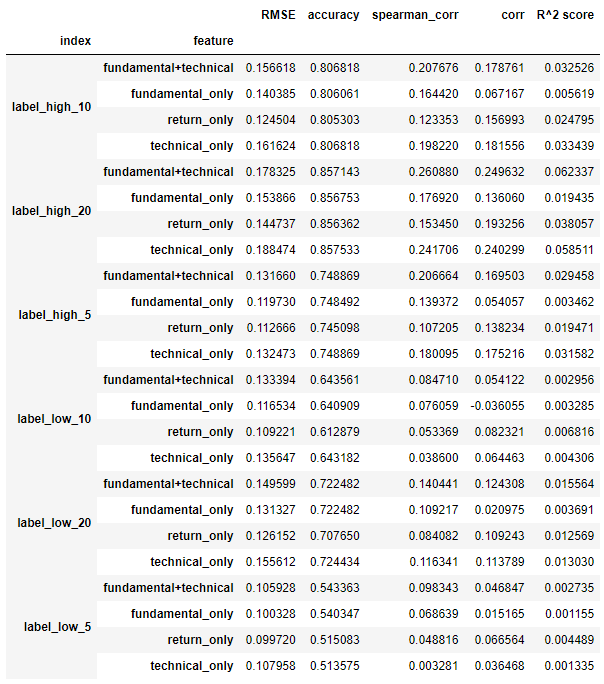
- x-largeのみ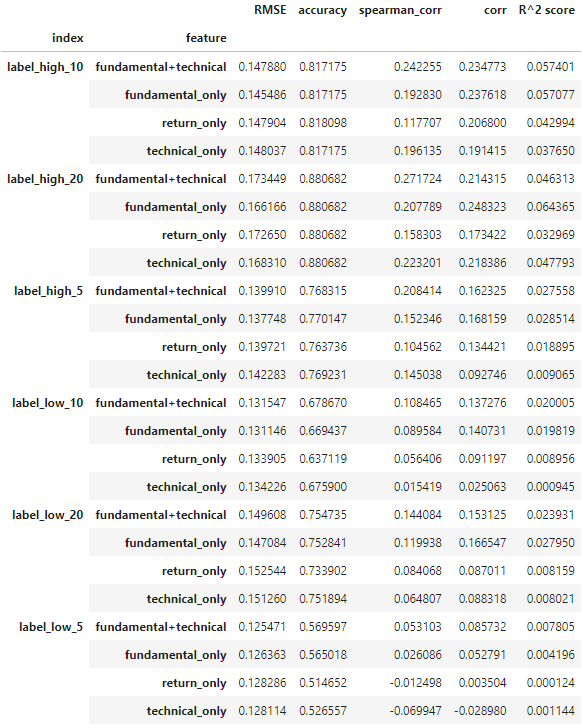
- smallのみ除外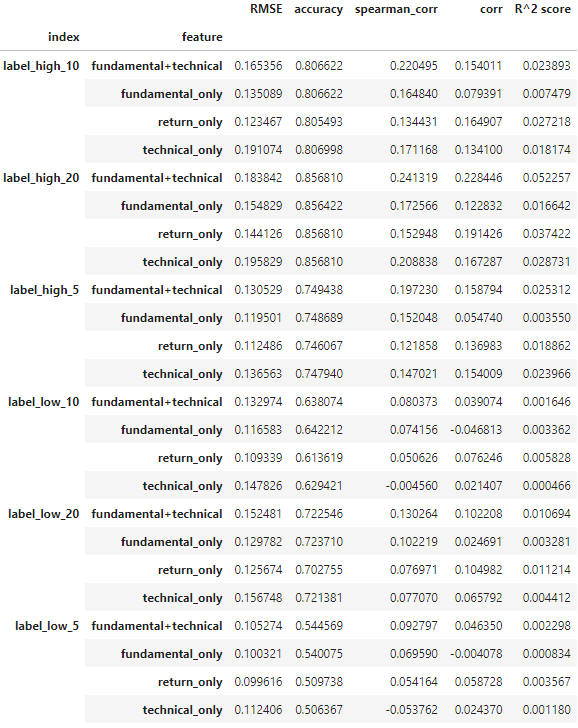
- すべて対象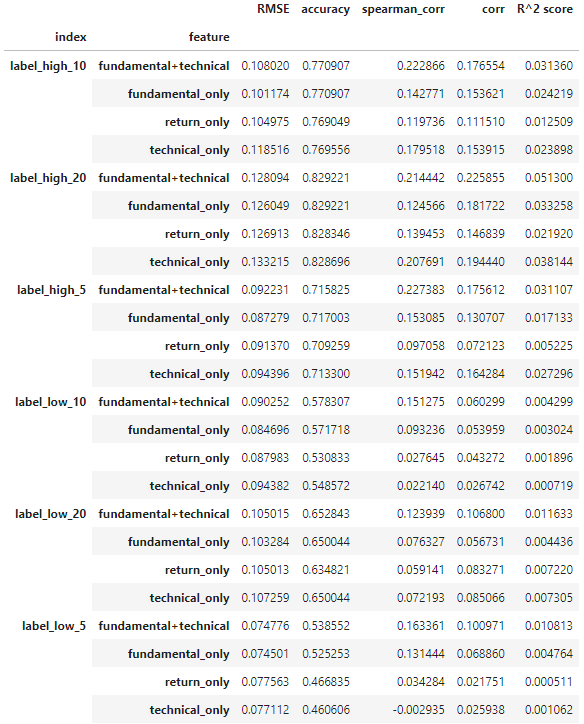

### 今後に向けて
- 売買代金による４区分でもモデルの精度が異なるため、業種やβ等による区分でも精度が異なるのではないかと想定されます。より精度が高い分類が見つかれば、比較的予測しやすい銘柄コードとして優位性の高い取引ができるのではないかと考えます。
- 株価により影響を与えるものとして、前期開示からの増減率や貸借情報等と想定されるため、データを作成して追加してみたいと思います。

In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import shap
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm
import xgboost


# 表示用の設定を変更します
%matplotlib inline

C:\Users\ytomi\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# データの準備
## 日足データ

In [2]:
# 最新の四本値をインポート
list_of_files = glob('*_daily_value.csv') 
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

price = pd.read_csv(latest_file, index_col = 0)
price['code'] = price['code'].astype('int64')
price.index = pd.to_datetime(price.index)
price.tail()

230106_daily_value.csv


High     Low    Open   Close   Volume  Adj Close  code
2023-01-06  1286.0  1270.0  1283.0  1283.0   6100.0        0.0  9993
2023-01-06  2500.0  2480.0  2480.0  2496.0   2900.0        0.0  9994
2023-01-06   423.0   418.0   418.0   423.0  26400.0        0.0  9995
2023-01-06  1145.0  1132.0  1142.0  1142.0   1500.0        0.0  9996
2023-01-06   673.0   669.0   670.0   672.0  78500.0        0.0  9997

In [3]:
%%time
price20 = pd.read_csv('2020_daily_value.csv', index_col = 0)
price20.index = pd.to_datetime(price20.index)
price19 = pd.read_csv('2019_daily_value.csv', index_col = 0)
price19.index = pd.to_datetime(price19.index)
price18 = pd.read_csv('2018_daily_value.csv', index_col = 0)
price18.index = pd.to_datetime(price18.index)
price17 = pd.read_csv('2017_daily_value.csv', index_col = 0)
price17.index = pd.to_datetime(price17.index)
price16 = pd.read_csv('2016_daily_value.csv', index_col = 0)
price16.index = pd.to_datetime(price16.index)

Wall time: 4.89 s


In [4]:
price =  pd.concat([price, price20], axis = 0)
price =  pd.concat([price, price19], axis = 0)
price =  pd.concat([price, price18], axis = 0)
price =  pd.concat([price, price17], axis = 0)
price =  pd.concat([price, price16], axis = 0)
price['code'] = price['code'].astype('int64')
price.sort_index(inplace = True)
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5946583 entries, 2016-01-04 to 2023-01-06
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   High       float64
 1   Low        float64
 2   Open       float64
 3   Close      float64
 4   Volume     float64
 5   Adj Close  float64
 6   code       int64  
dtypes: float64(6), int64(1)
memory usage: 363.0 MB


In [5]:
price.index.min()

Timestamp('2016-01-04 00:00:00')

## 目的変数の作成

In [6]:
stock_labels = price[['code', 'Close', 'High', 'Low']].copy()
stock_labels['label_date_5'] = stock_labels.index + pd.offsets.BDay(5)
stock_labels.head()

code   Close    High     Low label_date_5
2016-01-04  2659  5340.0  5530.0  5330.0   2016-01-11
2016-01-04  5411  1921.0  1985.0  1900.5   2016-01-11
2016-01-04  7298  1114.0  1132.0  1110.0   2016-01-11
2016-01-04  5423   755.0   774.0   742.0   2016-01-11
2016-01-04  2762   925.0   930.0   925.0   2016-01-11

In [7]:
columns = ['code', 'label_date_5', 'label_high_5', 'label_low_5', 'label_date_10', 'label_high_10', 'label_low_10', 'label_date_20', 'label_high_20', 'label_low_20']
stock_labels = pd.DataFrame(columns=columns)
stock_labels

Empty DataFrame
Columns: [code, label_date_5, label_high_5, label_low_5, label_date_10, label_high_10, label_low_10, label_date_20, label_high_20, label_low_20]
Index: []

In [8]:
%%time
codes = price['code'].unique()
for code in codes:
    
    labels_tmp = price[price['code'] == code].copy()

    labels_tmp['label_date_5'] = labels_tmp.index + pd.offsets.BDay(5)
    labels_tmp['label_date_10'] = labels_tmp.index + pd.offsets.BDay(10)
    labels_tmp['label_date_20'] = labels_tmp.index + pd.offsets.BDay(20)

    n = 5
    labels_tmp['High_5'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_5'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_5'] = ( labels_tmp['High_5'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_5'] = ( labels_tmp['Low_5'] / labels_tmp['Close']) - 1

    n = 10
    labels_tmp['High_10'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_10'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_10'] = ( labels_tmp['High_10'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_10'] = ( labels_tmp['Low_10'] / labels_tmp['Close']) - 1

    n = 20
    labels_tmp['High_20'] = labels_tmp['High'].rolling(n).max().shift(-n)
    labels_tmp['Low_20'] =labels_tmp['Low'].rolling(n).max().shift(-n)
    labels_tmp['label_high_20'] = ( labels_tmp['High_20'] / labels_tmp['Close']) - 1
    labels_tmp['label_low_20'] = ( labels_tmp['Low_20'] / labels_tmp['Close']) - 1

    stock_labels = pd.concat([stock_labels, labels_tmp[columns]])

Wall time: 24min 23s


In [9]:
stock_labels = pd.read_csv('stock_labels.csv', index_col = 0)
stock_labels.index = pd.to_datetime(stock_labels.index)

In [10]:
stock_labels.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5935419 entries, 2016-01-04 to 2022-12-30
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   code           int64  
 1   label_date_5   object 
 2   label_high_5   float64
 3   label_low_5    float64
 4   label_date_10  object 
 5   label_high_10  float64
 6   label_low_10   float64
 7   label_date_20  object 
 8   label_high_20  float64
 9   label_low_20   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 498.1+ MB


In [11]:
stock_labels.head()

code label_date_5  label_high_5  label_low_5 label_date_10  \
2016-01-04  8107   2016-01-11           0.0       -0.125    2016-01-18   
2016-01-05  8107   2016-01-12           0.0       -0.125    2016-01-19   
2016-01-06  8107   2016-01-13           0.0       -0.125    2016-01-20   
2016-01-07  8107   2016-01-14           0.0       -0.125    2016-01-21   
2016-01-08  8107   2016-01-15           0.0       -0.125    2016-01-22   

            label_high_10  label_low_10 label_date_20  label_high_20  \
2016-01-04            0.0        -0.125    2016-02-01            0.0   
2016-01-05            0.0        -0.125    2016-02-02            0.0   
2016-01-06            0.0        -0.125    2016-02-03            0.0   
2016-01-07            0.0        -0.125    2016-02-04            0.0   
2016-01-08            0.0        -0.125    2016-02-05            0.0   

            label_low_20  
2016-01-04        -0.125  
2016-01-05        -0.125  
2016-01-06        -0.125  
2016-01-07        -0.125  
2016-01-08        -0.125

In [12]:
stock_labels.tail()

code label_date_5  label_high_5  label_low_5 label_date_10  \
2022-12-26  4447   2023-01-02           NaN          NaN    2023-01-09   
2022-12-27  4447   2023-01-03           NaN          NaN    2023-01-10   
2022-12-28  4447   2023-01-04           NaN          NaN    2023-01-11   
2022-12-29  4447   2023-01-05           NaN          NaN    2023-01-12   
2022-12-30  4447   2023-01-06           NaN          NaN    2023-01-13   

            label_high_10  label_low_10 label_date_20  label_high_20  \
2022-12-26            NaN           NaN    2023-01-23            NaN   
2022-12-27            NaN           NaN    2023-01-24            NaN   
2022-12-28            NaN           NaN    2023-01-25            NaN   
2022-12-29            NaN           NaN    2023-01-26            NaN   
2022-12-30            NaN           NaN    2023-01-27            NaN   

            label_low_20  
2022-12-26           NaN  
2022-12-27           NaN  
2022-12-28           NaN  
2022-12-29           NaN  
2022-12-30           NaN

## 銘柄コードデータを使用した除外

In [13]:
stock_list = pd.read_excel("./data_j.xls")
stock_list.loc[stock_list["市場・商品区分"]=="市場第一部（内国株）",
              ["コード","銘柄名","33業種コード","33業種区分","規模コード","規模区分"]
             ]
stock_list

日付   コード                                   銘柄名       市場・商品区分  \
0     20221230  1301                                    極洋    プライム（内国株式）   
1     20221230  1305                         ダイワ上場投信－トピックス       ETF・ETN   
2     20221230  1306               ＮＥＸＴ　ＦＵＮＤＳ　ＴＯＰＩＸ連動型上場投信       ETF・ETN   
3     20221230  1308                     上場インデックスファンドＴＯＰＩＸ       ETF・ETN   
4     20221230  1309  ＮＥＸＴ　ＦＵＮＤＳ　ＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信       ETF・ETN   
...        ...   ...                                   ...           ...   
4241  20221230  9993                                  ヤマザワ  スタンダード（内国株式）   
4242  20221230  9994                                   やまや  スタンダード（内国株式）   
4243  20221230  9995                                 グローセル    プライム（内国株式）   
4244  20221230  9996                                 サトー商会  スタンダード（内国株式）   
4245  20221230  9997                                  ベルーナ    プライム（内国株式）   

     33業種コード  33業種区分 17業種コード  17業種区分 規模コード           規模区分  
0         50  水産・農林業       1     食品      7  TOPIX Small 2  
1          -       -       -       -     -              -  
2          -       -       -       -     -              -  
3          -       -       -       -     -              -  
4          -       -       -       -     -              -  
...      ...     ...     ...     ...   ...            ...  
4241    6100     小売業      14     小売      7  TOPIX Small 2  
4242    6100     小売業      14     小売      7  TOPIX Small 2  
4243    6050     卸売業      13  商社・卸売      7  TOPIX Small 2  
4244    6050     卸売業      13  商社・卸売      -              -  
4245    6100     小売業      14     小売      6  TOPIX Small 1  

[4246 rows x 10 columns]

In [14]:
stock_list = stock_list.rename(columns={'コード': 'code', '銘柄名':'Name', '市場・商品区分':'Section/Products',
                                       '33業種コード':'33 Sector(Code)', '33業種区分':'33 Sector(name)', 
                                       '17業種コード':'17 Sector(Code)', '17業種区分':'17 Sector(name)',
                                       '規模コード':'Size Code (New Index Series)', '規模区分':'Size (New Index Series)',
                                       '日付':'IssuedShareEquityQuote ModifyDate'})

直近25日間に絞って売買代金でビニング処理し「'small', 'medium', 'large', 'x-large'」の４つに分類します。売買代金を正確に求めるには「VWAP」が必要ですが、今回用いるAPIに存在しないため、「（始値 + 終値）/ 2 」で代用し、これに出来高を掛けて求めます。

In [15]:
price25 = price[price.index >= price.index.unique()[-25]].copy()

In [16]:
price25['TradeValue'] = (price25['Open'] + price25['Close'])/2 * price25['Volume']
price25['UpDown'] = price25['Close'] - price25['Open']
price25['UpDownRatio'] = price25['Close'] / price25['Open']
np.seterr(divide='ignore')  # 0除算のRuntimeWarningのみを無視扱いとする
price25['UpDownRatioLog'] =np.log10(price25['UpDownRatio'])

# 25間の平均volumeを求める
price25 = price25.groupby('code').mean()
price25.head()

High      Low     Open    Close     Volume  Adj Close   TradeValue  \
code                                                                          
1301  3727.60  3672.20  3702.00  3702.00    14892.0        0.0   55181180.0   
1332   534.72   528.04   531.40   531.92  1283880.0        0.0  681675828.0   
1333  2455.84  2424.16  2442.44  2443.24   156784.0        0.0  383239348.0   
1375  1001.40   990.76   997.12   995.64    68140.0        0.0   67809324.0   
1376  1430.80  1405.36  1421.36  1417.12    14188.0        0.0   20271090.0   

      UpDown  UpDownRatio  UpDownRatioLog  
code                                       
1301    0.00     1.000046       -0.000007  
1332    0.52     1.000995        0.000421  
1333    0.80     1.000356        0.000143  
1375   -1.48     0.998552       -0.000644  
1376   -4.24     0.997147       -0.001280

In [17]:
price25['Volume_bin'] = pd.qcut(price25['TradeValue'], 4, 
                    labels=['small', 'medium', 'large', 'x-large'])
price25.head()

High      Low     Open    Close     Volume  Adj Close   TradeValue  \
code                                                                          
1301  3727.60  3672.20  3702.00  3702.00    14892.0        0.0   55181180.0   
1332   534.72   528.04   531.40   531.92  1283880.0        0.0  681675828.0   
1333  2455.84  2424.16  2442.44  2443.24   156784.0        0.0  383239348.0   
1375  1001.40   990.76   997.12   995.64    68140.0        0.0   67809324.0   
1376  1430.80  1405.36  1421.36  1417.12    14188.0        0.0   20271090.0   

      UpDown  UpDownRatio  UpDownRatioLog Volume_bin  
code                                                  
1301    0.00     1.000046       -0.000007      large  
1332    0.52     1.000995        0.000421    x-large  
1333    0.80     1.000356        0.000143    x-large  
1375   -1.48     0.998552       -0.000644      large  
1376   -4.24     0.997147       -0.001280     medium

In [18]:
large_v_code = price25[(price25['Volume_bin'] == 'x-large') | (price25['Volume_bin'] == 'large')].index.tolist()
print('売買代金が中央値以上の銘柄数：{}'.format(len(large_v_code)))

売買代金が中央値以上の銘柄数：1903


In [19]:
# 該当期間のデータが不足するもの≒（全期間-20日分未満しかないもの）をカット
x = len(price[price['code'] == 1301].index.unique()) - 20
price_group = price.groupby('code').count()
plentry_list = price_group[price_group['High'] >= x].index
print(len(plentry_list))

stock_list['prediction_target'] = ((stock_list['Section/Products'] == 'プライム（内国株式）') |(stock_list['Section/Products'] == 'スタンダード（内国株式）') | (stock_list['Section/Products'] == 'グロース（内国株式）')) & (stock_list['code'].isin(plentry_list) & (stock_list['code'].isin(large_v_code)))

2886


In [20]:
# 後続処理でエラーになったものをFalse
stock_list.loc[stock_list['code'] == 6328, 'prediction_target'] = False #財務情報にNaNが多くてエラー
stock_list.loc[stock_list['code'] == 9960, 'prediction_target'] = False #財務情報にNaNが多くてエラー
stock_list[(stock_list['code'] == 6328)|(stock_list['code'] == 9960)]

IssuedShareEquityQuote ModifyDate  code  Name Section/Products  \
2454                           20221230  6328  荏原実業       プライム（内国株式）   
4220                           20221230  9960   東テク       プライム（内国株式）   

     33 Sector(Code) 33 Sector(name) 17 Sector(Code) 17 Sector(name)  \
2454            3600              機械               8             機械    
4220            6050             卸売業              13          商社・卸売    

     Size Code (New Index Series) Size (New Index Series)  prediction_target  
2454                            7           TOPIX Small 2              False  
4220                            7           TOPIX Small 2              False

In [21]:
stock_list[stock_list['prediction_target'] == True]

IssuedShareEquityQuote ModifyDate  code         Name Section/Products  \
0                              20221230  1301           極洋       プライム（内国株式）   
18                             20221230  1332         ニッスイ       プライム（内国株式）   
19                             20221230  1333       マルハニチロ       プライム（内国株式）   
37                             20221230  1377       サカタのタネ       プライム（内国株式）   
38                             20221230  1379          ホクト       プライム（内国株式）   
...                                 ...   ...          ...              ...   
4234                           20221230  9983  ファーストリテイリング       プライム（内国株式）   
4235                           20221230  9984   ソフトバンクグループ       プライム（内国株式）   
4237                           20221230  9987         スズケン       プライム（内国株式）   
4238                           20221230  9989       サンドラッグ       プライム（内国株式）   
4245                           20221230  9997         ベルーナ       プライム（内国株式）   

     33 Sector(Code) 33 Sector(name) 17 Sector(Code) 17 Sector(name)  \
0                 50          水産・農林業               1             食品    
18                50          水産・農林業               1             食品    
19                50          水産・農林業               1             食品    
37                50          水産・農林業               1             食品    
38                50          水産・農林業               1             食品    
...              ...             ...             ...             ...   
4234            6100             小売業              14             小売    
4235            5250          情報・通信業              10   情報通信・サービスその他    
4237            6050             卸売業              13          商社・卸売    
4238            6100             小売業              14             小売    
4245            6100             小売業              14             小売    

     Size Code (New Index Series) Size (New Index Series)  prediction_target  
0                               7           TOPIX Small 2               True  
18                              4            TOPIX Mid400               True  
19                              4            TOPIX Mid400               True  
37                              6           TOPIX Small 1               True  
38                              6           TOPIX Small 1               True  
...                           ...                     ...                ...  
4234                            2           TOPIX Large70               True  
4235                            1            TOPIX Core30               True  
4237                            4            TOPIX Mid400               True  
4238                            4            TOPIX Mid400               True  
4245                            6           TOPIX Small 1               True  

[1561 rows x 11 columns]

## 財務データの準備
予め[J-QuantsAPI](https://jpx.gitbook.io/j-quants-api/api-reference/finance-api)を用いて取得したデータを「yyyymmdd_finance.csv」として保存しておきます。

In [22]:
# 最新の財務情報をインポート
'''
[ToDo] 開示日が重複し、各種カラムの値が異なって存在するのはなぜか。適時開示の内容とAPIを照合して確認する。
'''
list_of_files = glob('findata/' + '*_finance.csv') 
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

fin_raw = pd.read_csv(latest_file, index_col = 0)
fin_raw['code'] = fin_raw['code'].astype('int64')
fin_raw = fin_raw.set_index('DisclosedDate')

# TypeOfCurrentPeriodがNullのものを削除←開示日が重複して存在するため
print(len(fin_raw))
print(len(fin_raw[~fin_raw['TypeOfCurrentPeriod'].isnull()]))
fin_raw = fin_raw[~fin_raw['TypeOfCurrentPeriod'].isnull()]

# Profitが0またはnullのものを削除←開示日が重複して存在するため
print(len(fin_raw[(fin_raw['Profit'] == 0) | (fin_raw['Profit'].isnull())]))
fin_raw = fin_raw[(fin_raw['Profit'] != 0.0) & (~fin_raw['Profit'].isnull())]
# Profitが0またはnullのものを削除←開示日が重複して存在するため
print(len(fin_raw[(fin_raw['BookValuePerShare'] == 0) | (fin_raw['BookValuePerShare'].isnull())]))
fin_raw = fin_raw[(fin_raw['BookValuePerShare'] != 0.0) & (~fin_raw['BookValuePerShare'].isnull())]

fin_raw['NetSales'] = fin_raw['NetSales'].astype('float')
fin_raw['OperatingProfit'] = fin_raw['OperatingProfit'].astype('float')
fin_raw['Profit'] = fin_raw['Profit'].astype('float')
fin_raw['TotalAssets'] = fin_raw['TotalAssets'].astype('float')

fin_raw['AverageNumberOfShares'] = fin_raw['AverageNumberOfShares'].astype('float')
fin_raw['BookValuePerShare'] = fin_raw['BookValuePerShare'].astype('float')
fin_raw['EarningsPerShare'] = fin_raw['EarningsPerShare'].astype('float')
fin_raw['Equity'] = fin_raw['Equity'].astype('float')
fin_raw['EquityToAssetRatio'] = fin_raw['EquityToAssetRatio'].astype('float')
fin_raw['ForecastDividendPerShareAnnual'] = fin_raw['ForecastDividendPerShareAnnual'].astype('float')
fin_raw['ForecastNetSales'] = fin_raw['ForecastNetSales'].astype('float')
fin_raw['ForecastOperatingProfit'] = fin_raw['ForecastOperatingProfit'].astype('float')
fin_raw['ForecastOrdinaryProfit'] = fin_raw['ForecastOrdinaryProfit'].astype('float')
fin_raw['ForecastProfit'] = fin_raw['ForecastProfit'].astype('float')
fin_raw['NumberOfTreasuryStockAtTheEndOfFiscalYear'] = fin_raw['NumberOfTreasuryStockAtTheEndOfFiscalYear'].astype('float')
fin_raw['OperatingProfit'] = fin_raw['OperatingProfit'].astype('float')
fin_raw['OrdinaryProfit'] = fin_raw['OrdinaryProfit'].astype('float')
fin_raw['Profit'] = fin_raw['Profit'].astype('float')

fin_raw.tail()

findata\230106_finance.csv


Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


104890
104890
19226
45943


Profit ForecastDividendPerShare1stQuarter  \
DisclosedDate                                                    
2018-05-11     9.665000e+09                                  －   
2019-05-13     1.034300e+10                                  －   
2020-05-13     5.862000e+09                                  －   
2021-05-13     1.103600e+10                                  －   
2022-05-13     1.020400e+10                                  －   

              ForecastDividendPerShareFiscalYearEnd  \
DisclosedDate                                         
2018-05-11                                      7.5   
2019-05-13                                      8.0   
2020-05-13                                      8.0   
2021-05-13                                      9.5   
2022-05-13                                     10.0   

              NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock  \
DisclosedDate                                                                                
2018-05-11                                            97236456.0                             
2019-05-13                                            97244472.0                             
2020-05-13                                            97244472.0                             
2021-05-13                                            97244472.0                             
2022-05-13                                            97244472.0                             

               ForecastDividendPerShareAnnual  ForecastNetSales  \
DisclosedDate                                                     
2018-05-11                               15.0      1.800000e+11   
2019-05-13                               16.0      1.850000e+11   
2020-05-13                               16.0      1.750000e+11   
2021-05-13                               19.0      2.460000e+11   
2022-05-13                               20.0      2.190000e+11   

              ChangesBasedOnRevisionsOfAccountingStandard  \
DisclosedDate                                               
2018-05-11                                          False   
2019-05-13                                          False   
2020-05-13                                          False   
2021-05-13                                          False   
2022-05-13                                           True   

              ResultDividendPerShareFiscalYearEnd CurrentFiscalYearStartDate  \
DisclosedDate                                                                  
2018-05-11                                   6.25                 2017-04-01   
2019-05-13                                    7.5                 2018-04-01   
2020-05-13                                    8.0                 2019-04-01   
2021-05-13                                    8.5                 2020-04-01   
2022-05-13                                    9.5                 2021-04-01   

              MaterialChangesInSubsidiaries  ...        Equity      NetSales  \
DisclosedDate                                ...                               
2018-05-11                            False  ...  9.305800e+10  1.616730e+11   
2019-05-13                             True  ...  1.005330e+11  1.776480e+11   
2020-05-13                            False  ...  1.025250e+11  1.799480e+11   
2021-05-13                            False  ...  1.132310e+11  2.064990e+11   
2022-05-13                            False  ...  1.190440e+11  2.201280e+11   

              ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard  \
DisclosedDate                                                            
2018-05-11                                                 False         
2019-05-13                                                 False         
2020-05-13                                                 False         
2021-05-13                                                 False         
2022-05-13                                       

In [23]:
fin = pd.DataFrame(columns = fin_raw.columns)
fin

Empty DataFrame
Columns: [Profit, ForecastDividendPerShare1stQuarter, ForecastDividendPerShareFiscalYearEnd, NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock, ForecastDividendPerShareAnnual, ForecastNetSales, ChangesBasedOnRevisionsOfAccountingStandard, ResultDividendPerShareFiscalYearEnd, CurrentFiscalYearStartDate, MaterialChangesInSubsidiaries, AverageNumberOfShares, OrdinaryProfit, ChangesInAccountingEstimates, ForecastDividendPerShare3rdQuarter, CurrentFiscalYearEndDate, CurrentPeriodEndDate, ForecastDividendPerShare2ndQuarter, EquityToAssetRatio, TotalAssets, OperatingProfit, DisclosureNumber, ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements, ForecastEarningsPerShare, NumberOfTreasuryStockAtTheEndOfFiscalYear, ResultDividendPerShare2ndQuarter, LocalCode, TypeOfDocument, ForecastOperatingProfit, ResultDividendPerShareAnnual, ForecastOrdinaryProfit, ForecastProfit, EarningsPerShare, DisclosedUnixTime, Equity, NetSales, ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard, ResultDividendPerShare3rdQuarter, BookValuePerShare, ResultDividendPerShare1stQuarter, TypeOfCurrentPeriod, DisclosedTime, RetrospectiveRestatement, code]
Index: []

[0 rows x 43 columns]

In [24]:
# 同一銘柄で同一開示日があった場合、時間帯が後の方を採用
print(len(fin_raw))

codes = fin_raw['code'].unique()
# codes = [1301, 1780]
for code in codes:
    fin_tmp = fin_raw[fin_raw['code']==code]
    fin_tmp = fin_tmp.sort_values('DisclosedTime').sort_index()
    # datetime型だと処理できないのでobject型のまま
    fin_tmp = fin_tmp[~fin_tmp.index.duplicated(keep='first')]
    fin = pd.concat([fin, fin_tmp])

39721


使用しないカラムは落とす

In [25]:
fin.index = pd.to_datetime(fin.index)
fin.drop(['DisclosedUnixTime'], axis=1, inplace=True)
fin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39471 entries, 2017-05-11 to 2022-05-13
Data columns (total 42 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Profit                                                                        39471 non-null  float64
 1   ForecastDividendPerShare1stQuarter                                            21543 non-null  object 
 2   ForecastDividendPerShareFiscalYearEnd                                         39241 non-null  object 
 3   NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock  39467 non-null  object 
 4   ForecastDividendPerShareAnnual                                                34026 non-null  float64
 5   ForecastNetSales                                                              34817 non-null  float64
 6   ChangesBasedO

In [26]:
fin.index.unique().sort_values()

DatetimeIndex(['2017-01-04', '2017-01-05', '2017-01-06', '2017-01-10',
               '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
               '2017-01-17', '2017-01-19',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-26', '2022-12-27',
               '2022-12-28', '2023-01-05'],
              dtype='datetime64[ns]', length=1355, freq=None)

# EDA

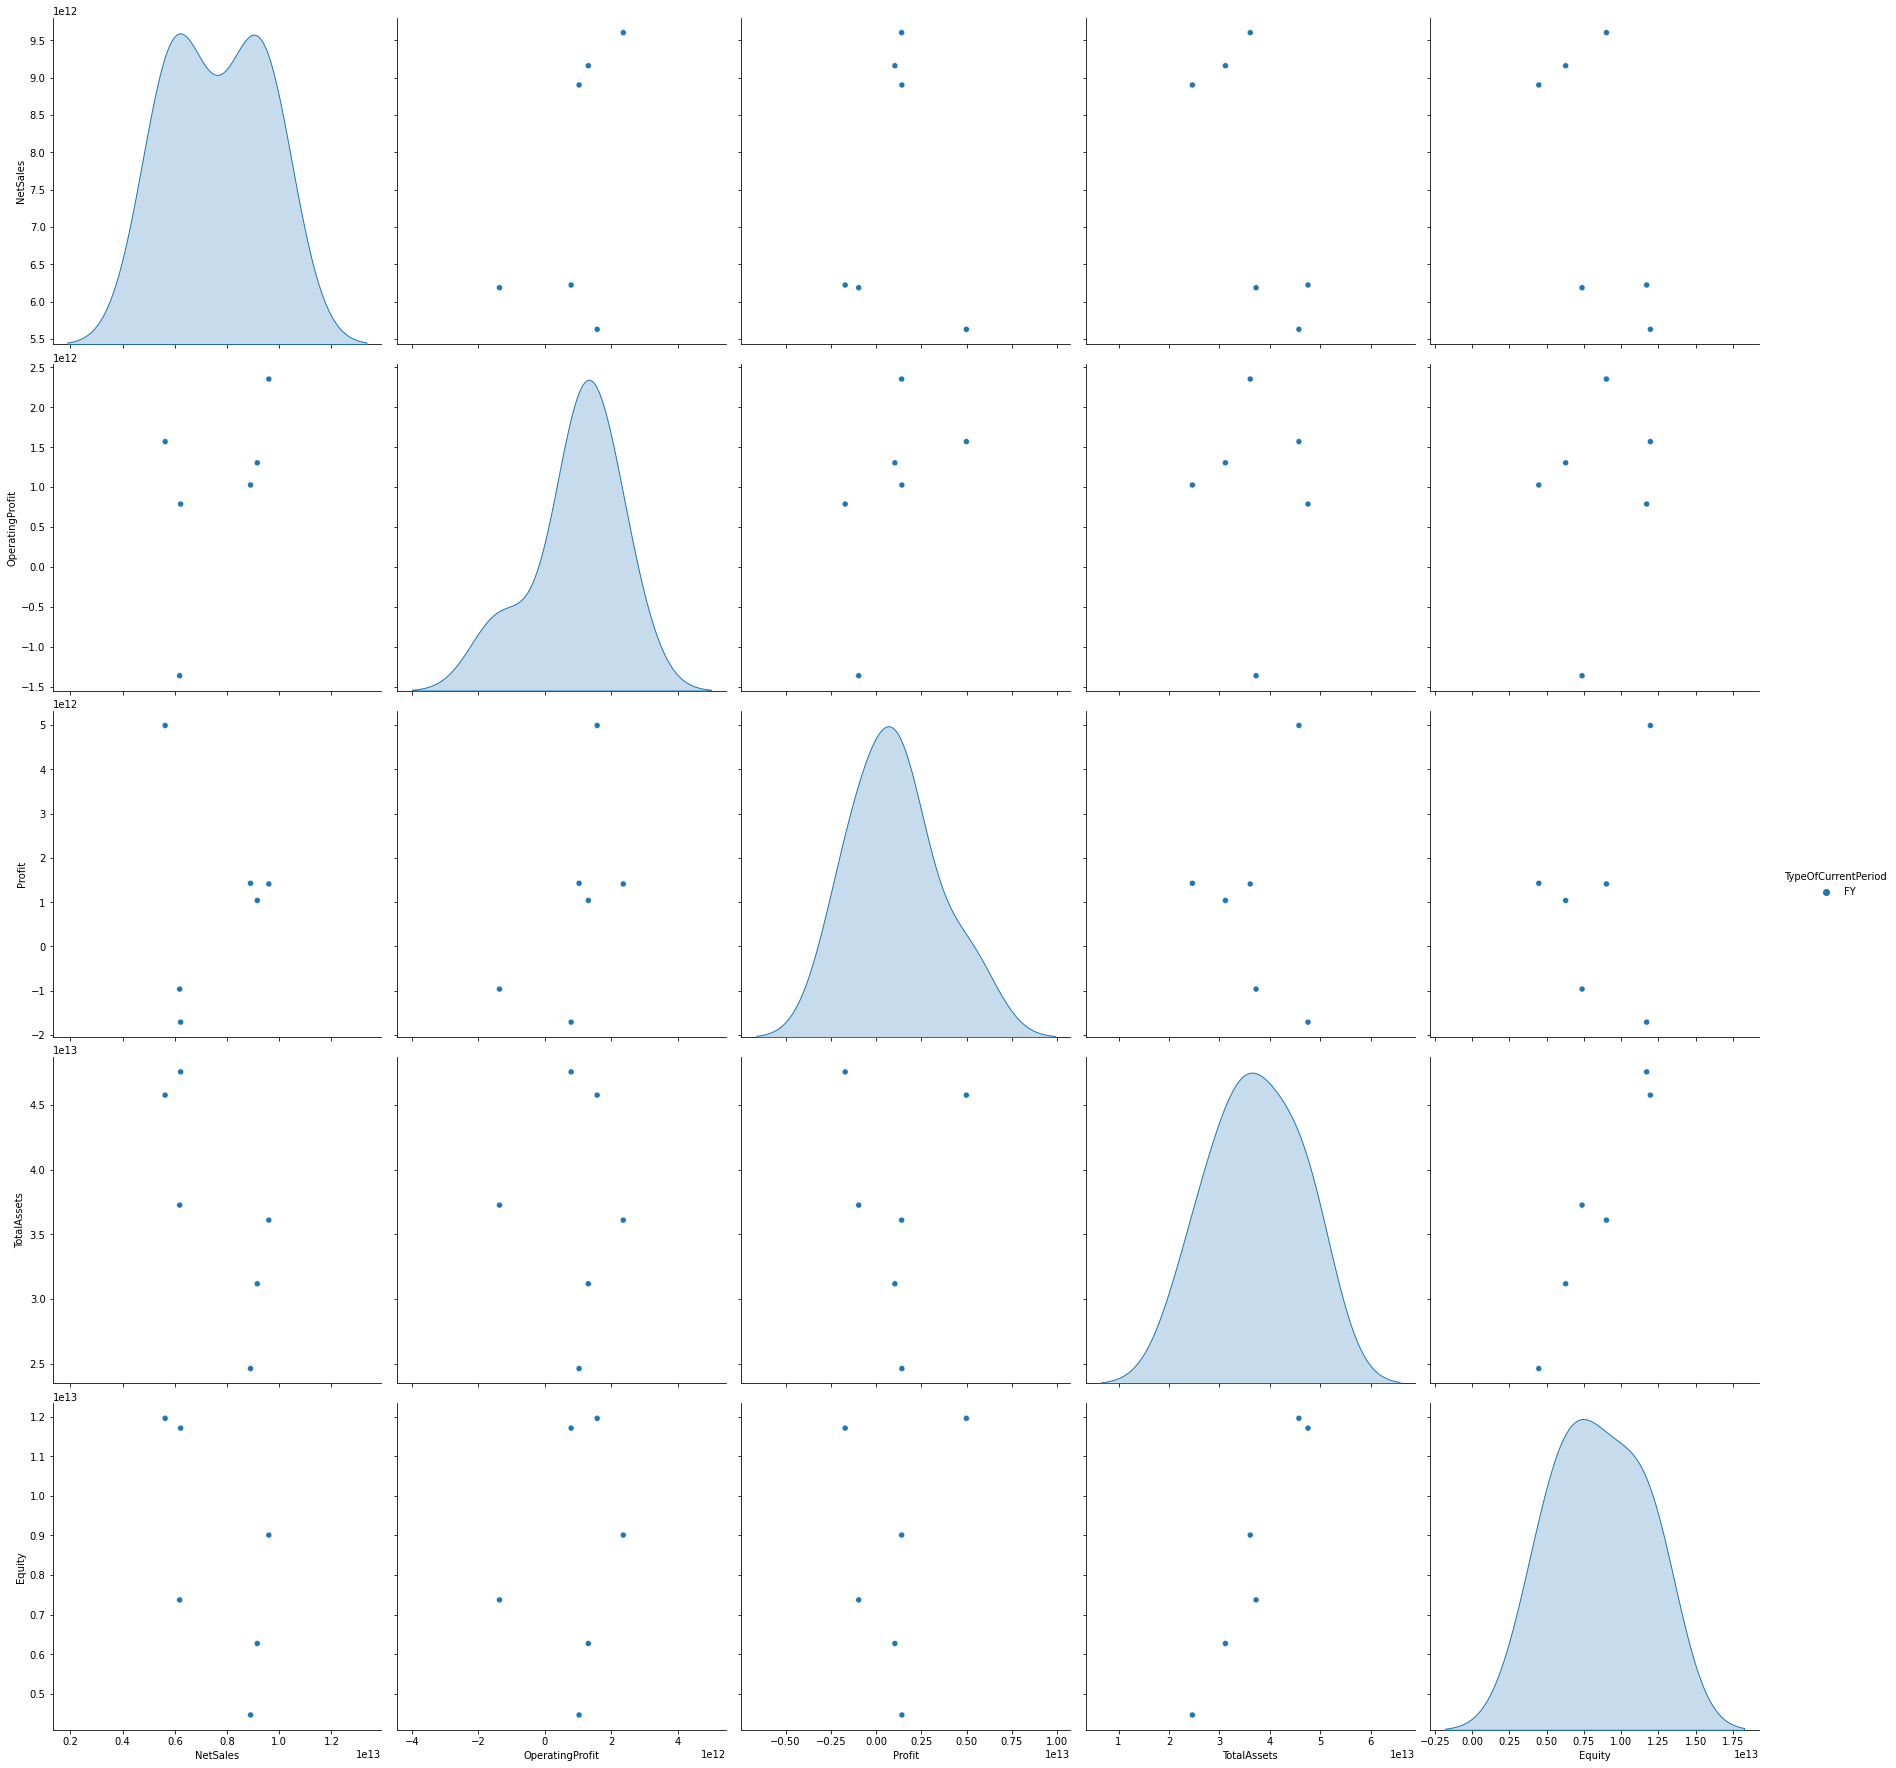

In [27]:
# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["code"] == code]

# 2019年までの値を表示
# fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "NetSales",# 売上高
    "OperatingProfit",  # 営業利益
    "Profit",  # 純利益
    "TotalAssets",  # 純資産
    "TypeOfCurrentPeriod",  # 決算期
    "Equity"
]

# fin_data = fin_data[columns].dropna()

# プロット
sns.pairplot(fin_data[columns], hue="TypeOfCurrentPeriod", height=5)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


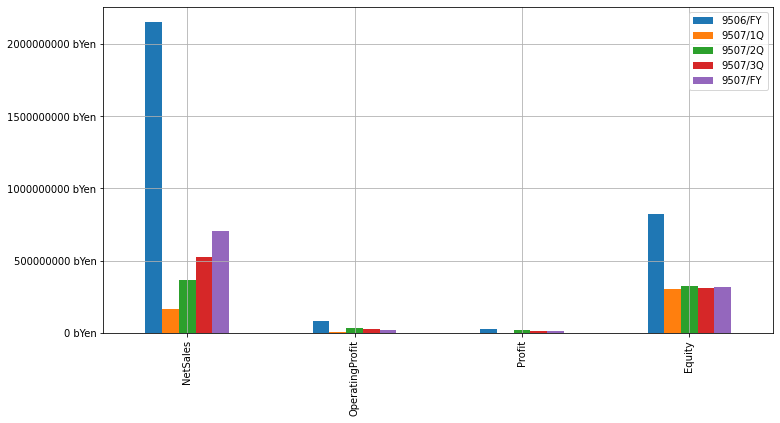

In [28]:
codes = [9506, 9507]

multi_df = dict()

# プロット対象を定義
columns = [
    "NetSales",# 売上高
    "OperatingProfit",  # 営業利益
    "Profit",  # 純利益
    "TypeOfCurrentPeriod",  # 決算期
    "Equity"
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["code"] == code]
    # 2019年までの値を表示
#     fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "code",
            "CurrentFiscalYearEndDate",
            "TypeOfCurrentPeriod"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("TypeOfCurrentPeriod").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


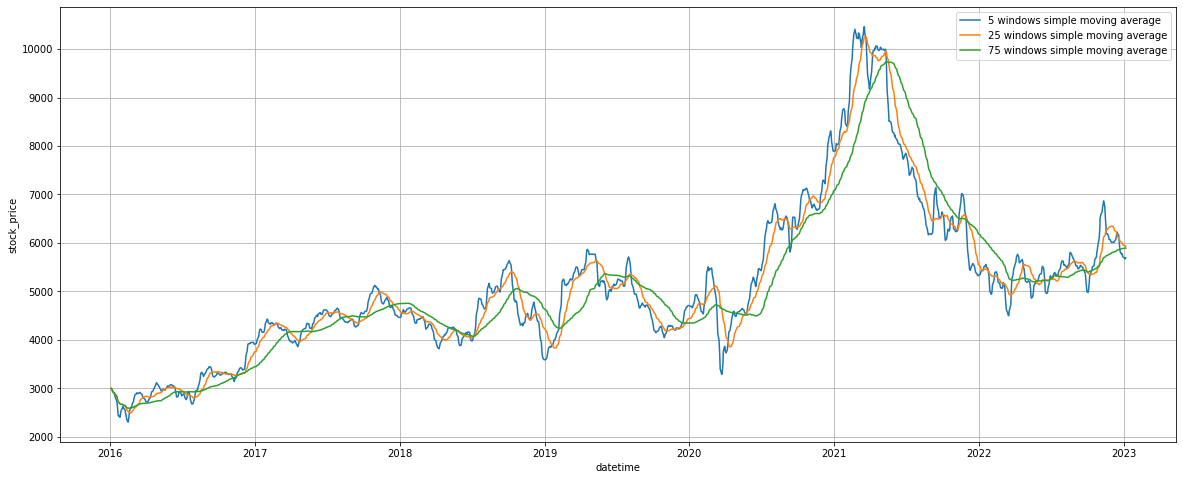

In [29]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Close"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


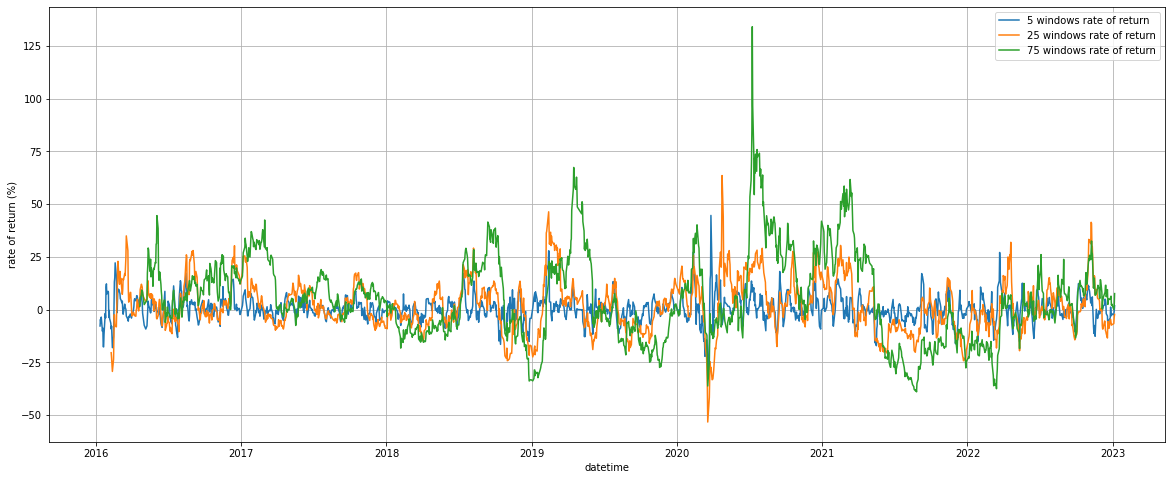

In [30]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["Close"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


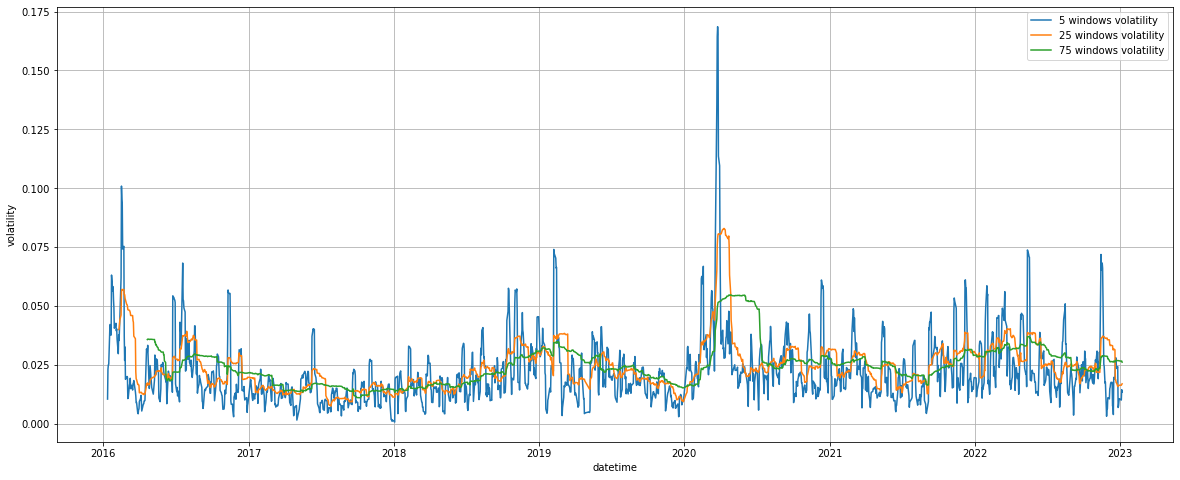

In [31]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["code"] == code]

# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["Close"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

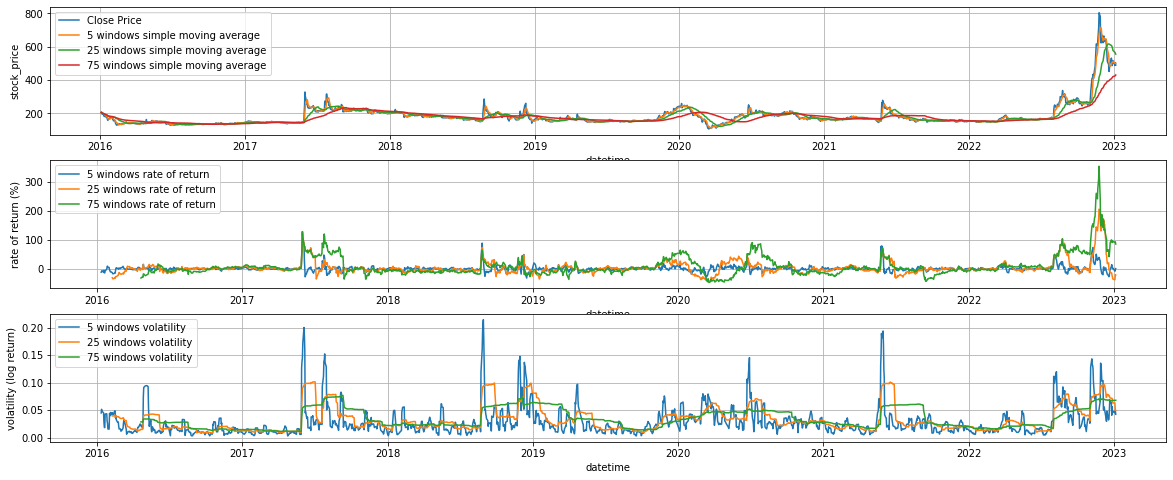

In [32]:
# 特定の銘柄コードに絞り込み
code = 7859
price_data = price[price["code"] == code].copy()

# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Close"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["Close"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["Close"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["Close"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

(39471, 42)
Profit                                                                              0
ForecastDividendPerShare1stQuarter                                              17928
ForecastDividendPerShareFiscalYearEnd                                             230
NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock        4
ForecastDividendPerShareAnnual                                                   5445
ForecastNetSales                                                                 4654
ChangesBasedOnRevisionsOfAccountingStandard                                         7
ResultDividendPerShareFiscalYearEnd                                             17775
CurrentFiscalYearStartDate                                                          0
MaterialChangesInSubsidiaries                                                    5002
AverageNumberOfShares                                                               4
OrdinaryProfit                            

<AxesSubplot:ylabel='year'>

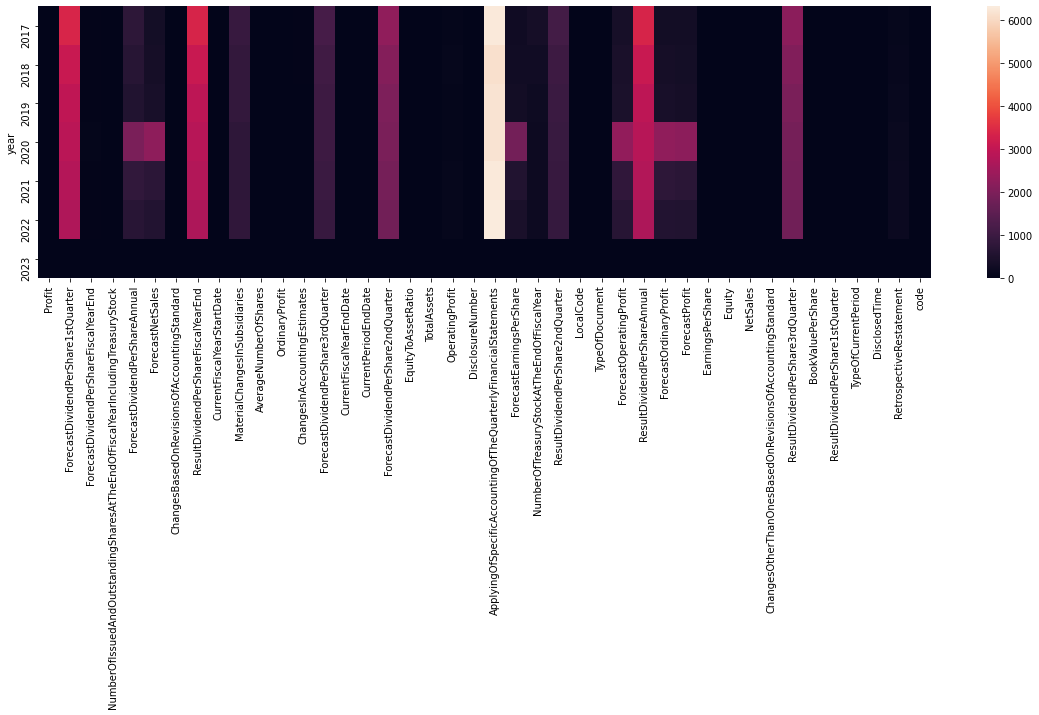

In [33]:
# 欠損値の確認
# データ数の確認
print(fin.shape)

# データの欠損値数を確認
print(fin.isna().sum())


# 欠損値の数を年別に集計
stock_fin = fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [34]:
# 欠損値を0でフィル
fin = fin.fillna(0)

## データの前処理
### 目的変数を開示日に絞る

In [35]:
stock_labels_new = pd.DataFrame(columns=stock_labels.columns)
stock_labels_new

Empty DataFrame
Columns: [code, label_date_5, label_high_5, label_low_5, label_date_10, label_high_10, label_low_10, label_date_20, label_high_20, label_low_20]
Index: []

In [36]:
%%time
codes = stock_list.loc[stock_list['prediction_target'] == True, 'code'].unique()

for code in codes:
    stock_labels_tmp = stock_labels[stock_labels['code']==code]
    fin_tmp = fin[fin['code']==code]
    stock_labels_tmp = stock_labels_tmp[stock_labels_tmp.index.isin(fin.index)]
    stock_labels_new = pd.concat([stock_labels_new, stock_labels_tmp])

stock_labels_new

Wall time: 7min 41s


code label_date_5  label_high_5  label_low_5 label_date_10  \
2017-01-04  1301   2017-01-11      0.004376    -0.001823    2017-01-18   
2017-01-05  1301   2017-01-12      0.005844    -0.000365    2017-01-19   
2017-01-06  1301   2017-01-13      0.005109    -0.001095    2017-01-20   
2017-01-10  1301   2017-01-17      0.001456    -0.004003    2017-01-24   
2017-01-11  1301   2017-01-18      0.000729    -0.013843    2017-01-25   
...          ...          ...           ...          ...           ...   
2022-12-21  9997   2022-12-28      0.019316     0.002972    2023-01-04   
2022-12-22  9997   2022-12-29      0.014793    -0.001479    2023-01-05   
2022-12-26  9997   2023-01-02           NaN          NaN    2023-01-09   
2022-12-27  9997   2023-01-03           NaN          NaN    2023-01-10   
2022-12-28  9997   2023-01-04           NaN          NaN    2023-01-11   

            label_high_10  label_low_10 label_date_20  label_high_20  \
2017-01-04       0.004376     -0.001823    2017-02-01       0.004376   
2017-01-05       0.005844     -0.000365    2017-02-02       0.005844   
2017-01-06       0.005109     -0.001095    2017-02-03       0.005109   
2017-01-10       0.001456     -0.004003    2017-02-07       0.001456   
2017-01-11       0.000729     -0.007650    2017-02-08       0.000729   
...                   ...           ...           ...            ...   
2022-12-21            NaN           NaN    2023-01-18            NaN   
2022-12-22            NaN           NaN    2023-01-19            NaN   
2022-12-26            NaN           NaN    2023-01-23            NaN   
2022-12-27            NaN           NaN    2023-01-24            NaN   
2022-12-28            NaN           NaN    2023-01-25            NaN   

            label_low_20  
2017-01-04     -0.001823  
2017-01-05     -0.000365  
2017-01-06     -0.001095  
2017-01-10     -0.004003  
2017-01-11     -0.005829  
...                  ...  
2022-12-21           NaN  
2022-12-22           NaN  
2022-12-26           NaN  
2022-12-27           NaN  
2022-12-28           NaN  

[2097988 rows x 10 columns]

In [37]:
print(len(stock_labels))
print(len(stock_labels_new))

5935419
2097988


In [38]:
stock_labels = stock_labels_new.copy()

## 特徴量作成

In [39]:
# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["code"] == code]

# 終値のみに絞る
feats = price_data[["Close", "Volume"]].copy()

# 終値の20営業日リターン
feats["return_1month"] = feats["Close"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["Close"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["Close"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["Close"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["Close"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["Close"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["Close"] / (feats["Close"].rolling(20).mean())
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["Close"] / (feats["Close"].rolling(40).mean())
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["Close"] / (feats["Close"].rolling(60).mean())


# 出来高の20営業日増加率
feats["volume_rate_1month"] = feats["Volume"].pct_change(20)
# 出来高の40営業日増加率
feats["volume_rate_2month"] = feats["Volume"].pct_change(40)
# 出来高の60営業日増加率
feats["volume_rate_3month"] = feats["Volume"].pct_change(60)
with np.errstate(divide='ignore', invalid='ignore'):
    # 出来高の20営業日ボラティリティ
    feats["volume_volatility_1month"] = (
        np.log(feats["Volume"]).diff().rolling(20).std()
    )

    # 出来高の40営業日ボラティリティ
    feats["volume_volatility_2month"] = (
        np.log(feats["Volume"]).diff().rolling(40).std()
    )
    # 出来高の60営業日ボラティリティ
    feats["volume_volatility_3month"] = (
        np.log(feats["Volume"]).diff().rolling(60).std()
    )
    # 出来高と20営業日の単純移動平均線の乖離
    feats["MA_volume_gap_1month"] = feats["Volume"] / (feats["Volume"].rolling(20).mean())
    # 出来高と40営業日の単純移動平均線の乖離
    feats["MA_volume_gap_2month"] = feats["Volume"] / (feats["Volume"].rolling(40).mean())
    # 出来高と60営業日の単純移動平均線の乖離
    feats["MA_volume_gap_3month"] = feats["Volume"] / (feats["Volume"].rolling(60).mean())

# infをNanと扱う
feats = feats.replace([np.inf, -np.inf], np.nan)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["Close", "Volume"], axis=1)

In [40]:
feats.describe()

return_1month  return_2month  return_3month  volatility_1month  \
count    1732.000000    1732.000000    1732.000000        1732.000000   
mean        0.015179       0.029434       0.043254           0.023694   
std         0.109683       0.143376       0.177761           0.011304   
min        -0.497851      -0.448821      -0.406057           0.000000   
25%        -0.051715      -0.075711      -0.075605           0.016813   
50%         0.006905       0.009517       0.021518           0.021213   
75%         0.080556       0.127934       0.148554           0.028285   
max         0.762188       0.667287       1.026796           0.091278   

       volatility_2month  volatility_3month  MA_gap_1month  MA_gap_2month  \
count        1732.000000        1732.000000    1732.000000    1732.000000   
mean            0.023814           0.023649       0.994306       0.988326   
std             0.010253           0.009789       0.121057       0.170770   
min             0.000000           0.000000       0.000000       0.000000   
25%             0.017147           0.017164       0.968702       0.952245   
50%             0.022847           0.023674       1.003559       1.004681   
75%             0.028743           0.028419       1.039338       1.060906   
max             0.070588           0.060350       1.259381       1.323437   

       MA_gap_3month  volume_rate_1month  volume_rate_2month  \
count    1732.000000         1732.000000         1732.000000   
mean        0.981575            0.148724            0.182276   
std         0.208596            0.740756            0.904874   
min         0.000000           -1.000000           -1.000000   
25%         0.940848           -0.319150           -0.326590   
50%         1.010839           -0.018554           -0.019181   
75%         1.080801            0.414930            0.414206   
max         1.289631            5.042626            9.399318   

       volume_rate_3month  volume_volatility_1month  volume_volatility_2month  \
count         1732.000000               1732.000000               1732.000000   
mean             0.194222                  0.282173                  0.249317   
std              0.920058                  0.164746                  0.167039   
min             -1.000000                  0.000000                  0.000000   
25%             -0.323731                  0.225158                  0.000000   
50%             -0.013516                  0.306658                  0.302970   
75%              0.420685                  0.394217                  0.362774   
max              7.097780                  0.599497                  0.555304   

       volume_volatility_3month  MA_volume_gap_1month  MA_volume_gap_2month  \
count               1732.000000           1732.000000           1732.000000   
mean                   0.232496              0.997104              0.980026   
std                    0.168052              0.487919              0.531984   
min                    0.000000              0.000000              0.000000   
25%                    0.000000              0.718484              0.678714   
50%                    0.302849              0.903630              0.878549   
75%                    0.354346              1.176916              1.173103   
max                    0.530349              5.156479              5.515595   

       MA_volume_gap_3month  
count           1732.000000  
mean               0.973638  
std                0.569559  
min                0.000000  
25%                0.656915  
50%                0.859028  
75%                1.162237  
max                5.944511

# バックテスト準備

In [41]:
TRAIN_END = "2021-03-31"
VAL_START = "2021-05-01"
VAL_END = "2022-04-30"
TEST_START = "2022-06-01"

# 予測

In [42]:
def get_features_for_predict(code, start_dt='2022-01-04 00:00:00'):
    """
    特徴量を作成
    Args:
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # 特定の銘柄コードのデータに絞る
    fin_data = fin[fin["code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["code"] == code]
    # 終値のみに絞る
    feats = price_data[["Close", "Volume"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["Close"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["Close"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["Close"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["Close"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (np.log(feats["Close"]).diff().rolling(40).std())
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (np.log(feats["Close"]).diff().rolling(60).std())
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["Close"] / (feats["Close"].rolling(20).mean())
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["Close"] / (feats["Close"].rolling(40).mean())
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["Close"] / (feats["Close"].rolling(60).mean())

    # 出来高の20営業日増加率
    feats["volume_rate_1month"] = feats["Volume"].pct_change(20)
    # 出来高の40営業日増加率
    feats["volume_rate_2month"] = feats["Volume"].pct_change(40)
    # 出来高の60営業日増加率
    feats["volume_rate_3month"] = feats["Volume"].pct_change(60)
    with np.errstate(divide='ignore', invalid='ignore'):
        # 出来高の20営業日ボラティリティ
        feats["volume_volatility_1month"] = (
            np.log(feats["Volume"]).diff().rolling(20).std()
        )

        # 出来高の40営業日ボラティリティ
        feats["volume_volatility_2month"] = (
            np.log(feats["Volume"]).diff().rolling(40).std()
        )
        # 出来高の60営業日ボラティリティ
        feats["volume_volatility_3month"] = (
            np.log(feats["Volume"]).diff().rolling(60).std()
        )
        # 出来高と20営業日の単純移動平均線の乖離
        feats["MA_volume_gap_1month"] = feats["Volume"] / (feats["Volume"].rolling(20).mean())
        # 出来高と40営業日の単純移動平均線の乖離
        feats["MA_volume_gap_2month"] = feats["Volume"] / (feats["Volume"].rolling(40).mean())
        # 出来高と60営業日の単純移動平均線の乖離
        feats["MA_volume_gap_3month"] = feats["Volume"] / (feats["Volume"].rolling(60).mean())

    # infをNanと扱う
    feats = feats.replace([np.inf, -np.inf], np.nan)
    
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["Close"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [43]:
df = get_features_for_predict(9984)
df.T

2022-05-12
Volume                                     2.364190e+07
return_1month                             -2.097484e-01
return_2month                             -6.046025e-02
return_3month                             -1.529611e-01
volatility_1month                          3.143513e-02
volatility_2month                          3.410747e-02
volatility_3month                          3.453708e-02
MA_gap_1month                              8.455000e-01
MA_gap_2month                              8.490606e-01
MA_gap_3month                              8.603091e-01
volume_rate_1month                         5.858532e-01
volume_rate_2month                         2.616146e-01
volume_rate_3month                         3.113189e-01
volume_volatility_1month                   2.625261e-01
volume_volatility_2month                   2.497544e-01
volume_volatility_3month                   2.780835e-01
MA_volume_gap_1month                       1.543113e+00
MA_volume_gap_2month                       1.292745e+00
MA_volume_gap_3month                       1.300263e+00
Profit                                    -1.708029e+12
ForecastDividendPerShareAnnual             4.400000e+01
ForecastNetSales                           0.000000e+00
AverageNumberOfShares                      1.708989e+09
OrdinaryProfit                            -8.695620e+11
EquityToAssetRatio                         2.100000e-01
TotalAssets                                4.754467e+13
OperatingProfit                            7.872610e+11
NumberOfTreasuryStockAtTheEndOfFiscalYear  7.616351e+07
ForecastOperatingProfit                    0.000000e+00
ForecastOrdinaryProfit                     0.000000e+00
ForecastProfit                             0.000000e+00
EarningsPerShare                          -1.018580e+03
Equity                                     1.170776e+13
NetSales                                   6.221534e+12
BookValuePerShare                          1.669100e+03
code                                       9.984000e+03

In [44]:
def get_features_and_label(stock_labels, codes, feature, label):
    """
    銘柄コード毎にtrain/val/testデータを生成し、全銘柄を結合して返します。
    Args:
        stock_labels (pd.DataFrame): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        
        print(code)

        # 特徴量取得
        feats = feature[feature["code"] == code]

        # 特定の銘柄コードのデータに絞る
        stock_labels_tmp = stock_labels[stock_labels["code"] == code]
        
        # 特定の目的変数に絞る
        labels = stock_labels_tmp[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [45]:
# 対象銘柄コードを定義
codes = [7859]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(codes[0], price.index.min())
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(stock_labels, codes, feat, label)
for v in ret:
    print(v.T)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

7859



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]

                                             2017-05-12    2018-05-14  \
Volume                                     8.800000e+03  8.570000e+04   
return_1month                              6.944444e-03 -1.694915e-02   
return_2month                             -2.684564e-02 -1.167513e-01   
return_3month                              0.000000e+00 -6.951872e-02   
volatility_1month                          1.201334e-02  2.019031e-02   
volatility_2month                          1.031776e-02  2.202564e-02   
volatility_3month                          1.145444e-02  2.045058e-02   
MA_gap_1month                              1.011863e+00  9.464237e-01   
MA_gap_2month                              9.987946e-01  9.475834e-01   
MA_gap_3month                              9.925841e-01  9.330593e-01   
volume_rate_1month                        -3.383459e-01 -3.712399e-01   
volume_rate_2month                        -4.942529e-01  2.049822e+00   
volume_rate_3month                        -6.691729

In [46]:
def get_codes(stock_list):
    """
    予測対象銘柄コードのみを取り出します。
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True]['code'].values
    return codes

In [47]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(stock_list)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(code, price.index.min())
    buff.append(feat)
feature = pd.concat(buff)

100%|██████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:49<00:00, 31.52it/s]


In [48]:
feature

Volume  return_1month  return_2month  return_3month  \
2017-05-11   69900.0       0.038961      -0.030303       0.107468   
2018-05-10   44400.0       0.014628      -0.018018       0.026918   
2019-05-13   75600.0       0.005413      -0.071333      -0.019359   
2020-05-12   21300.0       0.005776       0.036097      -0.095568   
2021-05-14   38500.0      -0.020598      -0.068562      -0.042857   
...              ...            ...            ...            ...   
2018-05-11  308900.0       0.059871       0.033123       0.085336   
2019-05-13  340600.0      -0.074860      -0.094092      -0.081021   
2020-05-13   82800.0       0.060166       0.057971      -0.210201   
2021-05-13  173000.0      -0.035806      -0.106635       0.071023   
2022-05-13  326300.0      -0.015299       0.045790      -0.072084   

            volatility_1month  volatility_2month  volatility_3month  \
2017-05-11           0.007895           0.011378           0.010606   
2018-05-10           0.006444           0.010138           0.010598   
2019-05-13           0.013224           0.014758           0.013066   
2020-05-12           0.011471           0.023375           0.021311   
2021-05-14           0.009245           0.012681           0.011420   
...                       ...                ...                ...   
2018-05-11           0.014697           0.015524           0.017839   
2019-05-13           0.013714           0.019384           0.018328   
2020-05-13           0.027223           0.041445           0.037304   
2021-05-13           0.020603           0.019607           0.022225   
2022-05-13           0.014315           0.014971           0.016763   

            MA_gap_1month  MA_gap_2month  MA_gap_3month  ...  OperatingProfit  \
2017-05-11       1.039352       1.014238       1.018278  ...     3.723000e+09   
2018-05-10       1.011400       1.004741       0.999345  ...     4.066000e+09   
2019-05-13       1.001654       0.975328       0.963675  ...     3.831000e+09   
2020-05-12       1.023952       1.029765       1.005150  ...     2.918000e+09   
2021-05-14       0.994652       0.969290       0.965286  ...     4.657000e+09   
...                   ...            ...            ...  ...              ...   
2018-05-11       1.040178       1.042496       1.035682  ...     1.300800e+10   
2019-05-13       0.976761       0.956037       0.944307  ...     1.200500e+10   
2020-05-13       1.046917       1.078002       1.006500  ...     1.031100e+10   
2021-05-13       0.929067       0.906686       0.945494  ...     1.573400e+10   
2022-05-13       0.986004       0.985729       0.988091  ...     1.382700e+10   

            NumberOfTreasuryStockAtTheEndOfFiscalYear  \
2017-05-11                                   425510.0   
2018-05-10                                   144712.0   
2019-05-13                                   109112.0   
2020-05-12                                   187735.0   
2021-05-14                                   170774.0   
...                                               ...   
2018-05-11                                      740.0   
2019-05-13                                   186254.0   
2020-05-13                                   587369.0   
2021-05-13                                   571852.0   
2022-05-13                                   559217.0   

            ForecastOperatingProfit  ForecastOrdinaryProfit  ForecastProfit  \
2017-05-11             4.000000e+09            4.000000e+09    2.700000e+09   
2018-05-10             4.800000e+09            4.600000e+09    3.200000e+09   
2019-05-13             5.500000e+09            5.400000e+09    3.800000e+09   
2020-05-12             4.200000e+09            4.500000e+09    3.000000e+09   
2021-05-14             5.000000e+09            5.000000e+09    3.500000e+09   
...                             ...                     ...             ...   
2018-05-11             1.500000e+10            1.550000e+10    1.050000e+10   
2019-05-13             1.400000e+10       

In [49]:
%%time
# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(stock_labels, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]

1301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 1/1561 [00:00<06:00,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1332


  0%|                                                                                 | 2/1561 [00:00<05:22,  4.84it/s]

1333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 3/1561 [00:00<05:49,  4.45it/s]

1377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 4/1561 [00:00<06:43,  3.86it/s]

1379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 5/1561 [00:01<06:42,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 6/1561 [00:01<06:48,  3.81it/s]

1407
1414



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 7/1561 [00:01<07:05,  3.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 8/1561 [00:02<06:52,  3.77it/s]

1417
1419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 9/1561 [00:02<06:45,  3.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 10/1561 [00:02<06:39,  3.88it/s]

1429
1433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 11/1561 [00:02<06:38,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 12/1561 [00:02<05:58,  4.33it/s]

1514
1515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 13/1561 [00:03<05:32,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1518


  1%|▋                                                                               | 14/1561 [00:03<05:16,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 15/1561 [00:03<04:58,  5.18it/s]

1605
1662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 16/1561 [00:03<04:59,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 17/1561 [00:03<04:50,  5.32it/s]

1663
1712



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 18/1561 [00:04<04:48,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 19/1561 [00:04<04:40,  5.50it/s]

1719
1720



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:04<04:39,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 21/1561 [00:04<04:36,  5.57it/s]

1721
1757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 22/1561 [00:04<04:39,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1762


  1%|█▏                                                                              | 23/1561 [00:04<04:39,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:05<04:37,  5.53it/s]

1766
1783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 25/1561 [00:05<04:36,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 26/1561 [00:05<04:31,  5.65it/s]

1801
1802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 27/1561 [00:05<04:39,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 28/1561 [00:05<04:37,  5.53it/s]

1803
1805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 29/1561 [00:06<04:41,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 30/1561 [00:06<04:35,  5.55it/s]

1808
1812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 31/1561 [00:06<04:36,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 32/1561 [00:06<04:30,  5.66it/s]

1813
1814



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 33/1561 [00:06<04:39,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 34/1561 [00:06<04:32,  5.60it/s]

1820
1821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 35/1561 [00:07<04:35,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 36/1561 [00:07<04:31,  5.63it/s]

1822
1833



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 37/1561 [00:07<04:33,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1835


  2%|█▉                                                                              | 38/1561 [00:07<04:34,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1852


  2%|█▉                                                                              | 39/1561 [00:07<04:41,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 40/1561 [00:08<04:37,  5.48it/s]

1860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 41/1561 [00:08<04:32,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 42/1561 [00:08<04:35,  5.51it/s]

1861
1873
1878


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  3%|██▏                                                                             | 43/1561 [00:08<04:43,  5.35it/s]

1884



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:08<05:51,  4.32it/s]

1885



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 45/1561 [00:09<06:03,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:09<06:08,  4.11it/s]

1888
1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:09<06:21,  3.96it/s]

1893



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:09<06:22,  3.95it/s]

1899



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:10<06:22,  3.96it/s]

1911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:10<06:27,  3.90it/s]

1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:10<06:35,  3.82it/s]

1926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 52/1561 [00:11<06:31,  3.86it/s]

1928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 53/1561 [00:11<06:18,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1941


  3%|██▊                                                                             | 54/1561 [00:11<05:49,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1942


  4%|██▊                                                                             | 55/1561 [00:11<05:30,  4.55it/s]

1944



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 56/1561 [00:11<06:24,  3.91it/s]

1950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 57/1561 [00:12<06:30,  3.85it/s]

1951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 58/1561 [00:12<06:24,  3.91it/s]

1954



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 59/1561 [00:12<06:37,  3.78it/s]

1959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 60/1561 [00:13<06:34,  3.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 61/1561 [00:13<06:26,  3.88it/s]

1961
1963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:13<06:23,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 63/1561 [00:13<06:28,  3.86it/s]

1966
1968



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 64/1561 [00:14<06:27,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 65/1561 [00:14<06:15,  3.98it/s]

1969
1973



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:14<05:44,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 67/1561 [00:14<05:33,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1976
1979


  4%|███▍                                                                            | 68/1561 [00:14<05:18,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 69/1561 [00:15<05:03,  4.91it/s]

1982



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 70/1561 [00:15<04:47,  5.19it/s]

2001
2002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 71/1561 [00:15<04:40,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:15<04:31,  5.48it/s]

2004
2009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 73/1561 [00:15<04:31,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 74/1561 [00:15<04:27,  5.55it/s]

2053
2109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 75/1561 [00:16<04:28,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 76/1561 [00:16<04:22,  5.66it/s]

2117
2120



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 77/1561 [00:16<04:21,  5.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2121


  5%|███▉                                                                            | 78/1561 [00:16<04:27,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2124



  5%|████                                                                            | 79/1561 [00:16<04:32,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 80/1561 [00:16<04:32,  5.44it/s]

2127
2138



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 81/1561 [00:17<04:28,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:17<04:27,  5.53it/s]

2146
2148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 83/1561 [00:17<04:23,  5.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:17<04:24,  5.58it/s]

2150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:17<04:26,  5.54it/s]

2153
2154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:18<04:29,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2157


  6%|████▍                                                                           | 87/1561 [00:18<04:32,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 88/1561 [00:18<04:25,  5.55it/s]

2158
2160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 89/1561 [00:18<04:22,  5.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 90/1561 [00:18<04:27,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2163
2168


  6%|████▋                                                                           | 91/1561 [00:18<04:27,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2170


  6%|████▋                                                                           | 92/1561 [00:19<04:25,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 93/1561 [00:19<04:25,  5.54it/s]

2175
2181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 94/1561 [00:19<04:22,  5.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2193



  6%|████▊                                                                           | 95/1561 [00:19<04:24,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2198



  6%|████▉                                                                           | 96/1561 [00:19<04:31,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 97/1561 [00:20<04:28,  5.45it/s]

2201
2206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 98/1561 [00:20<04:27,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 99/1561 [00:20<04:24,  5.53it/s]

2211
2212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 100/1561 [00:20<04:23,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2216


  6%|█████                                                                          | 101/1561 [00:20<04:28,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2220


  7%|█████▏                                                                         | 102/1561 [00:20<04:30,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:21<04:25,  5.49it/s]

2222
2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:21<04:26,  5.47it/s]

2264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 105/1561 [00:21<04:33,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 106/1561 [00:21<04:25,  5.47it/s]

2266
2267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 107/1561 [00:21<04:36,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 108/1561 [00:22<04:26,  5.44it/s]

2269
2270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:22<04:26,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2281



  7%|█████▌                                                                         | 110/1561 [00:22<04:27,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2282


  7%|█████▌                                                                         | 111/1561 [00:22<04:26,  5.44it/s]

2286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 112/1561 [00:22<04:37,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:23<04:28,  5.38it/s]

2288
2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:23<04:28,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2301


  7%|█████▊                                                                         | 115/1561 [00:23<04:25,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2307


  7%|█████▊                                                                         | 116/1561 [00:23<04:26,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:23<04:26,  5.42it/s]

2309
2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:23<04:29,  5.35it/s]

2317



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 119/1561 [00:24<04:45,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 120/1561 [00:24<04:33,  5.27it/s]

2326
2327



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 121/1561 [00:24<04:29,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 122/1561 [00:24<04:20,  5.53it/s]

2331
2337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 123/1561 [00:24<04:29,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2345


  8%|██████▎                                                                        | 124/1561 [00:25<04:25,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 125/1561 [00:25<04:16,  5.59it/s]

2353
2370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 126/1561 [00:25<04:17,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 127/1561 [00:25<04:10,  5.72it/s]

2371
2372



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:25<04:13,  5.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2378



  8%|██████▌                                                                        | 129/1561 [00:25<04:25,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2379


  8%|██████▌                                                                        | 130/1561 [00:26<04:25,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:26<04:17,  5.54it/s]

2384
2388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 132/1561 [00:26<04:17,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▋                                                                        | 133/1561 [00:26<04:13,  5.64it/s]

2389
2395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 134/1561 [00:26<04:29,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2410


  9%|██████▊                                                                        | 135/1561 [00:27<04:26,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 136/1561 [00:27<04:18,  5.50it/s]

2412
2413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 137/1561 [00:27<04:25,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2427



  9%|██████▉                                                                        | 138/1561 [00:27<04:25,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2429


  9%|███████                                                                        | 139/1561 [00:27<04:26,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2432



  9%|███████                                                                        | 140/1561 [00:28<04:26,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2433


  9%|███████▏                                                                       | 141/1561 [00:28<04:23,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:28<04:20,  5.45it/s]

2437
2438



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 143/1561 [00:28<04:15,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2440


  9%|███████▎                                                                       | 144/1561 [00:28<04:15,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2461


  9%|███████▎                                                                       | 145/1561 [00:28<04:18,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2471


  9%|███████▍                                                                       | 146/1561 [00:29<04:18,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 147/1561 [00:29<04:14,  5.55it/s]

2475
2477



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 148/1561 [00:29<04:14,  5.55it/s]

2479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 149/1561 [00:29<04:18,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2484


 10%|███████▌                                                                       | 150/1561 [00:29<04:14,  5.54it/s]

2489



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 151/1561 [00:30<04:22,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:30<04:18,  5.44it/s]

2491
2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:30<04:18,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 154/1561 [00:30<04:17,  5.47it/s]

2501
2502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 155/1561 [00:30<04:14,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2503



 10%|███████▉                                                                       | 156/1561 [00:30<04:23,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 157/1561 [00:31<04:18,  5.42it/s]

2531
2533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:31<04:17,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 159/1561 [00:31<04:11,  5.58it/s]

2579
2587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 160/1561 [00:31<04:13,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 161/1561 [00:31<04:11,  5.56it/s]

2590
2593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 162/1561 [00:32<04:23,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 163/1561 [00:32<04:21,  5.35it/s]

2594
2602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 164/1561 [00:32<04:15,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 165/1561 [00:32<04:15,  5.46it/s]

2607
2613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 166/1561 [00:32<04:10,  5.57it/s]

2651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:32<04:15,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:33<04:14,  5.48it/s]

2652
2659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 169/1561 [00:33<04:14,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 170/1561 [00:33<04:07,  5.61it/s]

2664
2666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 171/1561 [00:33<04:09,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 172/1561 [00:33<04:06,  5.64it/s]

2667
2670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 173/1561 [00:34<04:16,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2674



 11%|████████▊                                                                      | 174/1561 [00:34<04:18,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 175/1561 [00:34<04:12,  5.48it/s]

2676
2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:34<04:13,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 177/1561 [00:34<04:06,  5.62it/s]

2681
2685



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 178/1561 [00:34<04:17,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 179/1561 [00:35<04:17,  5.37it/s]

2695
2702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████                                                                      | 180/1561 [00:35<04:14,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 181/1561 [00:35<04:13,  5.44it/s]

2715
2726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 182/1561 [00:35<04:12,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 183/1561 [00:35<04:13,  5.45it/s]

2730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2733


 12%|█████████▎                                                                     | 184/1561 [00:36<04:16,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2734


 12%|█████████▎                                                                     | 185/1561 [00:36<04:17,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:36<04:12,  5.45it/s]

2737
2742



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:36<04:15,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:36<04:08,  5.53it/s]

2749
2752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 189/1561 [00:36<04:13,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [00:37<04:11,  5.46it/s]

2760
2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [00:37<04:08,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 192/1561 [00:37<04:08,  5.51it/s]

2768
2778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 193/1561 [00:37<04:03,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [00:37<03:59,  5.71it/s]

2780
2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [00:38<04:03,  5.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [00:38<04:05,  5.55it/s]

2784



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [00:38<04:03,  5.59it/s]

2788
2790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 198/1561 [00:38<04:02,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [00:38<04:02,  5.62it/s]

2791
2792



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 200/1561 [00:38<04:03,  5.59it/s]

2801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [00:39<04:16,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 202/1561 [00:39<04:14,  5.34it/s]

2802
2809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 203/1561 [00:39<04:12,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2810


 13%|██████████▎                                                                    | 204/1561 [00:39<04:11,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 205/1561 [00:39<04:04,  5.55it/s]

2811
2815



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [00:40<04:07,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 207/1561 [00:40<04:04,  5.55it/s]

2871
2874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 208/1561 [00:40<04:08,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [00:40<04:04,  5.52it/s]

2875
2882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▋                                                                    | 210/1561 [00:40<04:06,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2892


 14%|██████████▋                                                                    | 211/1561 [00:40<04:08,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2897


 14%|██████████▋                                                                    | 212/1561 [00:41<04:09,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2908


 14%|██████████▊                                                                    | 213/1561 [00:41<04:09,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 214/1561 [00:41<04:05,  5.48it/s]

2910
2914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 215/1561 [00:41<04:13,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2918


 14%|██████████▉                                                                    | 216/1561 [00:41<04:10,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2926


 14%|██████████▉                                                                    | 217/1561 [00:42<04:17,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 218/1561 [00:42<04:07,  5.42it/s]

2929
2930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 219/1561 [00:42<04:07,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [00:42<04:01,  5.55it/s]

2931
3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [00:42<04:01,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [00:42<04:00,  5.56it/s]

3002
3003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 223/1561 [00:43<04:03,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 224/1561 [00:43<03:57,  5.63it/s]

3028
3030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [00:43<03:58,  5.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 226/1561 [00:43<03:55,  5.68it/s]

3031
3034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▍                                                                   | 227/1561 [00:43<03:52,  5.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 228/1561 [00:44<03:55,  5.65it/s]

3036
3038



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 229/1561 [00:44<03:59,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 230/1561 [00:44<03:55,  5.66it/s]

3046
3048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 231/1561 [00:44<03:54,  5.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 232/1561 [00:44<03:54,  5.67it/s]

3050
3053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 233/1561 [00:44<04:01,  5.51it/s]

3064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 234/1561 [00:45<04:10,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3076


 15%|███████████▉                                                                   | 235/1561 [00:45<04:08,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 236/1561 [00:45<04:00,  5.50it/s]

3085
3086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 237/1561 [00:45<04:00,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 238/1561 [00:45<03:56,  5.59it/s]

3087
3088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 239/1561 [00:46<04:02,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 240/1561 [00:46<04:03,  5.43it/s]

3091
3092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [00:46<03:59,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▏                                                                  | 242/1561 [00:46<03:58,  5.52it/s]

3093
3097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [00:46<03:54,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3099


 16%|████████████▎                                                                  | 244/1561 [00:46<03:58,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3101


 16%|████████████▍                                                                  | 245/1561 [00:47<03:59,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3103


 16%|████████████▍                                                                  | 246/1561 [00:47<04:01,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 247/1561 [00:47<03:54,  5.60it/s]

3104
3105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 248/1561 [00:47<04:00,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 249/1561 [00:47<03:59,  5.49it/s]

3106



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [00:48<04:01,  5.43it/s]

3107
3109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 251/1561 [00:48<04:04,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 252/1561 [00:48<03:59,  5.46it/s]

3110
3116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 253/1561 [00:48<03:59,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 254/1561 [00:48<03:58,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 255/1561 [00:48<03:54,  5.58it/s]

3121
3132
3133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 256/1561 [00:49<04:00,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|█████████████                                                                  | 257/1561 [00:49<04:08,  5.25it/s]

3134
3139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 258/1561 [00:49<04:04,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [00:49<04:01,  5.39it/s]

3141
3148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [00:49<03:59,  5.43it/s]

3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [00:50<04:07,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [00:50<04:05,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3156
3167


 17%|█████████████▎                                                                 | 263/1561 [00:50<03:59,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3179


 17%|█████████████▎                                                                 | 264/1561 [00:50<03:59,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 265/1561 [00:50<03:54,  5.52it/s]

3180
3181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 266/1561 [00:50<03:55,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3182


 17%|█████████████▌                                                                 | 267/1561 [00:51<04:00,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3186


 17%|█████████████▌                                                                 | 268/1561 [00:51<03:59,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 269/1561 [00:51<03:52,  5.56it/s]

3187
3191



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [00:51<03:54,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3193


 17%|█████████████▋                                                                 | 271/1561 [00:51<03:52,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3196


 17%|█████████████▊                                                                 | 272/1561 [00:52<03:54,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [00:52<03:50,  5.58it/s]

3197
3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [00:52<03:45,  5.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [00:52<03:43,  5.75it/s]

3201
3205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 276/1561 [00:52<03:46,  5.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 277/1561 [00:52<03:47,  5.64it/s]

3222
3228



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 278/1561 [00:53<04:00,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [00:53<03:54,  5.47it/s]

3231
3244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 280/1561 [00:53<03:56,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3245



 18%|██████████████▏                                                                | 281/1561 [00:53<04:00,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 282/1561 [00:53<03:56,  5.40it/s]

3252
3254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 283/1561 [00:54<04:02,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 284/1561 [00:54<03:59,  5.33it/s]

3266
3284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 285/1561 [00:54<03:59,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [00:54<03:56,  5.39it/s]

3288
3289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 287/1561 [00:54<03:50,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 288/1561 [00:54<03:45,  5.65it/s]

3291
3302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 289/1561 [00:55<03:56,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3315


 19%|██████████████▋                                                                | 290/1561 [00:55<03:56,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 291/1561 [00:55<03:51,  5.49it/s]

3319
3321



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 292/1561 [00:55<03:56,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 293/1561 [00:55<03:53,  5.43it/s]

3323
3328



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 294/1561 [00:56<04:00,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 295/1561 [00:56<03:59,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3333
3341


 19%|██████████████▉                                                                | 296/1561 [00:56<03:51,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3347


 19%|███████████████                                                                | 297/1561 [00:56<03:53,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 298/1561 [00:56<03:48,  5.53it/s]

3349
3358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 299/1561 [00:57<03:49,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [00:57<03:48,  5.53it/s]

3360
3374



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 301/1561 [00:57<03:49,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 302/1561 [00:57<03:47,  5.53it/s]

3377
3382



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 303/1561 [00:57<03:54,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3387


 19%|███████████████▍                                                               | 304/1561 [00:57<03:55,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3391


 20%|███████████████▍                                                               | 305/1561 [00:58<03:55,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3393


 20%|███████████████▍                                                               | 306/1561 [00:58<03:56,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3395


 20%|███████████████▌                                                               | 307/1561 [00:58<03:52,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 308/1561 [00:58<03:46,  5.53it/s]

3397
3401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 309/1561 [00:58<03:47,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3402


 20%|███████████████▋                                                               | 310/1561 [00:59<03:45,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3405



 20%|███████████████▋                                                               | 311/1561 [00:59<03:54,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [00:59<03:46,  5.50it/s]

3407
3415



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 313/1561 [00:59<03:49,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 314/1561 [00:59<03:44,  5.55it/s]

3433
3436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 315/1561 [00:59<03:46,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 316/1561 [01:00<03:42,  5.61it/s]

3441
3445



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 317/1561 [01:00<03:47,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 318/1561 [01:00<03:47,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3452
3458


 20%|████████████████▏                                                              | 319/1561 [01:00<03:43,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 320/1561 [01:00<03:44,  5.52it/s]

3464
3465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▏                                                              | 321/1561 [01:01<03:47,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 322/1561 [01:01<03:56,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3528
3544


 21%|████████████████▎                                                              | 323/1561 [01:01<03:48,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 324/1561 [01:01<03:48,  5.42it/s]

3549
3569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 325/1561 [01:01<03:43,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3591


 21%|████████████████▍                                                              | 326/1561 [01:02<03:48,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3593



 21%|████████████████▌                                                              | 327/1561 [01:02<03:50,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3608


 21%|████████████████▌                                                              | 328/1561 [01:02<03:52,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:02<03:47,  5.41it/s]

3623
3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:02<03:45,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 331/1561 [01:02<03:39,  5.60it/s]

3626
3628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:03<03:40,  5.59it/s]

3632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:03<03:49,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 334/1561 [01:03<03:40,  5.57it/s]

3635
3636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 335/1561 [01:03<03:43,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 336/1561 [01:03<03:38,  5.60it/s]

3649
3652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:04<03:44,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3655



 22%|█████████████████                                                              | 338/1561 [01:04<03:49,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3656


 22%|█████████████████▏                                                             | 339/1561 [01:04<03:47,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 340/1561 [01:04<03:46,  5.38it/s]

3657
3659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 341/1561 [01:04<03:43,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:04<03:41,  5.50it/s]

3660
3661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 343/1561 [01:05<03:42,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:05<03:44,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:05<03:39,  5.53it/s]

3662
3663
3664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 346/1561 [01:05<03:40,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 347/1561 [01:05<03:37,  5.58it/s]

3665
3667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:06<03:41,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3668



 22%|█████████████████▋                                                             | 349/1561 [01:06<03:43,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:06<03:43,  5.42it/s]

3673
3675



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▊                                                             | 351/1561 [01:06<03:44,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:06<03:40,  5.49it/s]

3676
3678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 353/1561 [01:06<03:36,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 354/1561 [01:07<03:31,  5.70it/s]

3679
3680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 355/1561 [01:07<03:40,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3681


 23%|██████████████████                                                             | 356/1561 [01:07<03:42,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:07<03:37,  5.53it/s]

3683
3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:07<03:41,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 359/1561 [01:08<03:35,  5.58it/s]

3687
3688



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 360/1561 [01:08<03:38,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:08<03:37,  5.51it/s]

3694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:08<03:38,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:08<03:33,  5.62it/s]

3696
3697
3708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 364/1561 [01:08<03:35,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 365/1561 [01:09<03:33,  5.60it/s]

3719
3738



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▌                                                            | 366/1561 [01:09<03:38,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:09<03:38,  5.47it/s]

3741
3758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 368/1561 [01:09<03:35,  5.55it/s]

3760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 369/1561 [01:09<03:39,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:10<03:36,  5.50it/s]

3762
3765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 371/1561 [01:10<03:38,  5.44it/s]

3769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 372/1561 [01:10<03:45,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:10<03:37,  5.46it/s]

3772
3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:10<03:34,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 375/1561 [01:10<03:33,  5.56it/s]

3774
3779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 376/1561 [01:11<03:36,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3782


 24%|███████████████████                                                            | 377/1561 [01:11<03:40,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:11<03:33,  5.53it/s]

3788
3791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 379/1561 [01:11<03:30,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 380/1561 [01:11<03:31,  5.59it/s]

3793
3798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:12<03:28,  5.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3810


 24%|███████████████████▎                                                           | 382/1561 [01:12<03:31,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3817


 25%|███████████████████▍                                                           | 383/1561 [01:12<03:33,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3823


 25%|███████████████████▍                                                           | 384/1561 [01:12<03:36,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [01:12<03:31,  5.56it/s]

3825
3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [01:12<03:32,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 387/1561 [01:13<03:33,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3836
3843



 25%|███████████████████▋                                                           | 388/1561 [01:13<03:41,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 389/1561 [01:13<03:40,  5.32it/s]

3844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 390/1561 [01:13<03:29,  5.58it/s]

3853
3854



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 391/1561 [01:13<03:31,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 392/1561 [01:14<03:29,  5.59it/s]

3856
3857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 393/1561 [01:14<03:32,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3861


 25%|███████████████████▉                                                           | 394/1561 [01:14<03:36,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3863



 25%|███████████████████▉                                                           | 395/1561 [01:14<03:36,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [01:14<03:31,  5.50it/s]

3865
3880



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 397/1561 [01:14<03:28,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3891


 25%|████████████████████▏                                                          | 398/1561 [01:15<03:29,  5.56it/s]

3896



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [01:15<03:37,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3900


 26%|████████████████████▏                                                          | 400/1561 [01:15<03:36,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [01:15<03:29,  5.54it/s]

3901
3902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [01:15<03:29,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [01:16<03:26,  5.61it/s]

3903
3904



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 404/1561 [01:16<03:23,  5.68it/s]

3907



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [01:16<03:32,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 406/1561 [01:16<03:29,  5.52it/s]

3911
3914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 407/1561 [01:16<03:30,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 408/1561 [01:16<03:26,  5.59it/s]

3915
3916



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 409/1561 [01:17<03:25,  5.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3917


 26%|████████████████████▋                                                          | 410/1561 [01:17<03:26,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3918


 26%|████████████████████▊                                                          | 411/1561 [01:17<03:28,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 412/1561 [01:17<03:26,  5.56it/s]

3921
3923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▉                                                          | 413/1561 [01:17<03:25,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|████████████████████▉                                                          | 414/1561 [01:18<03:28,  5.50it/s]

3925
3926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 415/1561 [01:18<03:23,  5.62it/s]

3941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 416/1561 [01:18<03:34,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 417/1561 [01:18<03:29,  5.46it/s]

3948
3950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 418/1561 [01:18<03:29,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 419/1561 [01:18<03:25,  5.56it/s]

3978
4004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 420/1561 [01:19<03:23,  5.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4005


 27%|█████████████████████▎                                                         | 421/1561 [01:19<03:26,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4008



 27%|█████████████████████▎                                                         | 422/1561 [01:19<03:32,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 423/1561 [01:19<03:30,  5.41it/s]

4021
4022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 424/1561 [01:19<03:31,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 425/1561 [01:20<03:25,  5.52it/s]

4023
4025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 426/1561 [01:20<03:25,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 427/1561 [01:20<03:27,  5.47it/s]

4026



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 428/1561 [01:20<03:28,  5.42it/s]

4028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 429/1561 [01:20<03:28,  5.44it/s]

4031
4041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 430/1561 [01:20<03:25,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 431/1561 [01:21<03:24,  5.51it/s]

4042
4043



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 432/1561 [01:21<03:22,  5.57it/s]

4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [01:21<03:29,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 434/1561 [01:21<03:26,  5.46it/s]

4045
4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [01:21<03:25,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 436/1561 [01:22<03:21,  5.57it/s]

4047
4061



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 437/1561 [01:22<03:23,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4062


 28%|██████████████████████▏                                                        | 438/1561 [01:22<03:27,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4063


 28%|██████████████████████▏                                                        | 439/1561 [01:22<03:26,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 440/1561 [01:22<03:22,  5.54it/s]

4064
4078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 441/1561 [01:22<03:21,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 442/1561 [01:23<03:19,  5.61it/s]

4080
4082



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 443/1561 [01:23<03:20,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 444/1561 [01:23<03:23,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4088
4091


 29%|██████████████████████▌                                                        | 445/1561 [01:23<03:23,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 446/1561 [01:23<03:20,  5.55it/s]

4092
4095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 447/1561 [01:24<03:20,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 448/1561 [01:24<03:21,  5.53it/s]

4099
4100



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 449/1561 [01:24<03:22,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4107


 29%|██████████████████████▊                                                        | 450/1561 [01:24<03:21,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 451/1561 [01:24<03:20,  5.54it/s]

4109
4114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 452/1561 [01:24<03:19,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 453/1561 [01:25<03:18,  5.59it/s]

4116
4118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 454/1561 [01:25<03:19,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [01:25<03:21,  5.49it/s]

4151
4182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 456/1561 [01:25<03:20,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4183


 29%|███████████████████████▏                                                       | 457/1561 [01:25<03:20,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4185


 29%|███████████████████████▏                                                       | 458/1561 [01:26<03:25,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 459/1561 [01:26<03:23,  5.41it/s]

4186
4187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▎                                                       | 460/1561 [01:26<03:23,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▎                                                       | 461/1561 [01:26<03:21,  5.47it/s]

4188
4202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 462/1561 [01:26<03:19,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [01:26<03:19,  5.49it/s]

4203
4204



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 464/1561 [01:27<03:17,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4205


 30%|███████████████████████▌                                                       | 465/1561 [01:27<03:15,  5.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 466/1561 [01:27<03:18,  5.50it/s]

4206
4208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 467/1561 [01:27<03:18,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4212


 30%|███████████████████████▋                                                       | 468/1561 [01:27<03:17,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [01:27<03:13,  5.64it/s]

4215
4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [01:28<03:14,  5.61it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [01:28<03:19,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4221


 30%|███████████████████████▉                                                       | 472/1561 [01:28<03:24,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4235


 30%|███████████████████████▉                                                       | 473/1561 [01:28<03:21,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [01:28<03:19,  5.46it/s]

4238
4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [01:29<03:18,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 476/1561 [01:29<03:19,  5.45it/s]

4272
4274



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 477/1561 [01:29<03:21,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 478/1561 [01:29<03:18,  5.46it/s]

4275
4290



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 479/1561 [01:29<03:15,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 480/1561 [01:30<03:16,  5.51it/s]

4293
4298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 481/1561 [01:30<03:11,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [01:30<03:11,  5.63it/s]

4301
4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [01:30<03:13,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 484/1561 [01:30<03:11,  5.64it/s]

4310
4312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 485/1561 [01:30<03:09,  5.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 486/1561 [01:31<03:09,  5.69it/s]

4318
4323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [01:31<03:12,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4324



 31%|████████████████████████▋                                                      | 488/1561 [01:31<03:19,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4326


 31%|████████████████████████▋                                                      | 489/1561 [01:31<03:16,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [01:31<03:13,  5.53it/s]

4331
4334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 491/1561 [01:31<03:11,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4343


 32%|████████████████████████▉                                                      | 492/1561 [01:32<03:13,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 493/1561 [01:32<03:12,  5.56it/s]

4344
4347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 494/1561 [01:32<03:20,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 495/1561 [01:32<03:18,  5.38it/s]

4348
4355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 496/1561 [01:32<03:14,  5.46it/s]

4368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 497/1561 [01:33<03:16,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 498/1561 [01:33<03:12,  5.51it/s]

4369
4401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [01:33<03:17,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 500/1561 [01:33<03:12,  5.50it/s]

4403
4404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 501/1561 [01:33<03:11,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 502/1561 [01:33<03:07,  5.63it/s]

4452
4461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 503/1561 [01:34<03:09,  5.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4465


 32%|█████████████████████████▌                                                     | 504/1561 [01:34<03:09,  5.58it/s]

4471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 505/1561 [01:34<03:15,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4502


 32%|█████████████████████████▌                                                     | 506/1561 [01:34<03:14,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▋                                                     | 507/1561 [01:34<03:09,  5.56it/s]

4503
4506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▋                                                     | 508/1561 [01:35<03:07,  5.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4507


 33%|█████████████████████████▊                                                     | 509/1561 [01:35<03:10,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4516


 33%|█████████████████████████▊                                                     | 510/1561 [01:35<03:11,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [01:35<03:08,  5.56it/s]

4519
4521



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [01:35<03:05,  5.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [01:35<03:06,  5.63it/s]

4523



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [01:36<03:05,  5.63it/s]

4526
4527



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 515/1561 [01:36<03:05,  5.64it/s]

4528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 516/1561 [01:36<03:08,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 517/1561 [01:36<03:05,  5.62it/s]

4530
4534



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 518/1561 [01:36<03:09,  5.51it/s]

4536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 519/1561 [01:37<03:11,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4540


 33%|██████████████████████████▎                                                    | 520/1561 [01:37<03:11,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 521/1561 [01:37<03:08,  5.50it/s]

4541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4543


 33%|██████████████████████████▍                                                    | 522/1561 [01:37<03:13,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [01:37<03:10,  5.44it/s]

4544
4547



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 524/1561 [01:37<03:08,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 525/1561 [01:38<03:06,  5.55it/s]

4549
4551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [01:38<03:02,  5.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4552


 34%|██████████████████████████▋                                                    | 527/1561 [01:38<03:06,  5.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [01:38<03:06,  5.54it/s]

4553
4559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [01:38<03:03,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4563


 34%|██████████████████████████▊                                                    | 530/1561 [01:39<03:03,  5.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [01:39<03:01,  5.66it/s]

4564
4565



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [01:39<03:04,  5.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4568


 34%|██████████████████████████▉                                                    | 533/1561 [01:39<03:06,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 534/1561 [01:39<03:04,  5.56it/s]

4569
4572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 535/1561 [01:39<03:04,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 536/1561 [01:40<03:03,  5.59it/s]

4574
4575



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 537/1561 [01:40<03:05,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4576


 34%|███████████████████████████▏                                                   | 538/1561 [01:40<03:10,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 539/1561 [01:40<03:06,  5.48it/s]

4577
4578



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 540/1561 [01:40<03:04,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4579


 35%|███████████████████████████▍                                                   | 541/1561 [01:41<03:06,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 542/1561 [01:41<03:04,  5.51it/s]

4581
4582



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 543/1561 [01:41<03:02,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4583


 35%|███████████████████████████▌                                                   | 544/1561 [01:41<03:07,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [01:41<03:04,  5.50it/s]

4584
4587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [01:41<03:05,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [01:42<03:02,  5.55it/s]

4588
4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [01:42<03:03,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [01:42<03:02,  5.54it/s]

4592
4593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [01:42<03:06,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [01:42<03:03,  5.49it/s]

4594
4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [01:43<02:58,  5.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 553/1561 [01:43<02:58,  5.63it/s]

4612
4613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [01:43<03:00,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4617



 36%|████████████████████████████                                                   | 555/1561 [01:43<03:07,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [01:43<03:04,  5.45it/s]

4626
4631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 557/1561 [01:43<03:02,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 558/1561 [01:44<02:59,  5.58it/s]

4633
4634



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 559/1561 [01:44<03:00,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4636


 36%|████████████████████████████▎                                                  | 560/1561 [01:44<02:59,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 561/1561 [01:44<03:00,  5.53it/s]

4641
4661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 562/1561 [01:44<03:00,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [01:45<02:57,  5.62it/s]

4665
4666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [01:45<03:01,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4676


 36%|████████████████████████████▌                                                  | 565/1561 [01:45<03:00,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4680



 36%|████████████████████████████▋                                                  | 566/1561 [01:45<03:05,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 567/1561 [01:45<03:04,  5.38it/s]

4681
4684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 568/1561 [01:45<03:00,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4686


 36%|████████████████████████████▊                                                  | 569/1561 [01:46<03:00,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▊                                                  | 570/1561 [01:46<02:55,  5.64it/s]

4687
4689



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 571/1561 [01:46<02:55,  5.65it/s]

4694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 572/1561 [01:46<03:00,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4704


 37%|████████████████████████████▉                                                  | 573/1561 [01:46<03:03,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 574/1561 [01:47<02:58,  5.54it/s]

4708
4714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [01:47<02:56,  5.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [01:47<02:56,  5.59it/s]

4716
4722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [01:47<02:56,  5.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4726


 37%|█████████████████████████████▎                                                 | 578/1561 [01:47<02:58,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 579/1561 [01:47<02:57,  5.55it/s]

4732
4733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 580/1561 [01:48<02:57,  5.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [01:48<02:56,  5.56it/s]

4739
4743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [01:48<02:54,  5.61it/s]

4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [01:48<03:02,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 584/1561 [01:48<02:59,  5.44it/s]

4746
4751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 585/1561 [01:49<02:59,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 586/1561 [01:49<02:55,  5.54it/s]

4755
4763



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [01:49<02:57,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4765


 38%|█████████████████████████████▊                                                 | 588/1561 [01:49<02:58,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4768


 38%|█████████████████████████████▊                                                 | 589/1561 [01:49<03:00,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [01:49<02:55,  5.53it/s]

4771
4776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 591/1561 [01:50<02:55,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 592/1561 [01:50<02:53,  5.57it/s]

4777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 593/1561 [01:50<02:51,  5.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4812
4813


 38%|██████████████████████████████                                                 | 594/1561 [01:50<02:55,  5.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 595/1561 [01:50<02:53,  5.57it/s]

4816
4819



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 596/1561 [01:51<02:53,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 597/1561 [01:51<02:50,  5.66it/s]

4820
4825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 598/1561 [01:51<02:50,  5.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [01:51<02:50,  5.63it/s]

4828
4837



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [01:51<02:53,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4839


 39%|██████████████████████████████▍                                                | 601/1561 [01:51<02:52,  5.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 602/1561 [01:52<02:52,  5.56it/s]

4847
4848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 603/1561 [01:52<02:48,  5.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 604/1561 [01:52<02:49,  5.65it/s]

4849
4901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 605/1561 [01:52<02:49,  5.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 606/1561 [01:52<02:52,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4902
4911


 39%|██████████████████████████████▋                                                | 607/1561 [01:52<02:50,  5.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [01:53<02:48,  5.65it/s]

4912
4914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 609/1561 [01:53<02:49,  5.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 610/1561 [01:53<02:50,  5.59it/s]

4917
4919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [01:53<03:17,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [01:53<03:19,  4.75it/s]

4921
4922



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 613/1561 [01:54<03:14,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4927



 39%|███████████████████████████████                                                | 614/1561 [01:54<03:12,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4928


 39%|███████████████████████████████                                                | 615/1561 [01:54<03:09,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████▏                                               | 616/1561 [01:54<03:08,  5.01it/s]

4955
4956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▏                                               | 617/1561 [01:54<03:05,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4958


 40%|███████████████████████████████▎                                               | 618/1561 [01:55<03:04,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4966



 40%|███████████████████████████████▎                                               | 619/1561 [01:55<03:01,  5.18it/s]

4967



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 620/1561 [01:55<03:32,  4.42it/s]

4970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 621/1561 [01:55<04:01,  3.89it/s]

4971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 622/1561 [01:56<03:58,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4974



 40%|███████████████████████████████▌                                               | 623/1561 [01:56<03:44,  4.17it/s]

4975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 624/1561 [01:56<03:52,  4.02it/s]

4977



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 625/1561 [01:56<03:49,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4978



 40%|███████████████████████████████▋                                               | 626/1561 [01:57<03:36,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4979



 40%|███████████████████████████████▋                                               | 627/1561 [01:57<03:28,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4980


 40%|███████████████████████████████▊                                               | 628/1561 [01:57<03:18,  4.71it/s]

4985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 629/1561 [01:57<03:24,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4992



 40%|███████████████████████████████▉                                               | 630/1561 [01:57<03:17,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4996


 40%|███████████████████████████████▉                                               | 631/1561 [01:58<03:17,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4997



 40%|███████████████████████████████▉                                               | 632/1561 [01:58<03:18,  4.69it/s]

5009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [01:58<03:23,  4.57it/s]

5011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 634/1561 [01:58<03:37,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5017


 41%|████████████████████████████████▏                                              | 635/1561 [01:59<03:32,  4.35it/s]

5019



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 636/1561 [01:59<03:23,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 637/1561 [01:59<03:13,  4.77it/s]

5020
5021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 638/1561 [01:59<03:21,  4.57it/s]

5101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 639/1561 [01:59<03:20,  4.60it/s]

5105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 640/1561 [02:00<03:18,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5108


 41%|████████████████████████████████▍                                              | 641/1561 [02:00<03:10,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5110


 41%|████████████████████████████████▍                                              | 642/1561 [02:00<03:04,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5121



 41%|████████████████████████████████▌                                              | 643/1561 [02:00<03:05,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5122



 41%|████████████████████████████████▌                                              | 644/1561 [02:00<03:02,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5184


 41%|████████████████████████████████▋                                              | 645/1561 [02:01<02:58,  5.14it/s]

5186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 646/1561 [02:01<02:56,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5192


 41%|████████████████████████████████▋                                              | 647/1561 [02:01<02:53,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5195


 42%|████████████████████████████████▊                                              | 648/1561 [02:01<02:53,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5201


 42%|████████████████████████████████▊                                              | 649/1561 [02:01<02:51,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [02:02<02:49,  5.37it/s]

5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 651/1561 [02:02<02:48,  5.41it/s]

5208
5214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 652/1561 [02:02<02:48,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5218



 42%|█████████████████████████████████                                              | 653/1561 [02:02<02:52,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5232



 42%|█████████████████████████████████                                              | 654/1561 [02:02<02:58,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5233


 42%|█████████████████████████████████▏                                             | 655/1561 [02:03<02:57,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 656/1561 [02:03<02:53,  5.21it/s]

5288
5301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 657/1561 [02:03<02:51,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 658/1561 [02:03<02:50,  5.29it/s]

5302
5304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 659/1561 [02:03<02:52,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 660/1561 [02:03<02:48,  5.34it/s]

5310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [02:04<02:46,  5.39it/s]

5331
5332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 662/1561 [02:04<02:44,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 663/1561 [02:04<02:43,  5.48it/s]

5333
5334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▌                                             | 664/1561 [02:04<02:46,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [02:04<02:47,  5.36it/s]

5341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [02:05<02:46,  5.39it/s]

5344
5351



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 667/1561 [02:05<02:45,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [02:05<02:43,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5352
5381


 43%|█████████████████████████████████▊                                             | 669/1561 [02:05<02:41,  5.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5384


 43%|█████████████████████████████████▉                                             | 670/1561 [02:05<02:45,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5393


 43%|█████████████████████████████████▉                                             | 671/1561 [02:05<02:43,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 672/1561 [02:06<02:41,  5.52it/s]

5401
5406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 673/1561 [02:06<02:40,  5.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 674/1561 [02:06<02:38,  5.59it/s]

5408
5410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [02:06<02:44,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [02:06<02:46,  5.33it/s]

5411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 677/1561 [02:07<02:43,  5.40it/s]

5423
5440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 678/1561 [02:07<02:44,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 679/1561 [02:07<02:41,  5.47it/s]

5444



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 680/1561 [02:07<02:42,  5.43it/s]

5449
5451



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 681/1561 [02:07<02:43,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 682/1561 [02:07<02:41,  5.44it/s]

5463
5471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 683/1561 [02:08<02:40,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 684/1561 [02:08<02:38,  5.55it/s]

5480
5481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 685/1561 [02:08<02:38,  5.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5482



 44%|██████████████████████████████████▋                                            | 686/1561 [02:08<02:43,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5491


 44%|██████████████████████████████████▊                                            | 687/1561 [02:08<02:42,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5541


 44%|██████████████████████████████████▊                                            | 688/1561 [02:09<02:42,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5563


 44%|██████████████████████████████████▊                                            | 689/1561 [02:09<02:42,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5631


 44%|██████████████████████████████████▉                                            | 690/1561 [02:09<02:41,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 691/1561 [02:09<02:41,  5.39it/s]

5632
5659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [02:09<02:48,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5698


 44%|███████████████████████████████████                                            | 693/1561 [02:10<02:48,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [02:10<02:44,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5702
5703


 45%|███████████████████████████████████▏                                           | 695/1561 [02:10<02:41,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 696/1561 [02:10<02:40,  5.38it/s]

5706
5707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 697/1561 [02:10<02:42,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5711


 45%|███████████████████████████████████▎                                           | 698/1561 [02:10<02:41,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 699/1561 [02:11<02:38,  5.43it/s]

5713
5714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 700/1561 [02:11<02:39,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 701/1561 [02:11<02:37,  5.47it/s]

5715
5726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 702/1561 [02:11<02:36,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5727


 45%|███████████████████████████████████▌                                           | 703/1561 [02:11<02:37,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 704/1561 [02:12<02:35,  5.51it/s]

5741
5801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 705/1561 [02:12<02:35,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5802


 45%|███████████████████████████████████▋                                           | 706/1561 [02:12<02:35,  5.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 707/1561 [02:12<02:35,  5.47it/s]

5803
5805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 708/1561 [02:12<02:41,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5807


 45%|███████████████████████████████████▉                                           | 709/1561 [02:13<02:39,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5809


 45%|███████████████████████████████████▉                                           | 710/1561 [02:13<02:39,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|███████████████████████████████████▉                                           | 711/1561 [02:13<02:36,  5.43it/s]

5816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 712/1561 [02:13<02:35,  5.45it/s]

5820
5851



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 713/1561 [02:13<02:33,  5.53it/s]

5852



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 714/1561 [02:13<02:39,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5857


 46%|████████████████████████████████████▏                                          | 715/1561 [02:14<02:37,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [02:14<02:34,  5.45it/s]

5901
5911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 717/1561 [02:14<02:35,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5929


 46%|████████████████████████████████████▎                                          | 718/1561 [02:14<02:33,  5.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5930



 46%|████████████████████████████████████▍                                          | 719/1561 [02:14<02:37,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5938


 46%|████████████████████████████████████▍                                          | 720/1561 [02:15<02:34,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 721/1561 [02:15<02:32,  5.50it/s]

5943
5946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 722/1561 [02:15<02:33,  5.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5947


 46%|████████████████████████████████████▌                                          | 723/1561 [02:15<02:34,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5949


 46%|████████████████████████████████████▋                                          | 724/1561 [02:15<02:38,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5959



 46%|████████████████████████████████████▋                                          | 725/1561 [02:15<02:42,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5970


 47%|████████████████████████████████████▋                                          | 726/1561 [02:16<02:41,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5975


 47%|████████████████████████████████████▊                                          | 727/1561 [02:16<02:38,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 728/1561 [02:16<02:36,  5.33it/s]

5981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 729/1561 [02:16<02:35,  5.35it/s]

5985
5986



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 730/1561 [02:16<02:38,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5988


 47%|████████████████████████████████████▉                                          | 731/1561 [02:17<02:36,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5991


 47%|█████████████████████████████████████                                          | 732/1561 [02:17<02:36,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6005


 47%|█████████████████████████████████████                                          | 733/1561 [02:17<02:35,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 734/1561 [02:17<02:34,  5.35it/s]

6013
6027



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 735/1561 [02:17<02:35,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [02:18<02:32,  5.40it/s]

6028
6030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 737/1561 [02:18<02:33,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 738/1561 [02:18<02:32,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6034
6035


 47%|█████████████████████████████████████▍                                         | 739/1561 [02:18<02:32,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 740/1561 [02:18<02:34,  5.32it/s]

6036
6047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [02:18<02:34,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 742/1561 [02:19<02:33,  5.34it/s]

6050
6054



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 743/1561 [02:19<02:33,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 744/1561 [02:19<02:31,  5.39it/s]

6055
6058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [02:19<02:35,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6062


 48%|█████████████████████████████████████▊                                         | 746/1561 [02:19<02:38,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6067


 48%|█████████████████████████████████████▊                                         | 747/1561 [02:20<02:35,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 748/1561 [02:20<02:32,  5.35it/s]

6069
6070



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 749/1561 [02:20<02:31,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6071


 48%|█████████████████████████████████████▉                                         | 750/1561 [02:20<02:31,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6078



 48%|██████████████████████████████████████                                         | 751/1561 [02:20<02:33,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 752/1561 [02:21<02:32,  5.29it/s]

6080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [02:21<02:31,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6081
6083


 48%|██████████████████████████████████████▏                                        | 754/1561 [02:21<02:30,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6088


 48%|██████████████████████████████████████▏                                        | 755/1561 [02:21<02:31,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6089


 48%|██████████████████████████████████████▎                                        | 756/1561 [02:21<02:28,  5.40it/s]

6094



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 757/1561 [02:22<02:33,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▎                                        | 758/1561 [02:22<02:31,  5.28it/s]

6095
6098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 759/1561 [02:22<02:31,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6099


 49%|██████████████████████████████████████▍                                        | 760/1561 [02:22<02:31,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 761/1561 [02:22<02:29,  5.36it/s]

6101
6103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 762/1561 [02:22<02:34,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 763/1561 [02:23<02:31,  5.28it/s]

6104
6113



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 764/1561 [02:23<02:29,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6118


 49%|██████████████████████████████████████▋                                        | 765/1561 [02:23<02:29,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 766/1561 [02:23<02:27,  5.40it/s]

6125


6134



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [02:23<02:30,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 768/1561 [02:24<02:29,  5.30it/s]

6135
6136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 769/1561 [02:24<02:26,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 770/1561 [02:24<02:26,  5.41it/s]

6140
6141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 771/1561 [02:24<02:31,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6143


 49%|███████████████████████████████████████                                        | 772/1561 [02:24<02:30,  5.24it/s]

6145



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████                                        | 773/1561 [02:25<02:35,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [02:25<02:38,  4.96it/s]

6146
6172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 775/1561 [02:25<02:43,  4.81it/s]

6178



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 776/1561 [02:25<02:49,  4.62it/s]

6181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 777/1561 [02:26<03:07,  4.18it/s]

6182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 778/1561 [02:26<03:07,  4.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 779/1561 [02:26<02:57,  4.40it/s]

6183
6184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 780/1561 [02:26<02:47,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6185


 50%|███████████████████████████████████████▌                                       | 781/1561 [02:26<02:41,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6201


 50%|███████████████████████████████████████▌                                       | 782/1561 [02:27<02:38,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6203


 50%|███████████████████████████████████████▋                                       | 783/1561 [02:27<02:35,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 784/1561 [02:27<02:31,  5.13it/s]

6205
6208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 785/1561 [02:27<02:28,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6222



 50%|███████████████████████████████████████▊                                       | 786/1561 [02:27<02:29,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6238


 50%|███████████████████████████████████████▊                                       | 787/1561 [02:27<02:29,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6240


 50%|███████████████████████████████████████▉                                       | 788/1561 [02:28<02:28,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6245


 51%|███████████████████████████████████████▉                                       | 789/1561 [02:28<02:26,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [02:28<02:23,  5.36it/s]

6249
6250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 791/1561 [02:28<02:24,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 792/1561 [02:28<02:24,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6254
6255


 51%|████████████████████████████████████████▏                                      | 793/1561 [02:29<02:28,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 794/1561 [02:29<02:25,  5.28it/s]

6257
6258



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 795/1561 [02:29<02:24,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6262


 51%|████████████████████████████████████████▎                                      | 796/1561 [02:29<02:23,  5.32it/s]

6264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [02:29<02:24,  5.30it/s]

6266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [02:30<02:24,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 799/1561 [02:30<02:22,  5.34it/s]

6268
6269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [02:30<02:20,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6273


 51%|████████████████████████████████████████▌                                      | 801/1561 [02:30<02:21,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6277


 51%|████████████████████████████████████████▌                                      | 802/1561 [02:30<02:20,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6278


 51%|████████████████████████████████████████▋                                      | 803/1561 [02:30<02:21,  5.34it/s]

6282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 804/1561 [02:31<02:22,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6284


 52%|████████████████████████████████████████▋                                      | 805/1561 [02:31<02:20,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6287


 52%|████████████████████████████████████████▊                                      | 806/1561 [02:31<02:21,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [02:31<02:19,  5.41it/s]

6289
6291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 808/1561 [02:31<02:18,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6298


 52%|████████████████████████████████████████▉                                      | 809/1561 [02:32<02:21,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 810/1561 [02:32<02:20,  5.35it/s]

6301
6302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 811/1561 [02:32<02:20,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 812/1561 [02:32<02:18,  5.41it/s]

6305
6310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 813/1561 [02:32<02:19,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6315


 52%|█████████████████████████████████████████▏                                     | 814/1561 [02:33<02:21,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6323


 52%|█████████████████████████████████████████▏                                     | 815/1561 [02:33<02:20,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 816/1561 [02:33<02:18,  5.38it/s]

6324
6326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 817/1561 [02:33<02:18,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6330



 52%|█████████████████████████████████████████▍                                     | 818/1561 [02:33<02:18,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6331


 52%|█████████████████████████████████████████▍                                     | 819/1561 [02:33<02:18,  5.38it/s]

6333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▍                                     | 820/1561 [02:34<02:19,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6337



 53%|█████████████████████████████████████████▌                                     | 821/1561 [02:34<02:22,  5.21it/s]

6338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 822/1561 [02:34<02:25,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6339


 53%|█████████████████████████████████████████▋                                     | 823/1561 [02:34<02:26,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6340



 53%|█████████████████████████████████████████▋                                     | 824/1561 [02:34<02:23,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6349


 53%|█████████████████████████████████████████▊                                     | 825/1561 [02:35<02:28,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6355


 53%|█████████████████████████████████████████▊                                     | 826/1561 [02:35<02:31,  4.86it/s]

6361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [02:35<02:39,  4.61it/s]

6363



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [02:35<02:58,  4.10it/s]

6364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [02:36<03:15,  3.75it/s]

6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [02:36<03:14,  3.76it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [02:36<03:09,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6368


 53%|██████████████████████████████████████████                                     | 832/1561 [02:36<02:54,  4.17it/s]

6369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [02:37<02:47,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6370


 53%|██████████████████████████████████████████▏                                    | 834/1561 [02:37<02:37,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6371


 53%|██████████████████████████████████████████▎                                    | 835/1561 [02:37<02:31,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 836/1561 [02:37<02:24,  5.01it/s]

6376
6378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [02:37<02:20,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6379


 54%|██████████████████████████████████████████▍                                    | 838/1561 [02:38<02:22,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 839/1561 [02:38<02:18,  5.23it/s]

6383
6387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 840/1561 [02:38<02:43,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6395


 54%|██████████████████████████████████████████▌                                    | 841/1561 [02:38<02:34,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6406


 54%|██████████████████████████████████████████▌                                    | 842/1561 [02:38<02:28,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 843/1561 [02:39<02:25,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6407
6409


 54%|██████████████████████████████████████████▋                                    | 844/1561 [02:39<02:22,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 845/1561 [02:39<02:19,  5.14it/s]

6412
6413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [02:39<02:17,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [02:39<02:15,  5.28it/s]

6417
6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [02:40<02:22,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 849/1561 [02:40<02:26,  4.86it/s]

6419
6420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|███████████████████████████████████████████                                    | 850/1561 [02:40<02:25,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 851/1561 [02:40<02:22,  4.99it/s]

6425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6428


 55%|███████████████████████████████████████████                                    | 852/1561 [02:40<02:20,  5.06it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [02:41<02:21,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [02:41<02:22,  4.97it/s]

6432
6436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 855/1561 [02:41<02:26,  4.81it/s]

6440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [02:41<02:45,  4.25it/s]

6448



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 857/1561 [02:42<02:53,  4.07it/s]

6454



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 858/1561 [02:42<03:00,  3.90it/s]

6455



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [02:42<03:12,  3.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 860/1561 [02:43<03:16,  3.57it/s]

6457
6458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 861/1561 [02:43<03:26,  3.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 862/1561 [02:43<03:17,  3.54it/s]

6460
6462



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 863/1561 [02:43<03:07,  3.72it/s]

6463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 864/1561 [02:44<02:59,  3.87it/s]

6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [02:44<02:55,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6465


 55%|███████████████████████████████████████████▊                                   | 866/1561 [02:44<02:45,  4.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 867/1561 [02:44<02:32,  4.54it/s]

6471
6472



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 868/1561 [02:44<02:25,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6473



 56%|███████████████████████████████████████████▉                                   | 869/1561 [02:45<02:21,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6474


 56%|████████████████████████████████████████████                                   | 870/1561 [02:45<02:19,  4.96it/s]

6479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 871/1561 [02:45<02:25,  4.73it/s]

6480



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 872/1561 [02:45<02:25,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6481


 56%|████████████████████████████████████████████▏                                  | 873/1561 [02:45<02:22,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6486


 56%|████████████████████████████████████████████▏                                  | 874/1561 [02:46<02:18,  4.95it/s]

6490



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 875/1561 [02:46<02:19,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 876/1561 [02:46<02:15,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6494
6498


 56%|████████████████████████████████████████████▍                                  | 877/1561 [02:46<02:12,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6501


 56%|████████████████████████████████████████████▍                                  | 878/1561 [02:46<02:10,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6502


 56%|████████████████████████████████████████████▍                                  | 879/1561 [02:47<02:09,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6503



 56%|████████████████████████████████████████████▌                                  | 880/1561 [02:47<02:11,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6504


 56%|████████████████████████████████████████████▌                                  | 881/1561 [02:47<02:08,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6506


 57%|████████████████████████████████████████████▋                                  | 882/1561 [02:47<02:08,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 883/1561 [02:47<02:08,  5.29it/s]

6507
6508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 884/1561 [02:47<02:07,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6516


 57%|████████████████████████████████████████████▊                                  | 885/1561 [02:48<02:07,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 886/1561 [02:48<02:06,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6584
6586


 57%|████████████████████████████████████████████▉                                  | 887/1561 [02:48<02:05,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 888/1561 [02:48<02:04,  5.41it/s]

6588
6590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 889/1561 [02:48<02:04,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6592



 57%|█████████████████████████████████████████████                                  | 890/1561 [02:49<02:05,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6594


 57%|█████████████████████████████████████████████                                  | 891/1561 [02:49<02:08,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6616


 57%|█████████████████████████████████████████████▏                                 | 892/1561 [02:49<02:07,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [02:49<02:05,  5.30it/s]

6617
6619



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 894/1561 [02:49<02:04,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6622


 57%|█████████████████████████████████████████████▎                                 | 895/1561 [02:50<02:04,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 896/1561 [02:50<02:09,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6625
6626


 57%|█████████████████████████████████████████████▍                                 | 897/1561 [02:50<02:06,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6627


 58%|█████████████████████████████████████████████▍                                 | 898/1561 [02:50<02:04,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 899/1561 [02:50<02:03,  5.38it/s]

6630
6632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 900/1561 [02:50<02:02,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6640



 58%|█████████████████████████████████████████████▌                                 | 901/1561 [02:51<02:03,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6641


 58%|█████████████████████████████████████████████▋                                 | 902/1561 [02:51<02:04,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6645


 58%|█████████████████████████████████████████████▋                                 | 903/1561 [02:51<02:07,  5.14it/s]

6651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 904/1561 [02:51<02:12,  4.96it/s]

6652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 905/1561 [02:52<02:23,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6658


 58%|█████████████████████████████████████████████▊                                 | 906/1561 [02:52<02:22,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 907/1561 [02:52<02:24,  4.53it/s]

6663
6666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 908/1561 [02:52<02:18,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 909/1561 [02:52<02:13,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6668
6670


 58%|██████████████████████████████████████████████                                 | 910/1561 [02:53<02:10,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6674


 58%|██████████████████████████████████████████████                                 | 911/1561 [02:53<02:08,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6701


 58%|██████████████████████████████████████████████▏                                | 912/1561 [02:53<02:06,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 913/1561 [02:53<02:03,  5.25it/s]

6702
6703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 914/1561 [02:53<02:04,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 915/1561 [02:53<02:02,  5.28it/s]

6706
6707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 916/1561 [02:54<02:05,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6721


 59%|██████████████████████████████████████████████▍                                | 917/1561 [02:54<02:04,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6723


 59%|██████████████████████████████████████████████▍                                | 918/1561 [02:54<02:02,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6724


 59%|██████████████████████████████████████████████▌                                | 919/1561 [02:54<02:02,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6727


 59%|██████████████████████████████████████████████▌                                | 920/1561 [02:54<02:00,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6728


 59%|██████████████████████████████████████████████▌                                | 921/1561 [02:55<02:01,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6730


 59%|██████████████████████████████████████████████▋                                | 922/1561 [02:55<02:00,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6736


 59%|██████████████████████████████████████████████▋                                | 923/1561 [02:55<01:59,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6737



 59%|██████████████████████████████████████████████▊                                | 924/1561 [02:55<02:00,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6740


 59%|██████████████████████████████████████████████▊                                | 925/1561 [02:55<02:00,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6741


 59%|██████████████████████████████████████████████▊                                | 926/1561 [02:56<02:00,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6744


 59%|██████████████████████████████████████████████▉                                | 927/1561 [02:56<02:00,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▉                                | 928/1561 [02:56<01:59,  5.30it/s]

6750
6752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 929/1561 [02:56<01:59,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 930/1561 [02:56<01:58,  5.34it/s]

6753
6754



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 931/1561 [02:57<01:57,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6755



 60%|███████████████████████████████████████████████▏                               | 932/1561 [02:57<01:58,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6758


 60%|███████████████████████████████████████████████▏                               | 933/1561 [02:57<01:58,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 934/1561 [02:57<01:59,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6762
6768


 60%|███████████████████████████████████████████████▎                               | 935/1561 [02:57<01:57,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 936/1561 [02:57<01:55,  5.40it/s]

6769
6770



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 937/1561 [02:58<01:57,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6777



 60%|███████████████████████████████████████████████▍                               | 938/1561 [02:58<01:58,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 939/1561 [02:58<01:57,  5.28it/s]

6778
6779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 940/1561 [02:58<01:58,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 941/1561 [02:58<01:57,  5.26it/s]

6787
6788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 942/1561 [02:59<01:56,  5.32it/s]

6789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [02:59<02:01,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6794


 60%|███████████████████████████████████████████████▊                               | 944/1561 [02:59<01:59,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▊                               | 945/1561 [02:59<01:56,  5.28it/s]

6798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 946/1561 [02:59<01:55,  5.33it/s]

6800
6804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 947/1561 [03:00<01:55,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6806


 61%|███████████████████████████████████████████████▉                               | 948/1561 [03:00<01:54,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6807


 61%|████████████████████████████████████████████████                               | 949/1561 [03:00<01:57,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6810


 61%|████████████████████████████████████████████████                               | 950/1561 [03:00<01:55,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6817


 61%|████████████████████████████████████████████████▏                              | 951/1561 [03:00<01:54,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 952/1561 [03:00<01:53,  5.37it/s]

6823
6835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 953/1561 [03:01<01:54,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6838


 61%|████████████████████████████████████████████████▎                              | 954/1561 [03:01<01:57,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 955/1561 [03:01<01:55,  5.27it/s]

6841



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 956/1561 [03:01<01:53,  5.31it/s]

6844
6845



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 957/1561 [03:01<01:53,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6849


 61%|████████████████████████████████████████████████▍                              | 958/1561 [03:02<01:51,  5.42it/s]

6855



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [03:02<01:54,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6856


 61%|████████████████████████████████████████████████▌                              | 960/1561 [03:02<01:53,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 961/1561 [03:02<01:52,  5.32it/s]

6857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 962/1561 [03:02<01:50,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 963/1561 [03:03<01:49,  5.48it/s]

6859
6861
6866



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 964/1561 [03:03<01:52,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6869


 62%|████████████████████████████████████████████████▊                              | 965/1561 [03:03<01:52,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6871


 62%|████████████████████████████████████████████████▉                              | 966/1561 [03:03<01:50,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6875


 62%|████████████████████████████████████████████████▉                              | 967/1561 [03:03<01:51,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6877


 62%|████████████████████████████████████████████████▉                              | 968/1561 [03:04<01:51,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [03:04<01:49,  5.43it/s]

6879
6881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 970/1561 [03:04<01:51,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 971/1561 [03:04<01:50,  5.32it/s]

6882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 972/1561 [03:04<01:49,  5.38it/s]

6890
6898



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [03:04<01:48,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 974/1561 [03:05<01:47,  5.44it/s]

6902
6905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 975/1561 [03:05<01:51,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 976/1561 [03:05<01:49,  5.33it/s]

6908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 977/1561 [03:05<01:49,  5.35it/s]

6914
6915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 978/1561 [03:05<01:48,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6918


 63%|█████████████████████████████████████████████████▌                             | 979/1561 [03:06<01:47,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 980/1561 [03:06<01:46,  5.45it/s]

6920
6923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 981/1561 [03:06<01:51,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6925


 63%|█████████████████████████████████████████████████▋                             | 982/1561 [03:06<01:49,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 983/1561 [03:06<01:47,  5.40it/s]

6927
6928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 984/1561 [03:06<01:47,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 985/1561 [03:07<01:46,  5.43it/s]

6929
6937



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 986/1561 [03:07<01:47,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6941



 63%|█████████████████████████████████████████████████▉                             | 987/1561 [03:07<01:48,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6946


 63%|██████████████████████████████████████████████████                             | 988/1561 [03:07<01:47,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6947



 63%|██████████████████████████████████████████████████                             | 989/1561 [03:07<01:47,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 990/1561 [03:08<01:47,  5.33it/s]

6951
6952



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████▏                            | 991/1561 [03:08<01:48,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6954


 64%|██████████████████████████████████████████████████▏                            | 992/1561 [03:08<01:47,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 993/1561 [03:08<01:45,  5.36it/s]

6955
6957



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 994/1561 [03:08<01:44,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 995/1561 [03:09<01:43,  5.46it/s]

6958
6960



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 996/1561 [03:09<01:44,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6961


 64%|██████████████████████████████████████████████████▍                            | 997/1561 [03:09<01:45,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6962



 64%|██████████████████████████████████████████████████▌                            | 998/1561 [03:09<01:45,  5.35it/s]

6963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 999/1561 [03:09<01:45,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [03:09<01:44,  5.36it/s]

6965
6966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1001/1561 [03:10<01:46,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6967


 64%|██████████████████████████████████████████████████                            | 1002/1561 [03:10<01:46,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1003/1561 [03:10<01:44,  5.33it/s]

6971
6976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [03:10<01:45,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [03:10<01:42,  5.40it/s]

6981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [03:11<01:42,  5.39it/s]

6986
6988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [03:11<01:43,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6993


 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [03:11<01:46,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6995


 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [03:11<01:45,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6996


 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [03:11<01:44,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6997


 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [03:12<01:43,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6999


 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [03:12<01:43,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7003


 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [03:12<01:44,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7004


 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [03:12<01:43,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7011


 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [03:12<01:42,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7012


 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [03:12<01:41,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7013


 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [03:13<01:41,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7014


 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [03:13<01:41,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7105


 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [03:13<01:43,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [03:13<01:42,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7148
7157


 65%|███████████████████████████████████████████████████                           | 1021/1561 [03:13<01:41,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7164


 65%|███████████████████████████████████████████████████                           | 1022/1561 [03:14<01:41,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7167


 66%|███████████████████████████████████████████████████                           | 1023/1561 [03:14<01:41,  5.32it/s]

7172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [03:14<01:42,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [03:14<01:41,  5.27it/s]

7173
7177



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [03:14<01:40,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7180


 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [03:15<01:40,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [03:15<01:38,  5.41it/s]

7181
7182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [03:15<01:42,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [03:15<01:41,  5.24it/s]

7189



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [03:15<01:40,  5.27it/s]

7201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7202


 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [03:16<01:40,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [03:16<01:39,  5.31it/s]

7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7205


 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [03:16<01:40,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7211



 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [03:16<01:41,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7220


 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [03:16<01:41,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7222



 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [03:16<01:40,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [03:17<01:39,  5.26it/s]

7224
7226



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [03:17<01:39,  5.25it/s]

7231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [03:17<01:43,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7238



 67%|████████████████████████████████████████████████████                          | 1041/1561 [03:17<01:43,  5.03it/s]

7239



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1042/1561 [03:18<01:48,  4.80it/s]

7240



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1043/1561 [03:18<01:55,  4.50it/s]

7241



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [03:18<01:59,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7242


 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [03:18<01:56,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7245


 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [03:18<01:51,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7246



 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [03:19<01:46,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7247


 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [03:19<01:41,  5.03it/s]

7250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [03:19<01:43,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7256



 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [03:19<01:42,  4.99it/s]

7259



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [03:19<01:40,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7261


 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [03:20<01:39,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7267


 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [03:20<01:38,  5.17it/s]

7269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [03:20<01:38,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [03:20<01:36,  5.25it/s]

7270
7272



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [03:20<01:34,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [03:21<01:35,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7276
7278


 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [03:21<01:34,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7280


 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [03:21<01:34,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7282


 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [03:21<01:38,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7283


 68%|█████████████████████████████████████████████████████                         | 1061/1561 [03:21<01:36,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7287


 68%|█████████████████████████████████████████████████████                         | 1062/1561 [03:21<01:36,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [03:22<01:33,  5.31it/s]

7294
7296



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [03:22<01:34,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7298


 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [03:22<01:34,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7305



 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [03:22<01:34,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [03:22<01:32,  5.33it/s]

7309
7313



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [03:23<01:33,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7408



 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [03:23<01:32,  5.33it/s]

7412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [03:23<01:36,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7414


 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [03:23<01:34,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7419



 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [03:23<01:34,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7420


 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [03:24<01:35,  5.10it/s]

7421



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [03:24<01:34,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7433



 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [03:24<01:34,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7447


 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [03:24<01:33,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [03:24<01:35,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7451
7453


 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [03:25<01:33,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [03:25<01:31,  5.27it/s]

7456



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [03:25<01:31,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7458
7459


 69%|██████████████████████████████████████████████████████                        | 1081/1561 [03:25<01:31,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7467


 69%|██████████████████████████████████████████████████████                        | 1082/1561 [03:25<01:31,  5.23it/s]

7476



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1083/1561 [03:26<01:31,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [03:26<01:32,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7483
7508


 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [03:26<01:30,  5.23it/s]

7512



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [03:26<01:32,  5.13it/s]

7513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [03:26<01:31,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7516


 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [03:26<01:30,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7518


 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [03:27<01:28,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [03:27<01:27,  5.40it/s]

7522
7532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [03:27<01:29,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7537


 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [03:27<01:28,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7545


 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [03:27<01:28,  5.28it/s]

7550



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [03:28<01:27,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [03:28<01:27,  5.34it/s]

7552
7554



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [03:28<01:27,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7561


 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [03:28<01:28,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [03:28<01:26,  5.36it/s]

7564
7571



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [03:29<01:27,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [03:29<01:26,  5.34it/s]

7575
7581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1101/1561 [03:29<01:26,  5.30it/s]

7590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1102/1561 [03:29<01:29,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7593


 71%|███████████████████████████████████████████████████████                       | 1103/1561 [03:29<01:28,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7595


 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [03:29<01:27,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [03:30<01:25,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7599
7600


 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [03:30<01:24,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7605



 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [03:30<01:26,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7606


 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [03:30<01:25,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7609


 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [03:30<01:24,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7610


 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [03:31<01:25,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [03:31<01:24,  5.35it/s]

7611



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7613



 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [03:31<01:24,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7616


 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [03:31<01:25,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7618


 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [03:31<01:24,  5.30it/s]

7630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [03:32<01:24,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [03:32<01:24,  5.28it/s]

7647



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [03:32<01:23,  5.30it/s]

7649
7701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [03:32<01:26,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [03:32<01:24,  5.26it/s]

7707
7711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [03:33<01:22,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7716


 72%|████████████████████████████████████████████████████████                      | 1121/1561 [03:33<01:23,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1122/1561 [03:33<01:21,  5.36it/s]

7717
7718



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [03:33<01:22,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7721



 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [03:33<01:23,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7725


 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [03:33<01:22,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [03:34<01:21,  5.35it/s]

7727
7729



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [03:34<01:21,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [03:34<01:21,  5.29it/s]

7730
7731



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [03:34<01:23,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [03:34<01:21,  5.27it/s]

7732
7733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [03:35<01:20,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7734


 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [03:35<01:19,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7735


 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [03:35<01:20,  5.30it/s]

7739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [03:35<01:22,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7740


 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [03:35<01:21,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7741


 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [03:36<01:20,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7744


 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [03:36<01:20,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [03:36<01:19,  5.31it/s]

7745
7747



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [03:36<01:21,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7751


 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [03:36<01:20,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7752


 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [03:36<01:19,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [03:37<01:18,  5.33it/s]

7762
7771


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [03:37<01:17,  5.40it/s]


7776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [03:37<01:19,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7777



 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [03:37<01:21,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7779


 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [03:37<01:20,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7780


 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [03:38<01:19,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7816


 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [03:38<01:17,  5.33it/s]

7817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [03:38<01:18,  5.22it/s]

7818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [03:38<01:20,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7821


 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [03:38<01:19,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [03:39<01:17,  5.25it/s]

7826



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [03:39<01:16,  5.35it/s]

7832
7836



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [03:39<01:17,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7839



 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [03:39<01:17,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7844


 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [03:39<01:17,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7846


 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [03:40<01:16,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [03:40<01:15,  5.37it/s]

7847
7856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [03:40<01:15,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [03:40<01:15,  5.34it/s]

7859
7860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [03:40<01:17,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [03:40<01:16,  5.23it/s]

7864



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [03:41<01:15,  5.30it/s]

7865
7867



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [03:41<01:15,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [03:41<01:13,  5.35it/s]

7868
7874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [03:41<01:16,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7888


 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [03:41<01:15,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7905


 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [03:42<01:14,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [03:42<01:14,  5.28it/s]

7906
7911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [03:42<01:12,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7912


 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [03:42<01:14,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [03:42<01:12,  5.34it/s]

7914
7915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [03:43<01:12,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [03:43<01:11,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7917
7918


 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [03:43<01:11,  5.43it/s]

7921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [03:43<01:13,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7925


 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [03:43<01:14,  5.17it/s]

7936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [03:44<01:16,  4.99it/s]

7942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [03:44<01:19,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [03:44<01:23,  4.57it/s]

7943
7947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [03:44<01:25,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [03:44<01:24,  4.49it/s]

7951
7956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [03:45<01:21,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7965


 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [03:45<01:17,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7966


 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [03:45<01:15,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [03:45<01:16,  4.93it/s]

7970
7971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [03:45<01:15,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7972


 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [03:46<01:13,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [03:46<01:11,  5.19it/s]

7974
7976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [03:46<01:10,  5.26it/s]

7979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [03:46<01:10,  5.23it/s]

7981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [03:46<01:12,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [03:47<01:10,  5.26it/s]

7984
7988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [03:47<01:09,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7989


 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [03:47<01:09,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [03:47<01:09,  5.25it/s]

7990
7991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [03:47<01:10,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [03:48<01:10,  5.15it/s]

7994
7995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [03:48<01:08,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8001


 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [03:48<01:08,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8002


 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [03:48<01:08,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8005


 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [03:48<01:09,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8008



 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [03:48<01:08,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8011


 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [03:49<01:06,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [03:49<01:06,  5.33it/s]

8012
8014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [03:49<01:07,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8015


 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [03:49<01:08,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [03:49<01:07,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8016
8020


 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [03:50<01:06,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8022


 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [03:50<01:06,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [03:50<01:05,  5.38it/s]

8029



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [03:50<01:05,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8031
8032



 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [03:50<01:06,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8035


 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [03:51<01:06,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [03:51<01:06,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8050
8051


 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [03:51<01:04,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8053


 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [03:51<01:04,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8056



 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [03:51<01:05,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8057


 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [03:52<01:04,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [03:52<01:03,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8058
8059


 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [03:52<01:02,  5.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8060


 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [03:52<01:02,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8068



 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [03:52<01:04,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8074



 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [03:52<01:04,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [03:53<01:03,  5.28it/s]

8075
8078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [03:53<01:02,  5.36it/s]

8079



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [03:53<01:02,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8084



 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [03:53<01:03,  5.26it/s]

8086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [03:53<01:04,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8088


 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [03:54<01:03,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8091


 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [03:54<01:02,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8093


 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [03:54<01:02,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [03:54<01:01,  5.32it/s]

8095
8096



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [03:54<01:04,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8097


 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [03:55<01:02,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8098


 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [03:55<01:01,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8103


 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [03:55<01:01,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [03:55<01:00,  5.37it/s]

8105
8111



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [03:55<01:01,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8113


 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [03:55<01:00,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [03:56<00:59,  5.35it/s]

8114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [03:56<00:59,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8125
8129



 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [03:56<00:59,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8130


 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [03:56<01:00,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8131



 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [03:56<00:59,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8133


 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [03:57<00:59,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8136


 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [03:57<00:59,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8139


 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [03:57<00:58,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [03:57<00:57,  5.40it/s]

8140
8141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [03:57<00:59,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8142


 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [03:58<00:58,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8150


 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [03:58<00:58,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8151



 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [03:58<00:58,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8153


 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [03:58<00:57,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8154


 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [03:58<00:59,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8155



 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [03:59<00:59,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8158


 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [03:59<00:58,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8159


 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [03:59<00:57,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [03:59<00:56,  5.32it/s]

8160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [03:59<00:57,  5.20it/s]

8163
8167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [03:59<00:58,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8168


 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [04:00<00:58,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8173


 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [04:00<00:57,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8174


 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [04:00<00:57,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [04:00<00:55,  5.33it/s]

8179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [04:00<00:57,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [04:01<00:55,  5.27it/s]

8182
8194
8200



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [04:01<00:56,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8202



 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [04:01<00:55,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8214


 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [04:01<00:54,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8218


 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [04:01<00:56,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8219


 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [04:02<00:55,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8226



 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [04:02<00:55,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8227


 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [04:02<00:54,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8233


 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [04:02<00:54,  5.25it/s]

8237



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [04:02<00:54,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [04:03<00:54,  5.23it/s]

8242
8244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [04:03<00:53,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8252


 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [04:03<00:53,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8253


 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [04:03<00:53,  5.29it/s]

8255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [04:03<00:53,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [04:04<00:54,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8256
8260


 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [04:04<00:53,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [04:04<00:52,  5.24it/s]

8267
8273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [04:04<00:52,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [04:04<00:52,  5.28it/s]

8276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8278


 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [04:04<00:52,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8279



 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [04:05<00:52,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8281


 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [04:05<00:51,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8282


 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [04:05<00:51,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8283


 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [04:05<00:50,  5.36it/s]

8303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [04:05<00:52,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [04:06<00:51,  5.18it/s]

8306
8309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [04:06<00:51,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [04:06<00:49,  5.34it/s]

8316
8331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [04:06<00:50,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8334



 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [04:06<00:50,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8336



 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [04:07<00:50,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8337


 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [04:07<00:50,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8338


 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [04:07<00:49,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8341


 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [04:07<00:49,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8343


 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [04:07<00:49,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8344


 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [04:08<00:49,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [04:08<00:48,  5.26it/s]

8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [04:08<00:48,  5.29it/s]

8346



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8354


 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [04:08<00:48,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [04:08<00:47,  5.33it/s]

8358
8359



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [04:08<00:48,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8360


 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [04:09<00:47,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8361


 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [04:09<00:46,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8362



 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [04:09<00:47,  5.25it/s]

8366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [04:09<00:47,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8367



 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [04:09<00:47,  5.27it/s]

8368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [04:10<00:48,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [04:10<00:49,  4.99it/s]

8369
8370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [04:10<00:50,  4.87it/s]

8377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [04:10<00:53,  4.60it/s]

8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [04:11<00:53,  4.52it/s]

8386



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [04:11<00:53,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8387


 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [04:11<00:51,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8388


 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [04:11<00:49,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8392


 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [04:11<00:48,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [04:12<00:47,  4.97it/s]

8393
8395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [04:12<00:47,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8399


 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [04:12<00:46,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8410


 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [04:12<00:45,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8411


 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [04:12<00:44,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8418


 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [04:12<00:44,  5.29it/s]

8424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [04:13<00:44,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [04:13<00:43,  5.31it/s]

8425
8439



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [04:13<00:43,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8473


 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [04:13<00:42,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8508


 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [04:13<00:42,  5.36it/s]

8511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [04:14<00:44,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8515


 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [04:14<00:43,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8522


 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [04:14<00:43,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [04:14<00:42,  5.29it/s]

8524



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8541


 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [04:14<00:43,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8544


 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [04:15<00:43,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8550



 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [04:15<00:42,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8558



 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [04:15<00:41,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8562


 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [04:15<00:41,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8566



 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [04:15<00:41,  5.24it/s]

8570



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [04:16<00:42,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8572


 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [04:16<00:42,  5.10it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [04:16<00:42,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8585


 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [04:16<00:41,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8591


 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [04:16<00:41,  5.16it/s]

8593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [04:17<00:41,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8595


 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [04:17<00:40,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [04:17<00:40,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8600
8601


 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [04:17<00:39,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [04:17<00:39,  5.33it/s]

8604
8609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [04:17<00:38,  5.35it/s]

8613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [04:18<00:41,  4.92it/s]

8614



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [04:18<00:42,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8616



 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [04:18<00:43,  4.74it/s]

8628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [04:18<00:43,  4.71it/s]

8630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [04:19<00:54,  3.74it/s]

8697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [04:19<00:59,  3.38it/s]

8698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [04:19<01:01,  3.25it/s]

8699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [04:20<01:06,  2.98it/s]

8704



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [04:20<01:03,  3.13it/s]

8707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [04:20<00:59,  3.30it/s]

8713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [04:21<00:58,  3.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [04:21<00:55,  3.52it/s]

8714
8715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [04:21<00:52,  3.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8725


 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [04:21<00:48,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8739


 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [04:22<00:45,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8746


 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [04:22<00:42,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8750


 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [04:22<00:40,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8766


 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [04:22<00:38,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8771


 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [04:22<00:37,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [04:22<00:35,  5.20it/s]

8783
8789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [04:23<00:36,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [04:23<00:35,  5.28it/s]

8795
8801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [04:23<00:34,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [04:23<00:33,  5.39it/s]

8802
8803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [04:23<00:33,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8804



 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [04:24<00:34,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8818


 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [04:24<00:34,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8830


 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [04:24<00:33,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8842


 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [04:24<00:33,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8848


 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [04:24<00:33,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8850



 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [04:25<00:33,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8869


 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [04:25<00:33,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [04:25<00:32,  5.30it/s]

8871
8876



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [04:25<00:32,  5.27it/s]

8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [04:25<00:33,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [04:26<00:33,  5.09it/s]

8892
8897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [04:26<00:34,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8905


 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [04:26<00:33,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8918


 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [04:26<00:32,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [04:26<00:31,  5.24it/s]

8919
8920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [04:27<00:31,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8923


 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [04:27<00:32,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8929


 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [04:27<00:31,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8934


 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [04:27<00:30,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8935


 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [04:27<00:30,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8938


 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [04:27<00:30,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [04:28<00:30,  5.24it/s]

9001
9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [04:28<00:30,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9005


 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [04:28<00:29,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9006


 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [04:28<00:29,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9007


 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [04:28<00:29,  5.35it/s]

9008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [04:29<00:29,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9009


 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [04:29<00:29,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [04:29<00:29,  5.25it/s]

9010
9020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [04:29<00:28,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [04:29<00:28,  5.25it/s]

9021
9022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [04:30<00:28,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9024


 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [04:30<00:28,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [04:30<00:28,  5.21it/s]

9025
9031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [04:30<00:27,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9037


 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [04:30<00:27,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9039



 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [04:31<00:28,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9041


 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [04:31<00:27,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9042



 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [04:31<00:27,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9044


 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [04:31<00:26,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9045



 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [04:31<00:26,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [04:31<00:26,  5.38it/s]

9046
9048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [04:32<00:26,  5.19it/s]

9058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [04:32<00:27,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9064


 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [04:32<00:26,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9065


 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [04:32<00:25,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [04:32<00:25,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9066
9068


 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [04:33<00:25,  5.35it/s]

9069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [04:33<00:26,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9072


 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [04:33<00:25,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [04:33<00:24,  5.28it/s]

9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [04:33<00:24,  5.35it/s]

9076
9086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [04:34<00:23,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [04:34<00:24,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9090
9101


 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [04:34<00:24,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9104



 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [04:34<00:24,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9107


 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [04:34<00:23,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9110


 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [04:35<00:23,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9115



 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [04:35<00:23,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9119


 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [04:35<00:23,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9201


 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [04:35<00:22,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [04:35<00:22,  5.34it/s]

9202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [04:35<00:22,  5.38it/s]

9263
9267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [04:36<00:21,  5.38it/s]

9301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [04:36<00:22,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9302


 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [04:36<00:22,  5.13it/s]

9303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [04:36<00:23,  4.93it/s]

9308



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [04:37<00:24,  4.63it/s]

9318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [04:37<00:26,  4.30it/s]

9364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [04:37<00:25,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9381



 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [04:37<00:24,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9384


 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [04:37<00:23,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9401


 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [04:38<00:22,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9404


 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [04:38<00:22,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9409


 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [04:38<00:21,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9412


 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [04:38<00:20,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9413


 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [04:38<00:20,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9416


 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [04:39<00:19,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9418


 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [04:39<00:19,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [04:39<00:19,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9422
9424


 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [04:39<00:19,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9428


 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [04:39<00:19,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9432


 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [04:39<00:18,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [04:40<00:18,  5.32it/s]

9433
9435



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [04:40<00:19,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9436


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [04:40<00:18,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9449


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [04:40<00:18,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [04:40<00:17,  5.38it/s]

9468
9470



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [04:41<00:17,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9474



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [04:41<00:17,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [04:41<00:17,  5.32it/s]

9501
9502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [04:41<00:17,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9503


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [04:41<00:16,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [04:42<00:16,  5.37it/s]

9504
9505



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [04:42<00:16,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9506



 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [04:42<00:16,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9507


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [04:42<00:15,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9508


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [04:42<00:15,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9509


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [04:43<00:15,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9511


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [04:43<00:15,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9513


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [04:43<00:15,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9514


 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [04:43<00:15,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9517



 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [04:43<00:15,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9531


 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [04:44<00:15,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9532


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [04:44<00:14,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9533


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [04:44<00:15,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [04:44<00:14,  5.16it/s]

9536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [04:44<00:14,  5.23it/s]

9543
9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [04:44<00:13,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [04:45<00:13,  5.33it/s]

9601
9602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [04:45<00:13,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [04:45<00:13,  5.21it/s]

9603
9605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [04:45<00:13,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9612


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [04:45<00:13,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [04:46<00:12,  5.26it/s]

9613
9616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [04:46<00:12,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9621


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [04:46<00:12,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9627


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [04:46<00:12,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [04:46<00:11,  5.30it/s]

9632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [04:47<00:11,  5.35it/s]

9658
9663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [04:47<00:11,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9672


 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [04:47<00:11,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9678


 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [04:47<00:11,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [04:47<00:10,  5.30it/s]

9682
9684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [04:48<00:10,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [04:48<00:10,  5.32it/s]

9692
9697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [04:48<00:10,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9699


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [04:48<00:10,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9702


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [04:48<00:10,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9706


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [04:48<00:09,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [04:49<00:09,  5.36it/s]

9715
9716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [04:49<00:09,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9717


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [04:49<00:09,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9719


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [04:49<00:09,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9722


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [04:49<00:08,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [04:50<00:08,  5.40it/s]

9726
9728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [04:50<00:08,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [04:50<00:08,  5.27it/s]

9729
9735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [04:50<00:08,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [04:50<00:07,  5.35it/s]

9740
9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [04:51<00:07,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [04:51<00:07,  5.30it/s]

9744
9746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [04:51<00:07,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9749


 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [04:51<00:07,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [04:51<00:06,  5.36it/s]

9755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9757


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [04:51<00:06,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9759



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [04:52<00:06,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9766


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [04:52<00:06,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9783


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [04:52<00:06,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9787


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [04:52<00:06,  5.24it/s]

9790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [04:52<00:05,  5.19it/s]

9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [04:53<00:05,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9810



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [04:53<00:05,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9824



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [04:53<00:05,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9827


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [04:53<00:05,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9830


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [04:53<00:05,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9831


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [04:54<00:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9832



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [04:54<00:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [04:54<00:04,  5.02it/s]

9842
9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [04:54<00:04,  4.87it/s]

9861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [04:54<00:04,  4.77it/s]

9869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [04:55<00:04,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [04:55<00:04,  4.38it/s]

9873
9882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [04:55<00:04,  4.33it/s]

9887



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [04:55<00:04,  4.05it/s]

9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [04:56<00:04,  3.80it/s]

9889



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [04:56<00:04,  3.50it/s]

9900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [04:56<00:03,  3.58it/s]

9928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [04:57<00:03,  3.69it/s]

9934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [04:57<00:03,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [04:57<00:02,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9936
9945


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [04:57<00:02,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [04:57<00:01,  4.65it/s]

9946
9948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [04:58<00:01,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9956



100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [04:58<00:01,  4.94it/s]

9962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [04:58<00:01,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [04:58<00:00,  5.06it/s]

9974
9983



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [04:58<00:00,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9984


100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [04:59<00:00,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9987


100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [04:59<00:00,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9989



100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [04:59<00:00,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9997


  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1301


  0%|                                                                                 | 1/1561 [00:00<05:12,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1332


  0%|                                                                                 | 2/1561 [00:00<04:59,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1333


  0%|▏                                                                                | 3/1561 [00:00<04:56,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1377


  0%|▏                                                                                | 4/1561 [00:00<04:54,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1379


  0%|▎                                                                                | 5/1561 [00:00<04:48,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1407


  0%|▎                                                                                | 6/1561 [00:01<04:55,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1414


  0%|▎                                                                                | 7/1561 [00:01<04:53,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1417


  1%|▍                                                                                | 8/1561 [00:01<04:51,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1419



  1%|▍                                                                                | 9/1561 [00:01<04:53,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1429


  1%|▌                                                                               | 10/1561 [00:01<04:51,  5.31it/s]

1433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 11/1561 [00:02<05:00,  5.17it/s]

1514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 12/1561 [00:02<05:20,  4.83it/s]

1515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 13/1561 [00:02<05:31,  4.67it/s]

1518



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 14/1561 [00:02<05:47,  4.45it/s]

1605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 15/1561 [00:03<05:57,  4.32it/s]

1662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 16/1561 [00:03<06:04,  4.24it/s]

1663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 17/1561 [00:03<05:51,  4.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1712


  1%|▉                                                                               | 18/1561 [00:03<05:32,  4.64it/s]

1719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 19/1561 [00:03<05:22,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:04<05:09,  4.98it/s]

1720
1721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 21/1561 [00:04<05:10,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1757



  1%|█▏                                                                              | 22/1561 [00:04<05:08,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 23/1561 [00:04<05:01,  5.10it/s]

1762
1766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:04<04:59,  5.13it/s]

1783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 25/1561 [00:05<04:58,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1801


  2%|█▎                                                                              | 26/1561 [00:05<04:58,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1802


  2%|█▍                                                                              | 27/1561 [00:05<04:55,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1803


  2%|█▍                                                                              | 28/1561 [00:05<04:52,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1805



  2%|█▍                                                                              | 29/1561 [00:05<04:56,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1808


  2%|█▌                                                                              | 30/1561 [00:06<04:54,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1812


  2%|█▌                                                                              | 31/1561 [00:06<04:58,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1813


  2%|█▋                                                                              | 32/1561 [00:06<04:59,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 33/1561 [00:06<04:55,  5.17it/s]

1814



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1820



  2%|█▋                                                                              | 34/1561 [00:06<04:56,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1821


  2%|█▊                                                                              | 35/1561 [00:06<04:51,  5.23it/s]

1822



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 36/1561 [00:07<04:57,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1833


  2%|█▉                                                                              | 37/1561 [00:07<04:54,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1835


  2%|█▉                                                                              | 38/1561 [00:07<04:57,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1852


  2%|█▉                                                                              | 39/1561 [00:07<04:52,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 40/1561 [00:07<04:47,  5.30it/s]

1860
1861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 41/1561 [00:08<04:49,  5.25it/s]

1873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 42/1561 [00:08<04:53,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 43/1561 [00:08<04:47,  5.28it/s]

1878
1884



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:08<04:49,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 45/1561 [00:08<04:47,  5.28it/s]

1885



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:09<04:44,  5.32it/s]

1888
1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:09<04:54,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:09<04:49,  5.22it/s]

1893
1899



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:09<04:50,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:09<04:45,  5.30it/s]

1911
1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:10<04:42,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1926


  3%|██▋                                                                             | 52/1561 [00:10<04:47,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1928


  3%|██▋                                                                             | 53/1561 [00:10<04:49,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1941


  3%|██▊                                                                             | 54/1561 [00:10<04:43,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1942


  4%|██▊                                                                             | 55/1561 [00:10<04:49,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 56/1561 [00:10<04:41,  5.34it/s]

1944
1950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 57/1561 [00:11<04:42,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1951


  4%|██▉                                                                             | 58/1561 [00:11<04:43,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1954


  4%|███                                                                             | 59/1561 [00:11<04:40,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1959


  4%|███                                                                             | 60/1561 [00:11<04:39,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1961


  4%|███▏                                                                            | 61/1561 [00:11<04:40,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:12<04:37,  5.40it/s]

1963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1966


  4%|███▏                                                                            | 63/1561 [00:12<04:39,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1968


  4%|███▎                                                                            | 64/1561 [00:12<04:41,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 65/1561 [00:12<04:40,  5.33it/s]

1969
1973



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:12<04:44,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1976


  4%|███▍                                                                            | 67/1561 [00:13<04:42,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1979


  4%|███▍                                                                            | 68/1561 [00:13<04:41,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 69/1561 [00:13<04:41,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1982
2001


  4%|███▌                                                                            | 70/1561 [00:13<04:37,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2002


  5%|███▋                                                                            | 71/1561 [00:13<04:38,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:13<04:36,  5.38it/s]

2004
2009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 73/1561 [00:14<04:41,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2053


  5%|███▊                                                                            | 74/1561 [00:14<04:44,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 75/1561 [00:14<04:40,  5.30it/s]

2109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2117


  5%|███▉                                                                            | 76/1561 [00:14<04:42,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 77/1561 [00:14<04:37,  5.34it/s]

2120



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2121


  5%|███▉                                                                            | 78/1561 [00:15<04:39,  5.30it/s]

2124



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 79/1561 [00:15<04:55,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2127


  5%|████                                                                            | 80/1561 [00:15<04:47,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 81/1561 [00:15<04:42,  5.25it/s]

2138
2146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:15<04:46,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2148


  5%|████▎                                                                           | 83/1561 [00:16<04:41,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:16<04:48,  5.13it/s]

2150
2153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:16<04:40,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:16<04:36,  5.33it/s]

2154
2157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 87/1561 [00:16<04:36,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2158


  6%|████▌                                                                           | 88/1561 [00:17<04:33,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2160


  6%|████▌                                                                           | 89/1561 [00:17<04:33,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2163


  6%|████▌                                                                           | 90/1561 [00:17<04:34,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2168


  6%|████▋                                                                           | 91/1561 [00:17<04:35,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2170


  6%|████▋                                                                           | 92/1561 [00:17<04:36,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2175



  6%|████▊                                                                           | 93/1561 [00:17<04:36,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2181


  6%|████▊                                                                           | 94/1561 [00:18<04:34,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2193


  6%|████▊                                                                           | 95/1561 [00:18<04:44,  5.15it/s]

2198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 96/1561 [00:18<04:49,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2201


  6%|████▉                                                                           | 97/1561 [00:18<04:46,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 98/1561 [00:18<04:40,  5.22it/s]

2206
2211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 99/1561 [00:19<04:36,  5.29it/s]

2212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 100/1561 [00:19<04:42,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2216


  6%|█████                                                                          | 101/1561 [00:19<04:40,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2220


  7%|█████▏                                                                         | 102/1561 [00:19<04:37,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:19<04:33,  5.32it/s]

2222
2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:20<04:33,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2264



  7%|█████▎                                                                         | 105/1561 [00:20<04:43,  5.14it/s]

2266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 106/1561 [00:20<04:45,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2267


  7%|█████▍                                                                         | 107/1561 [00:20<04:44,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2269


  7%|█████▍                                                                         | 108/1561 [00:20<04:42,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:21<04:36,  5.26it/s]

2270
2281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 110/1561 [00:21<04:35,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2282


  7%|█████▌                                                                         | 111/1561 [00:21<04:41,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2286


  7%|█████▋                                                                         | 112/1561 [00:21<04:39,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:21<04:33,  5.30it/s]

2288
2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:21<04:29,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 115/1561 [00:22<04:27,  5.41it/s]

2301
2307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 116/1561 [00:22<04:38,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:22<04:32,  5.29it/s]

2309
2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:22<04:32,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2317


  8%|██████                                                                         | 119/1561 [00:22<04:34,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2326


  8%|██████                                                                         | 120/1561 [00:23<04:32,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 121/1561 [00:23<04:31,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2327
2331


  8%|██████▏                                                                        | 122/1561 [00:23<04:32,  5.27it/s]

2337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 123/1561 [00:23<04:33,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2345


  8%|██████▎                                                                        | 124/1561 [00:23<04:32,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 125/1561 [00:24<04:30,  5.31it/s]

2353
2370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 126/1561 [00:24<04:29,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2371


  8%|██████▍                                                                        | 127/1561 [00:24<04:38,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:24<04:33,  5.23it/s]

2372
2378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 129/1561 [00:24<04:30,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2379


  8%|██████▌                                                                        | 130/1561 [00:25<04:32,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:25<04:28,  5.32it/s]

2384
2388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 132/1561 [00:25<04:31,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▋                                                                        | 133/1561 [00:25<04:37,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2389
2395


  9%|██████▊                                                                        | 134/1561 [00:25<04:39,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 135/1561 [00:26<04:35,  5.17it/s]

2410
2412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 136/1561 [00:26<04:37,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2413


  9%|██████▉                                                                        | 137/1561 [00:26<04:34,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2427


  9%|██████▉                                                                        | 138/1561 [00:26<04:34,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 139/1561 [00:26<04:29,  5.28it/s]

2429
2432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 140/1561 [00:26<04:29,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 141/1561 [00:27<04:28,  5.29it/s]

2433
2437



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:27<04:28,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2438


  9%|███████▏                                                                       | 143/1561 [00:27<04:28,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2440


  9%|███████▎                                                                       | 144/1561 [00:27<04:29,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 145/1561 [00:27<04:25,  5.33it/s]

2461
2471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 146/1561 [00:28<04:24,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2475



  9%|███████▍                                                                       | 147/1561 [00:28<04:24,  5.34it/s]

2477



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 148/1561 [00:28<04:35,  5.12it/s]

2479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 149/1561 [00:28<04:37,  5.08it/s]

2484



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 150/1561 [00:28<04:47,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 151/1561 [00:29<04:53,  4.80it/s]

2489
2491



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:29<05:16,  4.46it/s]

2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:29<05:30,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2501



 10%|███████▊                                                                       | 154/1561 [00:29<05:19,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 155/1561 [00:30<05:06,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2502
2503


 10%|███████▉                                                                       | 156/1561 [00:30<04:53,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 157/1561 [00:30<04:56,  4.73it/s]

2531
2533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:30<04:44,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2579


 10%|████████                                                                       | 159/1561 [00:30<04:40,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2587


 10%|████████                                                                       | 160/1561 [00:31<04:33,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2590


 10%|████████▏                                                                      | 161/1561 [00:31<04:27,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2593


 10%|████████▏                                                                      | 162/1561 [00:31<04:27,  5.24it/s]

2594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 163/1561 [00:31<04:29,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 164/1561 [00:31<04:26,  5.25it/s]

2602
2607



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 165/1561 [00:31<04:22,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2613


 11%|████████▍                                                                      | 166/1561 [00:32<04:27,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:32<04:21,  5.32it/s]

2651
2652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:32<04:26,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2659


 11%|████████▌                                                                      | 169/1561 [00:32<04:23,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2664


 11%|████████▌                                                                      | 170/1561 [00:32<04:24,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2666


 11%|████████▋                                                                      | 171/1561 [00:33<04:24,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2667


 11%|████████▋                                                                      | 172/1561 [00:33<04:21,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2670



 11%|████████▊                                                                      | 173/1561 [00:33<04:28,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2674



 11%|████████▊                                                                      | 174/1561 [00:33<04:25,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2676


 11%|████████▊                                                                      | 175/1561 [00:33<04:22,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:34<04:18,  5.35it/s]

2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 177/1561 [00:34<04:18,  5.35it/s]

2681
2685



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 178/1561 [00:34<04:19,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2695


 11%|█████████                                                                      | 179/1561 [00:34<04:19,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2702


 12%|█████████                                                                      | 180/1561 [00:34<04:18,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2715


 12%|█████████▏                                                                     | 181/1561 [00:34<04:20,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2726


 12%|█████████▏                                                                     | 182/1561 [00:35<04:19,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 183/1561 [00:35<04:15,  5.39it/s]

2730
2733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 184/1561 [00:35<04:23,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 185/1561 [00:35<04:20,  5.29it/s]

2734
2737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:35<04:16,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:36<04:14,  5.41it/s]

2742
2749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:36<04:16,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2752


 12%|█████████▌                                                                     | 189/1561 [00:36<04:15,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [00:36<04:14,  5.38it/s]

2760
2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [00:36<04:14,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2768


 12%|█████████▋                                                                     | 192/1561 [00:37<04:14,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2778


 12%|█████████▊                                                                     | 193/1561 [00:37<04:12,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [00:37<04:09,  5.48it/s]

2780
2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [00:37<04:13,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [00:37<04:13,  5.38it/s]

2784
2788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [00:37<04:12,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2790


 13%|██████████                                                                     | 198/1561 [00:38<04:11,  5.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [00:38<04:10,  5.44it/s]

2791
2792



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 200/1561 [00:38<04:14,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [00:38<04:13,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2801
2802


 13%|██████████▏                                                                    | 202/1561 [00:38<04:11,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 203/1561 [00:39<04:12,  5.38it/s]

2809
2810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 204/1561 [00:39<04:13,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2811



 13%|██████████▎                                                                    | 205/1561 [00:39<04:20,  5.20it/s]

2815



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [00:39<04:24,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 207/1561 [00:39<04:19,  5.22it/s]

2871
2874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 208/1561 [00:40<04:15,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [00:40<04:22,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2875
2882


 13%|██████████▋                                                                    | 210/1561 [00:40<04:19,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2892



 14%|██████████▋                                                                    | 211/1561 [00:40<04:17,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2897


 14%|██████████▋                                                                    | 212/1561 [00:40<04:16,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2908



 14%|██████████▊                                                                    | 213/1561 [00:40<04:15,  5.28it/s]

2910



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 214/1561 [00:41<04:16,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 215/1561 [00:41<04:13,  5.31it/s]

2914
2918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 216/1561 [00:41<04:14,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 217/1561 [00:41<04:13,  5.31it/s]

2926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 218/1561 [00:41<04:08,  5.40it/s]

2929
2930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 219/1561 [00:42<04:11,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [00:42<04:10,  5.36it/s]

2931
3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [00:42<04:17,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [00:42<04:20,  5.14it/s]

3002
3003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 223/1561 [00:42<04:15,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3028


 14%|███████████▎                                                                   | 224/1561 [00:43<04:14,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [00:43<04:16,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3030
3031


 14%|███████████▍                                                                   | 226/1561 [00:43<04:11,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3034


 15%|███████████▍                                                                   | 227/1561 [00:43<04:22,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3036


 15%|███████████▌                                                                   | 228/1561 [00:43<04:21,  5.11it/s]

3038



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 229/1561 [00:44<04:18,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3046


 15%|███████████▋                                                                   | 230/1561 [00:44<04:14,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 231/1561 [00:44<04:10,  5.30it/s]

3048
3050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 232/1561 [00:44<04:15,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3053


 15%|███████████▊                                                                   | 233/1561 [00:44<04:16,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 234/1561 [00:44<04:13,  5.23it/s]

3064
3076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 235/1561 [00:45<04:10,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3085


 15%|███████████▉                                                                   | 236/1561 [00:45<04:08,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3086



 15%|███████████▉                                                                   | 237/1561 [00:45<04:16,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3087


 15%|████████████                                                                   | 238/1561 [00:45<04:16,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3088


 15%|████████████                                                                   | 239/1561 [00:45<04:10,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 240/1561 [00:46<04:06,  5.35it/s]

3091
3092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [00:46<04:04,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3093



 16%|████████████▏                                                                  | 242/1561 [00:46<04:08,  5.30it/s]

3097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [00:46<04:12,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3099


 16%|████████████▎                                                                  | 244/1561 [00:46<04:10,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3101


 16%|████████████▍                                                                  | 245/1561 [00:47<04:07,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3103


 16%|████████████▍                                                                  | 246/1561 [00:47<04:06,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3104


 16%|████████████▌                                                                  | 247/1561 [00:47<04:06,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3105


 16%|████████████▌                                                                  | 248/1561 [00:47<04:08,  5.28it/s]

3106



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 249/1561 [00:47<04:07,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [00:48<04:04,  5.36it/s]

3107
3109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 251/1561 [00:48<04:09,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3110


 16%|████████████▊                                                                  | 252/1561 [00:48<04:08,  5.26it/s]

3116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 253/1561 [00:48<04:15,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3121



 16%|████████████▊                                                                  | 254/1561 [00:48<04:15,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3132


 16%|████████████▉                                                                  | 255/1561 [00:48<04:13,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3133


 16%|████████████▉                                                                  | 256/1561 [00:49<04:10,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|█████████████                                                                  | 257/1561 [00:49<04:06,  5.29it/s]

3134
3139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 258/1561 [00:49<04:09,  5.23it/s]

3141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [00:49<04:20,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [00:49<04:15,  5.10it/s]

3148
3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [00:50<04:08,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [00:50<04:04,  5.32it/s]

3156
3167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 263/1561 [00:50<04:14,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 264/1561 [00:50<04:13,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3179
3180


 17%|█████████████▍                                                                 | 265/1561 [00:50<04:08,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3181


 17%|█████████████▍                                                                 | 266/1561 [00:51<04:07,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3182


 17%|█████████████▌                                                                 | 267/1561 [00:51<04:06,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3186



 17%|█████████████▌                                                                 | 268/1561 [00:51<04:05,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3187



 17%|█████████████▌                                                                 | 269/1561 [00:51<04:05,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [00:51<04:02,  5.32it/s]

3191
3193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 271/1561 [00:52<04:01,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3196


 17%|█████████████▊                                                                 | 272/1561 [00:52<03:59,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [00:52<03:57,  5.43it/s]

3197
3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [00:52<04:00,  5.35it/s]

3201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [00:52<04:03,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3205


 18%|█████████████▉                                                                 | 276/1561 [00:52<04:01,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3222



 18%|██████████████                                                                 | 277/1561 [00:53<04:04,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 278/1561 [00:53<04:01,  5.32it/s]

3228
3231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [00:53<04:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3244


 18%|██████████████▏                                                                | 280/1561 [00:53<04:07,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3245


 18%|██████████████▏                                                                | 281/1561 [00:53<04:05,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 282/1561 [00:54<04:02,  5.27it/s]

3252
3254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 283/1561 [00:54<04:04,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3266


 18%|██████████████▎                                                                | 284/1561 [00:54<04:00,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3284


 18%|██████████████▍                                                                | 285/1561 [00:54<04:01,  5.28it/s]

3288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [00:54<04:16,  4.97it/s]

3289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 287/1561 [00:55<04:22,  4.86it/s]

3291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 288/1561 [00:55<04:25,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 289/1561 [00:55<04:48,  4.40it/s]

3302
3315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 290/1561 [00:55<04:56,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3319


 19%|██████████████▋                                                                | 291/1561 [00:56<04:42,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3321


 19%|██████████████▊                                                                | 292/1561 [00:56<04:31,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3323



 19%|██████████████▊                                                                | 293/1561 [00:56<04:22,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3328


 19%|██████████████▉                                                                | 294/1561 [00:56<04:18,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3333


 19%|██████████████▉                                                                | 295/1561 [00:56<04:14,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3341


 19%|██████████████▉                                                                | 296/1561 [00:57<04:12,  5.01it/s]

3347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 297/1561 [00:57<04:09,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3349


 19%|███████████████                                                                | 298/1561 [00:57<04:03,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3358


 19%|███████████████▏                                                               | 299/1561 [00:57<04:02,  5.21it/s]

3360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [00:57<04:06,  5.12it/s]

3374



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 301/1561 [00:58<04:07,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3377


 19%|███████████████▎                                                               | 302/1561 [00:58<04:04,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3382



 19%|███████████████▎                                                               | 303/1561 [00:58<04:03,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3387


 19%|███████████████▍                                                               | 304/1561 [00:58<03:59,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3391


 20%|███████████████▍                                                               | 305/1561 [00:58<04:06,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 306/1561 [00:58<04:01,  5.19it/s]

3393
3395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 307/1561 [00:59<04:01,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 308/1561 [00:59<03:56,  5.29it/s]

3397
3401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 309/1561 [00:59<03:56,  5.29it/s]

3402



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 310/1561 [00:59<04:09,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 311/1561 [00:59<04:02,  5.15it/s]

3405
3407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [01:00<04:00,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3415



 20%|███████████████▊                                                               | 313/1561 [01:00<03:58,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3433



 20%|███████████████▉                                                               | 314/1561 [01:00<04:01,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3436



 20%|███████████████▉                                                               | 315/1561 [01:00<04:00,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3441



 20%|███████████████▉                                                               | 316/1561 [01:00<04:01,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3445


 20%|████████████████                                                               | 317/1561 [01:01<03:57,  5.23it/s]

3452



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 318/1561 [01:01<04:05,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3458


 20%|████████████████▏                                                              | 319/1561 [01:01<04:01,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3464


 20%|████████████████▏                                                              | 320/1561 [01:01<03:58,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3465



 21%|████████████████▏                                                              | 321/1561 [01:01<04:00,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3528


 21%|████████████████▎                                                              | 322/1561 [01:02<03:59,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3544


 21%|████████████████▎                                                              | 323/1561 [01:02<03:56,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3549


 21%|████████████████▍                                                              | 324/1561 [01:02<03:53,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3569


 21%|████████████████▍                                                              | 325/1561 [01:02<03:52,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3591


 21%|████████████████▍                                                              | 326/1561 [01:02<03:55,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3593



 21%|████████████████▌                                                              | 327/1561 [01:02<03:52,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3608


 21%|████████████████▌                                                              | 328/1561 [01:03<04:02,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:03<03:56,  5.22it/s]

3623
3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:03<03:52,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3626


 21%|████████████████▊                                                              | 331/1561 [01:03<03:58,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:03<03:56,  5.20it/s]

3628
3632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:04<03:53,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3635


 21%|████████████████▉                                                              | 334/1561 [01:04<03:54,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3636


 21%|████████████████▉                                                              | 335/1561 [01:04<03:55,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3649


 22%|█████████████████                                                              | 336/1561 [01:04<03:55,  5.21it/s]

3652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:04<04:02,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3655


 22%|█████████████████                                                              | 338/1561 [01:05<03:57,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 339/1561 [01:05<03:53,  5.22it/s]

3656



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3657


 22%|█████████████████▏                                                             | 340/1561 [01:05<03:54,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3659


 22%|█████████████████▎                                                             | 341/1561 [01:05<03:51,  5.27it/s]

3660



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:05<03:54,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3661


 22%|█████████████████▎                                                             | 343/1561 [01:06<03:54,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:06<03:50,  5.28it/s]

3662
3663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:06<03:51,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3664


 22%|█████████████████▌                                                             | 346/1561 [01:06<03:52,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3665


 22%|█████████████████▌                                                             | 347/1561 [01:06<03:54,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:07<03:56,  5.13it/s]

3667
3668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 349/1561 [01:07<03:54,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:07<03:51,  5.23it/s]

3673



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▊                                                             | 351/1561 [01:07<03:49,  5.26it/s]

3675



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:07<03:52,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3676
3678


 23%|█████████████████▊                                                             | 353/1561 [01:08<03:51,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3679


 23%|█████████████████▉                                                             | 354/1561 [01:08<03:53,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3680


 23%|█████████████████▉                                                             | 355/1561 [01:08<03:53,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 356/1561 [01:08<03:48,  5.28it/s]

3681
3683



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:08<03:51,  5.21it/s]

3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:08<03:58,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3687


 23%|██████████████████▏                                                            | 359/1561 [01:09<03:52,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3688


 23%|██████████████████▏                                                            | 360/1561 [01:09<03:51,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:09<03:46,  5.29it/s]

3694
3696



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:09<03:47,  5.27it/s]

3697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:09<03:54,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3708


 23%|██████████████████▍                                                            | 364/1561 [01:10<03:50,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3719


 23%|██████████████████▍                                                            | 365/1561 [01:10<03:46,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3738


 23%|██████████████████▌                                                            | 366/1561 [01:10<03:46,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:10<03:43,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3741
3758


 24%|██████████████████▌                                                            | 368/1561 [01:10<03:44,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 369/1561 [01:11<03:41,  5.37it/s]

3760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:11<03:40,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3762
3765


 24%|██████████████████▊                                                            | 371/1561 [01:11<03:42,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3769


 24%|██████████████████▊                                                            | 372/1561 [01:11<03:43,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:11<03:45,  5.28it/s]

3772


3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:12<03:52,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3774


 24%|██████████████████▉                                                            | 375/1561 [01:12<03:49,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3779


 24%|███████████████████                                                            | 376/1561 [01:12<03:45,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3782


 24%|███████████████████                                                            | 377/1561 [01:12<03:44,  5.27it/s]

3788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:12<03:46,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3791


 24%|███████████████████▏                                                           | 379/1561 [01:12<03:49,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3793



 24%|███████████████████▏                                                           | 380/1561 [01:13<03:46,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:13<03:44,  5.26it/s]

3798
3810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 382/1561 [01:13<03:42,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3817


 25%|███████████████████▍                                                           | 383/1561 [01:13<03:41,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3823


 25%|███████████████████▍                                                           | 384/1561 [01:13<03:46,  5.21it/s]

3825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [01:14<03:47,  5.18it/s]

3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [01:14<03:53,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3836


 25%|███████████████████▌                                                           | 387/1561 [01:14<03:49,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3843


 25%|███████████████████▋                                                           | 388/1561 [01:14<03:48,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3844


 25%|███████████████████▋                                                           | 389/1561 [01:14<03:52,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 390/1561 [01:15<03:47,  5.16it/s]

3853
3854



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 391/1561 [01:15<03:48,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3856


 25%|███████████████████▊                                                           | 392/1561 [01:15<03:43,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3857


 25%|███████████████████▉                                                           | 393/1561 [01:15<03:43,  5.23it/s]

3861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 394/1561 [01:15<04:00,  4.86it/s]

3863



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 395/1561 [01:16<04:02,  4.81it/s]

3865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [01:16<04:07,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3880


 25%|████████████████████                                                           | 397/1561 [01:16<04:05,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████▏                                                          | 398/1561 [01:16<03:59,  4.85it/s]

3891
3896



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [01:16<04:03,  4.77it/s]

3900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 400/1561 [01:17<03:59,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [01:17<03:54,  4.95it/s]

3901
3902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [01:17<03:49,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [01:17<03:44,  5.15it/s]

3903
3904



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 404/1561 [01:17<03:46,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [01:18<03:44,  5.15it/s]

3907
3911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 406/1561 [01:18<03:42,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3914


 26%|████████████████████▌                                                          | 407/1561 [01:18<03:40,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3915


 26%|████████████████████▋                                                          | 408/1561 [01:18<03:38,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3916


 26%|████████████████████▋                                                          | 409/1561 [01:18<03:39,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 410/1561 [01:19<03:42,  5.18it/s]

3917
3918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 411/1561 [01:19<03:40,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3921


 26%|████████████████████▊                                                          | 412/1561 [01:19<03:38,  5.27it/s]

3923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▉                                                          | 413/1561 [01:19<03:40,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3925


 27%|████████████████████▉                                                          | 414/1561 [01:19<03:37,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3926


 27%|█████████████████████                                                          | 415/1561 [01:20<03:42,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3941



 27%|█████████████████████                                                          | 416/1561 [01:20<03:42,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3948


 27%|█████████████████████                                                          | 417/1561 [01:20<03:40,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3950


 27%|█████████████████████▏                                                         | 418/1561 [01:20<03:40,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3978


 27%|█████████████████████▏                                                         | 419/1561 [01:20<03:36,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4004



 27%|█████████████████████▎                                                         | 420/1561 [01:20<03:40,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4005


 27%|█████████████████████▎                                                         | 421/1561 [01:21<03:38,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4008



 27%|█████████████████████▎                                                         | 422/1561 [01:21<03:41,  5.13it/s]

4021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 423/1561 [01:21<04:15,  4.46it/s]

4022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 424/1561 [01:21<04:23,  4.31it/s]

4023



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 425/1561 [01:22<04:23,  4.30it/s]

4025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 426/1561 [01:22<04:12,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4026


 27%|█████████████████████▌                                                         | 427/1561 [01:22<03:58,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4028


 27%|█████████████████████▋                                                         | 428/1561 [01:22<03:50,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4031


 27%|█████████████████████▋                                                         | 429/1561 [01:22<03:46,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4041


 28%|█████████████████████▊                                                         | 430/1561 [01:23<03:42,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4042


 28%|█████████████████████▊                                                         | 431/1561 [01:23<03:36,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 432/1561 [01:23<03:33,  5.30it/s]

4043
4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [01:23<03:30,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 434/1561 [01:23<03:28,  5.42it/s]

4045
4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [01:24<03:31,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 436/1561 [01:24<03:27,  5.41it/s]

4047
4061



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 437/1561 [01:24<03:26,  5.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4062


 28%|██████████████████████▏                                                        | 438/1561 [01:24<03:28,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4063



 28%|██████████████████████▏                                                        | 439/1561 [01:24<03:30,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4064


 28%|██████████████████████▎                                                        | 440/1561 [01:24<03:34,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4078


 28%|██████████████████████▎                                                        | 441/1561 [01:25<03:33,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4080


 28%|██████████████████████▎                                                        | 442/1561 [01:25<03:30,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4082


 28%|██████████████████████▍                                                        | 443/1561 [01:25<03:36,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4088



 28%|██████████████████████▍                                                        | 444/1561 [01:25<03:35,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4091


 29%|██████████████████████▌                                                        | 445/1561 [01:25<03:34,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4092


 29%|██████████████████████▌                                                        | 446/1561 [01:26<03:34,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4095


 29%|██████████████████████▌                                                        | 447/1561 [01:26<03:31,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 448/1561 [01:26<03:29,  5.33it/s]

4099
4100



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 449/1561 [01:26<03:28,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4107


 29%|██████████████████████▊                                                        | 450/1561 [01:26<03:28,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4109



 29%|██████████████████████▊                                                        | 451/1561 [01:27<03:29,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 452/1561 [01:27<03:28,  5.31it/s]

4114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 453/1561 [01:27<03:28,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4116
4118


 29%|██████████████████████▉                                                        | 454/1561 [01:27<03:25,  5.38it/s]

4151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [01:27<03:27,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4182


 29%|███████████████████████                                                        | 456/1561 [01:27<03:29,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4183


 29%|███████████████████████▏                                                       | 457/1561 [01:28<03:30,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4185



 29%|███████████████████████▏                                                       | 458/1561 [01:28<03:28,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4186


 29%|███████████████████████▏                                                       | 459/1561 [01:28<03:26,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4187



 29%|███████████████████████▎                                                       | 460/1561 [01:28<03:29,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4188


 30%|███████████████████████▎                                                       | 461/1561 [01:28<03:25,  5.35it/s]

4202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 462/1561 [01:29<03:32,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [01:29<03:29,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4203
4204


 30%|███████████████████████▍                                                       | 464/1561 [01:29<03:25,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4205


 30%|███████████████████████▌                                                       | 465/1561 [01:29<03:25,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4206



 30%|███████████████████████▌                                                       | 466/1561 [01:29<03:28,  5.26it/s]

4208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 467/1561 [01:30<03:50,  4.75it/s]

4212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 468/1561 [01:30<04:07,  4.42it/s]

4215



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [01:30<04:29,  4.05it/s]

4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [01:30<04:37,  3.93it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [01:31<05:00,  3.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 472/1561 [01:31<05:02,  3.60it/s]

4221
4235



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 473/1561 [01:31<05:11,  3.49it/s]

4238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [01:32<05:10,  3.50it/s]

4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [01:32<04:53,  3.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4272


 30%|████████████████████████                                                       | 476/1561 [01:32<04:31,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4274


 31%|████████████████████████▏                                                      | 477/1561 [01:32<04:12,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4275



 31%|████████████████████████▏                                                      | 478/1561 [01:33<03:59,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4290



 31%|████████████████████████▏                                                      | 479/1561 [01:33<03:51,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4293


 31%|████████████████████████▎                                                      | 480/1561 [01:33<03:41,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4298


 31%|████████████████████████▎                                                      | 481/1561 [01:33<03:35,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [01:33<03:30,  5.14it/s]

4301
4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [01:33<03:35,  5.01it/s]

4310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 484/1561 [01:34<03:47,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4312



 31%|████████████████████████▌                                                      | 485/1561 [01:34<03:43,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4318



 31%|████████████████████████▌                                                      | 486/1561 [01:34<03:40,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [01:34<03:32,  5.05it/s]

4323
4324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 488/1561 [01:34<03:28,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4326


 31%|████████████████████████▋                                                      | 489/1561 [01:35<03:33,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [01:35<03:29,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4331
4334


 31%|████████████████████████▊                                                      | 491/1561 [01:35<03:25,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4343



 32%|████████████████████████▉                                                      | 492/1561 [01:35<03:22,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4344


 32%|████████████████████████▉                                                      | 493/1561 [01:35<03:20,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4347


 32%|█████████████████████████                                                      | 494/1561 [01:36<03:20,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4348


 32%|█████████████████████████                                                      | 495/1561 [01:36<03:20,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4355


 32%|█████████████████████████                                                      | 496/1561 [01:36<03:20,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4368


 32%|█████████████████████████▏                                                     | 497/1561 [01:36<03:21,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4369



 32%|█████████████████████████▏                                                     | 498/1561 [01:36<03:21,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [01:37<03:22,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4401
4403


 32%|█████████████████████████▎                                                     | 500/1561 [01:37<03:26,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4404


 32%|█████████████████████████▎                                                     | 501/1561 [01:37<03:23,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4452


 32%|█████████████████████████▍                                                     | 502/1561 [01:37<03:20,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4461


 32%|█████████████████████████▍                                                     | 503/1561 [01:37<03:20,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4465



 32%|█████████████████████████▌                                                     | 504/1561 [01:38<03:30,  5.02it/s]

4471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 505/1561 [01:38<03:40,  4.79it/s]

4502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 506/1561 [01:38<03:41,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▋                                                     | 507/1561 [01:38<03:47,  4.64it/s]

4503
4506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▋                                                     | 508/1561 [01:38<03:47,  4.63it/s]

4507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 509/1561 [01:39<03:56,  4.45it/s]

4516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 510/1561 [01:39<03:56,  4.45it/s]

4519



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [01:39<03:51,  4.53it/s]

4521



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [01:39<03:55,  4.45it/s]

4523



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [01:40<03:53,  4.48it/s]

4526



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [01:40<03:51,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4527


 33%|██████████████████████████                                                     | 515/1561 [01:40<03:41,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 516/1561 [01:40<03:28,  5.00it/s]

4528
4530



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 517/1561 [01:40<03:24,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4534


 33%|██████████████████████████▏                                                    | 518/1561 [01:41<03:22,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4536


 33%|██████████████████████████▎                                                    | 519/1561 [01:41<03:19,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 520/1561 [01:41<03:17,  5.27it/s]

4540
4541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 521/1561 [01:41<03:17,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▍                                                    | 522/1561 [01:41<03:15,  5.32it/s]

4543
4544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [01:41<03:16,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4547


 34%|██████████████████████████▌                                                    | 524/1561 [01:42<03:19,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4549


 34%|██████████████████████████▌                                                    | 525/1561 [01:42<03:18,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [01:42<03:16,  5.28it/s]

4551
4552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 527/1561 [01:42<03:16,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [01:42<03:13,  5.33it/s]

4553
4559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [01:43<03:15,  5.29it/s]

4563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 530/1561 [01:43<03:22,  5.10it/s]

4564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [01:43<03:21,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [01:43<03:15,  5.27it/s]

4565
4568



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 533/1561 [01:43<03:16,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4569


 34%|███████████████████████████                                                    | 534/1561 [01:44<03:15,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4572



 34%|███████████████████████████                                                    | 535/1561 [01:44<03:18,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4574


 34%|███████████████████████████▏                                                   | 536/1561 [01:44<03:16,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4575


 34%|███████████████████████████▏                                                   | 537/1561 [01:44<03:12,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4576


 34%|███████████████████████████▏                                                   | 538/1561 [01:44<03:12,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4577


 35%|███████████████████████████▎                                                   | 539/1561 [01:45<03:13,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4578


 35%|███████████████████████████▎                                                   | 540/1561 [01:45<03:13,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4579


 35%|███████████████████████████▍                                                   | 541/1561 [01:45<03:14,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4581


 35%|███████████████████████████▍                                                   | 542/1561 [01:45<03:15,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4582


 35%|███████████████████████████▍                                                   | 543/1561 [01:45<03:14,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 544/1561 [01:45<03:10,  5.33it/s]

4583



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [01:46<03:10,  5.35it/s]

4584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [01:46<03:14,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [01:46<03:11,  5.28it/s]

4587
4588
4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [01:46<03:09,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [01:46<03:07,  5.40it/s]

4592
4593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [01:47<03:05,  5.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [01:47<03:12,  5.25it/s]

4594
4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [01:47<03:12,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4612



 35%|███████████████████████████▉                                                   | 553/1561 [01:47<03:18,  5.08it/s]

4613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [01:47<03:29,  4.81it/s]

4617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████                                                   | 555/1561 [01:48<03:33,  4.70it/s]

4626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [01:48<03:41,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4631


 36%|████████████████████████████▏                                                  | 557/1561 [01:48<03:34,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4633


 36%|████████████████████████████▏                                                  | 558/1561 [01:48<03:24,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4634


 36%|████████████████████████████▎                                                  | 559/1561 [01:48<03:20,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4636


 36%|████████████████████████████▎                                                  | 560/1561 [01:49<03:14,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4641



 36%|████████████████████████████▍                                                  | 561/1561 [01:49<03:16,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 562/1561 [01:49<03:15,  5.12it/s]

4661
4665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [01:49<03:13,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [01:49<03:15,  5.09it/s]

4666
4676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 565/1561 [01:50<03:18,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4680



 36%|████████████████████████████▋                                                  | 566/1561 [01:50<03:22,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4681


 36%|████████████████████████████▋                                                  | 567/1561 [01:50<03:18,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4684


 36%|████████████████████████████▋                                                  | 568/1561 [01:50<03:13,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4686



 36%|████████████████████████████▊                                                  | 569/1561 [01:50<03:13,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4687


 37%|████████████████████████████▊                                                  | 570/1561 [01:51<03:11,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4689


 37%|████████████████████████████▉                                                  | 571/1561 [01:51<03:11,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4694


 37%|████████████████████████████▉                                                  | 572/1561 [01:51<03:09,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4704


 37%|████████████████████████████▉                                                  | 573/1561 [01:51<03:08,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4708



 37%|█████████████████████████████                                                  | 574/1561 [01:51<03:12,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [01:52<03:07,  5.27it/s]

4714
4716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [01:52<03:11,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [01:52<03:08,  5.21it/s]

4722
4726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 578/1561 [01:52<03:06,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4732


 37%|█████████████████████████████▎                                                 | 579/1561 [01:52<03:05,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4733


 37%|█████████████████████████████▎                                                 | 580/1561 [01:53<03:09,  5.19it/s]

4739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [01:53<03:16,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [01:53<03:20,  4.88it/s]

4743
4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [01:53<03:17,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4746


 37%|█████████████████████████████▌                                                 | 584/1561 [01:53<03:13,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4751


 37%|█████████████████████████████▌                                                 | 585/1561 [01:54<03:07,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 586/1561 [01:54<03:05,  5.26it/s]

4755
4763



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [01:54<03:07,  5.19it/s]

4765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 588/1561 [01:54<03:04,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 589/1561 [01:54<03:01,  5.36it/s]

4768
4771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [01:54<03:06,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4776


 38%|█████████████████████████████▉                                                 | 591/1561 [01:55<03:06,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4777


 38%|█████████████████████████████▉                                                 | 592/1561 [01:55<03:06,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4812


 38%|██████████████████████████████                                                 | 593/1561 [01:55<03:03,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4813


 38%|██████████████████████████████                                                 | 594/1561 [01:55<03:02,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4816



 38%|██████████████████████████████                                                 | 595/1561 [01:55<03:05,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 596/1561 [01:56<03:03,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4819
4820



 38%|██████████████████████████████▏                                                | 597/1561 [01:56<03:03,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4825


 38%|██████████████████████████████▎                                                | 598/1561 [01:56<03:02,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [01:56<03:00,  5.33it/s]

4828



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [01:56<02:58,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4837
4839


 39%|██████████████████████████████▍                                                | 601/1561 [01:57<02:57,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4847


 39%|██████████████████████████████▍                                                | 602/1561 [01:57<02:59,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4848


 39%|██████████████████████████████▌                                                | 603/1561 [01:57<03:02,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4849


 39%|██████████████████████████████▌                                                | 604/1561 [01:57<03:01,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4901


 39%|██████████████████████████████▌                                                | 605/1561 [01:57<02:59,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4902


 39%|██████████████████████████████▋                                                | 606/1561 [01:57<03:05,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4911


 39%|██████████████████████████████▋                                                | 607/1561 [01:58<03:03,  5.21it/s]

4912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [01:58<03:06,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4914


 39%|██████████████████████████████▊                                                | 609/1561 [01:58<03:03,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4917


 39%|██████████████████████████████▊                                                | 610/1561 [01:58<03:00,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [01:58<02:58,  5.32it/s]

4919
4921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [01:59<02:57,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4922



 39%|███████████████████████████████                                                | 613/1561 [01:59<03:01,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 614/1561 [01:59<03:00,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4927
4928


 39%|███████████████████████████████                                                | 615/1561 [01:59<02:58,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4955


 39%|███████████████████████████████▏                                               | 616/1561 [01:59<02:56,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4956



 40%|███████████████████████████████▏                                               | 617/1561 [02:00<02:59,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 618/1561 [02:00<03:00,  5.23it/s]

4958
4966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 619/1561 [02:00<03:02,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4967


 40%|███████████████████████████████▍                                               | 620/1561 [02:00<03:01,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 621/1561 [02:00<03:00,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4970
4971


 40%|███████████████████████████████▍                                               | 622/1561 [02:01<02:58,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4974


 40%|███████████████████████████████▌                                               | 623/1561 [02:01<02:56,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4975



 40%|███████████████████████████████▌                                               | 624/1561 [02:01<03:02,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4977


 40%|███████████████████████████████▋                                               | 625/1561 [02:01<02:59,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4978


 40%|███████████████████████████████▋                                               | 626/1561 [02:01<02:56,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 627/1561 [02:01<02:55,  5.33it/s]

4979
4980



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 628/1561 [02:02<02:57,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4985


 40%|███████████████████████████████▊                                               | 629/1561 [02:02<02:57,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4992


 40%|███████████████████████████████▉                                               | 630/1561 [02:02<02:55,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4996


 40%|███████████████████████████████▉                                               | 631/1561 [02:02<02:54,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 632/1561 [02:02<02:52,  5.38it/s]

4997
5009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [02:03<02:52,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5011


 41%|████████████████████████████████                                               | 634/1561 [02:03<02:54,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5017



 41%|████████████████████████████████▏                                              | 635/1561 [02:03<02:56,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5019


 41%|████████████████████████████████▏                                              | 636/1561 [02:03<02:53,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5020


 41%|████████████████████████████████▏                                              | 637/1561 [02:03<02:53,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5021


 41%|████████████████████████████████▎                                              | 638/1561 [02:04<02:53,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5101


 41%|████████████████████████████████▎                                              | 639/1561 [02:04<02:52,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5105


 41%|████████████████████████████████▍                                              | 640/1561 [02:04<02:55,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 641/1561 [02:04<02:54,  5.27it/s]

5108



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 642/1561 [02:04<02:53,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5110
5121


 41%|████████████████████████████████▌                                              | 643/1561 [02:05<02:55,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5122


 41%|████████████████████████████████▌                                              | 644/1561 [02:05<02:55,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5184



 41%|████████████████████████████████▋                                              | 645/1561 [02:05<02:57,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5186


 41%|████████████████████████████████▋                                              | 646/1561 [02:05<02:56,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5192


 41%|████████████████████████████████▋                                              | 647/1561 [02:05<02:55,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5195


 42%|████████████████████████████████▊                                              | 648/1561 [02:05<02:54,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 649/1561 [02:06<02:52,  5.30it/s]

5201
5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [02:06<02:51,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5208


 42%|████████████████████████████████▉                                              | 651/1561 [02:06<02:57,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5214


 42%|████████████████████████████████▉                                              | 652/1561 [02:06<02:55,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5218



 42%|█████████████████████████████████                                              | 653/1561 [02:06<02:54,  5.19it/s]

5232



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 654/1561 [02:07<02:55,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5233


 42%|█████████████████████████████████▏                                             | 655/1561 [02:07<02:53,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5288



 42%|█████████████████████████████████▏                                             | 656/1561 [02:07<03:02,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5301



 42%|█████████████████████████████████▏                                             | 657/1561 [02:07<02:58,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5302


 42%|█████████████████████████████████▎                                             | 658/1561 [02:07<02:55,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 659/1561 [02:08<02:51,  5.26it/s]

5304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 660/1561 [02:08<02:49,  5.31it/s]

5310
5331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [02:08<02:54,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 662/1561 [02:08<02:50,  5.26it/s]

5332
5333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 663/1561 [02:08<02:49,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5334


 43%|█████████████████████████████████▌                                             | 664/1561 [02:09<02:48,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [02:09<02:46,  5.39it/s]

5341
5344


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [02:09<02:47,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 667/1561 [02:09<02:46,  5.37it/s]


5351
5352



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [02:09<02:47,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5381


 43%|█████████████████████████████████▊                                             | 669/1561 [02:09<02:46,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5384


 43%|█████████████████████████████████▉                                             | 670/1561 [02:10<02:47,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 671/1561 [02:10<02:45,  5.38it/s]

5393
5401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 672/1561 [02:10<02:47,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5406


 43%|██████████████████████████████████                                             | 673/1561 [02:10<02:47,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5408


 43%|██████████████████████████████████                                             | 674/1561 [02:10<02:46,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [02:11<02:45,  5.37it/s]

5410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [02:11<02:44,  5.37it/s]

5411
5423



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 677/1561 [02:11<02:50,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5440


 43%|██████████████████████████████████▎                                            | 678/1561 [02:11<02:48,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 679/1561 [02:11<02:46,  5.29it/s]

5444
5449



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 680/1561 [02:12<02:44,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5451


 44%|██████████████████████████████████▍                                            | 681/1561 [02:12<02:43,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 682/1561 [02:12<02:42,  5.42it/s]

5463
5471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 683/1561 [02:12<02:46,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 684/1561 [02:12<02:45,  5.30it/s]

5480
5481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 685/1561 [02:12<02:44,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5482



 44%|██████████████████████████████████▋                                            | 686/1561 [02:13<02:45,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 687/1561 [02:13<02:43,  5.34it/s]

5491
5541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 688/1561 [02:13<02:46,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5563


 44%|██████████████████████████████████▊                                            | 689/1561 [02:13<02:46,  5.22it/s]

5631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 690/1561 [02:13<02:55,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5632



 44%|██████████████████████████████████▉                                            | 691/1561 [02:14<02:59,  4.84it/s]

5659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [02:14<03:14,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 693/1561 [02:14<03:13,  4.48it/s]

5698
5702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [02:14<03:09,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5703


 45%|███████████████████████████████████▏                                           | 695/1561 [02:15<03:02,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5706


 45%|███████████████████████████████████▏                                           | 696/1561 [02:15<02:56,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5707


 45%|███████████████████████████████████▎                                           | 697/1561 [02:15<02:52,  5.01it/s]

5711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 698/1561 [02:15<02:52,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5713



 45%|███████████████████████████████████▍                                           | 699/1561 [02:15<02:48,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5714


 45%|███████████████████████████████████▍                                           | 700/1561 [02:16<02:45,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5715


 45%|███████████████████████████████████▍                                           | 701/1561 [02:16<02:43,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5726


 45%|███████████████████████████████████▌                                           | 702/1561 [02:16<02:42,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5727


 45%|███████████████████████████████████▌                                           | 703/1561 [02:16<02:44,  5.23it/s]

5741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 704/1561 [02:16<02:46,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 705/1561 [02:16<02:47,  5.12it/s]

5801
5802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 706/1561 [02:17<02:50,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5803


 45%|███████████████████████████████████▊                                           | 707/1561 [02:17<02:46,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5805



 45%|███████████████████████████████████▊                                           | 708/1561 [02:17<02:47,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5807


 45%|███████████████████████████████████▉                                           | 709/1561 [02:17<02:44,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5809


 45%|███████████████████████████████████▉                                           | 710/1561 [02:17<02:41,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|███████████████████████████████████▉                                           | 711/1561 [02:18<02:39,  5.31it/s]

5816
5820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 712/1561 [02:18<02:42,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5851


 46%|████████████████████████████████████                                           | 713/1561 [02:18<02:41,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5852



 46%|████████████████████████████████████▏                                          | 714/1561 [02:18<02:42,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 715/1561 [02:18<02:40,  5.29it/s]

5857
5901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [02:19<02:37,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 717/1561 [02:19<02:35,  5.42it/s]

5911
5929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 718/1561 [02:19<02:40,  5.24it/s]

5930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 719/1561 [02:19<02:44,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 720/1561 [02:19<02:39,  5.27it/s]

5938
5943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 721/1561 [02:20<02:39,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 722/1561 [02:20<02:38,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5946
5947


 46%|████████████████████████████████████▌                                          | 723/1561 [02:20<02:37,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5949


 46%|████████████████████████████████████▋                                          | 724/1561 [02:20<02:39,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 725/1561 [02:20<02:37,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5959
5970


 47%|████████████████████████████████████▋                                          | 726/1561 [02:20<02:35,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5975


 47%|████████████████████████████████████▊                                          | 727/1561 [02:21<02:34,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5981


 47%|████████████████████████████████████▊                                          | 728/1561 [02:21<02:37,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5985


 47%|████████████████████████████████████▉                                          | 729/1561 [02:21<02:37,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5986


 47%|████████████████████████████████████▉                                          | 730/1561 [02:21<02:38,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 731/1561 [02:21<02:38,  5.22it/s]

5988
5991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 732/1561 [02:22<02:39,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6005


 47%|█████████████████████████████████████                                          | 733/1561 [02:22<02:38,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6013


 47%|█████████████████████████████████████▏                                         | 734/1561 [02:22<02:39,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6027


 47%|█████████████████████████████████████▏                                         | 735/1561 [02:22<02:40,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [02:22<02:35,  5.30it/s]

6028
6030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 737/1561 [02:23<02:35,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 738/1561 [02:23<02:36,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6034
6035


 47%|█████████████████████████████████████▍                                         | 739/1561 [02:23<02:34,  5.31it/s]

6036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 740/1561 [02:23<02:37,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [02:23<02:36,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6047
6050


 48%|█████████████████████████████████████▌                                         | 742/1561 [02:24<02:35,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6054


 48%|█████████████████████████████████████▌                                         | 743/1561 [02:24<02:32,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6055


 48%|█████████████████████████████████████▋                                         | 744/1561 [02:24<02:33,  5.32it/s]

6058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [02:24<02:34,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 746/1561 [02:24<02:34,  5.27it/s]

6062
6067



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 747/1561 [02:24<02:33,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 748/1561 [02:25<02:31,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6069
6070


 48%|█████████████████████████████████████▉                                         | 749/1561 [02:25<02:32,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6071


 48%|█████████████████████████████████████▉                                         | 750/1561 [02:25<02:34,  5.26it/s]

6078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 751/1561 [02:25<02:41,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6080


 48%|██████████████████████████████████████                                         | 752/1561 [02:25<02:40,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [02:26<02:36,  5.17it/s]

6081
6083



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 754/1561 [02:26<02:38,  5.09it/s]

6088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 755/1561 [02:26<02:37,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 756/1561 [02:26<02:35,  5.18it/s]

6089
6094



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 757/1561 [02:26<02:33,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6095


 49%|██████████████████████████████████████▎                                        | 758/1561 [02:27<02:32,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6098


 49%|██████████████████████████████████████▍                                        | 759/1561 [02:27<02:29,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 760/1561 [02:27<02:28,  5.40it/s]

6099
6101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 761/1561 [02:27<02:37,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 762/1561 [02:27<02:33,  5.21it/s]

6103
6104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 763/1561 [02:28<02:32,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6113


 49%|██████████████████████████████████████▋                                        | 764/1561 [02:28<02:32,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6118


 49%|██████████████████████████████████████▋                                        | 765/1561 [02:28<02:31,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6125



 49%|██████████████████████████████████████▊                                        | 766/1561 [02:28<02:34,  5.16it/s]

6134



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [02:28<02:34,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6135


 49%|██████████████████████████████████████▊                                        | 768/1561 [02:29<02:31,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6136


 49%|██████████████████████████████████████▉                                        | 769/1561 [02:29<02:30,  5.26it/s]

6140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 770/1561 [02:29<02:31,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6141


 49%|███████████████████████████████████████                                        | 771/1561 [02:29<02:28,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6143



 49%|███████████████████████████████████████                                        | 772/1561 [02:29<02:31,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████                                        | 773/1561 [02:29<02:29,  5.28it/s]

6145
6146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [02:30<02:27,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6172


 50%|███████████████████████████████████████▏                                       | 775/1561 [02:30<02:26,  5.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6178


 50%|███████████████████████████████████████▎                                       | 776/1561 [02:30<02:25,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 777/1561 [02:30<02:28,  5.29it/s]

6181
6182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 778/1561 [02:30<02:27,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6183


 50%|███████████████████████████████████████▍                                       | 779/1561 [02:31<02:26,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6184


 50%|███████████████████████████████████████▍                                       | 780/1561 [02:31<02:25,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6185


 50%|███████████████████████████████████████▌                                       | 781/1561 [02:31<02:27,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6201


 50%|███████████████████████████████████████▌                                       | 782/1561 [02:31<02:30,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6203



 50%|███████████████████████████████████████▋                                       | 783/1561 [02:31<02:29,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6205


 50%|███████████████████████████████████████▋                                       | 784/1561 [02:32<02:28,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 785/1561 [02:32<02:26,  5.29it/s]

6208
6222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 786/1561 [02:32<02:26,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6238



 50%|███████████████████████████████████████▊                                       | 787/1561 [02:32<02:27,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6240


 50%|███████████████████████████████████████▉                                       | 788/1561 [02:32<02:28,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6245



 51%|███████████████████████████████████████▉                                       | 789/1561 [02:32<02:28,  5.19it/s]

6249



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [02:33<02:28,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6250



 51%|████████████████████████████████████████                                       | 791/1561 [02:33<02:26,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6254



 51%|████████████████████████████████████████                                       | 792/1561 [02:33<02:26,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6255



 51%|████████████████████████████████████████▏                                      | 793/1561 [02:33<02:30,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6257


 51%|████████████████████████████████████████▏                                      | 794/1561 [02:33<02:28,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6258


 51%|████████████████████████████████████████▏                                      | 795/1561 [02:34<02:27,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6262


 51%|████████████████████████████████████████▎                                      | 796/1561 [02:34<02:25,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [02:34<02:22,  5.35it/s]

6264
6266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [02:34<02:25,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6268


 51%|████████████████████████████████████████▍                                      | 799/1561 [02:34<02:25,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [02:35<02:27,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6269
6273


 51%|████████████████████████████████████████▌                                      | 801/1561 [02:35<02:27,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6277


 51%|████████████████████████████████████████▌                                      | 802/1561 [02:35<02:25,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6278


 51%|████████████████████████████████████████▋                                      | 803/1561 [02:35<02:24,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6282


 52%|████████████████████████████████████████▋                                      | 804/1561 [02:35<02:24,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6284


 52%|████████████████████████████████████████▋                                      | 805/1561 [02:36<02:23,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6287


 52%|████████████████████████████████████████▊                                      | 806/1561 [02:36<02:22,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [02:36<02:20,  5.38it/s]

6289
6291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 808/1561 [02:36<02:22,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6298


 52%|████████████████████████████████████████▉                                      | 809/1561 [02:36<02:24,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6301


 52%|████████████████████████████████████████▉                                      | 810/1561 [02:36<02:21,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6302



 52%|█████████████████████████████████████████                                      | 811/1561 [02:37<02:21,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6305


 52%|█████████████████████████████████████████                                      | 812/1561 [02:37<02:20,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6310


 52%|█████████████████████████████████████████▏                                     | 813/1561 [02:37<02:19,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6315



 52%|█████████████████████████████████████████▏                                     | 814/1561 [02:37<02:22,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 815/1561 [02:37<02:20,  5.30it/s]

6323
6324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 816/1561 [02:38<02:19,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6326



 52%|█████████████████████████████████████████▎                                     | 817/1561 [02:38<02:20,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6330



 52%|█████████████████████████████████████████▍                                     | 818/1561 [02:38<02:19,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6331


 52%|█████████████████████████████████████████▍                                     | 819/1561 [02:38<02:21,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6333



 53%|█████████████████████████████████████████▍                                     | 820/1561 [02:38<02:21,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6337


 53%|█████████████████████████████████████████▌                                     | 821/1561 [02:39<02:19,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6338


 53%|█████████████████████████████████████████▌                                     | 822/1561 [02:39<02:17,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 823/1561 [02:39<02:16,  5.41it/s]

6339
6340



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 824/1561 [02:39<02:16,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6349


 53%|█████████████████████████████████████████▊                                     | 825/1561 [02:39<02:20,  5.23it/s]

6355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 826/1561 [02:40<02:27,  4.97it/s]

6361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [02:40<02:35,  4.73it/s]

6363



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [02:40<02:42,  4.52it/s]

6364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [02:40<02:52,  4.24it/s]

6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [02:41<02:48,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [02:41<02:38,  4.60it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 832/1561 [02:41<02:32,  4.79it/s]

6368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [02:41<02:26,  4.97it/s]

6369
6370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 834/1561 [02:41<02:25,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6371


 53%|██████████████████████████████████████████▎                                    | 835/1561 [02:41<02:22,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6376


 54%|██████████████████████████████████████████▎                                    | 836/1561 [02:42<02:19,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [02:42<02:17,  5.28it/s]

6378
6379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 838/1561 [02:42<02:15,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6383


 54%|██████████████████████████████████████████▍                                    | 839/1561 [02:42<02:15,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6387



 54%|██████████████████████████████████████████▌                                    | 840/1561 [02:42<02:17,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 841/1561 [02:43<02:14,  5.35it/s]

6395
6406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 842/1561 [02:43<02:17,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6407


 54%|██████████████████████████████████████████▋                                    | 843/1561 [02:43<02:15,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6409


 54%|██████████████████████████████████████████▋                                    | 844/1561 [02:43<02:16,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6412


 54%|██████████████████████████████████████████▊                                    | 845/1561 [02:43<02:20,  5.10it/s]

6413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [02:44<02:22,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [02:44<02:18,  5.17it/s]

6417
6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [02:44<02:16,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6419


 54%|██████████████████████████████████████████▉                                    | 849/1561 [02:44<02:14,  5.31it/s]

6420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|███████████████████████████████████████████                                    | 850/1561 [02:44<02:16,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6425



 55%|███████████████████████████████████████████                                    | 851/1561 [02:45<02:17,  5.17it/s]

6428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 852/1561 [02:45<02:26,  4.84it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [02:45<02:29,  4.73it/s]

6432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [02:45<02:29,  4.73it/s]

6436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 855/1561 [02:45<02:39,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [02:46<03:01,  3.88it/s]

6440
6448



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 857/1561 [02:46<03:00,  3.90it/s]

6454



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 858/1561 [02:46<02:56,  3.99it/s]

6455



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [02:46<02:51,  4.09it/s]

6457



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 860/1561 [02:47<02:41,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6458


 55%|███████████████████████████████████████████▌                                   | 861/1561 [02:47<02:32,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 862/1561 [02:47<02:23,  4.86it/s]

6460
6462



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 863/1561 [02:47<02:21,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 864/1561 [02:47<02:19,  4.99it/s]

6463
6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [02:48<02:17,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 866/1561 [02:48<02:15,  5.14it/s]

6465
6471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 867/1561 [02:48<02:13,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 868/1561 [02:48<02:12,  5.24it/s]

6472



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 869/1561 [02:48<02:14,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6473
6474


 56%|████████████████████████████████████████████                                   | 870/1561 [02:49<02:13,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6479


 56%|████████████████████████████████████████████                                   | 871/1561 [02:49<02:11,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6480


 56%|████████████████████████████████████████████▏                                  | 872/1561 [02:49<02:11,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6481


 56%|████████████████████████████████████████████▏                                  | 873/1561 [02:49<02:11,  5.24it/s]

6486



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 874/1561 [02:49<02:14,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6490



 56%|████████████████████████████████████████████▎                                  | 875/1561 [02:50<02:13,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6494


 56%|████████████████████████████████████████████▎                                  | 876/1561 [02:50<02:11,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 877/1561 [02:50<02:09,  5.27it/s]

6498
6501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 878/1561 [02:50<02:07,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6502



 56%|████████████████████████████████████████████▍                                  | 879/1561 [02:50<02:11,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6503



 56%|████████████████████████████████████████████▌                                  | 880/1561 [02:51<02:10,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6504


 56%|████████████████████████████████████████████▌                                  | 881/1561 [02:51<02:08,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6506


 57%|████████████████████████████████████████████▋                                  | 882/1561 [02:51<02:08,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 883/1561 [02:51<02:07,  5.33it/s]

6507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6508



 57%|████████████████████████████████████████████▋                                  | 884/1561 [02:51<02:08,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6516


 57%|████████████████████████████████████████████▊                                  | 885/1561 [02:51<02:12,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 886/1561 [02:52<02:09,  5.20it/s]

6584
6586



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 887/1561 [02:52<02:08,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 888/1561 [02:52<02:07,  5.28it/s]

6588
6590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 889/1561 [02:52<02:06,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6592


 57%|█████████████████████████████████████████████                                  | 890/1561 [02:52<02:08,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6594


 57%|█████████████████████████████████████████████                                  | 891/1561 [02:53<02:07,  5.25it/s]

6616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 892/1561 [02:53<02:10,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [02:53<02:08,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6617
6619


 57%|█████████████████████████████████████████████▏                                 | 894/1561 [02:53<02:06,  5.27it/s]

6622



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 895/1561 [02:53<02:11,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6625


 57%|█████████████████████████████████████████████▎                                 | 896/1561 [02:54<02:10,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6626


 57%|█████████████████████████████████████████████▍                                 | 897/1561 [02:54<02:08,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6627


 58%|█████████████████████████████████████████████▍                                 | 898/1561 [02:54<02:07,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6630


 58%|█████████████████████████████████████████████▍                                 | 899/1561 [02:54<02:07,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6632



 58%|█████████████████████████████████████████████▌                                 | 900/1561 [02:54<02:05,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6640



 58%|█████████████████████████████████████████████▌                                 | 901/1561 [02:55<02:05,  5.25it/s]

6641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 902/1561 [02:55<02:07,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6645


 58%|█████████████████████████████████████████████▋                                 | 903/1561 [02:55<02:05,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 904/1561 [02:55<02:03,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6651
6652


 58%|█████████████████████████████████████████████▊                                 | 905/1561 [02:55<02:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6658


 58%|█████████████████████████████████████████████▊                                 | 906/1561 [02:56<02:07,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6663



 58%|█████████████████████████████████████████████▉                                 | 907/1561 [02:56<02:06,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 908/1561 [02:56<02:04,  5.23it/s]

6666
6668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 909/1561 [02:56<02:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6670


 58%|██████████████████████████████████████████████                                 | 910/1561 [02:56<02:03,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 911/1561 [02:56<02:03,  5.26it/s]

6674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6701


 58%|██████████████████████████████████████████████▏                                | 912/1561 [02:57<02:03,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6702


 58%|██████████████████████████████████████████████▏                                | 913/1561 [02:57<02:02,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6703


 59%|██████████████████████████████████████████████▎                                | 914/1561 [02:57<02:01,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6706


 59%|██████████████████████████████████████████████▎                                | 915/1561 [02:57<02:01,  5.33it/s]

6707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 916/1561 [02:57<02:04,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6721


 59%|██████████████████████████████████████████████▍                                | 917/1561 [02:58<02:03,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6723


 59%|██████████████████████████████████████████████▍                                | 918/1561 [02:58<02:02,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6724


 59%|██████████████████████████████████████████████▌                                | 919/1561 [02:58<02:01,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 920/1561 [02:58<01:59,  5.37it/s]

6727
6728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 921/1561 [02:58<02:00,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6730


 59%|██████████████████████████████████████████████▋                                | 922/1561 [02:59<02:01,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6736


 59%|██████████████████████████████████████████████▋                                | 923/1561 [02:59<02:00,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 924/1561 [02:59<01:58,  5.39it/s]

6737
6740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 925/1561 [02:59<02:00,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6741


 59%|██████████████████████████████████████████████▊                                | 926/1561 [02:59<01:59,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6744


 59%|██████████████████████████████████████████████▉                                | 927/1561 [02:59<02:01,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6750


 59%|██████████████████████████████████████████████▉                                | 928/1561 [03:00<02:01,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6752



 60%|███████████████████████████████████████████████                                | 929/1561 [03:00<02:01,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6753


 60%|███████████████████████████████████████████████                                | 930/1561 [03:00<01:59,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6754


 60%|███████████████████████████████████████████████                                | 931/1561 [03:00<02:00,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 932/1561 [03:00<02:00,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6755
6758


 60%|███████████████████████████████████████████████▏                               | 933/1561 [03:01<01:58,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 934/1561 [03:01<01:57,  5.32it/s]

6762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 935/1561 [03:01<01:56,  5.38it/s]

6768
6769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 936/1561 [03:01<01:55,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6770


 60%|███████████████████████████████████████████████▍                               | 937/1561 [03:01<02:00,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6777


 60%|███████████████████████████████████████████████▍                               | 938/1561 [03:02<02:01,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6778



 60%|███████████████████████████████████████████████▌                               | 939/1561 [03:02<02:01,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 940/1561 [03:02<02:01,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6779
6787


 60%|███████████████████████████████████████████████▌                               | 941/1561 [03:02<01:58,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6788


 60%|███████████████████████████████████████████████▋                               | 942/1561 [03:02<01:58,  5.24it/s]

6789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [03:03<01:59,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▊                               | 944/1561 [03:03<01:57,  5.26it/s]

6794
6798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▊                               | 945/1561 [03:03<01:57,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 946/1561 [03:03<01:57,  5.21it/s]

6800
6804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 947/1561 [03:03<01:57,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6806


 61%|███████████████████████████████████████████████▉                               | 948/1561 [03:03<01:57,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6807


 61%|████████████████████████████████████████████████                               | 949/1561 [03:04<01:57,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6810


 61%|████████████████████████████████████████████████                               | 950/1561 [03:04<01:56,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6817


 61%|████████████████████████████████████████████████▏                              | 951/1561 [03:04<01:55,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6823


 61%|████████████████████████████████████████████████▏                              | 952/1561 [03:04<01:55,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6835


 61%|████████████████████████████████████████████████▏                              | 953/1561 [03:04<01:56,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6838


 61%|████████████████████████████████████████████████▎                              | 954/1561 [03:05<01:56,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6841


 61%|████████████████████████████████████████████████▎                              | 955/1561 [03:05<01:56,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6844



 61%|████████████████████████████████████████████████▍                              | 956/1561 [03:05<01:55,  5.24it/s]

6845



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 957/1561 [03:05<01:55,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 958/1561 [03:05<01:53,  5.29it/s]

6849
6855



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [03:06<01:56,  5.17it/s]

6856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 960/1561 [03:06<02:01,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 961/1561 [03:06<02:05,  4.77it/s]

6857
6859



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 962/1561 [03:06<02:10,  4.59it/s]

6861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 963/1561 [03:07<02:17,  4.35it/s]

6866



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 964/1561 [03:07<02:18,  4.33it/s]

6869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 965/1561 [03:07<02:19,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6871


 62%|████████████████████████████████████████████████▉                              | 966/1561 [03:07<02:13,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 967/1561 [03:07<02:08,  4.64it/s]

6875
6877



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 968/1561 [03:08<02:10,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [03:08<02:11,  4.50it/s]

6879
6881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 970/1561 [03:08<02:12,  4.44it/s]

6882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 971/1561 [03:08<02:13,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 972/1561 [03:09<02:09,  4.54it/s]

6890
6898



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [03:09<02:06,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6902


 62%|█████████████████████████████████████████████████▎                             | 974/1561 [03:09<02:00,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 975/1561 [03:09<01:57,  5.00it/s]

6905


6908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 976/1561 [03:09<01:57,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6914


 63%|█████████████████████████████████████████████████▍                             | 977/1561 [03:10<01:55,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 978/1561 [03:10<01:55,  5.06it/s]

6915
6918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 979/1561 [03:10<01:55,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6920


 63%|█████████████████████████████████████████████████▌                             | 980/1561 [03:10<01:53,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6923


 63%|█████████████████████████████████████████████████▋                             | 981/1561 [03:10<01:51,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 982/1561 [03:10<01:56,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6925
6927


 63%|█████████████████████████████████████████████████▋                             | 983/1561 [03:11<01:54,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6928


 63%|█████████████████████████████████████████████████▊                             | 984/1561 [03:11<01:51,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6929


 63%|█████████████████████████████████████████████████▊                             | 985/1561 [03:11<01:50,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6937


 63%|█████████████████████████████████████████████████▉                             | 986/1561 [03:11<01:50,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6941



 63%|█████████████████████████████████████████████████▉                             | 987/1561 [03:11<01:49,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6946


 63%|██████████████████████████████████████████████████                             | 988/1561 [03:12<01:51,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6947


 63%|██████████████████████████████████████████████████                             | 989/1561 [03:12<01:49,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6951


 63%|██████████████████████████████████████████████████                             | 990/1561 [03:12<01:47,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████▏                            | 991/1561 [03:12<01:45,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6952
6954


 64%|██████████████████████████████████████████████████▏                            | 992/1561 [03:12<01:44,  5.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6955


 64%|██████████████████████████████████████████████████▎                            | 993/1561 [03:13<01:45,  5.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 994/1561 [03:13<01:45,  5.39it/s]

6957
6958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 995/1561 [03:13<01:46,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6960



 64%|██████████████████████████████████████████████████▍                            | 996/1561 [03:13<01:50,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6961



 64%|██████████████████████████████████████████████████▍                            | 997/1561 [03:13<01:50,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6962


 64%|██████████████████████████████████████████████████▌                            | 998/1561 [03:14<01:50,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 999/1561 [03:14<01:54,  4.93it/s]

6963
6965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [03:14<01:56,  4.82it/s]

6966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1001/1561 [03:14<01:58,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1002/1561 [03:14<01:59,  4.69it/s]

6967
6971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1003/1561 [03:15<01:59,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6976



 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [03:15<01:58,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6981


 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [03:15<01:55,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [03:15<01:51,  4.99it/s]

6986
6988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [03:15<01:50,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6993


 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [03:16<01:51,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6995


 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [03:16<01:51,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6996


 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [03:16<01:49,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6997


 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [03:16<01:47,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [03:16<01:46,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6999
7003


 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [03:17<01:44,  5.22it/s]

7004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [03:17<01:46,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7011


 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [03:17<01:48,  5.05it/s]

7012



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [03:17<01:59,  4.54it/s]

7013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [03:18<02:05,  4.33it/s]

7014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [03:18<02:13,  4.08it/s]

7105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [03:18<02:17,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [03:18<02:11,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7148
7157


 65%|███████████████████████████████████████████████████                           | 1021/1561 [03:18<02:02,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7164


 65%|███████████████████████████████████████████████████                           | 1022/1561 [03:19<01:57,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7167


 66%|███████████████████████████████████████████████████                           | 1023/1561 [03:19<01:52,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7172


 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [03:19<01:47,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7173


 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [03:19<01:45,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7177


 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [03:19<01:43,  5.18it/s]

7180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [03:20<01:44,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [03:20<01:48,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7181
7182


 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [03:20<01:45,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7189


 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [03:20<01:43,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [03:20<01:41,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7201
7202


 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [03:21<01:39,  5.30it/s]

7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [03:21<01:40,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [03:21<01:39,  5.30it/s]

7205
7211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [03:21<01:38,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7220


 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [03:21<01:39,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [03:22<01:38,  5.31it/s]

7222
7224



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [03:22<01:39,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7226


 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [03:22<01:38,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [03:22<01:37,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7231
7238


 67%|████████████████████████████████████████████████████                          | 1041/1561 [03:22<01:37,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7239


 67%|████████████████████████████████████████████████████                          | 1042/1561 [03:22<01:35,  5.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7240


 67%|████████████████████████████████████████████████████                          | 1043/1561 [03:23<01:36,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7241


 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [03:23<01:37,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7242


 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [03:23<01:36,  5.33it/s]

7245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [03:23<01:39,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7246



 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [03:23<01:42,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7247



 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [03:24<01:45,  4.88it/s]

7250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [03:24<01:45,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7256


 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [03:24<01:42,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [03:24<01:39,  5.14it/s]

7259
7261



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [03:24<01:38,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7267


 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [03:25<01:37,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7269


 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [03:25<01:38,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7270



 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [03:25<01:38,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [03:25<01:40,  5.02it/s]

7272
7276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [03:25<01:38,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7278


 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [03:26<01:37,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7280


 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [03:26<01:37,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7282


 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [03:26<01:36,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7283


 68%|█████████████████████████████████████████████████████                         | 1061/1561 [03:26<01:35,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7287


 68%|█████████████████████████████████████████████████████                         | 1062/1561 [03:26<01:34,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [03:27<01:33,  5.32it/s]

7294



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7296


 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [03:27<01:34,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7298



 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [03:27<01:34,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7305


 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [03:27<01:33,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [03:27<01:31,  5.39it/s]

7309
7313



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [03:27<01:33,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7408


 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [03:28<01:32,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7412


 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [03:28<01:32,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7414


 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [03:28<01:31,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7419


 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [03:28<01:34,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7420


 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [03:28<01:33,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7421


 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [03:29<01:32,  5.27it/s]

7433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [03:29<01:34,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7447


 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [03:29<01:32,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [03:29<01:31,  5.30it/s]

7451
7453



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [03:29<01:30,  5.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7456



 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [03:30<01:29,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [03:30<01:31,  5.26it/s]

7458
7459



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1081/1561 [03:30<01:30,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7467


 69%|██████████████████████████████████████████████████████                        | 1082/1561 [03:30<01:30,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7476


 69%|██████████████████████████████████████████████████████                        | 1083/1561 [03:30<01:31,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7483


 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [03:31<01:29,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7508



 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [03:31<01:31,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7512


 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [03:31<01:31,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7513


 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [03:31<01:30,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [03:31<01:29,  5.29it/s]

7516
7518



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [03:31<01:30,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7522


 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [03:32<01:29,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7532


 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [03:32<01:30,  5.17it/s]

7537



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [03:32<01:32,  5.05it/s]

7545



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [03:32<01:37,  4.81it/s]

7550



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [03:33<01:43,  4.52it/s]

7552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [03:33<01:43,  4.48it/s]

7554



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [03:33<01:42,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7561



 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [03:33<01:39,  4.68it/s]

7564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [03:33<01:37,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7571


 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [03:34<01:34,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7575


 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [03:34<01:32,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7581



 71%|███████████████████████████████████████████████████████                       | 1101/1561 [03:34<01:30,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7590



 71%|███████████████████████████████████████████████████████                       | 1102/1561 [03:34<01:29,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1103/1561 [03:34<01:28,  5.18it/s]

7593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7595


 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [03:35<01:27,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7599


 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [03:35<01:27,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [03:35<01:29,  5.09it/s]

7600
7605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [03:35<01:29,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7606


 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [03:35<01:28,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [03:36<01:26,  5.21it/s]

7609
7610



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [03:36<01:26,  5.20it/s]

7611



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [03:36<01:30,  4.99it/s]

7613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [03:36<01:32,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7616


 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [03:36<01:31,  4.91it/s]

7618



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [03:37<01:29,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7630



 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [03:37<01:30,  4.94it/s]

7647



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [03:37<01:30,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7649


 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [03:37<01:28,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7701


 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [03:37<01:26,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [03:38<01:24,  5.21it/s]

7707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [03:38<01:24,  5.21it/s]

7711
7716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1121/1561 [03:38<01:25,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1122/1561 [03:38<01:24,  5.19it/s]

7717
7718



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [03:38<01:23,  5.27it/s]

7721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [03:39<01:40,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [03:39<01:35,  4.58it/s]

7725
7727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [03:39<01:33,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7729



 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [03:39<01:31,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7730


 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [03:39<01:27,  4.97it/s]

7731



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [03:40<01:26,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7732


 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [03:40<01:24,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7733



 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [03:40<01:26,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7734


 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [03:40<01:23,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7735


 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [03:40<01:23,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [03:41<01:21,  5.22it/s]

7739
7740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [03:41<01:21,  5.22it/s]

7741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [03:41<01:22,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7744


 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [03:41<01:21,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7745


 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [03:41<01:20,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [03:41<01:18,  5.34it/s]

7747
7751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [03:42<01:18,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7752


 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [03:42<01:18,  5.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7762


 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [03:42<01:19,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7771


 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [03:42<01:18,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7776


 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [03:42<01:18,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [03:43<01:17,  5.35it/s]

7777
7779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [03:43<01:18,  5.32it/s]

7780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [03:43<01:21,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7816


 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [03:43<01:19,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7817


 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [03:43<01:18,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7818


 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [03:44<01:18,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7821


 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [03:44<01:16,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7826


 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [03:44<01:17,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7832


 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [03:44<01:17,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [03:44<01:16,  5.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7836
7839


 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [03:44<01:15,  5.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7844


 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [03:45<01:15,  5.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7846



 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [03:45<01:16,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7847


 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [03:45<01:19,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7856


 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [03:45<01:17,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [03:45<01:15,  5.28it/s]

7859
7860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [03:46<01:16,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [03:46<01:15,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7864
7865


 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [03:46<01:16,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [03:46<01:16,  5.21it/s]

7867
7868



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [03:46<01:17,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7874


 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [03:47<01:16,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7888


 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [03:47<01:14,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7905


 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [03:47<01:15,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7906


 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [03:47<01:14,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7911


 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [03:47<01:15,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [03:48<01:13,  5.29it/s]

7912
7914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [03:48<01:13,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7915


 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [03:48<01:15,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7917


 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [03:48<01:14,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [03:48<01:15,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7918
7921


 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [03:49<01:13,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7925



 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [03:49<01:13,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7936



 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [03:49<01:14,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7942


 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [03:49<01:14,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7943


 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [03:49<01:14,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7947


 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [03:49<01:13,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7951


 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [03:50<01:11,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7956


 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [03:50<01:10,  5.33it/s]

7965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [03:50<01:12,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [03:50<01:11,  5.25it/s]

7966
7970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [03:50<01:11,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7971


 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [03:51<01:10,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [03:51<01:09,  5.35it/s]

7972
7974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [03:51<01:11,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7976


 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [03:51<01:09,  5.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7979



 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [03:51<01:11,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [03:52<01:09,  5.29it/s]

7981
7984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [03:52<01:09,  5.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7988


 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [03:52<01:10,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7989



 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [03:52<01:10,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7990



 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [03:52<01:10,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7991


 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [03:53<01:09,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [03:53<01:08,  5.30it/s]

7994



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [03:53<01:09,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7995
8001


 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [03:53<01:09,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8002


 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [03:53<01:09,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8005


 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [03:53<01:08,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [03:54<01:06,  5.35it/s]

8008
8011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [03:54<01:06,  5.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8012



 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [03:54<01:07,  5.30it/s]

8014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [03:54<01:08,  5.16it/s]

8015



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [03:54<01:09,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [03:55<01:07,  5.21it/s]

8016
8020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [03:55<01:06,  5.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8022



 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [03:55<01:08,  5.12it/s]

8029



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [03:55<01:08,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8031


 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [03:55<01:07,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8032


 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [03:56<01:07,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8035



 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [03:56<01:06,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8050


 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [03:56<01:06,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8051


 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [03:56<01:06,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8053



 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [03:56<01:06,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [03:57<01:05,  5.25it/s]

8056
8057



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [03:57<01:04,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [03:57<01:03,  5.37it/s]

8058
8059



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [03:57<01:04,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8060


 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [03:57<01:04,  5.24it/s]

8068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [03:58<01:07,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [03:58<01:10,  4.77it/s]

8074
8075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [03:58<01:21,  4.12it/s]

8078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [03:59<01:39,  3.35it/s]

8079



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [03:59<01:47,  3.10it/s]

8084



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [03:59<02:00,  2.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [04:00<02:02,  2.71it/s]

8086
8088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [04:00<02:03,  2.67it/s]

8091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [04:00<01:58,  2.78it/s]

8093



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [04:01<01:52,  2.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [04:01<01:47,  3.04it/s]

8095
8096



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [04:01<01:38,  3.33it/s]

8097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [04:02<01:30,  3.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8098



 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [04:02<01:23,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8103


 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [04:02<01:16,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8105



 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [04:02<01:13,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8111



 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [04:02<01:09,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8113


 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [04:02<01:06,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [04:03<01:04,  4.92it/s]

8114
8125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [04:03<01:03,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [04:03<01:02,  5.12it/s]

8129
8130



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [04:03<01:01,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8131


 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [04:03<01:00,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [04:04<00:59,  5.26it/s]

8133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [04:04<00:59,  5.31it/s]

8136
8139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [04:04<00:59,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8140


 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [04:04<01:00,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8141


 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [04:04<00:59,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8142


 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [04:05<00:59,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [04:05<00:57,  5.34it/s]

8150
8151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [04:05<00:57,  5.35it/s]

8153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [04:05<00:58,  5.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8154


 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [04:05<00:57,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8155


 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [04:06<00:59,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [04:06<00:59,  5.13it/s]

8158
8159



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [04:06<01:00,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8160


 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [04:06<01:01,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8163



 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [04:06<01:00,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8167



 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [04:07<00:59,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8168


 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [04:07<00:59,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8173



 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [04:07<00:59,  5.01it/s]

8174



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [04:07<01:01,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8179


 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [04:07<01:00,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8182


 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [04:08<00:58,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8194


 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [04:08<00:57,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8200


 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [04:08<00:56,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8202


 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [04:08<00:56,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [04:08<01:01,  4.73it/s]

8214
8218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [04:09<01:04,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8219



 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [04:09<01:02,  4.59it/s]

8226



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [04:09<01:02,  4.59it/s]

8227



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [04:09<01:03,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [04:09<01:02,  4.55it/s]

8233
8237



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [04:10<01:01,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [04:10<00:59,  4.74it/s]

8242
8244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [04:10<00:59,  4.72it/s]

8252



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [04:10<01:01,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [04:11<01:00,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8253
8255


 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [04:11<00:58,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8256


 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [04:11<00:55,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8260


 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [04:11<00:54,  5.09it/s]

8267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [04:11<00:54,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8273


 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [04:12<00:53,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8276


 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [04:12<00:53,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [04:12<00:52,  5.25it/s]

8278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [04:12<00:51,  5.32it/s]

8279
8281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [04:12<00:52,  5.13it/s]

8282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [04:12<00:55,  4.88it/s]

8283



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [04:13<00:58,  4.61it/s]

8303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [04:13<01:00,  4.43it/s]

8306



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [04:13<01:02,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [04:13<01:03,  4.22it/s]

8309
8316



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [04:14<01:03,  4.20it/s]

8331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [04:14<01:03,  4.17it/s]

8334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [04:14<01:05,  4.03it/s]

8336



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [04:14<01:05,  4.02it/s]

8337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [04:15<01:04,  4.06it/s]

8338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [04:15<01:05,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [04:15<01:05,  3.98it/s]

8341
8343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [04:15<01:05,  3.95it/s]

8344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [04:16<01:04,  4.01it/s]

8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [04:16<01:05,  3.95it/s]

8346



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [04:16<01:09,  3.71it/s]

8354



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [04:17<01:07,  3.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [04:17<01:04,  3.93it/s]

8358
8359



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [04:17<01:04,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [04:17<01:04,  3.90it/s]

8360
8361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [04:18<01:04,  3.91it/s]

8362



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [04:18<01:01,  4.06it/s]

8366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [04:18<01:01,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [04:18<01:03,  3.89it/s]

8367
8368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [04:19<01:00,  4.05it/s]

8369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [04:19<00:59,  4.12it/s]

8370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [04:19<01:03,  3.85it/s]

8377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [04:19<01:03,  3.82it/s]

8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [04:20<01:04,  3.79it/s]

8386



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [04:20<01:01,  3.94it/s]

8387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [04:20<01:02,  3.88it/s]

8388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [04:20<01:02,  3.82it/s]

8392



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [04:21<01:02,  3.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [04:21<01:01,  3.87it/s]

8393
8395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [04:21<01:00,  3.94it/s]

8399



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [04:21<01:01,  3.86it/s]

8410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [04:22<00:58,  4.00it/s]

8411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [04:22<00:57,  4.08it/s]

8418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [04:22<00:56,  4.14it/s]

8424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [04:22<00:59,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [04:23<00:57,  4.02it/s]

8425
8439



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [04:23<00:56,  4.05it/s]

8473



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [04:23<00:56,  4.05it/s]

8508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [04:23<00:57,  3.98it/s]

8511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [04:24<00:55,  4.06it/s]

8515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [04:24<00:54,  4.15it/s]

8522



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [04:24<00:53,  4.17it/s]

8524



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [04:24<00:54,  4.09it/s]

8541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [04:25<00:55,  4.05it/s]

8544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [04:25<00:53,  4.12it/s]

8550



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [04:25<00:53,  4.13it/s]

8558



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [04:25<00:56,  3.92it/s]

8562



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [04:26<00:55,  3.94it/s]

8566



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [04:26<00:55,  3.94it/s]

8570



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [04:26<00:56,  3.86it/s]

8572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [04:26<00:55,  3.87it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [04:27<00:54,  3.98it/s]

8585



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [04:27<00:53,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [04:27<00:53,  3.98it/s]

8591
8593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [04:27<00:52,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [04:28<00:52,  3.99it/s]

8595
8600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [04:28<00:52,  4.04it/s]

8601



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [04:28<00:51,  4.04it/s]

8604



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [04:28<00:51,  4.05it/s]

8609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [04:29<00:50,  4.13it/s]

8613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [04:29<00:49,  4.17it/s]

8614



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [04:29<00:49,  4.18it/s]

8616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [04:29<00:49,  4.15it/s]

8628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [04:30<00:51,  3.98it/s]

8630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [04:30<00:50,  4.01it/s]

8697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [04:30<00:49,  4.03it/s]

8698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [04:30<00:51,  3.87it/s]

8699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [04:31<00:53,  3.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [04:31<00:51,  3.86it/s]

8704
8707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [04:31<00:51,  3.83it/s]

8713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [04:31<00:51,  3.82it/s]

8714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [04:32<00:50,  3.84it/s]

8715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [04:32<00:49,  3.89it/s]

8725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [04:32<00:49,  3.91it/s]

8739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [04:32<00:50,  3.84it/s]

8746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [04:33<00:50,  3.82it/s]

8750



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [04:33<00:49,  3.87it/s]

8766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [04:33<00:47,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [04:33<00:48,  3.87it/s]

8771
8783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [04:34<00:46,  3.99it/s]

8789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [04:34<00:45,  4.10it/s]

8795



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [04:34<00:44,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [04:34<00:45,  4.09it/s]

8801
8802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [04:35<00:44,  4.13it/s]

8803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [04:35<00:43,  4.16it/s]

8804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [04:35<00:45,  4.01it/s]

8818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [04:35<00:45,  3.98it/s]

8830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [04:36<00:44,  3.99it/s]

8842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [04:36<00:43,  4.09it/s]

8848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [04:36<00:43,  4.09it/s]

8850



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [04:36<00:43,  4.08it/s]

8869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [04:37<00:43,  3.98it/s]

8871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [04:37<00:42,  4.06it/s]

8876



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [04:37<00:41,  4.17it/s]

8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [04:37<00:42,  4.04it/s]

8892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [04:38<00:42,  4.02it/s]

8897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [04:38<00:41,  4.07it/s]

8905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [04:38<00:40,  4.13it/s]

8918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [04:38<00:41,  4.02it/s]

8919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [04:39<00:42,  3.93it/s]

8920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [04:39<00:41,  4.03it/s]

8923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [04:39<00:41,  3.99it/s]

8929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [04:39<00:40,  4.06it/s]

8934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [04:40<00:42,  3.82it/s]

8935



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [04:40<00:40,  4.00it/s]

8938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [04:40<00:40,  4.02it/s]

9001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [04:40<00:40,  3.99it/s]

9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [04:41<00:41,  3.85it/s]

9005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [04:41<00:41,  3.84it/s]

9006



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [04:41<00:40,  3.90it/s]

9007



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [04:41<00:40,  3.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [04:42<00:39,  3.91it/s]

9008
9009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [04:42<00:38,  3.97it/s]

9010



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [04:42<00:37,  4.06it/s]

9020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [04:42<00:37,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [04:43<00:37,  4.03it/s]

9021
9022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [04:43<00:36,  4.07it/s]

9024



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [04:43<00:36,  4.09it/s]

9025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [04:43<00:36,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [04:44<00:36,  4.02it/s]

9031
9037



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [04:44<00:35,  4.11it/s]

9039



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [04:44<00:35,  4.12it/s]

9041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [04:44<00:34,  4.13it/s]

9042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [04:45<00:35,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [04:45<00:34,  4.07it/s]

9044
9045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [04:45<00:34,  4.12it/s]

9046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [04:45<00:35,  3.97it/s]

9048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [04:46<00:34,  4.07it/s]

9058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [04:46<00:34,  4.05it/s]

9064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [04:46<00:33,  4.05it/s]

9065



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [04:46<00:33,  4.09it/s]

9066



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [04:47<00:34,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [04:47<00:33,  3.97it/s]

9068
9069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [04:47<00:32,  4.12it/s]

9072



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [04:47<00:33,  3.98it/s]

9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [04:48<00:32,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [04:48<00:32,  4.06it/s]

9076
9086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [04:48<00:30,  4.20it/s]

9090



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [04:48<00:30,  4.13it/s]

9101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [04:49<00:30,  4.15it/s]

9104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [04:49<00:31,  4.01it/s]

9107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [04:49<00:30,  4.06it/s]

9110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [04:49<00:30,  4.02it/s]

9115



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [04:50<00:31,  3.94it/s]

9119



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [04:50<00:30,  4.00it/s]

9201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [04:50<00:29,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [04:50<00:28,  4.15it/s]

9202
9263



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [04:51<00:29,  4.10it/s]

9267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [04:51<00:30,  3.85it/s]

9301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [04:51<00:29,  3.96it/s]

9302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [04:51<00:28,  4.03it/s]

9303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [04:52<00:29,  3.89it/s]

9308



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [04:52<00:28,  3.93it/s]

9318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [04:52<00:28,  4.02it/s]

9364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [04:52<00:28,  3.92it/s]

9381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [04:53<00:27,  4.04it/s]

9384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [04:53<00:28,  3.91it/s]

9401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [04:53<00:27,  4.02it/s]

9404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [04:53<00:26,  4.02it/s]

9409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [04:54<00:27,  3.96it/s]

9412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [04:54<00:26,  3.95it/s]

9413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [04:54<00:26,  4.03it/s]

9416



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [04:54<00:25,  4.13it/s]

9418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [04:55<00:26,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [04:55<00:25,  3.98it/s]

9422
9424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [04:55<00:24,  4.06it/s]

9428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [04:55<00:24,  4.09it/s]

9432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [04:56<00:24,  4.03it/s]

9433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [04:56<00:24,  4.01it/s]

9435



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [04:56<00:23,  4.15it/s]

9436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [04:56<00:23,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [04:56<00:22,  4.16it/s]

9449
9468



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [04:57<00:23,  4.00it/s]

9470



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [04:57<00:22,  4.06it/s]

9474



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [04:57<00:22,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [04:57<00:22,  4.09it/s]

9501
9502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [04:58<00:22,  3.98it/s]

9503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [04:58<00:21,  4.05it/s]

9504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [04:58<00:21,  4.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [04:58<00:21,  3.99it/s]

9505
9506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [04:59<00:21,  3.93it/s]

9507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [04:59<00:21,  3.98it/s]

9508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [04:59<00:20,  4.04it/s]

9509



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [04:59<00:20,  4.00it/s]

9511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [05:00<00:20,  3.95it/s]

9513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [05:00<00:20,  3.92it/s]

9514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [05:00<00:19,  4.04it/s]

9517



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [05:00<00:19,  4.00it/s]

9531



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [05:01<00:19,  4.00it/s]

9532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [05:01<00:19,  3.88it/s]

9533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [05:01<00:19,  3.97it/s]

9536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [05:02<00:18,  4.01it/s]

9543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [05:02<00:18,  3.97it/s]

9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [05:02<00:18,  3.97it/s]

9601



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [05:02<00:18,  3.94it/s]

9602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [05:03<00:17,  3.97it/s]

9603



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [05:03<00:17,  3.93it/s]

9605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [05:03<00:17,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [05:03<00:16,  4.05it/s]

9612
9613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [05:04<00:16,  4.00it/s]

9616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [05:04<00:16,  3.93it/s]

9621



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [05:04<00:16,  4.01it/s]

9627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [05:04<00:15,  4.05it/s]

9632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [05:04<00:15,  4.08it/s]

9658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [05:05<00:15,  3.98it/s]

9663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [05:05<00:15,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [05:05<00:15,  3.93it/s]

9672
9678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [05:06<00:15,  3.89it/s]

9682



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [05:06<00:14,  3.90it/s]

9684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [05:06<00:14,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [05:06<00:13,  4.07it/s]

9692
9697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [05:07<00:13,  3.97it/s]

9699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [05:07<00:13,  3.99it/s]

9702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [05:07<00:13,  3.79it/s]

9706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [05:07<00:13,  3.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [05:08<00:13,  3.82it/s]

9715
9716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [05:08<00:13,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [05:08<00:13,  3.76it/s]

9717
9719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [05:08<00:12,  3.74it/s]

9722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [05:09<00:12,  3.83it/s]

9726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [05:09<00:12,  3.75it/s]

9728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [05:09<00:11,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [05:09<00:11,  3.99it/s]

9729
9735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [05:10<00:11,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [05:10<00:11,  3.81it/s]

9740
9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [05:10<00:10,  3.92it/s]

9744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [05:10<00:09,  4.06it/s]

9746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [05:11<00:09,  4.04it/s]

9749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [05:11<00:09,  3.97it/s]

9755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [05:11<00:09,  3.96it/s]

9757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [05:11<00:08,  4.06it/s]

9759



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [05:12<00:09,  3.88it/s]

9766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [05:12<00:08,  3.85it/s]

9783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [05:12<00:08,  3.92it/s]

9787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [05:12<00:08,  3.93it/s]

9790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [05:13<00:07,  3.90it/s]

9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [05:13<00:07,  3.93it/s]

9810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [05:13<00:07,  3.93it/s]

9824



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [05:13<00:06,  4.06it/s]

9827



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [05:14<00:06,  4.05it/s]

9830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [05:14<00:06,  4.04it/s]

9831



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [05:14<00:06,  4.11it/s]

9832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [05:14<00:05,  4.07it/s]

9842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [05:15<00:05,  4.04it/s]

9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [05:15<00:05,  3.96it/s]

9861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [05:15<00:05,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [05:15<00:04,  4.03it/s]

9869
9873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [05:16<00:04,  3.99it/s]

9882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [05:16<00:04,  4.02it/s]

9887



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [05:16<00:04,  3.93it/s]

9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [05:16<00:03,  4.06it/s]

9889



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [05:17<00:03,  4.05it/s]

9900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [05:17<00:03,  4.03it/s]

9928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [05:17<00:03,  4.05it/s]

9934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [05:17<00:02,  4.01it/s]

9936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [05:18<00:02,  4.02it/s]

9945



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [05:18<00:02,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [05:18<00:02,  3.99it/s]

9946
9948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [05:18<00:02,  3.87it/s]

9956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [05:19<00:01,  3.92it/s]

9962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [05:19<00:01,  3.87it/s]

9974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [05:19<00:01,  3.88it/s]

9983



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [05:19<00:01,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [05:20<00:00,  3.99it/s]

9984
9987



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [05:20<00:00,  3.91it/s]

9989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [05:20<00:00,  4.01it/s]

9997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1301


  0%|                                                                                 | 1/1561 [00:00<05:37,  4.62it/s]

1332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 2/1561 [00:00<06:01,  4.31it/s]

1333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 3/1561 [00:00<06:22,  4.08it/s]

1377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 4/1561 [00:00<06:24,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 5/1561 [00:01<06:18,  4.11it/s]

1379
1407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 6/1561 [00:01<06:26,  4.02it/s]

1414



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 7/1561 [00:01<06:23,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 8/1561 [00:01<06:27,  4.01it/s]

1417
1419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 9/1561 [00:02<06:19,  4.09it/s]

1429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 10/1561 [00:02<06:17,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 11/1561 [00:02<06:34,  3.93it/s]

1433
1514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 12/1561 [00:02<06:35,  3.91it/s]

1515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 13/1561 [00:03<06:22,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 14/1561 [00:03<06:22,  4.04it/s]

1518
1605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 15/1561 [00:03<06:28,  3.98it/s]

1662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 16/1561 [00:04<07:11,  3.58it/s]

1663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 17/1561 [00:04<07:29,  3.43it/s]

1712



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 18/1561 [00:04<07:44,  3.32it/s]

1719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 19/1561 [00:04<07:42,  3.33it/s]

1720



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:05<07:24,  3.47it/s]

1721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 21/1561 [00:05<07:02,  3.64it/s]

1757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 22/1561 [00:05<07:12,  3.56it/s]

1762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 23/1561 [00:06<06:51,  3.74it/s]

1766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:06<06:44,  3.80it/s]

1783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 25/1561 [00:06<06:40,  3.83it/s]

1801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 26/1561 [00:06<06:27,  3.96it/s]

1802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 27/1561 [00:07<06:33,  3.89it/s]

1803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 28/1561 [00:07<06:20,  4.03it/s]

1805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 29/1561 [00:07<06:19,  4.04it/s]

1808



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 30/1561 [00:07<06:18,  4.04it/s]

1812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 31/1561 [00:08<06:21,  4.01it/s]

1813



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 32/1561 [00:08<06:26,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 33/1561 [00:08<06:25,  3.96it/s]

1814
1820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 34/1561 [00:08<06:21,  4.00it/s]

1821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 35/1561 [00:09<06:36,  3.85it/s]

1822



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 36/1561 [00:09<06:33,  3.87it/s]

1833



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 37/1561 [00:09<07:18,  3.47it/s]

1835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 38/1561 [00:09<07:05,  3.58it/s]

1852



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 39/1561 [00:10<06:55,  3.67it/s]

1860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 40/1561 [00:10<06:41,  3.79it/s]

1861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 41/1561 [00:10<06:44,  3.76it/s]

1873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 42/1561 [00:10<06:49,  3.71it/s]

1878



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 43/1561 [00:11<06:39,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:11<06:44,  3.75it/s]

1884
1885



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 45/1561 [00:11<06:44,  3.75it/s]

1888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:12<06:45,  3.73it/s]

1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:12<06:31,  3.87it/s]

1893



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:12<06:22,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:12<06:25,  3.92it/s]

1899
1911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:13<06:23,  3.94it/s]

1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:13<06:13,  4.04it/s]

1926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 52/1561 [00:13<06:15,  4.02it/s]

1928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 53/1561 [00:13<06:27,  3.89it/s]

1941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▊                                                                             | 54/1561 [00:14<06:31,  3.85it/s]

1942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 55/1561 [00:14<06:27,  3.89it/s]

1944



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 56/1561 [00:14<06:17,  3.99it/s]

1950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 57/1561 [00:14<06:27,  3.89it/s]

1951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 58/1561 [00:15<06:15,  4.01it/s]

1954



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 59/1561 [00:15<06:08,  4.07it/s]

1959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 60/1561 [00:15<06:05,  4.11it/s]

1961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 61/1561 [00:15<06:13,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:16<06:19,  3.95it/s]

1963
1966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 63/1561 [00:16<06:14,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 64/1561 [00:16<06:11,  4.03it/s]

1968
1969



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 65/1561 [00:16<06:21,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:17<06:18,  3.95it/s]

1973
1976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 67/1561 [00:17<06:19,  3.94it/s]

1979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 68/1561 [00:17<06:05,  4.09it/s]

1982



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 69/1561 [00:17<06:10,  4.03it/s]

2001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 70/1561 [00:18<06:12,  4.01it/s]

2002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 71/1561 [00:18<06:08,  4.05it/s]

2004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:18<06:00,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 73/1561 [00:18<06:08,  4.04it/s]

2009
2053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 74/1561 [00:19<06:06,  4.06it/s]

2109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 75/1561 [00:19<06:06,  4.06it/s]

2117



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 76/1561 [00:19<06:08,  4.03it/s]

2120



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 77/1561 [00:19<05:59,  4.13it/s]

2121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 78/1561 [00:20<06:12,  3.98it/s]

2124



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 79/1561 [00:20<06:10,  4.00it/s]

2127



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 80/1561 [00:20<06:07,  4.03it/s]

2138



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 81/1561 [00:20<05:59,  4.12it/s]

2146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:20<06:08,  4.02it/s]

2148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 83/1561 [00:21<06:03,  4.07it/s]

2150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:21<05:57,  4.13it/s]

2153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:21<05:59,  4.10it/s]

2154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:21<06:06,  4.02it/s]

2157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 87/1561 [00:22<06:21,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 88/1561 [00:22<06:10,  3.98it/s]

2158
2160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 89/1561 [00:22<06:07,  4.01it/s]

2163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 90/1561 [00:22<06:02,  4.05it/s]

2168



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▋                                                                           | 91/1561 [00:23<06:01,  4.06it/s]

2170



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▋                                                                           | 92/1561 [00:23<05:58,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 93/1561 [00:23<06:02,  4.05it/s]

2175
2181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 94/1561 [00:23<06:06,  4.00it/s]

2193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 95/1561 [00:24<06:09,  3.97it/s]

2198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 96/1561 [00:24<06:02,  4.04it/s]

2201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 97/1561 [00:24<05:55,  4.12it/s]

2206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 98/1561 [00:24<06:11,  3.93it/s]

2211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 99/1561 [00:25<06:04,  4.01it/s]

2212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 100/1561 [00:25<05:56,  4.09it/s]

2216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 101/1561 [00:25<06:09,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 102/1561 [00:25<06:10,  3.94it/s]

2220
2222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:26<06:06,  3.98it/s]

2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:26<06:01,  4.04it/s]

2264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 105/1561 [00:26<06:01,  4.03it/s]

2266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 106/1561 [00:26<06:04,  4.00it/s]

2267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 107/1561 [00:27<06:05,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 108/1561 [00:27<06:00,  4.03it/s]

2269
2270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:27<06:06,  3.97it/s]

2281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 110/1561 [00:27<06:07,  3.95it/s]

2282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 111/1561 [00:28<06:12,  3.90it/s]

2286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 112/1561 [00:28<06:06,  3.95it/s]

2288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:28<06:02,  3.99it/s]

2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:29<06:15,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 115/1561 [00:29<06:15,  3.85it/s]

2301
2307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 116/1561 [00:29<06:04,  3.96it/s]

2309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:29<06:07,  3.93it/s]

2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:30<06:13,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 119/1561 [00:30<06:02,  3.98it/s]

2317
2326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 120/1561 [00:30<05:56,  4.05it/s]

2327



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 121/1561 [00:30<05:54,  4.06it/s]

2331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 122/1561 [00:31<06:00,  4.00it/s]

2337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 123/1561 [00:31<05:59,  4.00it/s]

2345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 124/1561 [00:31<05:56,  4.03it/s]

2353



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 125/1561 [00:31<05:52,  4.07it/s]

2370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 126/1561 [00:32<06:00,  3.98it/s]

2371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 127/1561 [00:32<06:01,  3.97it/s]

2372



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:32<06:00,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 129/1561 [00:32<05:47,  4.12it/s]

2378
2379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 130/1561 [00:33<06:20,  3.77it/s]

2384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:33<06:20,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 132/1561 [00:33<06:14,  3.82it/s]

2388
2389



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▋                                                                        | 133/1561 [00:33<06:07,  3.89it/s]

2395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 134/1561 [00:34<06:08,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 135/1561 [00:34<06:02,  3.94it/s]

2410
2412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 136/1561 [00:34<05:55,  4.01it/s]

2413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 137/1561 [00:34<06:01,  3.94it/s]

2427



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 138/1561 [00:35<05:56,  4.00it/s]

2429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 139/1561 [00:35<05:50,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 140/1561 [00:35<05:52,  4.03it/s]

2432
2433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 141/1561 [00:35<05:46,  4.10it/s]

2437



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:36<06:02,  3.92it/s]

2438



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 143/1561 [00:36<05:58,  3.96it/s]

2440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 144/1561 [00:36<05:52,  4.02it/s]

2461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 145/1561 [00:36<05:57,  3.96it/s]

2471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 146/1561 [00:37<06:10,  3.82it/s]

2475



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 147/1561 [00:37<06:00,  3.93it/s]

2477



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 148/1561 [00:37<05:50,  4.03it/s]

2479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 149/1561 [00:37<05:53,  3.99it/s]

2484



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 150/1561 [00:38<05:51,  4.01it/s]

2489



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 151/1561 [00:38<05:52,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:38<05:52,  4.00it/s]

2491
2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:38<05:42,  4.11it/s]

2501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 154/1561 [00:39<05:49,  4.03it/s]

2502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 155/1561 [00:39<05:47,  4.05it/s]

2503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 156/1561 [00:39<05:43,  4.09it/s]

2531



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 157/1561 [00:39<05:48,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:40<05:46,  4.05it/s]

2533
2579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 159/1561 [00:40<05:53,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 160/1561 [00:40<05:46,  4.05it/s]

2587
2590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 161/1561 [00:40<05:45,  4.05it/s]

2593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 162/1561 [00:41<05:46,  4.04it/s]

2594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 163/1561 [00:41<05:58,  3.90it/s]

2602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 164/1561 [00:41<05:53,  3.95it/s]

2607



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 165/1561 [00:41<05:43,  4.07it/s]

2613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 166/1561 [00:42<05:55,  3.93it/s]

2651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:42<06:00,  3.87it/s]

2652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:42<06:02,  3.85it/s]

2659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 169/1561 [00:42<05:49,  3.98it/s]

2664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 170/1561 [00:43<05:56,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 171/1561 [00:43<05:52,  3.94it/s]

2666
2667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 172/1561 [00:43<05:50,  3.96it/s]

2670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 173/1561 [00:43<05:42,  4.06it/s]

2674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 174/1561 [00:44<06:02,  3.83it/s]

2676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 175/1561 [00:44<05:55,  3.90it/s]

2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:44<05:51,  3.94it/s]

2681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 177/1561 [00:44<05:57,  3.87it/s]

2685



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 178/1561 [00:45<06:06,  3.77it/s]

2695



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 179/1561 [00:45<06:03,  3.81it/s]

2702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████                                                                      | 180/1561 [00:45<05:54,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 181/1561 [00:45<05:53,  3.90it/s]

2715
2726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 182/1561 [00:46<05:55,  3.88it/s]

2730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 183/1561 [00:46<06:00,  3.82it/s]

2733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 184/1561 [00:46<05:51,  3.92it/s]

2734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 185/1561 [00:46<05:50,  3.93it/s]

2737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:47<05:54,  3.88it/s]

2742



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:47<06:03,  3.78it/s]

2749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:47<06:11,  3.69it/s]

2752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 189/1561 [00:48<06:04,  3.76it/s]

2760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [00:48<06:12,  3.68it/s]

2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [00:48<05:59,  3.81it/s]

2768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 192/1561 [00:48<05:56,  3.84it/s]

2778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 193/1561 [00:49<05:49,  3.92it/s]

2780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [00:49<05:54,  3.85it/s]

2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [00:49<05:48,  3.92it/s]

2784



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [00:49<05:48,  3.92it/s]

2788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [00:50<05:44,  3.96it/s]

2790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 198/1561 [00:50<05:52,  3.87it/s]

2791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [00:50<05:45,  3.94it/s]

2792



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 200/1561 [00:50<05:39,  4.01it/s]

2801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [00:51<05:47,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 202/1561 [00:51<05:46,  3.92it/s]

2802
2809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 203/1561 [00:51<05:41,  3.97it/s]

2810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 204/1561 [00:51<05:33,  4.07it/s]

2811



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 205/1561 [00:52<05:41,  3.98it/s]

2815



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [00:52<05:46,  3.91it/s]

2871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 207/1561 [00:52<05:44,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 208/1561 [00:52<05:38,  4.00it/s]

2874
2875



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [00:53<05:47,  3.89it/s]

2882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▋                                                                    | 210/1561 [00:53<05:49,  3.87it/s]

2892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 211/1561 [00:53<05:45,  3.90it/s]

2897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 212/1561 [00:53<05:34,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 213/1561 [00:54<05:30,  4.08it/s]

2908
2910



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 214/1561 [00:54<05:45,  3.90it/s]

2914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 215/1561 [00:54<05:38,  3.98it/s]

2918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 216/1561 [00:54<05:32,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2926



 14%|██████████▉                                                                    | 217/1561 [00:55<05:25,  4.13it/s]

2929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 218/1561 [00:55<05:37,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 219/1561 [00:55<05:27,  4.09it/s]

2930
2931



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [00:55<05:26,  4.10it/s]

3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [00:56<05:51,  3.81it/s]

3002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [00:56<06:10,  3.61it/s]

3003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 223/1561 [00:56<06:16,  3.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 224/1561 [00:57<06:27,  3.45it/s]

3028
3030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [00:57<06:44,  3.30it/s]

3031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 226/1561 [00:57<06:32,  3.40it/s]

3034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▍                                                                   | 227/1561 [00:57<06:33,  3.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 228/1561 [00:58<06:48,  3.26it/s]

3036
3038



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 229/1561 [00:58<06:40,  3.33it/s]

3046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 230/1561 [00:58<06:26,  3.44it/s]

3048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 231/1561 [00:59<06:27,  3.43it/s]

3050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 232/1561 [00:59<06:41,  3.31it/s]

3053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 233/1561 [00:59<06:33,  3.38it/s]

3064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 234/1561 [01:00<06:25,  3.44it/s]

3076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 235/1561 [01:00<06:36,  3.34it/s]

3085



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 236/1561 [01:00<06:45,  3.27it/s]

3086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 237/1561 [01:00<06:33,  3.37it/s]

3087



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 238/1561 [01:01<06:17,  3.50it/s]

3088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 239/1561 [01:01<06:06,  3.60it/s]

3091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 240/1561 [01:01<06:01,  3.66it/s]

3092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [01:01<05:49,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▏                                                                  | 242/1561 [01:02<05:52,  3.75it/s]

3093
3097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [01:02<05:50,  3.76it/s]

3099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 244/1561 [01:02<05:45,  3.81it/s]

3101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 245/1561 [01:02<05:30,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 246/1561 [01:03<05:35,  3.93it/s]

3103
3104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 247/1561 [01:03<05:35,  3.91it/s]

3105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 248/1561 [01:03<05:31,  3.96it/s]

3106



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 249/1561 [01:04<05:45,  3.79it/s]

3107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [01:04<06:08,  3.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 251/1561 [01:04<06:07,  3.56it/s]

3109
3110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 252/1561 [01:04<05:50,  3.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 253/1561 [01:05<05:34,  3.91it/s]

3116
3121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 254/1561 [01:05<05:42,  3.81it/s]

3132



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 255/1561 [01:05<05:46,  3.77it/s]

3133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 256/1561 [01:05<05:44,  3.79it/s]

3134



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|█████████████                                                                  | 257/1561 [01:06<05:37,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 258/1561 [01:06<05:50,  3.72it/s]

3139
3141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [01:06<05:33,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [01:06<05:25,  4.00it/s]

3148
3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [01:07<05:27,  3.97it/s]

3156



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [01:07<05:31,  3.92it/s]

3167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 263/1561 [01:07<05:31,  3.91it/s]

3179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 264/1561 [01:07<05:29,  3.94it/s]

3180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 265/1561 [01:08<05:32,  3.90it/s]

3181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 266/1561 [01:08<05:33,  3.88it/s]

3182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 267/1561 [01:08<05:39,  3.81it/s]

3186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 268/1561 [01:08<05:28,  3.93it/s]

3187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 269/1561 [01:09<05:30,  3.90it/s]

3191



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [01:09<05:27,  3.94it/s]

3193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 271/1561 [01:09<05:32,  3.88it/s]

3196



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 272/1561 [01:10<05:33,  3.87it/s]

3197



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [01:10<05:24,  3.97it/s]

3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [01:10<05:25,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [01:10<05:17,  4.05it/s]

3201
3205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 276/1561 [01:10<05:11,  4.12it/s]

3222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 277/1561 [01:11<05:19,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 278/1561 [01:11<05:23,  3.97it/s]

3228
3231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [01:11<05:17,  4.04it/s]

3244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 280/1561 [01:11<05:18,  4.03it/s]

3245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 281/1561 [01:12<05:21,  3.98it/s]

3252



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 282/1561 [01:12<05:21,  3.97it/s]

3254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 283/1561 [01:12<05:27,  3.91it/s]

3266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 284/1561 [01:12<05:21,  3.97it/s]

3284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 285/1561 [01:13<05:17,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [01:13<05:28,  3.88it/s]

3288
3289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 287/1561 [01:13<05:18,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 288/1561 [01:14<05:28,  3.88it/s]

3291
3302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 289/1561 [01:14<05:18,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 290/1561 [01:14<05:40,  3.73it/s]

3315
3319



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 291/1561 [01:14<05:25,  3.90it/s]

3321



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 292/1561 [01:15<05:25,  3.90it/s]

3323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 293/1561 [01:15<05:15,  4.01it/s]

3328



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 294/1561 [01:15<05:26,  3.88it/s]

3333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 295/1561 [01:15<05:23,  3.92it/s]

3341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 296/1561 [01:16<05:19,  3.95it/s]

3347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 297/1561 [01:16<05:14,  4.02it/s]

3349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 298/1561 [01:16<05:24,  3.89it/s]

3358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 299/1561 [01:16<05:19,  3.95it/s]

3360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [01:17<05:06,  4.11it/s]

3374



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 301/1561 [01:17<05:10,  4.06it/s]

3377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 302/1561 [01:17<05:08,  4.07it/s]

3382



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 303/1561 [01:17<05:03,  4.15it/s]

3387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▍                                                               | 304/1561 [01:18<05:02,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 305/1561 [01:18<05:08,  4.07it/s]

3391
3393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 306/1561 [01:18<05:18,  3.94it/s]

3395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 307/1561 [01:18<05:14,  3.98it/s]

3397



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 308/1561 [01:19<05:05,  4.11it/s]

3401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 309/1561 [01:19<05:05,  4.09it/s]

3402



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 310/1561 [01:19<05:07,  4.07it/s]

3405



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 311/1561 [01:19<05:13,  3.99it/s]

3407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [01:20<05:10,  4.03it/s]

3415



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 313/1561 [01:20<05:05,  4.08it/s]

3433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 314/1561 [01:20<05:18,  3.91it/s]

3436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 315/1561 [01:20<05:15,  3.95it/s]

3441



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 316/1561 [01:21<05:09,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 317/1561 [01:21<05:05,  4.07it/s]

3445
3452



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 318/1561 [01:21<05:27,  3.80it/s]

3458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 319/1561 [01:21<05:20,  3.87it/s]

3464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 320/1561 [01:22<05:07,  4.03it/s]

3465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▏                                                              | 321/1561 [01:22<05:05,  4.06it/s]

3528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 322/1561 [01:22<05:16,  3.92it/s]

3544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 323/1561 [01:22<05:15,  3.92it/s]

3549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 324/1561 [01:23<05:04,  4.07it/s]

3569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 325/1561 [01:23<05:04,  4.06it/s]

3591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 326/1561 [01:23<05:07,  4.01it/s]

3593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 327/1561 [01:23<05:04,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 328/1561 [01:23<04:56,  4.16it/s]

3608
3623



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:24<05:07,  4.00it/s]

3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:24<05:07,  4.00it/s]

3626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 331/1561 [01:24<05:16,  3.89it/s]

3628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:25<05:08,  3.99it/s]

3632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:25<05:06,  4.01it/s]

3635



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 334/1561 [01:25<05:06,  4.01it/s]

3636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 335/1561 [01:25<05:12,  3.93it/s]

3649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 336/1561 [01:26<05:08,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:26<04:55,  4.15it/s]

3652
3655



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 338/1561 [01:26<05:09,  3.96it/s]

3656



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 339/1561 [01:26<05:06,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 340/1561 [01:27<05:04,  4.01it/s]

3657
3659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 341/1561 [01:27<05:04,  4.01it/s]

3660



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:27<05:09,  3.93it/s]

3661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 343/1561 [01:27<05:10,  3.92it/s]

3662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:28<04:57,  4.09it/s]

3663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:28<05:01,  4.03it/s]

3664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 346/1561 [01:28<05:17,  3.83it/s]

3665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 347/1561 [01:28<05:19,  3.79it/s]

3667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:29<05:10,  3.90it/s]

3668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 349/1561 [01:29<05:02,  4.00it/s]

3673



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:29<05:00,  4.03it/s]

3675



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▊                                                             | 351/1561 [01:29<05:14,  3.84it/s]

3676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:30<05:04,  3.97it/s]

3678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 353/1561 [01:30<05:08,  3.92it/s]

3679



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 354/1561 [01:30<05:17,  3.80it/s]

3680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 355/1561 [01:30<05:23,  3.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 356/1561 [01:31<05:13,  3.85it/s]

3681
3683



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:31<05:04,  3.96it/s]

3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:31<05:09,  3.89it/s]

3687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 359/1561 [01:31<05:01,  3.98it/s]

3688



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 360/1561 [01:32<04:54,  4.07it/s]

3694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:32<04:54,  4.08it/s]

3696



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:32<04:52,  4.10it/s]

3697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:32<05:01,  3.97it/s]

3708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 364/1561 [01:33<04:52,  4.09it/s]

3719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 365/1561 [01:33<04:58,  4.00it/s]

3738



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▌                                                            | 366/1561 [01:33<05:00,  3.98it/s]

3741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:33<04:59,  3.99it/s]

3758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 368/1561 [01:34<05:03,  3.93it/s]

3760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 369/1561 [01:34<05:10,  3.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:34<05:08,  3.86it/s]

3762
3765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 371/1561 [01:34<05:06,  3.88it/s]

3769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 372/1561 [01:35<05:02,  3.93it/s]

3772



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:35<04:51,  4.07it/s]

3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:35<05:02,  3.93it/s]

3774



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 375/1561 [01:35<05:06,  3.86it/s]

3779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 376/1561 [01:36<04:59,  3.96it/s]

3782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 377/1561 [01:36<05:02,  3.91it/s]

3788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:36<04:59,  3.95it/s]

3791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 379/1561 [01:36<04:51,  4.05it/s]

3793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 380/1561 [01:37<04:43,  4.17it/s]

3798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:37<04:42,  4.18it/s]

3810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 382/1561 [01:37<04:43,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 383/1561 [01:37<04:52,  4.03it/s]

3817
3823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 384/1561 [01:38<04:46,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [01:38<04:50,  4.05it/s]

3825
3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [01:38<04:47,  4.08it/s]

3836



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 387/1561 [01:38<04:52,  4.02it/s]

3843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 388/1561 [01:39<04:47,  4.08it/s]

3844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 389/1561 [01:39<04:46,  4.10it/s]

3853



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 390/1561 [01:39<04:41,  4.15it/s]

3854



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 391/1561 [01:39<04:46,  4.08it/s]

3856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 392/1561 [01:40<04:50,  4.03it/s]

3857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 393/1561 [01:40<04:40,  4.16it/s]

3861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 394/1561 [01:40<04:49,  4.03it/s]

3863



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 395/1561 [01:40<04:54,  3.95it/s]

3865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [01:41<04:54,  3.95it/s]

3880



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 397/1561 [01:41<04:55,  3.94it/s]

3891



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████▏                                                          | 398/1561 [01:41<04:57,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [01:41<05:00,  3.87it/s]

3896
3900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 400/1561 [01:42<04:55,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [01:42<04:44,  4.08it/s]

3901
3902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [01:42<04:55,  3.92it/s]

3903



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [01:42<04:52,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 404/1561 [01:43<04:46,  4.04it/s]

3904
3907



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [01:43<04:40,  4.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 406/1561 [01:43<04:40,  4.12it/s]

3911
3914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 407/1561 [01:43<04:46,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 408/1561 [01:44<04:42,  4.08it/s]

3915
3916



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 409/1561 [01:44<04:46,  4.02it/s]

3917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 410/1561 [01:44<04:49,  3.97it/s]

3918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 411/1561 [01:44<04:53,  3.92it/s]

3921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 412/1561 [01:45<04:45,  4.02it/s]

3923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▉                                                          | 413/1561 [01:45<04:41,  4.08it/s]

3925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|████████████████████▉                                                          | 414/1561 [01:45<04:43,  4.04it/s]

3926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 415/1561 [01:45<05:03,  3.78it/s]

3941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 416/1561 [01:46<04:57,  3.85it/s]

3948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 417/1561 [01:46<04:56,  3.86it/s]

3950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 418/1561 [01:46<04:58,  3.83it/s]

3978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 419/1561 [01:46<04:51,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 420/1561 [01:47<04:56,  3.84it/s]

4004
4005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 421/1561 [01:47<04:52,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 422/1561 [01:47<04:43,  4.02it/s]

4008
4021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 423/1561 [01:47<04:54,  3.87it/s]

4022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 424/1561 [01:48<04:50,  3.91it/s]

4023



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 425/1561 [01:48<04:47,  3.95it/s]

4025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 426/1561 [01:48<04:47,  3.95it/s]

4026



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 427/1561 [01:48<04:49,  3.92it/s]

4028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 428/1561 [01:49<04:38,  4.07it/s]

4031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 429/1561 [01:49<04:41,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 430/1561 [01:49<04:43,  4.00it/s]

4041
4042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 431/1561 [01:49<04:46,  3.95it/s]

4043



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 432/1561 [01:50<04:43,  3.99it/s]

4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [01:50<04:38,  4.04it/s]

4045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 434/1561 [01:50<04:37,  4.07it/s]

4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [01:50<04:37,  4.06it/s]

4047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 436/1561 [01:51<04:33,  4.11it/s]

4061



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 437/1561 [01:51<04:29,  4.17it/s]

4062



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 438/1561 [01:51<04:34,  4.09it/s]

4063



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 439/1561 [01:51<04:30,  4.15it/s]

4064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 440/1561 [01:52<04:42,  3.97it/s]

4078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 441/1561 [01:52<04:40,  3.99it/s]

4080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 442/1561 [01:52<04:36,  4.05it/s]

4082



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 443/1561 [01:52<04:45,  3.91it/s]

4088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 444/1561 [01:53<04:41,  3.97it/s]

4091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 445/1561 [01:53<04:31,  4.11it/s]

4092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 446/1561 [01:53<04:39,  3.99it/s]

4095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 447/1561 [01:53<04:35,  4.04it/s]

4099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 448/1561 [01:54<04:48,  3.86it/s]

4100



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 449/1561 [01:54<04:42,  3.94it/s]

4107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 450/1561 [01:54<04:45,  3.90it/s]

4109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 451/1561 [01:54<04:42,  3.94it/s]

4114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 452/1561 [01:55<04:36,  4.01it/s]

4116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 453/1561 [01:55<04:47,  3.85it/s]

4118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 454/1561 [01:55<04:36,  4.00it/s]

4151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [01:55<04:44,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 456/1561 [01:56<04:39,  3.95it/s]

4182
4183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 457/1561 [01:56<04:30,  4.09it/s]

4185



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 458/1561 [01:56<04:32,  4.04it/s]

4186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 459/1561 [01:56<04:37,  3.98it/s]

4187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▎                                                       | 460/1561 [01:57<04:37,  3.97it/s]

4188



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▎                                                       | 461/1561 [01:57<04:33,  4.01it/s]

4202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 462/1561 [01:57<04:33,  4.02it/s]

4203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [01:57<04:33,  4.02it/s]

4204



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 464/1561 [01:58<04:27,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 465/1561 [01:58<04:34,  3.99it/s]

4205
4206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 466/1561 [01:58<04:28,  4.08it/s]

4208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 467/1561 [01:58<04:42,  3.87it/s]

4212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 468/1561 [01:59<04:38,  3.93it/s]

4215



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [01:59<04:29,  4.06it/s]

4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [01:59<04:37,  3.93it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [01:59<04:34,  3.97it/s]

4221



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 472/1561 [02:00<04:37,  3.92it/s]

4235



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 473/1561 [02:00<04:30,  4.02it/s]

4238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [02:00<04:36,  3.93it/s]

4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [02:00<04:42,  3.84it/s]

4272



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 476/1561 [02:01<04:33,  3.96it/s]

4274



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 477/1561 [02:01<04:30,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 478/1561 [02:01<04:31,  3.98it/s]

4275
4290



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 479/1561 [02:01<04:32,  3.97it/s]

4293



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 480/1561 [02:02<04:39,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 481/1561 [02:02<04:30,  4.00it/s]

4298
4301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [02:02<04:24,  4.08it/s]

4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [02:02<04:34,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 484/1561 [02:03<04:37,  3.88it/s]

4310
4312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 485/1561 [02:03<04:30,  3.98it/s]

4318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 486/1561 [02:03<04:31,  3.96it/s]

4323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [02:04<04:52,  3.68it/s]

4324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 488/1561 [02:04<04:49,  3.71it/s]

4326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 489/1561 [02:04<04:38,  3.85it/s]

4331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [02:04<04:42,  3.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 491/1561 [02:05<04:49,  3.70it/s]

4334
4343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 492/1561 [02:05<04:47,  3.72it/s]

4344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 493/1561 [02:05<04:35,  3.88it/s]

4347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 494/1561 [02:05<04:41,  3.80it/s]

4348



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 495/1561 [02:06<04:36,  3.86it/s]

4355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 496/1561 [02:06<04:45,  3.74it/s]

4368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 497/1561 [02:06<04:40,  3.79it/s]

4369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 498/1561 [02:06<04:41,  3.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [02:07<04:38,  3.81it/s]

4401
4403



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 500/1561 [02:07<04:35,  3.85it/s]

4404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 501/1561 [02:07<04:34,  3.87it/s]

4452



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 502/1561 [02:07<04:26,  3.98it/s]

4461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 503/1561 [02:08<04:34,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 504/1561 [02:08<04:26,  3.96it/s]

4465
4471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 505/1561 [02:08<04:23,  4.00it/s]

4502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 506/1561 [02:08<04:36,  3.81it/s]

4503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▋                                                     | 507/1561 [02:09<04:37,  3.80it/s]

4506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▋                                                     | 508/1561 [02:09<04:29,  3.91it/s]

4507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 509/1561 [02:09<04:29,  3.90it/s]

4516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 510/1561 [02:10<04:37,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [02:10<04:32,  3.85it/s]

4519
4521



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [02:10<04:30,  3.88it/s]

4523



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [02:10<04:28,  3.91it/s]

4526



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [02:11<04:36,  3.78it/s]

4527



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 515/1561 [02:11<04:29,  3.88it/s]

4528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 516/1561 [02:11<04:17,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 517/1561 [02:11<04:23,  3.96it/s]

4530
4534



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 518/1561 [02:12<04:25,  3.93it/s]

4536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 519/1561 [02:12<04:24,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 520/1561 [02:12<04:18,  4.02it/s]

4540
4541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 521/1561 [02:12<04:20,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▍                                                    | 522/1561 [02:13<04:16,  4.04it/s]

4543
4544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [02:13<04:20,  3.98it/s]

4547



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 524/1561 [02:13<04:17,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 525/1561 [02:13<04:13,  4.09it/s]

4549
4551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [02:14<04:25,  3.90it/s]

4552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 527/1561 [02:14<04:24,  3.91it/s]

4553



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [02:14<04:18,  3.99it/s]

4559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [02:14<04:26,  3.87it/s]

4563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 530/1561 [02:15<04:32,  3.79it/s]

4564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [02:15<04:32,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [02:15<04:20,  3.96it/s]

4565
4568



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 533/1561 [02:15<04:17,  4.00it/s]

4569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 534/1561 [02:16<04:20,  3.95it/s]

4572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 535/1561 [02:16<04:24,  3.88it/s]

4574



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 536/1561 [02:16<04:19,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 537/1561 [02:16<04:17,  3.98it/s]

4575
4576



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 538/1561 [02:17<04:20,  3.93it/s]

4577



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 539/1561 [02:17<04:27,  3.83it/s]

4578



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 540/1561 [02:17<04:15,  4.00it/s]

4579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 541/1561 [02:17<04:12,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 542/1561 [02:18<04:24,  3.85it/s]

4581
4582



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 543/1561 [02:18<04:21,  3.89it/s]

4583



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 544/1561 [02:18<04:15,  3.98it/s]

4584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [02:18<04:19,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [02:19<04:22,  3.87it/s]

4587
4588



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [02:19<04:20,  3.89it/s]

4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [02:19<04:18,  3.92it/s]

4592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [02:19<04:24,  3.83it/s]

4593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [02:20<04:31,  3.73it/s]

4594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [02:20<04:31,  3.72it/s]

4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [02:20<04:19,  3.89it/s]

4612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 553/1561 [02:20<04:17,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [02:21<04:23,  3.82it/s]

4613
4617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████                                                   | 555/1561 [02:21<04:15,  3.94it/s]

4626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [02:21<04:09,  4.03it/s]

4631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 557/1561 [02:21<04:13,  3.95it/s]

4633



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 558/1561 [02:22<04:17,  3.90it/s]

4634



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 559/1561 [02:22<04:11,  3.99it/s]

4636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 560/1561 [02:22<04:06,  4.06it/s]

4641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 561/1561 [02:22<04:07,  4.03it/s]

4661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 562/1561 [02:23<04:07,  4.04it/s]

4665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [02:23<04:29,  3.71it/s]

4666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [02:23<04:38,  3.58it/s]

4676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 565/1561 [02:24<04:57,  3.35it/s]

4680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 566/1561 [02:24<04:56,  3.35it/s]

4681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 567/1561 [02:24<04:43,  3.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 568/1561 [02:24<04:29,  3.69it/s]

4684
4686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▊                                                  | 569/1561 [02:25<04:36,  3.59it/s]

4687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▊                                                  | 570/1561 [02:25<04:28,  3.69it/s]

4689



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 571/1561 [02:25<04:11,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 572/1561 [02:26<04:14,  3.89it/s]

4694
4704



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 573/1561 [02:26<04:20,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 574/1561 [02:26<04:15,  3.87it/s]

4708
4714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [02:26<04:06,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [02:27<04:13,  3.88it/s]

4716
4722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [02:27<04:16,  3.84it/s]

4726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 578/1561 [02:27<04:12,  3.90it/s]

4732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 579/1561 [02:27<04:08,  3.95it/s]

4733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 580/1561 [02:28<04:10,  3.91it/s]

4739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [02:28<04:17,  3.80it/s]

4743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [02:28<04:11,  3.90it/s]

4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [02:28<04:06,  3.97it/s]

4746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 584/1561 [02:29<04:12,  3.88it/s]

4751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 585/1561 [02:29<04:12,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 586/1561 [02:29<04:07,  3.94it/s]

4755
4763



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [02:29<04:02,  4.02it/s]

4765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 588/1561 [02:30<04:09,  3.90it/s]

4768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 589/1561 [02:30<04:06,  3.94it/s]

4771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [02:30<04:08,  3.91it/s]

4776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 591/1561 [02:30<04:15,  3.80it/s]

4777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 592/1561 [02:31<04:18,  3.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 593/1561 [02:31<04:16,  3.78it/s]

4812
4813



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 594/1561 [02:31<04:04,  3.96it/s]

4816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 595/1561 [02:31<04:01,  4.01it/s]

4819



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 596/1561 [02:32<04:02,  3.98it/s]

4820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 597/1561 [02:32<04:05,  3.93it/s]

4825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 598/1561 [02:32<04:03,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [02:32<04:04,  3.94it/s]

4828
4837



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [02:33<04:02,  3.96it/s]

4839



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 601/1561 [02:33<04:01,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 602/1561 [02:33<03:57,  4.03it/s]

4847
4848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 603/1561 [02:33<03:58,  4.02it/s]

4849



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 604/1561 [02:34<03:57,  4.03it/s]

4901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 605/1561 [02:34<04:03,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 606/1561 [02:34<03:58,  4.01it/s]

4902
4911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 607/1561 [02:34<04:00,  3.96it/s]

4912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [02:35<04:07,  3.85it/s]

4914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 609/1561 [02:35<04:08,  3.82it/s]

4917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 610/1561 [02:35<03:59,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [02:35<03:57,  4.00it/s]

4919
4921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [02:36<04:02,  3.92it/s]

4922



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 613/1561 [02:36<04:03,  3.89it/s]

4927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 614/1561 [02:36<03:55,  4.03it/s]

4928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 615/1561 [02:36<04:00,  3.94it/s]

4955



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████▏                                               | 616/1561 [02:37<04:03,  3.87it/s]

4956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▏                                               | 617/1561 [02:37<04:02,  3.90it/s]

4958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 618/1561 [02:37<03:58,  3.95it/s]

4966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 619/1561 [02:37<03:54,  4.02it/s]

4967



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 620/1561 [02:38<04:01,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 621/1561 [02:38<03:58,  3.94it/s]

4970
4971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 622/1561 [02:38<03:55,  3.98it/s]

4974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 623/1561 [02:38<03:48,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 624/1561 [02:39<03:53,  4.00it/s]

4975
4977



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 625/1561 [02:39<03:50,  4.05it/s]

4978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 626/1561 [02:39<03:52,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 627/1561 [02:39<03:52,  4.01it/s]

4979
4980



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 628/1561 [02:40<03:56,  3.94it/s]

4985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 629/1561 [02:40<03:57,  3.92it/s]

4992



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 630/1561 [02:40<03:55,  3.96it/s]

4996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 631/1561 [02:41<03:55,  3.95it/s]

4997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 632/1561 [02:41<03:53,  3.98it/s]

5009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [02:41<03:55,  3.94it/s]

5011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 634/1561 [02:41<03:53,  3.96it/s]

5017



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 635/1561 [02:42<03:55,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 636/1561 [02:42<03:49,  4.03it/s]

5019
5020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 637/1561 [02:42<03:57,  3.89it/s]

5021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 638/1561 [02:42<03:54,  3.94it/s]

5101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 639/1561 [02:43<03:52,  3.96it/s]

5105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 640/1561 [02:43<03:51,  3.98it/s]

5108



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 641/1561 [02:43<03:51,  3.97it/s]

5110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 642/1561 [02:43<03:44,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 643/1561 [02:44<03:47,  4.04it/s]

5121
5122



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 644/1561 [02:44<03:52,  3.95it/s]

5184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 645/1561 [02:44<03:50,  3.98it/s]

5186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 646/1561 [02:44<03:45,  4.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 647/1561 [02:44<03:42,  4.11it/s]

5192
5195



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 648/1561 [02:45<03:53,  3.91it/s]

5201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 649/1561 [02:45<03:53,  3.90it/s]

5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [02:45<03:55,  3.87it/s]

5208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 651/1561 [02:46<03:50,  3.95it/s]

5214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 652/1561 [02:46<03:58,  3.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 653/1561 [02:46<04:13,  3.58it/s]

5218
5232



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 654/1561 [02:46<04:07,  3.66it/s]

5233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 655/1561 [02:47<04:05,  3.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 656/1561 [02:47<04:04,  3.70it/s]

5288
5301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 657/1561 [02:47<04:07,  3.65it/s]

5302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 658/1561 [02:47<04:06,  3.67it/s]

5304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 659/1561 [02:48<04:12,  3.57it/s]

5310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 660/1561 [02:48<04:17,  3.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [02:48<04:08,  3.63it/s]

5331
5332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 662/1561 [02:49<04:01,  3.73it/s]

5333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 663/1561 [02:49<04:05,  3.65it/s]

5334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▌                                             | 664/1561 [02:49<03:56,  3.79it/s]

5341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [02:49<03:47,  3.93it/s]

5344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [02:50<03:50,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 667/1561 [02:50<03:53,  3.83it/s]

5351
5352



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [02:50<03:50,  3.87it/s]

5381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 669/1561 [02:50<03:47,  3.91it/s]

5384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 670/1561 [02:51<03:46,  3.93it/s]

5393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 671/1561 [02:51<03:46,  3.92it/s]

5401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 672/1561 [02:51<03:50,  3.85it/s]

5406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 673/1561 [02:51<03:44,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 674/1561 [02:52<03:39,  4.04it/s]

5408
5410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [02:52<03:54,  3.79it/s]

5411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [02:52<03:49,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 677/1561 [02:52<03:49,  3.84it/s]

5423
5440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 678/1561 [02:53<03:41,  3.98it/s]

5444



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 679/1561 [02:53<03:52,  3.79it/s]

5449



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 680/1561 [02:53<03:43,  3.93it/s]

5451



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 681/1561 [02:53<03:42,  3.95it/s]

5463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 682/1561 [02:54<03:38,  4.02it/s]

5471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 683/1561 [02:54<03:51,  3.80it/s]

5480



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 684/1561 [02:54<03:50,  3.81it/s]

5481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 685/1561 [02:55<03:49,  3.81it/s]

5482



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 686/1561 [02:55<03:38,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 687/1561 [02:55<03:50,  3.79it/s]

5491
5541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 688/1561 [02:55<03:40,  3.96it/s]

5563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 689/1561 [02:55<03:34,  4.06it/s]

5631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 690/1561 [02:56<03:38,  3.99it/s]

5632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 691/1561 [02:56<03:43,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [02:56<03:37,  4.00it/s]

5659
5698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 693/1561 [02:57<03:40,  3.94it/s]

5702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [02:57<03:40,  3.93it/s]

5703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 695/1561 [02:57<03:41,  3.91it/s]

5706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 696/1561 [02:57<03:41,  3.91it/s]

5707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 697/1561 [02:58<03:37,  3.97it/s]

5711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 698/1561 [02:58<03:37,  3.96it/s]

5713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 699/1561 [02:58<03:43,  3.86it/s]

5714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 700/1561 [02:58<03:36,  3.97it/s]

5715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 701/1561 [02:59<03:32,  4.04it/s]

5726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 702/1561 [02:59<03:46,  3.80it/s]

5727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 703/1561 [02:59<03:43,  3.84it/s]

5741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 704/1561 [02:59<03:41,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5801



 45%|███████████████████████████████████▋                                           | 705/1561 [03:00<03:31,  4.04it/s]

5802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 706/1561 [03:00<03:38,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 707/1561 [03:00<03:35,  3.96it/s]

5803
5805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 708/1561 [03:00<03:39,  3.88it/s]

5807



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▉                                           | 709/1561 [03:01<03:39,  3.88it/s]

5809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▉                                           | 710/1561 [03:01<03:37,  3.90it/s]

5816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|███████████████████████████████████▉                                           | 711/1561 [03:01<03:42,  3.81it/s]

5820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 712/1561 [03:01<03:35,  3.93it/s]

5851



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 713/1561 [03:02<03:32,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 714/1561 [03:02<03:35,  3.94it/s]

5852
5857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 715/1561 [03:02<03:35,  3.93it/s]

5901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [03:02<03:38,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5911



 46%|████████████████████████████████████▎                                          | 717/1561 [03:03<03:29,  4.02it/s]

5929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 718/1561 [03:03<03:38,  3.87it/s]

5930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 719/1561 [03:03<03:32,  3.97it/s]

5938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 720/1561 [03:03<03:28,  4.03it/s]

5943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 721/1561 [03:04<03:35,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 722/1561 [03:04<03:37,  3.86it/s]

5946
5947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 723/1561 [03:04<03:40,  3.79it/s]

5949



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 724/1561 [03:04<03:39,  3.81it/s]

5959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 725/1561 [03:05<03:38,  3.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▋                                          | 726/1561 [03:05<03:35,  3.88it/s]

5970
5975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 727/1561 [03:05<03:37,  3.84it/s]

5981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 728/1561 [03:05<03:32,  3.92it/s]

5985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 729/1561 [03:06<03:25,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 730/1561 [03:06<03:39,  3.78it/s]

5986
5988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 731/1561 [03:06<03:33,  3.89it/s]

5991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 732/1561 [03:07<03:35,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 733/1561 [03:07<03:32,  3.89it/s]

6005
6013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 734/1561 [03:07<03:32,  3.89it/s]

6027



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 735/1561 [03:07<03:33,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [03:08<03:26,  4.00it/s]

6028
6030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 737/1561 [03:08<03:23,  4.04it/s]

6034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 738/1561 [03:08<03:33,  3.86it/s]

6035



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 739/1561 [03:08<03:31,  3.88it/s]

6036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 740/1561 [03:09<03:29,  3.92it/s]

6047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [03:09<03:23,  4.04it/s]

6050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 742/1561 [03:09<03:29,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 743/1561 [03:09<03:23,  4.02it/s]

6054
6055



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 744/1561 [03:10<03:21,  4.06it/s]

6058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [03:10<03:20,  4.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 746/1561 [03:10<03:27,  3.93it/s]

6062
6067



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 747/1561 [03:10<03:28,  3.90it/s]

6069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 748/1561 [03:11<03:23,  3.99it/s]

6070



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 749/1561 [03:11<03:24,  3.97it/s]

6071



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 750/1561 [03:11<03:25,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 751/1561 [03:11<03:25,  3.95it/s]

6078
6080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 752/1561 [03:12<03:19,  4.05it/s]

6081



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [03:12<03:20,  4.02it/s]

6083



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 754/1561 [03:12<03:30,  3.84it/s]

6088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 755/1561 [03:12<03:29,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 756/1561 [03:13<03:24,  3.94it/s]

6089
6094



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 757/1561 [03:13<03:21,  3.99it/s]

6095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▎                                        | 758/1561 [03:13<03:38,  3.68it/s]

6098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 759/1561 [03:13<03:33,  3.75it/s]

6099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 760/1561 [03:14<03:26,  3.89it/s]

6101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 761/1561 [03:14<03:31,  3.78it/s]

6103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 762/1561 [03:14<03:33,  3.74it/s]

6104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 763/1561 [03:14<03:30,  3.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 764/1561 [03:15<03:25,  3.88it/s]

6113
6118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 765/1561 [03:15<03:29,  3.81it/s]

6125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 766/1561 [03:15<03:26,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [03:15<03:25,  3.87it/s]

6134
6135



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 768/1561 [03:16<03:38,  3.63it/s]

6136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 769/1561 [03:16<04:35,  2.88it/s]

6140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 770/1561 [03:17<04:58,  2.65it/s]

6141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 771/1561 [03:17<05:01,  2.62it/s]

6143



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 772/1561 [03:18<05:17,  2.48it/s]

6145



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████                                        | 773/1561 [03:18<05:20,  2.46it/s]

6146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [03:18<05:34,  2.36it/s]

6172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 775/1561 [03:19<05:43,  2.29it/s]

6178



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 776/1561 [03:19<06:01,  2.17it/s]

6181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 777/1561 [03:20<05:47,  2.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 778/1561 [03:20<05:25,  2.41it/s]

6182
6183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 779/1561 [03:21<05:13,  2.50it/s]

6184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 780/1561 [03:21<04:50,  2.69it/s]

6185



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 781/1561 [03:21<05:10,  2.51it/s]

6201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 782/1561 [03:22<05:34,  2.33it/s]

6203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 783/1561 [03:22<05:38,  2.30it/s]

6205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 784/1561 [03:23<05:39,  2.29it/s]

6208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 785/1561 [03:23<05:33,  2.33it/s]

6222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 786/1561 [03:24<05:28,  2.36it/s]

6238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 787/1561 [03:24<05:36,  2.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▉                                       | 788/1561 [03:24<05:47,  2.22it/s]

6240
6245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 789/1561 [03:25<05:40,  2.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [03:25<05:10,  2.48it/s]

6249
6250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 791/1561 [03:26<04:44,  2.70it/s]

6254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 792/1561 [03:26<04:25,  2.89it/s]

6255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 793/1561 [03:26<04:03,  3.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 794/1561 [03:26<03:55,  3.25it/s]

6257
6258



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 795/1561 [03:27<03:47,  3.37it/s]

6262



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 796/1561 [03:27<03:40,  3.46it/s]

6264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [03:27<03:38,  3.50it/s]

6266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [03:27<03:33,  3.58it/s]

6268



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 799/1561 [03:28<03:32,  3.59it/s]

6269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [03:28<03:25,  3.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 801/1561 [03:28<03:26,  3.68it/s]

6273
6277



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 802/1561 [03:29<03:25,  3.70it/s]

6278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▋                                      | 803/1561 [03:29<03:18,  3.82it/s]

6282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 804/1561 [03:29<03:15,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 805/1561 [03:29<03:12,  3.92it/s]

6284
6287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 806/1561 [03:30<03:13,  3.89it/s]

6289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [03:30<03:09,  3.98it/s]

6291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 808/1561 [03:30<03:08,  3.99it/s]

6298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 809/1561 [03:30<03:13,  3.89it/s]

6301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 810/1561 [03:31<03:10,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 811/1561 [03:31<03:06,  4.03it/s]

6302
6305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 812/1561 [03:31<03:06,  4.01it/s]

6310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 813/1561 [03:31<03:04,  4.05it/s]

6315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 814/1561 [03:31<03:04,  4.04it/s]

6323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 815/1561 [03:32<03:03,  4.06it/s]

6324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 816/1561 [03:32<03:03,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 817/1561 [03:32<03:03,  4.06it/s]

6326
6330



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 818/1561 [03:32<03:06,  3.99it/s]

6331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 819/1561 [03:33<03:01,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▍                                     | 820/1561 [03:33<02:59,  4.13it/s]

6333
6337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 821/1561 [03:33<03:05,  3.99it/s]

6338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 822/1561 [03:33<03:06,  3.96it/s]

6339



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 823/1561 [03:34<03:05,  3.97it/s]

6340



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 824/1561 [03:34<03:03,  4.02it/s]

6349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 825/1561 [03:34<03:06,  3.94it/s]

6355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 826/1561 [03:34<03:06,  3.93it/s]

6361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [03:35<02:59,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [03:35<02:54,  4.21it/s]

6363
6364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [03:35<02:58,  4.11it/s]

6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [03:35<02:56,  4.14it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [03:36<02:58,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 832/1561 [03:36<02:54,  4.17it/s]

6368
6369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [03:36<03:01,  4.01it/s]

6370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 834/1561 [03:36<03:07,  3.88it/s]

6371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▎                                    | 835/1561 [03:37<03:12,  3.77it/s]

6376



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 836/1561 [03:37<03:09,  3.83it/s]

6378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [03:37<03:09,  3.82it/s]

6379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 838/1561 [03:38<03:06,  3.88it/s]

6383



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 839/1561 [03:38<03:07,  3.86it/s]

6387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 840/1561 [03:38<03:07,  3.85it/s]

6395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 841/1561 [03:38<03:05,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 842/1561 [03:39<02:59,  4.01it/s]

6406
6407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 843/1561 [03:39<03:00,  3.97it/s]

6409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 844/1561 [03:39<02:56,  4.06it/s]

6412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 845/1561 [03:39<02:54,  4.09it/s]

6413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [03:40<02:58,  4.02it/s]

6417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [03:40<03:07,  3.82it/s]

6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [03:40<03:04,  3.86it/s]

6419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 849/1561 [03:40<03:09,  3.75it/s]

6420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|███████████████████████████████████████████                                    | 850/1561 [03:41<03:18,  3.58it/s]

6425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 851/1561 [03:41<03:21,  3.52it/s]

6428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 852/1561 [03:41<03:20,  3.53it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [03:42<03:32,  3.33it/s]

6432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [03:42<03:27,  3.41it/s]

6436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 855/1561 [03:42<03:30,  3.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [03:42<03:41,  3.18it/s]

6440
6448



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 857/1561 [03:43<03:37,  3.24it/s]

6454



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 858/1561 [03:43<03:24,  3.44it/s]

6455



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [03:43<03:13,  3.63it/s]

6457



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 860/1561 [03:44<03:08,  3.72it/s]

6458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 861/1561 [03:44<02:58,  3.91it/s]

6460



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 862/1561 [03:44<02:50,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6462


 55%|███████████████████████████████████████████▋                                   | 863/1561 [03:44<02:44,  4.25it/s]

6463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 864/1561 [03:44<02:40,  4.34it/s]

6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [03:45<02:34,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6465



 55%|███████████████████████████████████████████▊                                   | 866/1561 [03:45<02:28,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6471


 56%|███████████████████████████████████████████▉                                   | 867/1561 [03:45<02:24,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6472


 56%|███████████████████████████████████████████▉                                   | 868/1561 [03:45<02:20,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6473


 56%|███████████████████████████████████████████▉                                   | 869/1561 [03:45<02:19,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6474


 56%|████████████████████████████████████████████                                   | 870/1561 [03:46<02:18,  4.99it/s]

6479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 871/1561 [03:46<02:15,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6480


 56%|████████████████████████████████████████████▏                                  | 872/1561 [03:46<02:15,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 873/1561 [03:46<02:15,  5.09it/s]

6481
6486



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 874/1561 [03:46<02:15,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6490


 56%|████████████████████████████████████████████▎                                  | 875/1561 [03:47<02:18,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6494


 56%|████████████████████████████████████████████▎                                  | 876/1561 [03:47<02:15,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6498



 56%|████████████████████████████████████████████▍                                  | 877/1561 [03:47<02:14,  5.10it/s]

6501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 878/1561 [03:47<02:14,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6502



 56%|████████████████████████████████████████████▍                                  | 879/1561 [03:47<02:13,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6503


 56%|████████████████████████████████████████████▌                                  | 880/1561 [03:48<02:12,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6504


 56%|████████████████████████████████████████████▌                                  | 881/1561 [03:48<02:11,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6506


 57%|████████████████████████████████████████████▋                                  | 882/1561 [03:48<02:09,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6507


 57%|████████████████████████████████████████████▋                                  | 883/1561 [03:48<02:09,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6508


 57%|████████████████████████████████████████████▋                                  | 884/1561 [03:48<02:08,  5.28it/s]

6516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 885/1561 [03:49<02:12,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6584


 57%|████████████████████████████████████████████▊                                  | 886/1561 [03:49<02:10,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6586


 57%|████████████████████████████████████████████▉                                  | 887/1561 [03:49<02:10,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6588


 57%|████████████████████████████████████████████▉                                  | 888/1561 [03:49<02:10,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6590


 57%|████████████████████████████████████████████▉                                  | 889/1561 [03:49<02:08,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6592


 57%|█████████████████████████████████████████████                                  | 890/1561 [03:49<02:10,  5.15it/s]

6594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 891/1561 [03:50<02:15,  4.95it/s]

6616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 892/1561 [03:50<02:16,  4.89it/s]

6617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [03:50<02:37,  4.25it/s]

6619



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 894/1561 [03:51<02:59,  3.72it/s]

6622



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 895/1561 [03:51<02:56,  3.78it/s]

6625



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 896/1561 [03:51<03:01,  3.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▍                                 | 897/1561 [03:51<02:51,  3.87it/s]

6626
6627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 898/1561 [03:52<02:45,  4.00it/s]

6630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 899/1561 [03:52<02:46,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 900/1561 [03:52<02:46,  3.98it/s]

6632
6640



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 901/1561 [03:52<02:46,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 902/1561 [03:53<02:47,  3.92it/s]

6641
6645



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 903/1561 [03:53<02:40,  4.09it/s]

6651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 904/1561 [03:53<02:38,  4.14it/s]

6652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 905/1561 [03:53<02:29,  4.38it/s]

6658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 906/1561 [03:53<02:26,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6663



 58%|█████████████████████████████████████████████▉                                 | 907/1561 [03:54<02:21,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6666


 58%|█████████████████████████████████████████████▉                                 | 908/1561 [03:54<02:18,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6668



 58%|██████████████████████████████████████████████                                 | 909/1561 [03:54<02:15,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 910/1561 [03:54<02:11,  4.93it/s]

6670
6674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 911/1561 [03:54<02:10,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6701


 58%|██████████████████████████████████████████████▏                                | 912/1561 [03:55<02:09,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6702


 58%|██████████████████████████████████████████████▏                                | 913/1561 [03:55<02:09,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6703


 59%|██████████████████████████████████████████████▎                                | 914/1561 [03:55<02:09,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6706


 59%|██████████████████████████████████████████████▎                                | 915/1561 [03:55<02:08,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6707


 59%|██████████████████████████████████████████████▎                                | 916/1561 [03:55<02:06,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6721


 59%|██████████████████████████████████████████████▍                                | 917/1561 [03:56<02:06,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6723


 59%|██████████████████████████████████████████████▍                                | 918/1561 [03:56<02:07,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6724


 59%|██████████████████████████████████████████████▌                                | 919/1561 [03:56<02:06,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6727


 59%|██████████████████████████████████████████████▌                                | 920/1561 [03:56<02:05,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6728


 59%|██████████████████████████████████████████████▌                                | 921/1561 [03:56<02:05,  5.08it/s]

6730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▋                                | 922/1561 [03:57<02:07,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6736


 59%|██████████████████████████████████████████████▋                                | 923/1561 [03:57<02:04,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6737


 59%|██████████████████████████████████████████████▊                                | 924/1561 [03:57<02:03,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6740


 59%|██████████████████████████████████████████████▊                                | 925/1561 [03:57<02:02,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6741


 59%|██████████████████████████████████████████████▊                                | 926/1561 [03:57<02:02,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6744


 59%|██████████████████████████████████████████████▉                                | 927/1561 [03:58<02:05,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6750


 59%|██████████████████████████████████████████████▉                                | 928/1561 [03:58<02:03,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6752


 60%|███████████████████████████████████████████████                                | 929/1561 [03:58<02:02,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6753


 60%|███████████████████████████████████████████████                                | 930/1561 [03:58<02:02,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 931/1561 [03:58<02:03,  5.11it/s]

6754
6755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 932/1561 [03:59<02:08,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6758


 60%|███████████████████████████████████████████████▏                               | 933/1561 [03:59<02:05,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6762


 60%|███████████████████████████████████████████████▎                               | 934/1561 [03:59<02:03,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6768


 60%|███████████████████████████████████████████████▎                               | 935/1561 [03:59<02:01,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6769


 60%|███████████████████████████████████████████████▎                               | 936/1561 [03:59<01:59,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6770



 60%|███████████████████████████████████████████████▍                               | 937/1561 [04:00<02:01,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6777


 60%|███████████████████████████████████████████████▍                               | 938/1561 [04:00<02:02,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6778


 60%|███████████████████████████████████████████████▌                               | 939/1561 [04:00<02:01,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6779


 60%|███████████████████████████████████████████████▌                               | 940/1561 [04:00<01:59,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6787


 60%|███████████████████████████████████████████████▌                               | 941/1561 [04:00<02:00,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6788



 60%|███████████████████████████████████████████████▋                               | 942/1561 [04:01<02:02,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [04:01<02:01,  5.10it/s]

6789
6794



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▊                               | 944/1561 [04:01<02:02,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6798


 61%|███████████████████████████████████████████████▊                               | 945/1561 [04:01<02:00,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6800


 61%|███████████████████████████████████████████████▉                               | 946/1561 [04:01<01:58,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6804


 61%|███████████████████████████████████████████████▉                               | 947/1561 [04:01<02:01,  5.04it/s]

6806



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 948/1561 [04:02<02:03,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6807


 61%|████████████████████████████████████████████████                               | 949/1561 [04:02<02:00,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6810


 61%|████████████████████████████████████████████████                               | 950/1561 [04:02<01:59,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6817


 61%|████████████████████████████████████████████████▏                              | 951/1561 [04:02<01:56,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6823


 61%|████████████████████████████████████████████████▏                              | 952/1561 [04:02<01:56,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6835


 61%|████████████████████████████████████████████████▏                              | 953/1561 [04:03<02:00,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 954/1561 [04:03<01:59,  5.08it/s]

6838
6841



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 955/1561 [04:03<01:57,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6844


 61%|████████████████████████████████████████████████▍                              | 956/1561 [04:03<01:56,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6845


 61%|████████████████████████████████████████████████▍                              | 957/1561 [04:03<01:59,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 958/1561 [04:04<02:02,  4.94it/s]

6849
6855



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [04:04<02:02,  4.90it/s]

6856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 960/1561 [04:04<02:04,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6857


 62%|████████████████████████████████████████████████▋                              | 961/1561 [04:04<02:03,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 962/1561 [04:04<02:03,  4.83it/s]

6859
6861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 963/1561 [04:05<02:02,  4.87it/s]

6866



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 964/1561 [04:05<02:01,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6869



 62%|████████████████████████████████████████████████▊                              | 965/1561 [04:05<02:01,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 966/1561 [04:05<01:58,  5.01it/s]

6871
6875


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 967/1561 [04:05<01:59,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




6877


 62%|████████████████████████████████████████████████▉                              | 968/1561 [04:06<01:59,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [04:06<01:56,  5.08it/s]

6879
6881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 970/1561 [04:06<01:58,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6882


 62%|█████████████████████████████████████████████████▏                             | 971/1561 [04:06<01:55,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6890


 62%|█████████████████████████████████████████████████▏                             | 972/1561 [04:06<01:54,  5.16it/s]

6898



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [04:07<01:58,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6902



 62%|█████████████████████████████████████████████████▎                             | 974/1561 [04:07<02:00,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 975/1561 [04:07<01:57,  4.99it/s]

6905
6908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 976/1561 [04:07<01:55,  5.07it/s]

6914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 977/1561 [04:07<01:54,  5.09it/s]

6915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 978/1561 [04:08<01:58,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6918



 63%|█████████████████████████████████████████████████▌                             | 979/1561 [04:08<01:59,  4.88it/s]

6920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 980/1561 [04:08<02:16,  4.26it/s]

6923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 981/1561 [04:08<02:20,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 982/1561 [04:09<02:18,  4.17it/s]

6925
6927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 983/1561 [04:09<02:15,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6928



 63%|█████████████████████████████████████████████████▊                             | 984/1561 [04:09<02:09,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6929


 63%|█████████████████████████████████████████████████▊                             | 985/1561 [04:09<02:05,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6937



 63%|█████████████████████████████████████████████████▉                             | 986/1561 [04:10<02:02,  4.69it/s]

6941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 987/1561 [04:10<02:03,  4.65it/s]

6946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 988/1561 [04:10<02:02,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6947


 63%|██████████████████████████████████████████████████                             | 989/1561 [04:10<01:59,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6951



 63%|██████████████████████████████████████████████████                             | 990/1561 [04:10<01:56,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6952



 63%|██████████████████████████████████████████████████▏                            | 991/1561 [04:11<01:57,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6954


 64%|██████████████████████████████████████████████████▏                            | 992/1561 [04:11<01:57,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6955



 64%|██████████████████████████████████████████████████▎                            | 993/1561 [04:11<01:56,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6957


 64%|██████████████████████████████████████████████████▎                            | 994/1561 [04:11<01:54,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6958


 64%|██████████████████████████████████████████████████▎                            | 995/1561 [04:11<01:51,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6960



 64%|██████████████████████████████████████████████████▍                            | 996/1561 [04:12<01:53,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 997/1561 [04:12<01:54,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6961
6962


 64%|██████████████████████████████████████████████████▌                            | 998/1561 [04:12<01:52,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6963



 64%|██████████████████████████████████████████████████▌                            | 999/1561 [04:12<01:50,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6965



 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [04:12<01:50,  5.09it/s]

6966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1001/1561 [04:13<01:50,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6967


 64%|██████████████████████████████████████████████████                            | 1002/1561 [04:13<01:50,  5.04it/s]

6971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1003/1561 [04:13<01:52,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6976


 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [04:13<01:51,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [04:13<01:48,  5.12it/s]

6981
6986



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [04:14<01:50,  5.03it/s]

6988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [04:14<01:51,  4.98it/s]

6993



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [04:14<01:52,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6995


 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [04:14<01:54,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6996


 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [04:14<01:51,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6997



 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [04:15<01:50,  4.98it/s]

6999



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [04:15<01:55,  4.76it/s]

7003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [04:15<01:55,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [04:15<01:54,  4.80it/s]

7004
7011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [04:15<01:52,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7012


 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [04:16<01:50,  4.93it/s]

7013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [04:16<01:56,  4.67it/s]

7014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [04:16<02:14,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [04:17<02:28,  3.64it/s]

7105
7148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [04:17<02:35,  3.47it/s]

7157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|███████████████████████████████████████████████████                           | 1021/1561 [04:17<02:31,  3.56it/s]

7164



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|███████████████████████████████████████████████████                           | 1022/1561 [04:17<02:20,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████                           | 1023/1561 [04:18<02:12,  4.07it/s]

7167
7172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [04:18<02:09,  4.13it/s]

7173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [04:18<02:18,  3.87it/s]

7177



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [04:18<02:27,  3.62it/s]

7180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [04:19<02:41,  3.30it/s]

7181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [04:19<02:55,  3.04it/s]

7182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [04:20<03:15,  2.72it/s]

7189



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [04:20<03:04,  2.88it/s]

7201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [04:20<02:46,  3.19it/s]

7202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [04:20<02:36,  3.37it/s]

7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [04:21<02:30,  3.50it/s]

7205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [04:21<02:32,  3.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [04:21<02:27,  3.56it/s]

7211
7220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [04:21<02:23,  3.65it/s]

7222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [04:22<02:22,  3.68it/s]

7224



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [04:22<02:16,  3.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7226



 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [04:22<02:07,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7231



 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [04:22<02:00,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1041/1561 [04:23<01:55,  4.50it/s]

7238
7239



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1042/1561 [04:23<01:52,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7240



 67%|████████████████████████████████████████████████████                          | 1043/1561 [04:23<01:51,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7241


 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [04:23<01:48,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7242


 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [04:23<01:44,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [04:24<01:41,  5.06it/s]

7245
7246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [04:24<01:42,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7247


 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [04:24<01:42,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [04:24<01:46,  4.80it/s]

7250
7256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [04:24<02:00,  4.22it/s]

7259



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [04:25<02:10,  3.91it/s]

7261



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [04:25<02:12,  3.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [04:25<02:16,  3.72it/s]

7267
7269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [04:26<02:08,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7270


 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [04:26<02:02,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7272


 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [04:26<01:55,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7276


 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [04:26<01:49,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [04:26<01:44,  4.82it/s]

7278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [04:27<01:40,  5.01it/s]

7280
7282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [04:27<01:41,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7283


 68%|█████████████████████████████████████████████████████                         | 1061/1561 [04:27<01:39,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7287


 68%|█████████████████████████████████████████████████████                         | 1062/1561 [04:27<01:37,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [04:27<01:35,  5.23it/s]

7294
7296



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [04:27<01:35,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [04:28<01:34,  5.24it/s]

7298
7305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [04:28<01:37,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7309


 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [04:28<01:36,  5.12it/s]

7313



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [04:28<01:36,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7408


 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [04:28<01:35,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7412


 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [04:29<01:35,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7414



 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [04:29<01:38,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7419


 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [04:29<01:38,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7420


 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [04:29<01:36,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7421


 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [04:29<01:35,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7433


 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [04:30<01:35,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7447


 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [04:30<01:36,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7451


 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [04:30<01:35,  5.08it/s]

7453



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [04:30<01:35,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7456


 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [04:30<01:35,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [04:31<01:35,  5.02it/s]

7458
7459



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1081/1561 [04:31<01:37,  4.93it/s]

7467



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1082/1561 [04:31<01:43,  4.61it/s]

7476



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1083/1561 [04:31<01:49,  4.35it/s]

7483



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [04:32<01:56,  4.08it/s]

7508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [04:32<02:06,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [04:32<02:08,  3.70it/s]

7512
7513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [04:32<02:03,  3.84it/s]

7516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [04:33<01:57,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7518



 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [04:33<01:52,  4.19it/s]

7522



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [04:33<01:52,  4.20it/s]

7532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [04:33<01:57,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [04:34<02:04,  3.76it/s]

7537
7545



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [04:34<02:06,  3.70it/s]

7550



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [04:34<02:01,  3.84it/s]

7552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [04:34<01:56,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [04:35<01:53,  4.09it/s]

7554
7561



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [04:35<01:54,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [04:35<01:52,  4.12it/s]

7564
7571



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [04:35<01:47,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7575



 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [04:36<01:43,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1101/1561 [04:36<01:42,  4.47it/s]

7581
7590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1102/1561 [04:36<01:40,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7593


 71%|███████████████████████████████████████████████████████                       | 1103/1561 [04:36<01:36,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7595



 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [04:36<01:33,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7599



 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [04:37<01:32,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7600


 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [04:37<01:32,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7605



 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [04:37<01:32,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7606



 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [04:37<01:31,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7609



 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [04:37<01:30,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7610


 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [04:38<01:29,  5.02it/s]

7611



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [04:38<01:30,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7613


 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [04:38<01:29,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7616


 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [04:38<01:28,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7618



 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [04:38<01:28,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7630


 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [04:39<01:27,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [04:39<01:26,  5.16it/s]

7647
7649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [04:39<01:28,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7701



 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [04:39<01:26,  5.10it/s]

7707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [04:39<01:27,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [04:40<01:27,  5.06it/s]

7711
7716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1121/1561 [04:40<01:26,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7717


 72%|████████████████████████████████████████████████████████                      | 1122/1561 [04:40<01:27,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [04:40<01:25,  5.14it/s]

7718
7721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [04:40<01:25,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7725


 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [04:41<01:25,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7727



 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [04:41<01:25,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7729


 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [04:41<01:27,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7730


 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [04:41<01:26,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7731


 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [04:41<01:24,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7732


 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [04:42<01:23,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7733


 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [04:42<01:23,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7734



 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [04:42<01:24,  5.06it/s]

7735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [04:42<01:24,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7739


 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [04:42<01:23,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7740


 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [04:43<01:21,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7741


 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [04:43<01:22,  5.16it/s]

7744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [04:43<01:24,  5.01it/s]

7745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [04:43<01:24,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7747


 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [04:43<01:22,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7751


 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [04:44<01:21,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7752



 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [04:44<01:22,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7762


 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [04:44<01:21,  5.13it/s]

7771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [04:44<01:30,  4.61it/s]

7776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [04:44<01:33,  4.44it/s]

7777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [04:45<01:39,  4.17it/s]

7779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [04:45<01:46,  3.88it/s]

7780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [04:45<01:47,  3.86it/s]

7816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [04:45<01:41,  4.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7817


 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [04:46<01:34,  4.35it/s]

7818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [04:46<01:30,  4.55it/s]

7821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [04:46<01:29,  4.56it/s]

7826



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [04:46<01:28,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7832


 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [04:46<01:24,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7836



 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [04:47<01:22,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7839



 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [04:47<01:22,  4.93it/s]

7844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [04:47<01:24,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7846


 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [04:47<01:22,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7847


 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [04:47<01:21,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [04:48<01:20,  5.00it/s]

7856
7859



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [04:48<01:18,  5.08it/s]

7860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [04:48<01:19,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7864



 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [04:48<01:18,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7865


 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [04:48<01:18,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [04:49<01:16,  5.17it/s]

7867
7868



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [04:49<01:17,  5.14it/s]

7874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [04:49<01:20,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [04:49<01:19,  4.96it/s]

7888
7905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [04:49<01:19,  4.96it/s]

7906



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [04:50<01:38,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [04:50<01:49,  3.56it/s]

7911
7912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [04:51<01:56,  3.33it/s]

7914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [04:51<02:00,  3.22it/s]

7915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [04:51<02:03,  3.14it/s]

7917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [04:51<01:59,  3.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [04:52<01:53,  3.40it/s]

7918
7921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [04:52<01:54,  3.36it/s]

7925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [04:52<01:51,  3.44it/s]

7936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [04:53<01:49,  3.50it/s]

7942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [04:53<01:42,  3.73it/s]

7943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [04:53<01:53,  3.37it/s]

7947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [04:53<01:53,  3.35it/s]

7951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [04:54<01:50,  3.43it/s]

7956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [04:54<01:58,  3.19it/s]

7965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [04:54<01:55,  3.27it/s]

7966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [04:55<01:51,  3.38it/s]

7970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [04:55<01:49,  3.43it/s]

7971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [04:55<01:48,  3.46it/s]

7972



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [04:56<01:46,  3.52it/s]

7974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [04:56<01:43,  3.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [04:56<01:40,  3.68it/s]

7976
7979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [04:56<01:34,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7981



 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [04:56<01:28,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7984


 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [04:57<01:23,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7988



 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [04:57<01:19,  4.59it/s]

7989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [04:57<01:19,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7990


 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [04:57<01:17,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [04:57<01:14,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7991
7994


 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [04:58<01:12,  5.04it/s]

7995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [04:58<01:11,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8001



 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [04:58<01:11,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8002



 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [04:58<01:11,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [04:58<01:11,  5.05it/s]

8005
8008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [04:59<01:10,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8011


 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [04:59<01:09,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8012



 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [04:59<01:10,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8014


 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [04:59<01:10,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8015


 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [04:59<01:09,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8016


 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [05:00<01:08,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8020


 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [05:00<01:07,  5.21it/s]

8022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [05:00<01:08,  5.11it/s]

8029



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [05:00<01:10,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [05:00<01:08,  5.11it/s]

8031
8032



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [05:01<01:07,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8035


 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [05:01<01:09,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8050



 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [05:01<01:07,  5.12it/s]

8051



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [05:01<01:10,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8053



 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [05:01<01:10,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [05:02<01:08,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8056
8057


 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [05:02<01:07,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [05:02<01:05,  5.20it/s]

8058
8059



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [05:02<01:07,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8060


 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [05:02<01:06,  5.13it/s]

8068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [05:03<01:05,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8074


 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [05:03<01:04,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8075


 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [05:03<01:04,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [05:03<01:04,  5.18it/s]

8078
8079



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [05:03<01:06,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8084



 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [05:04<01:06,  4.97it/s]

8086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [05:04<01:07,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [05:04<01:06,  5.00it/s]

8088
8091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [05:04<01:06,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8093



 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [05:04<01:06,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8095


 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [05:05<01:05,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8096


 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [05:05<01:04,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [05:05<01:03,  5.16it/s]

8097
8098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [05:05<01:05,  4.97it/s]

8103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [05:05<01:04,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8105


 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [05:06<01:03,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8111


 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [05:06<01:02,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8113


 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [05:06<01:02,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8114



 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [05:06<01:02,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8125


 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [05:06<01:02,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8129


 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [05:07<01:01,  5.16it/s]

8130



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [05:07<01:03,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8131


 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [05:07<01:02,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8133


 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [05:07<01:01,  5.12it/s]

8136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [05:07<01:03,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8139


 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [05:08<01:01,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [05:08<01:00,  5.18it/s]

8140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [05:08<00:59,  5.21it/s]

8141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8142


 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [05:08<00:59,  5.21it/s]

8150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [05:08<00:59,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [05:08<00:59,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8151
8153


 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [05:09<00:58,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8154



 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [05:09<00:59,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8155


 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [05:09<00:59,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8158


 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [05:09<00:59,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8159


 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [05:09<00:58,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8160


 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [05:10<00:58,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8163


 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [05:10<00:57,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8167


 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [05:10<00:57,  5.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8168


 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [05:10<00:57,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8173



 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [05:10<01:00,  4.94it/s]

8174



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [05:11<01:02,  4.72it/s]

8179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [05:11<01:06,  4.42it/s]

8182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [05:11<01:11,  4.11it/s]

8194



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [05:11<01:11,  4.13it/s]

8200



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [05:12<01:08,  4.29it/s]

8202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [05:12<01:05,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8214


 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [05:12<01:02,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8218



 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [05:12<01:02,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8219



 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [05:12<01:00,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8226


 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [05:13<00:58,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8227


 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [05:13<00:57,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8233


 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [05:13<00:56,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [05:13<00:55,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8237
8242


 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [05:13<00:55,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8244


 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [05:14<00:54,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8252


 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [05:14<00:53,  5.23it/s]

8253



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [05:14<00:56,  4.99it/s]

8255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [05:14<00:56,  4.93it/s]

8256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [05:14<00:56,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8260



 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [05:15<00:55,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8267



 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [05:15<00:54,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8273


 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [05:15<00:54,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8276



 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [05:15<00:54,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8278



 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [05:15<00:53,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8279


 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [05:16<00:53,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8281


 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [05:16<00:52,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8282



 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [05:16<00:53,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8283


 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [05:16<00:52,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [05:16<00:53,  5.06it/s]

8303
8306



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [05:17<00:52,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8309


 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [05:17<00:52,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8316


 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [05:17<00:51,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [05:17<00:50,  5.24it/s]

8331
8334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [05:17<00:51,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8336


 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [05:18<00:51,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8337


 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [05:18<00:50,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [05:18<00:49,  5.31it/s]

8338
8341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [05:18<00:49,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8343



 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [05:18<00:49,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [05:18<00:49,  5.26it/s]

8344
8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [05:19<00:48,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8346



 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [05:19<00:48,  5.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [05:19<00:48,  5.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8354
8358


 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [05:19<00:48,  5.26it/s]

8359



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [05:19<00:49,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8360


 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [05:20<00:49,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8361


 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [05:20<00:48,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8362


 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [05:20<00:48,  5.15it/s]

8366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [05:20<00:48,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [05:20<00:50,  4.93it/s]

8367
8368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [05:21<00:49,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8369


 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [05:21<00:49,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8370


 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [05:21<00:48,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [05:21<00:47,  5.18it/s]

8377


8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [05:21<00:47,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8386


 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [05:22<00:47,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8387


 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [05:22<00:46,  5.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8388


 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [05:22<00:45,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8392


 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [05:22<00:47,  5.09it/s]

8393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [05:22<00:48,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8395


 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [05:23<00:46,  5.06it/s]

8399



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [05:23<00:47,  5.02it/s]

8410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [05:23<00:48,  4.89it/s]

8411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [05:23<00:49,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [05:23<00:51,  4.51it/s]

8418
8424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [05:24<00:51,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [05:24<00:52,  4.44it/s]

8425
8439



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [05:24<00:50,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8473



 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [05:24<00:49,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8508


 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [05:25<00:48,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8511


 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [05:25<00:47,  4.77it/s]

8515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [05:25<00:46,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [05:25<00:45,  4.99it/s]

8522
8524



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [05:25<00:46,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8541



 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [05:26<00:45,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8544


 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [05:26<00:45,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8550


 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [05:26<00:44,  4.98it/s]

8558



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [05:26<00:45,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8562


 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [05:26<00:45,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8566



 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [05:27<00:45,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [05:27<00:44,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8570
8572



 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [05:27<00:43,  5.02it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [05:27<00:42,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8585



 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [05:27<00:42,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8591


 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [05:28<00:41,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8593


 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [05:28<00:41,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8595


 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [05:28<00:40,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8600



 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [05:28<00:41,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8601


 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [05:28<00:41,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [05:29<00:40,  5.12it/s]

8604
8609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [05:29<00:39,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8613



 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [05:29<00:39,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8614


 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [05:29<00:39,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8616


 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [05:29<00:38,  5.26it/s]

8628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [05:30<00:39,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8630


 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [05:30<00:39,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8697


 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [05:30<00:38,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [05:30<00:37,  5.26it/s]

8698
8699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [05:30<00:38,  5.23it/s]

8704



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [05:30<00:38,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8707


 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [05:31<00:37,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8713



 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [05:31<00:38,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [05:31<00:37,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8714
8715


 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [05:31<00:37,  5.16it/s]

8725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [05:31<00:39,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8739



 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [05:32<00:38,  4.97it/s]

8746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [05:32<00:37,  5.04it/s]

8750



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [05:32<00:37,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8766


 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [05:32<00:37,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [05:32<00:38,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8771
8783


 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [05:33<00:37,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8789



 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [05:33<00:36,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8795


 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [05:33<00:36,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8801



 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [05:33<00:35,  5.15it/s]

8802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [05:33<00:36,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8803



 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [05:34<00:36,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [05:34<00:35,  5.16it/s]

8804
8818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [05:34<00:35,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8830



 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [05:34<00:35,  5.10it/s]

8842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [05:34<00:34,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8848


 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [05:35<00:34,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8850


 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [05:35<00:34,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8869


 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [05:35<00:33,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8871


 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [05:35<00:33,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8876



 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [05:35<00:34,  5.09it/s]

8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [05:36<00:35,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8892


 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [05:36<00:35,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8897


 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [05:36<00:35,  4.80it/s]

8905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [05:36<00:35,  4.81it/s]

8918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [05:37<00:36,  4.56it/s]

8919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [05:37<00:37,  4.49it/s]

8920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [05:37<00:39,  4.22it/s]

8923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [05:37<00:42,  3.89it/s]

8929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [05:38<00:44,  3.65it/s]

8934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [05:38<00:44,  3.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [05:38<00:42,  3.85it/s]

8935
8938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [05:38<00:39,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [05:39<00:39,  4.00it/s]

9001
9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [05:39<00:37,  4.18it/s]

9005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [05:39<00:36,  4.32it/s]

9006



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [05:39<00:35,  4.45it/s]

9007



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [05:39<00:36,  4.30it/s]

9008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [05:40<00:36,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9009


 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [05:40<00:35,  4.39it/s]

9010



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [05:40<00:37,  4.09it/s]

9020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [05:41<00:40,  3.77it/s]

9021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [05:41<00:41,  3.66it/s]

9022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [05:41<00:40,  3.74it/s]

9024



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [05:41<00:37,  3.93it/s]

9025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [05:42<00:36,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [05:42<00:34,  4.25it/s]

9031
9037



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [05:42<00:32,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [05:42<00:31,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9039
9041


 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [05:42<00:29,  4.81it/s]

9042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [05:43<00:31,  4.56it/s]

9044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [05:43<00:34,  4.17it/s]

9045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [05:43<00:33,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9046



 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [05:43<00:31,  4.38it/s]

9048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [05:44<00:31,  4.36it/s]

9058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [05:44<00:34,  4.03it/s]

9064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [05:44<00:39,  3.50it/s]

9065



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [05:45<00:39,  3.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [05:45<00:38,  3.51it/s]

9066
9068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [05:45<00:36,  3.72it/s]

9069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [05:45<00:33,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9072



 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [05:45<00:31,  4.17it/s]

9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [05:46<00:30,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [05:46<00:29,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9076
9086


 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [05:46<00:27,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [05:46<00:26,  4.85it/s]

9090
9101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [05:46<00:25,  4.99it/s]

9104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [05:47<00:26,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9107


 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [05:47<00:26,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9110


 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [05:47<00:25,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9115



 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [05:47<00:24,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9119


 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [05:47<00:24,  4.98it/s]

9201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [05:48<00:24,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9202



 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [05:48<00:24,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [05:48<00:23,  5.03it/s]

9263
9267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [05:48<00:23,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9301


 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [05:48<00:22,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9302


 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [05:49<00:22,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9303


 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [05:49<00:22,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9308



 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [05:49<00:22,  5.03it/s]

9318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [05:49<00:22,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9364


 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [05:49<00:22,  5.08it/s]

9381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [05:50<00:22,  4.91it/s]

9384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [05:50<00:23,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9401



 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [05:50<00:22,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9404


 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [05:50<00:22,  4.86it/s]

9409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [05:50<00:21,  4.91it/s]

9412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [05:51<00:22,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9413


 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [05:51<00:21,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9416


 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [05:51<00:20,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9418


 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [05:51<00:20,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9422


 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [05:51<00:19,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9424



 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [05:52<00:20,  4.96it/s]

9428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [05:52<00:20,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [05:52<00:19,  4.95it/s]

9432
9433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [05:52<00:19,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9435


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [05:52<00:19,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9436


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [05:53<00:19,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9449


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [05:53<00:18,  5.06it/s]

9468



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [05:53<00:18,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9470


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [05:53<00:18,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9474



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [05:53<00:18,  5.11it/s]

9501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [05:54<00:18,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9502


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [05:54<00:17,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9503


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [05:54<00:17,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [05:54<00:16,  5.26it/s]

9504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9505


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [05:54<00:16,  5.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9506



 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [05:55<00:17,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9507


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [05:55<00:16,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9508


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [05:55<00:16,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [05:55<00:16,  4.97it/s]

9509
9511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [05:55<00:16,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9513



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [05:56<00:16,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9514


 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [05:56<00:15,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9517


 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [05:56<00:15,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9531


 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [05:56<00:15,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9532



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [05:56<00:15,  5.06it/s]

9533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [05:57<00:17,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [05:57<00:19,  3.92it/s]

9536
9543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [05:57<00:18,  4.07it/s]

9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [05:57<00:17,  4.23it/s]

9601



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [05:58<00:16,  4.40it/s]

9602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [05:58<00:15,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9603


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [05:58<00:14,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9605


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [05:58<00:14,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9612


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [05:58<00:13,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9613


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [05:59<00:13,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [05:59<00:13,  5.01it/s]

9616
9621



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [05:59<00:12,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9627


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [05:59<00:12,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9632


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [05:59<00:12,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9658


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [06:00<00:12,  5.16it/s]

9663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [06:00<00:12,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9672



 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [06:00<00:11,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9678


 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [06:00<00:11,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [06:00<00:11,  5.18it/s]

9682



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9684



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [06:01<00:11,  5.10it/s]

9692



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [06:01<00:11,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9697



 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [06:01<00:11,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9699


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [06:01<00:10,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [06:01<00:10,  5.05it/s]

9702
9706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [06:02<00:10,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [06:02<00:10,  4.98it/s]

9715
9716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [06:02<00:09,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [06:02<00:09,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9717
9719


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [06:02<00:09,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9722


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [06:03<00:08,  5.24it/s]

9726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [06:03<00:08,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9728


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [06:03<00:08,  5.12it/s]

9729



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [06:03<00:09,  4.77it/s]

9735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [06:04<00:09,  4.33it/s]

9740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [06:04<00:10,  4.07it/s]

9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [06:04<00:09,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9744


 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [06:04<00:09,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9746



 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [06:04<00:08,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9749



 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [06:05<00:08,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9755


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [06:05<00:07,  4.63it/s]

9757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [06:05<00:07,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [06:05<00:07,  4.86it/s]

9759
9766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [06:05<00:06,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [06:06<00:06,  4.97it/s]

9783
9787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [06:06<00:06,  4.67it/s]

9790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [06:06<00:06,  4.49it/s]

9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [06:06<00:07,  4.25it/s]

9810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [06:07<00:07,  3.84it/s]

9824



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [06:07<00:08,  3.28it/s]

9827



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [06:07<00:08,  3.13it/s]

9830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [06:08<00:09,  2.78it/s]

9831



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [06:08<00:08,  2.79it/s]

9832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [06:09<00:08,  2.86it/s]

9842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [06:09<00:08,  2.75it/s]

9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [06:09<00:07,  2.96it/s]

9861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [06:10<00:06,  3.14it/s]

9869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [06:10<00:06,  3.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [06:10<00:05,  3.50it/s]

9873
9882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [06:10<00:04,  3.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [06:11<00:04,  3.90it/s]

9887
9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [06:11<00:04,  3.91it/s]

9889



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [06:11<00:03,  4.00it/s]

9900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [06:11<00:03,  4.02it/s]

9928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [06:12<00:03,  4.12it/s]

9934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [06:12<00:02,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [06:12<00:02,  4.13it/s]

9936
9945



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [06:12<00:02,  4.22it/s]

9946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [06:12<00:02,  4.16it/s]

9948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [06:13<00:01,  4.22it/s]

9956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [06:13<00:01,  4.14it/s]

9962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [06:13<00:01,  4.18it/s]

9974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [06:13<00:01,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [06:14<00:00,  4.29it/s]

9983
9984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [06:14<00:00,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [06:14<00:00,  4.28it/s]

9987
9989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [06:14<00:00,  4.31it/s]

9997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 1/1561 [00:00<04:52,  5.34it/s]

1301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 2/1561 [00:00<04:48,  5.40it/s]

1332
1333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 3/1561 [00:00<05:11,  5.01it/s]

1377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 4/1561 [00:00<05:03,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 5/1561 [00:00<04:57,  5.22it/s]

1379
1407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 6/1561 [00:01<04:58,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 7/1561 [00:01<04:57,  5.23it/s]

1414


1417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 8/1561 [00:01<05:09,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1419


  1%|▍                                                                                | 9/1561 [00:01<05:07,  5.05it/s]

1429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 10/1561 [00:01<05:08,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1433


  1%|▌                                                                               | 11/1561 [00:02<05:06,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1514


  1%|▌                                                                               | 12/1561 [00:02<05:04,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1515


  1%|▋                                                                               | 13/1561 [00:02<05:09,  5.00it/s]

1518



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 14/1561 [00:02<05:05,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1605


  1%|▊                                                                               | 15/1561 [00:02<05:05,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1662



  1%|▊                                                                               | 16/1561 [00:03<05:03,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 17/1561 [00:03<05:08,  5.00it/s]

1663
1712



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 18/1561 [00:03<05:31,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 19/1561 [00:03<05:28,  4.69it/s]

1719
1720



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:04<05:25,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1721



  1%|█                                                                               | 21/1561 [00:04<05:22,  4.77it/s]

1757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 22/1561 [00:04<05:20,  4.80it/s]

1762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 23/1561 [00:04<05:19,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:04<05:14,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1766
1783


  2%|█▎                                                                              | 25/1561 [00:05<05:13,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1801


  2%|█▎                                                                              | 26/1561 [00:05<05:08,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1802


  2%|█▍                                                                              | 27/1561 [00:05<05:06,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 28/1561 [00:05<05:14,  4.87it/s]

1803
1805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 29/1561 [00:05<05:08,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1808


  2%|█▌                                                                              | 30/1561 [00:06<05:05,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1812


  2%|█▌                                                                              | 31/1561 [00:06<05:00,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1813


  2%|█▋                                                                              | 32/1561 [00:06<04:58,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1814


  2%|█▋                                                                              | 33/1561 [00:06<04:57,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1820


  2%|█▋                                                                              | 34/1561 [00:06<04:54,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1821


  2%|█▊                                                                              | 35/1561 [00:06<04:57,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1822


  2%|█▊                                                                              | 36/1561 [00:07<04:54,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1833


  2%|█▉                                                                              | 37/1561 [00:07<04:51,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1835



  2%|█▉                                                                              | 38/1561 [00:07<04:56,  5.14it/s]

1852



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 39/1561 [00:07<04:59,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1860


  3%|██                                                                              | 40/1561 [00:07<04:58,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1861



  3%|██                                                                              | 41/1561 [00:08<04:54,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1873


  3%|██▏                                                                             | 42/1561 [00:08<05:05,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1878


  3%|██▏                                                                             | 43/1561 [00:08<05:08,  4.91it/s]

1884



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:08<05:11,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1885


  3%|██▎                                                                             | 45/1561 [00:08<05:11,  4.87it/s]

1888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:09<05:28,  4.62it/s]

1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:09<05:57,  4.23it/s]

1893



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:09<07:31,  3.35it/s]

1899



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:10<07:20,  3.43it/s]

1911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:10<08:29,  2.97it/s]

1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:11<10:36,  2.37it/s]

1926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 52/1561 [00:12<13:33,  1.86it/s]

1928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 53/1561 [00:12<14:09,  1.78it/s]

1941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▊                                                                             | 54/1561 [00:13<13:24,  1.87it/s]

1942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 55/1561 [00:13<12:25,  2.02it/s]

1944



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 56/1561 [00:14<11:46,  2.13it/s]

1950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 57/1561 [00:14<10:58,  2.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 58/1561 [00:14<11:21,  2.21it/s]

1951
1954



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 59/1561 [00:15<11:55,  2.10it/s]

1959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 60/1561 [00:15<12:42,  1.97it/s]

1961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 61/1561 [00:16<12:55,  1.93it/s]

1963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:17<13:20,  1.87it/s]

1966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 63/1561 [00:17<13:12,  1.89it/s]

1968



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 64/1561 [00:18<14:59,  1.66it/s]

1969



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 65/1561 [00:19<16:23,  1.52it/s]

1973



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:19<16:03,  1.55it/s]

1976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 67/1561 [00:20<15:01,  1.66it/s]

1979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 68/1561 [00:20<12:51,  1.93it/s]

1982



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 69/1561 [00:20<11:34,  2.15it/s]

2001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 70/1561 [00:21<10:11,  2.44it/s]

2002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 71/1561 [00:21<09:01,  2.75it/s]

2004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:21<07:58,  3.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 73/1561 [00:21<07:06,  3.49it/s]

2009
2053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 74/1561 [00:22<06:37,  3.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2109



  5%|███▊                                                                            | 75/1561 [00:22<06:06,  4.06it/s]

2117



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 76/1561 [00:22<05:43,  4.33it/s]

2120



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 77/1561 [00:22<05:36,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2121



  5%|███▉                                                                            | 78/1561 [00:22<05:32,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 79/1561 [00:23<05:26,  4.54it/s]

2124
2127



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 80/1561 [00:23<05:14,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2138


  5%|████▏                                                                           | 81/1561 [00:23<05:05,  4.84it/s]

2146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:23<05:12,  4.73it/s]

2148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 83/1561 [00:23<05:09,  4.77it/s]

2150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:24<05:36,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:24<06:39,  3.70it/s]

2153
2154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:24<07:22,  3.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 87/1561 [00:25<07:08,  3.44it/s]

2157
2158



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 88/1561 [00:25<06:54,  3.55it/s]

2160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 89/1561 [00:25<06:33,  3.74it/s]

2163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 90/1561 [00:25<06:09,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2168


  6%|████▋                                                                           | 91/1561 [00:26<05:45,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2170



  6%|████▋                                                                           | 92/1561 [00:26<05:27,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2175


  6%|████▊                                                                           | 93/1561 [00:26<05:11,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 94/1561 [00:26<05:08,  4.75it/s]

2181
2193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 95/1561 [00:26<05:00,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2198



  6%|████▉                                                                           | 96/1561 [00:27<04:55,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2201


  6%|████▉                                                                           | 97/1561 [00:27<04:54,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2206


  6%|█████                                                                           | 98/1561 [00:27<04:48,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2211


  6%|█████                                                                           | 99/1561 [00:27<04:46,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2212


  6%|█████                                                                          | 100/1561 [00:27<04:47,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2216


  6%|█████                                                                          | 101/1561 [00:28<04:48,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 102/1561 [00:28<04:44,  5.13it/s]

2220
2222


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:28<04:42,  5.16it/s]


2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:28<04:48,  5.05it/s]

2264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 105/1561 [00:28<04:51,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2266


  7%|█████▎                                                                         | 106/1561 [00:29<04:49,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2267


  7%|█████▍                                                                         | 107/1561 [00:29<04:49,  5.03it/s]

2269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 108/1561 [00:29<05:15,  4.60it/s]

2270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:29<05:33,  4.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 110/1561 [00:30<05:30,  4.39it/s]

2281
2282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 111/1561 [00:30<05:37,  4.29it/s]

2286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 112/1561 [00:30<05:24,  4.47it/s]

2288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:30<05:16,  4.58it/s]

2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:30<05:11,  4.64it/s]

2301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 115/1561 [00:31<05:02,  4.78it/s]

2307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 116/1561 [00:31<05:26,  4.43it/s]

2309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:31<05:59,  4.02it/s]

2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:31<05:51,  4.11it/s]

2317



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 119/1561 [00:32<05:33,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2326


  8%|██████                                                                         | 120/1561 [00:32<05:16,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2327


  8%|██████                                                                         | 121/1561 [00:32<05:02,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2331



  8%|██████▏                                                                        | 122/1561 [00:32<04:53,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2337


  8%|██████▏                                                                        | 123/1561 [00:32<04:50,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2345



  8%|██████▎                                                                        | 124/1561 [00:33<04:47,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 125/1561 [00:33<04:43,  5.07it/s]

2353
2370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 126/1561 [00:33<05:18,  4.50it/s]

2371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 127/1561 [00:33<06:40,  3.58it/s]

2372



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:34<06:50,  3.49it/s]

2378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 129/1561 [00:34<08:56,  2.67it/s]

2379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 130/1561 [00:35<11:32,  2.07it/s]

2384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:36<11:59,  1.99it/s]

2388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 132/1561 [00:36<12:23,  1.92it/s]

2389



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▋                                                                        | 133/1561 [00:37<11:41,  2.03it/s]

2395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 134/1561 [00:37<11:58,  1.99it/s]

2410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 135/1561 [00:38<13:24,  1.77it/s]

2412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 136/1561 [00:38<13:33,  1.75it/s]

2413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 137/1561 [00:39<13:55,  1.71it/s]

2427



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 138/1561 [00:40<14:14,  1.66it/s]

2429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 139/1561 [00:40<13:10,  1.80it/s]

2432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 140/1561 [00:41<13:03,  1.81it/s]

2433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 141/1561 [00:41<11:46,  2.01it/s]

2437



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:41<10:54,  2.17it/s]

2438



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 143/1561 [00:42<09:47,  2.41it/s]

2440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 144/1561 [00:42<08:49,  2.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 145/1561 [00:42<08:05,  2.92it/s]

2461
2471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 146/1561 [00:43<07:34,  3.11it/s]

2475



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 147/1561 [00:43<06:54,  3.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2477


  9%|███████▍                                                                       | 148/1561 [00:43<06:15,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 149/1561 [00:43<06:10,  3.81it/s]

2479
2484



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 150/1561 [00:44<07:40,  3.07it/s]

2489



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 151/1561 [00:44<07:29,  3.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:44<07:11,  3.27it/s]

2491
2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:45<07:10,  3.27it/s]

2501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 154/1561 [00:45<06:30,  3.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2502


 10%|███████▊                                                                       | 155/1561 [00:45<05:55,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2503


 10%|███████▉                                                                       | 156/1561 [00:45<05:31,  4.24it/s]

2531



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 157/1561 [00:45<05:20,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:46<05:05,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2533
2579


 10%|████████                                                                       | 159/1561 [00:46<04:54,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 160/1561 [00:46<04:48,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2587
2590


 10%|████████▏                                                                      | 161/1561 [00:46<04:41,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2593



 10%|████████▏                                                                      | 162/1561 [00:46<04:38,  5.03it/s]

2594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 163/1561 [00:47<04:44,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2602


 11%|████████▎                                                                      | 164/1561 [00:47<04:39,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2607


 11%|████████▎                                                                      | 165/1561 [00:47<04:37,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2613



 11%|████████▍                                                                      | 166/1561 [00:47<04:36,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:47<04:45,  4.89it/s]

2651
2652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:48<05:05,  4.56it/s]

2659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 169/1561 [00:48<05:06,  4.54it/s]

2664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 170/1561 [00:48<05:04,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2666


 11%|████████▋                                                                      | 171/1561 [00:48<05:01,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2667


 11%|████████▋                                                                      | 172/1561 [00:49<04:54,  4.72it/s]

2670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 173/1561 [00:49<04:49,  4.79it/s]

2674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 174/1561 [00:49<04:51,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 175/1561 [00:49<04:45,  4.85it/s]

2676
2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:49<04:37,  4.98it/s]

2681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 177/1561 [00:50<04:45,  4.84it/s]

2685



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 178/1561 [00:50<04:52,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2695



 11%|█████████                                                                      | 179/1561 [00:50<04:52,  4.73it/s]

2702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████                                                                      | 180/1561 [00:50<04:54,  4.69it/s]

2715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 181/1561 [00:51<06:07,  3.76it/s]

2726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 182/1561 [00:51<07:07,  3.23it/s]

2730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 183/1561 [00:52<09:24,  2.44it/s]

2733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 184/1561 [00:52<11:04,  2.07it/s]

2734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 185/1561 [00:53<11:40,  1.97it/s]

2737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:53<11:28,  2.00it/s]

2742



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:54<11:47,  1.94it/s]

2749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:54<11:24,  2.01it/s]

2752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 189/1561 [00:55<11:43,  1.95it/s]

2760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [00:56<14:13,  1.61it/s]

2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [00:56<14:17,  1.60it/s]

2768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 192/1561 [00:57<13:04,  1.74it/s]

2778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 193/1561 [00:57<11:21,  2.01it/s]

2780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [00:57<10:12,  2.23it/s]

2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [00:58<09:48,  2.32it/s]

2784



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [00:58<09:07,  2.50it/s]

2788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [00:59<09:06,  2.50it/s]

2790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 198/1561 [00:59<08:28,  2.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [00:59<07:44,  2.94it/s]

2791
2792



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 200/1561 [00:59<07:13,  3.14it/s]

2801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [01:00<06:50,  3.31it/s]

2802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 202/1561 [01:00<06:27,  3.51it/s]

2809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 203/1561 [01:00<06:11,  3.65it/s]

2810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 204/1561 [01:01<06:29,  3.48it/s]

2811



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 205/1561 [01:01<06:55,  3.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [01:01<06:52,  3.28it/s]

2815
2871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 207/1561 [01:02<07:11,  3.14it/s]

2874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 208/1561 [01:02<08:38,  2.61it/s]

2875



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [01:03<09:12,  2.45it/s]

2882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▋                                                                    | 210/1561 [01:03<08:52,  2.54it/s]

2892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 211/1561 [01:03<08:17,  2.71it/s]

2897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 212/1561 [01:04<07:53,  2.85it/s]

2908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 213/1561 [01:04<08:52,  2.53it/s]

2910



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 214/1561 [01:04<08:20,  2.69it/s]

2914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 215/1561 [01:05<07:42,  2.91it/s]

2918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 216/1561 [01:05<06:54,  3.25it/s]

2926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 217/1561 [01:05<06:13,  3.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 218/1561 [01:05<05:49,  3.84it/s]

2929
2930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 219/1561 [01:05<05:28,  4.08it/s]

2931



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [01:06<05:15,  4.24it/s]

3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [01:06<05:17,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [01:06<05:10,  4.31it/s]

3002
3003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 223/1561 [01:06<05:21,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 224/1561 [01:07<05:30,  4.05it/s]

3028
3030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [01:07<05:42,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 226/1561 [01:07<05:48,  3.83it/s]

3031
3034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▍                                                                   | 227/1561 [01:07<05:46,  3.85it/s]

3036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 228/1561 [01:08<05:41,  3.90it/s]

3038



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 229/1561 [01:08<05:56,  3.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 230/1561 [01:08<06:53,  3.22it/s]

3046
3048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 231/1561 [01:09<07:02,  3.15it/s]

3050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 232/1561 [01:09<06:44,  3.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 233/1561 [01:09<06:25,  3.45it/s]

3053
3064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 234/1561 [01:10<05:54,  3.74it/s]

3076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 235/1561 [01:10<05:50,  3.79it/s]

3085



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 236/1561 [01:10<05:29,  4.02it/s]

3086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 237/1561 [01:10<05:11,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3087


 15%|████████████                                                                   | 238/1561 [01:10<04:57,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3088



 15%|████████████                                                                   | 239/1561 [01:11<04:51,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3091


 15%|████████████▏                                                                  | 240/1561 [01:11<04:40,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [01:11<04:31,  4.86it/s]

3092
3093



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▏                                                                  | 242/1561 [01:11<04:36,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [01:11<04:41,  4.68it/s]

3097
3099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 244/1561 [01:12<04:42,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3101


 16%|████████████▍                                                                  | 245/1561 [01:12<04:35,  4.77it/s]

3103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 246/1561 [01:12<04:31,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3104


 16%|████████████▌                                                                  | 247/1561 [01:12<04:27,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 248/1561 [01:12<04:19,  5.06it/s]

3105
3106



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 249/1561 [01:13<04:24,  4.96it/s]

3107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [01:13<04:25,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3109


 16%|████████████▋                                                                  | 251/1561 [01:13<04:20,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3110


 16%|████████████▊                                                                  | 252/1561 [01:13<04:21,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3116


 16%|████████████▊                                                                  | 253/1561 [01:13<04:21,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 254/1561 [01:14<04:20,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3121
3132


 16%|████████████▉                                                                  | 255/1561 [01:14<04:18,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3133


 16%|████████████▉                                                                  | 256/1561 [01:14<04:13,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3134


 16%|█████████████                                                                  | 257/1561 [01:14<04:14,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3139


 17%|█████████████                                                                  | 258/1561 [01:14<04:11,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [01:15<04:07,  5.26it/s]

3141
3148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [01:15<04:20,  5.00it/s]

3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [01:15<04:28,  4.84it/s]

3156



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [01:15<04:26,  4.87it/s]

3167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 263/1561 [01:15<04:23,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3179


 17%|█████████████▎                                                                 | 264/1561 [01:16<04:21,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3180


 17%|█████████████▍                                                                 | 265/1561 [01:16<04:21,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3181


 17%|█████████████▍                                                                 | 266/1561 [01:16<04:21,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3182


 17%|█████████████▌                                                                 | 267/1561 [01:16<04:18,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3186


 17%|█████████████▌                                                                 | 268/1561 [01:16<04:14,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3187



 17%|█████████████▌                                                                 | 269/1561 [01:17<04:15,  5.05it/s]

3191



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [01:17<04:24,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3193



 17%|█████████████▋                                                                 | 271/1561 [01:17<04:21,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3196


 17%|█████████████▊                                                                 | 272/1561 [01:17<04:18,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [01:17<04:29,  4.78it/s]

3197
3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [01:18<04:34,  4.68it/s]

3201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [01:18<04:35,  4.66it/s]

3205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 276/1561 [01:18<04:32,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3222



 18%|██████████████                                                                 | 277/1561 [01:18<04:28,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3228


 18%|██████████████                                                                 | 278/1561 [01:18<04:21,  4.91it/s]

3231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [01:19<04:24,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3244


 18%|██████████████▏                                                                | 280/1561 [01:19<04:20,  4.92it/s]

3245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 281/1561 [01:19<04:14,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3252



 18%|██████████████▎                                                                | 282/1561 [01:19<04:09,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3254



 18%|██████████████▎                                                                | 283/1561 [01:19<04:07,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 284/1561 [01:20<04:10,  5.09it/s]

3266
3284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 285/1561 [01:20<04:12,  5.06it/s]

3288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [01:20<04:17,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3289



 18%|██████████████▌                                                                | 287/1561 [01:20<04:14,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3291


 18%|██████████████▌                                                                | 288/1561 [01:20<04:09,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3302



 19%|██████████████▋                                                                | 289/1561 [01:21<04:13,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3315


 19%|██████████████▋                                                                | 290/1561 [01:21<04:16,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3319


 19%|██████████████▋                                                                | 291/1561 [01:21<04:10,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 292/1561 [01:21<04:06,  5.16it/s]

3321
3323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 293/1561 [01:21<04:04,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3328


 19%|██████████████▉                                                                | 294/1561 [01:22<04:01,  5.24it/s]

3333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 295/1561 [01:22<04:07,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3341


 19%|██████████████▉                                                                | 296/1561 [01:22<04:04,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3347


 19%|███████████████                                                                | 297/1561 [01:22<04:03,  5.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3349


 19%|███████████████                                                                | 298/1561 [01:22<04:00,  5.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3358


 19%|███████████████▏                                                               | 299/1561 [01:23<03:58,  5.29it/s]

3360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [01:23<04:16,  4.92it/s]

3374



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 301/1561 [01:23<04:19,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 302/1561 [01:23<04:20,  4.83it/s]

3377
3382



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 303/1561 [01:23<04:21,  4.82it/s]

3387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▍                                                               | 304/1561 [01:24<04:23,  4.77it/s]

3391



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 305/1561 [01:24<04:32,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 306/1561 [01:24<04:34,  4.58it/s]

3393
3395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 307/1561 [01:24<04:43,  4.43it/s]

3397



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 308/1561 [01:25<04:47,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 309/1561 [01:25<05:16,  3.95it/s]

3401
3402



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 310/1561 [01:25<05:30,  3.79it/s]

3405



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 311/1561 [01:25<05:41,  3.66it/s]

3407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [01:26<06:30,  3.20it/s]

3415



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 313/1561 [01:26<06:27,  3.22it/s]

3433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 314/1561 [01:26<06:15,  3.32it/s]

3436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 315/1561 [01:27<06:01,  3.44it/s]

3441



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 316/1561 [01:27<05:37,  3.69it/s]

3445



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 317/1561 [01:27<05:23,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3452


 20%|████████████████                                                               | 318/1561 [01:27<05:02,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 319/1561 [01:28<04:51,  4.26it/s]

3458
3464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 320/1561 [01:28<06:00,  3.44it/s]

3465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▏                                                              | 321/1561 [01:28<06:31,  3.17it/s]

3528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 322/1561 [01:29<06:36,  3.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 323/1561 [01:30<10:07,  2.04it/s]

3544
3549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 324/1561 [01:30<11:47,  1.75it/s]

3569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 325/1561 [01:31<11:42,  1.76it/s]

3591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 326/1561 [01:31<11:04,  1.86it/s]

3593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 327/1561 [01:32<10:51,  1.89it/s]

3608



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 328/1561 [01:33<11:36,  1.77it/s]

3623



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:33<12:06,  1.70it/s]

3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:34<11:15,  1.82it/s]

3626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 331/1561 [01:34<11:12,  1.83it/s]

3628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:35<11:11,  1.83it/s]

3632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:35<11:10,  1.83it/s]

3635



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 334/1561 [01:36<10:51,  1.88it/s]

3636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 335/1561 [01:36<10:15,  1.99it/s]

3649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 336/1561 [01:37<09:13,  2.21it/s]

3652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:37<08:36,  2.37it/s]

3655



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 338/1561 [01:37<07:58,  2.55it/s]

3656



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 339/1561 [01:38<08:16,  2.46it/s]

3657



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 340/1561 [01:38<08:28,  2.40it/s]

3659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 341/1561 [01:39<08:26,  2.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:39<09:10,  2.21it/s]

3660
3661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 343/1561 [01:39<08:30,  2.39it/s]

3662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:40<08:48,  2.30it/s]

3663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:40<08:16,  2.45it/s]

3664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 346/1561 [01:40<07:23,  2.74it/s]

3665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 347/1561 [01:41<06:33,  3.08it/s]

3667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:41<06:01,  3.36it/s]

3668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 349/1561 [01:41<05:37,  3.60it/s]

3673



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:41<05:17,  3.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3675


 22%|█████████████████▊                                                             | 351/1561 [01:42<04:59,  4.04it/s]

3676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:42<05:02,  3.99it/s]

3678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 353/1561 [01:42<04:48,  4.18it/s]

3679



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 354/1561 [01:42<04:40,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3680


 23%|█████████████████▉                                                             | 355/1561 [01:43<04:29,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3681



 23%|██████████████████                                                             | 356/1561 [01:43<04:23,  4.57it/s]

3683



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:43<04:31,  4.44it/s]

3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:43<04:30,  4.45it/s]

3687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 359/1561 [01:43<04:54,  4.08it/s]

3688



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 360/1561 [01:44<06:23,  3.13it/s]

3694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:44<06:25,  3.11it/s]

3696



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:45<06:14,  3.20it/s]

3697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:45<06:09,  3.24it/s]

3708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 364/1561 [01:45<05:42,  3.50it/s]

3719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 365/1561 [01:45<05:27,  3.65it/s]

3738



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▌                                                            | 366/1561 [01:46<05:06,  3.89it/s]

3741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:46<04:57,  4.01it/s]

3758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 368/1561 [01:46<04:50,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3760


 24%|██████████████████▋                                                            | 369/1561 [01:46<04:35,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:46<04:21,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3762
3765


 24%|██████████████████▊                                                            | 371/1561 [01:47<04:10,  4.74it/s]

3769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 372/1561 [01:47<04:16,  4.63it/s]

3772



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:47<04:16,  4.63it/s]

3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:47<04:12,  4.70it/s]

3774



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 375/1561 [01:47<04:10,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 376/1561 [01:48<04:05,  4.82it/s]

3779
3782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 377/1561 [01:48<04:17,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:48<04:17,  4.59it/s]

3788
3791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 379/1561 [01:48<04:16,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3793



 24%|███████████████████▏                                                           | 380/1561 [01:49<04:14,  4.64it/s]

3798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:49<04:14,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 382/1561 [01:49<04:12,  4.67it/s]

3810
3817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 383/1561 [01:49<04:38,  4.23it/s]

3823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 384/1561 [01:50<04:44,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [01:50<04:39,  4.21it/s]

3825
3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [01:50<04:42,  4.16it/s]

3836



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 387/1561 [01:50<04:40,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3843



 25%|███████████████████▋                                                           | 388/1561 [01:50<04:30,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3844


 25%|███████████████████▋                                                           | 389/1561 [01:51<04:21,  4.49it/s]

3853



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 390/1561 [01:51<04:23,  4.44it/s]

3854



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 391/1561 [01:51<04:26,  4.39it/s]

3856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 392/1561 [01:51<04:26,  4.39it/s]

3857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 393/1561 [01:52<04:21,  4.47it/s]

3861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 394/1561 [01:52<04:19,  4.51it/s]

3863



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 395/1561 [01:52<05:27,  3.56it/s]

3865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [01:53<06:01,  3.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 397/1561 [01:53<06:47,  2.85it/s]

3880
3891



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████▏                                                          | 398/1561 [01:54<07:35,  2.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [01:54<07:25,  2.61it/s]

3896
3900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 400/1561 [01:54<07:32,  2.57it/s]

3901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [01:55<06:50,  2.82it/s]

3902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [01:55<06:26,  3.00it/s]

3903



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [01:55<06:16,  3.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 404/1561 [01:55<05:44,  3.36it/s]

3904
3907



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [01:56<05:30,  3.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 406/1561 [01:56<05:10,  3.71it/s]

3911
3914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 407/1561 [01:56<05:16,  3.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3915


 26%|████████████████████▋                                                          | 408/1561 [01:56<04:52,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3916


 26%|████████████████████▋                                                          | 409/1561 [01:57<04:32,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3917


 26%|████████████████████▋                                                          | 410/1561 [01:57<04:19,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3918



 26%|████████████████████▊                                                          | 411/1561 [01:57<04:18,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3921


 26%|████████████████████▊                                                          | 412/1561 [01:57<04:04,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▉                                                          | 413/1561 [01:57<03:56,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3923
3925


 27%|████████████████████▉                                                          | 414/1561 [01:58<03:48,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3926



 27%|█████████████████████                                                          | 415/1561 [01:58<03:47,  5.04it/s]

3941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 416/1561 [01:58<03:51,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3948


 27%|█████████████████████                                                          | 417/1561 [01:58<03:47,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3950


 27%|█████████████████████▏                                                         | 418/1561 [01:58<03:44,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3978


 27%|█████████████████████▏                                                         | 419/1561 [01:59<03:42,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4004


 27%|█████████████████████▎                                                         | 420/1561 [01:59<03:42,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4005


 27%|█████████████████████▎                                                         | 421/1561 [01:59<03:44,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4008



 27%|█████████████████████▎                                                         | 422/1561 [01:59<03:47,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4021


 27%|█████████████████████▍                                                         | 423/1561 [01:59<03:45,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 424/1561 [02:00<03:45,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4022
4023


 27%|█████████████████████▌                                                         | 425/1561 [02:00<03:42,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4025



 27%|█████████████████████▌                                                         | 426/1561 [02:00<03:46,  5.01it/s]

4026



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 427/1561 [02:00<03:56,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4028


 27%|█████████████████████▋                                                         | 428/1561 [02:00<03:52,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4031


 27%|█████████████████████▋                                                         | 429/1561 [02:01<03:53,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4041


 28%|█████████████████████▊                                                         | 430/1561 [02:01<03:46,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4042


 28%|█████████████████████▊                                                         | 431/1561 [02:01<03:45,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4043



 28%|█████████████████████▊                                                         | 432/1561 [02:01<03:50,  4.90it/s]

4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [02:01<04:11,  4.49it/s]

4045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 434/1561 [02:02<04:40,  4.02it/s]

4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [02:02<04:42,  3.99it/s]

4047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 436/1561 [02:02<04:38,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4061


 28%|██████████████████████                                                         | 437/1561 [02:02<04:22,  4.28it/s]

4062



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 438/1561 [02:03<04:08,  4.52it/s]

4063



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 439/1561 [02:03<04:00,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4064



 28%|██████████████████████▎                                                        | 440/1561 [02:03<03:57,  4.73it/s]

4078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 441/1561 [02:03<03:50,  4.87it/s]

4080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 442/1561 [02:03<03:48,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4082


 28%|██████████████████████▍                                                        | 443/1561 [02:04<03:46,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4088


 28%|██████████████████████▍                                                        | 444/1561 [02:04<03:41,  5.04it/s]

4091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 445/1561 [02:04<03:41,  5.03it/s]

4092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 446/1561 [02:04<03:45,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4095


 29%|██████████████████████▌                                                        | 447/1561 [02:04<03:41,  5.04it/s]

4099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 448/1561 [02:05<03:45,  4.93it/s]

4100



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 449/1561 [02:05<03:43,  4.98it/s]

4107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 450/1561 [02:05<03:57,  4.68it/s]

4109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 451/1561 [02:05<03:55,  4.72it/s]

4114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 452/1561 [02:05<03:54,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4116


 29%|██████████████████████▉                                                        | 453/1561 [02:06<03:53,  4.75it/s]

4118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 454/1561 [02:06<03:53,  4.75it/s]

4151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [02:06<03:58,  4.64it/s]

4182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 456/1561 [02:06<03:57,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4183



 29%|███████████████████████▏                                                       | 457/1561 [02:07<03:50,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 458/1561 [02:07<03:50,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4185
4186


 29%|███████████████████████▏                                                       | 459/1561 [02:07<03:45,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▎                                                       | 460/1561 [02:07<03:52,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4187
4188


 30%|███████████████████████▎                                                       | 461/1561 [02:07<03:44,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4202


 30%|███████████████████████▍                                                       | 462/1561 [02:08<03:38,  5.03it/s]

4203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [02:08<03:37,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4204


 30%|███████████████████████▍                                                       | 464/1561 [02:08<03:37,  5.05it/s]

4205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 465/1561 [02:08<03:46,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4206



 30%|███████████████████████▌                                                       | 466/1561 [02:08<03:43,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4208



 30%|███████████████████████▋                                                       | 467/1561 [02:09<03:44,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4212



 30%|███████████████████████▋                                                       | 468/1561 [02:09<03:44,  4.87it/s]

4215



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [02:09<03:53,  4.68it/s]

4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [02:09<04:11,  4.34it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [02:10<04:20,  4.19it/s]

4221



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 472/1561 [02:10<04:53,  3.71it/s]

4235



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 473/1561 [02:10<05:00,  3.62it/s]

4238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [02:10<04:44,  3.82it/s]

4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [02:11<04:26,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4272



 30%|████████████████████████                                                       | 476/1561 [02:11<04:13,  4.28it/s]

4274



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 477/1561 [02:11<04:06,  4.40it/s]

4275



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 478/1561 [02:11<04:07,  4.38it/s]

4290



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 479/1561 [02:11<03:58,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4293


 31%|████████████████████████▎                                                      | 480/1561 [02:12<03:52,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 481/1561 [02:12<03:47,  4.75it/s]

4298
4301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [02:12<03:52,  4.64it/s]

4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [02:12<03:59,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4310


 31%|████████████████████████▍                                                      | 484/1561 [02:13<03:57,  4.54it/s]

4312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 485/1561 [02:13<03:58,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4318


 31%|████████████████████████▌                                                      | 486/1561 [02:13<03:51,  4.64it/s]

4323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [02:13<03:53,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4324


 31%|████████████████████████▋                                                      | 488/1561 [02:13<03:47,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4326



 31%|████████████████████████▋                                                      | 489/1561 [02:14<03:44,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [02:14<03:38,  4.90it/s]

4331
4334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 491/1561 [02:14<03:37,  4.92it/s]

4343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 492/1561 [02:14<03:53,  4.58it/s]

4344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 493/1561 [02:15<04:30,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 494/1561 [02:15<04:29,  3.96it/s]

4347
4348



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 495/1561 [02:15<04:26,  4.00it/s]

4355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 496/1561 [02:15<04:19,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4368



 32%|█████████████████████████▏                                                     | 497/1561 [02:16<04:10,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 498/1561 [02:16<03:59,  4.43it/s]

4369
4401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [02:16<03:51,  4.58it/s]

4403



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 500/1561 [02:16<03:54,  4.53it/s]

4404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 501/1561 [02:16<03:53,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 502/1561 [02:17<03:45,  4.69it/s]

4452
4461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 503/1561 [02:17<03:46,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4465



 32%|█████████████████████████▌                                                     | 504/1561 [02:17<03:40,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4471



 32%|█████████████████████████▌                                                     | 505/1561 [02:17<03:40,  4.79it/s]

4502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 506/1561 [02:17<03:37,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4503


 32%|█████████████████████████▋                                                     | 507/1561 [02:18<03:35,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4506


 33%|█████████████████████████▋                                                     | 508/1561 [02:18<03:35,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4507



 33%|█████████████████████████▊                                                     | 509/1561 [02:18<03:36,  4.87it/s]

4516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 510/1561 [02:18<03:44,  4.68it/s]

4519



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [02:18<03:42,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [02:19<03:37,  4.83it/s]

4521
4523



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [02:19<03:34,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [02:19<03:31,  4.94it/s]

4526
4527



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 515/1561 [02:19<03:33,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4528


 33%|██████████████████████████                                                     | 516/1561 [02:19<03:31,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4530


 33%|██████████████████████████▏                                                    | 517/1561 [02:20<03:27,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4534


 33%|██████████████████████████▏                                                    | 518/1561 [02:20<03:26,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4536



 33%|██████████████████████████▎                                                    | 519/1561 [02:20<03:28,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4540



 33%|██████████████████████████▎                                                    | 520/1561 [02:20<03:28,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4541



 33%|██████████████████████████▎                                                    | 521/1561 [02:20<03:31,  4.93it/s]

4543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▍                                                    | 522/1561 [02:21<04:11,  4.12it/s]

4544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [02:21<04:24,  3.93it/s]

4547



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 524/1561 [02:21<04:20,  3.98it/s]

4549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 525/1561 [02:22<04:11,  4.12it/s]

4551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [02:22<04:13,  4.09it/s]

4552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 527/1561 [02:22<04:17,  4.01it/s]

4553



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [02:22<04:20,  3.97it/s]

4559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [02:23<04:11,  4.10it/s]

4563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 530/1561 [02:23<04:09,  4.13it/s]

4564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [02:23<04:02,  4.24it/s]

4565



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [02:23<04:53,  3.51it/s]

4568



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 533/1561 [02:24<05:44,  2.98it/s]

4569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 534/1561 [02:24<07:19,  2.33it/s]

4572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 535/1561 [02:25<07:49,  2.19it/s]

4574



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 536/1561 [02:26<08:15,  2.07it/s]

4575



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 537/1561 [02:26<07:35,  2.25it/s]

4576



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 538/1561 [02:26<07:05,  2.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 539/1561 [02:27<06:44,  2.52it/s]

4577
4578



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 540/1561 [02:27<06:51,  2.48it/s]

4579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 541/1561 [02:28<07:47,  2.18it/s]

4581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 542/1561 [02:28<08:18,  2.04it/s]

4582



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 543/1561 [02:29<08:05,  2.10it/s]

4583



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 544/1561 [02:29<08:17,  2.04it/s]

4584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [02:30<08:26,  2.01it/s]

4587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [02:30<08:13,  2.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [02:31<08:32,  1.98it/s]

4588
4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [02:31<09:02,  1.87it/s]

4592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [02:32<08:41,  1.94it/s]

4593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [02:32<08:11,  2.06it/s]

4594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [02:33<08:48,  1.91it/s]

4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [02:33<07:54,  2.13it/s]

4612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 553/1561 [02:33<07:18,  2.30it/s]

4613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [02:34<06:49,  2.46it/s]

4617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████                                                   | 555/1561 [02:34<06:07,  2.74it/s]

4626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [02:34<05:35,  2.99it/s]

4631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 557/1561 [02:35<04:57,  3.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4633



 36%|████████████████████████████▏                                                  | 558/1561 [02:35<04:33,  3.67it/s]

4634



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 559/1561 [02:35<04:10,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 560/1561 [02:35<03:56,  4.23it/s]

4636
4641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 561/1561 [02:35<03:51,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4661


 36%|████████████████████████████▍                                                  | 562/1561 [02:36<03:39,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [02:36<03:32,  4.70it/s]

4665
4666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [02:36<03:27,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 565/1561 [02:36<03:26,  4.83it/s]

4676
4680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 566/1561 [02:36<03:38,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4681


 36%|████████████████████████████▋                                                  | 567/1561 [02:37<03:39,  4.53it/s]

4684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 568/1561 [02:37<03:34,  4.62it/s]

4686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▊                                                  | 569/1561 [02:37<03:35,  4.60it/s]

4687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▊                                                  | 570/1561 [02:37<04:18,  3.83it/s]

4689



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 571/1561 [02:38<04:47,  3.44it/s]

4694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 572/1561 [02:38<06:00,  2.74it/s]

4704



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 573/1561 [02:39<06:00,  2.74it/s]

4708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 574/1561 [02:39<06:12,  2.65it/s]

4714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [02:39<05:45,  2.86it/s]

4716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [02:40<05:59,  2.74it/s]

4722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [02:40<05:41,  2.88it/s]

4726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 578/1561 [02:40<05:17,  3.10it/s]

4732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 579/1561 [02:41<05:26,  3.01it/s]

4733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 580/1561 [02:41<05:33,  2.94it/s]

4739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [02:41<05:40,  2.88it/s]

4743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [02:42<05:45,  2.83it/s]

4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [02:42<05:28,  2.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 584/1561 [02:42<05:08,  3.17it/s]

4746
4751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 585/1561 [02:43<05:06,  3.19it/s]

4755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 586/1561 [02:43<05:11,  3.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [02:43<04:54,  3.31it/s]

4763
4765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 588/1561 [02:44<05:00,  3.24it/s]

4768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 589/1561 [02:44<04:50,  3.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [02:44<04:32,  3.56it/s]

4771
4776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 591/1561 [02:44<04:09,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 592/1561 [02:45<04:00,  4.02it/s]

4777
4812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 593/1561 [02:45<03:44,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4813



 38%|██████████████████████████████                                                 | 594/1561 [02:45<03:31,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4816


 38%|██████████████████████████████                                                 | 595/1561 [02:45<03:22,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4819


 38%|██████████████████████████████▏                                                | 596/1561 [02:45<03:15,  4.93it/s]

4820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 597/1561 [02:46<03:23,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 598/1561 [02:46<03:25,  4.69it/s]

4825
4828



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [02:46<03:26,  4.67it/s]

4837



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [02:46<03:25,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 601/1561 [02:46<03:23,  4.71it/s]

4839
4847



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 602/1561 [02:47<03:30,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4848


 39%|██████████████████████████████▌                                                | 603/1561 [02:47<03:24,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4849


 39%|██████████████████████████████▌                                                | 604/1561 [02:47<03:22,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4901


 39%|██████████████████████████████▌                                                | 605/1561 [02:47<03:16,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 606/1561 [02:47<03:19,  4.79it/s]

4902
4911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 607/1561 [02:48<03:30,  4.54it/s]

4912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [02:48<03:43,  4.27it/s]

4914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 609/1561 [02:48<03:45,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 610/1561 [02:48<04:00,  3.95it/s]

4917
4919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [02:49<04:03,  3.91it/s]

4921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [02:49<03:55,  4.04it/s]

4922



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 613/1561 [02:49<03:42,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4927



 39%|███████████████████████████████                                                | 614/1561 [02:49<03:32,  4.46it/s]

4928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 615/1561 [02:50<03:29,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4955


 39%|███████████████████████████████▏                                               | 616/1561 [02:50<03:19,  4.73it/s]

4956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▏                                               | 617/1561 [02:50<03:15,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4958



 40%|███████████████████████████████▎                                               | 618/1561 [02:50<03:11,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4966


 40%|███████████████████████████████▎                                               | 619/1561 [02:50<03:09,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4967



 40%|███████████████████████████████▍                                               | 620/1561 [02:51<03:11,  4.92it/s]

4970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 621/1561 [02:51<03:27,  4.54it/s]

4971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 622/1561 [02:51<03:50,  4.07it/s]

4974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 623/1561 [02:51<03:46,  4.13it/s]

4975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 624/1561 [02:52<03:45,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4977



 40%|███████████████████████████████▋                                               | 625/1561 [02:52<03:37,  4.31it/s]

4978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 626/1561 [02:52<03:29,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4979



 40%|███████████████████████████████▋                                               | 627/1561 [02:52<03:19,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4980


 40%|███████████████████████████████▊                                               | 628/1561 [02:52<03:14,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4985


 40%|███████████████████████████████▊                                               | 629/1561 [02:53<03:14,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4992


 40%|███████████████████████████████▉                                               | 630/1561 [02:53<03:11,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4996


 40%|███████████████████████████████▉                                               | 631/1561 [02:53<03:08,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4997


 40%|███████████████████████████████▉                                               | 632/1561 [02:53<03:05,  5.02it/s]

5009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [02:53<03:15,  4.76it/s]

5011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 634/1561 [02:54<04:09,  3.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5017



 41%|████████████████████████████████▏                                              | 635/1561 [02:55<05:59,  2.57it/s]

5019



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 636/1561 [02:55<07:41,  2.00it/s]

5020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 637/1561 [02:56<08:19,  1.85it/s]

5021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 638/1561 [02:56<08:02,  1.91it/s]

5101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 639/1561 [02:57<07:55,  1.94it/s]

5105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 640/1561 [02:57<07:24,  2.07it/s]

5108



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 641/1561 [02:58<07:12,  2.13it/s]

5110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 642/1561 [02:58<06:53,  2.22it/s]

5121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 643/1561 [02:59<07:16,  2.10it/s]

5122



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 644/1561 [02:59<07:56,  1.92it/s]

5184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 645/1561 [03:00<07:51,  1.94it/s]

5186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 646/1561 [03:00<07:32,  2.02it/s]

5192



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 647/1561 [03:01<07:32,  2.02it/s]

5195



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 648/1561 [03:01<07:23,  2.06it/s]

5201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 649/1561 [03:02<06:55,  2.19it/s]

5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [03:02<08:18,  1.83it/s]

5208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 651/1561 [03:03<08:35,  1.77it/s]

5214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 652/1561 [03:04<08:51,  1.71it/s]

5218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 653/1561 [03:04<08:03,  1.88it/s]

5232



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 654/1561 [03:04<06:49,  2.21it/s]

5233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 655/1561 [03:04<05:49,  2.59it/s]

5288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 656/1561 [03:05<05:07,  2.94it/s]

5301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 657/1561 [03:05<04:33,  3.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5302



 42%|█████████████████████████████████▎                                             | 658/1561 [03:05<04:04,  3.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5304



 42%|█████████████████████████████████▎                                             | 659/1561 [03:05<03:43,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5310


 42%|█████████████████████████████████▍                                             | 660/1561 [03:06<03:31,  4.26it/s]

5331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [03:06<03:26,  4.36it/s]

5332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 662/1561 [03:06<03:24,  4.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5333


 42%|█████████████████████████████████▌                                             | 663/1561 [03:06<03:18,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▌                                             | 664/1561 [03:06<03:18,  4.53it/s]

5334
5341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [03:07<03:54,  3.81it/s]

5344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [03:07<04:47,  3.12it/s]

5351



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 667/1561 [03:07<04:35,  3.24it/s]

5352



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [03:08<04:28,  3.32it/s]

5381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 669/1561 [03:08<04:19,  3.44it/s]

5384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 670/1561 [03:08<03:59,  3.73it/s]

5393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 671/1561 [03:08<03:47,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5401



 43%|██████████████████████████████████                                             | 672/1561 [03:09<03:33,  4.17it/s]

5406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 673/1561 [03:09<03:28,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5408


 43%|██████████████████████████████████                                             | 674/1561 [03:09<03:19,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [03:09<03:09,  4.68it/s]

5410
5411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [03:09<03:03,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5423



 43%|██████████████████████████████████▎                                            | 677/1561 [03:10<02:59,  4.92it/s]

5440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 678/1561 [03:10<03:04,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 679/1561 [03:10<03:01,  4.86it/s]

5444
5449



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 680/1561 [03:10<03:01,  4.85it/s]

5451



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 681/1561 [03:10<02:56,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5463


 44%|██████████████████████████████████▌                                            | 682/1561 [03:11<02:54,  5.03it/s]

5471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 683/1561 [03:11<03:05,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5480


 44%|██████████████████████████████████▌                                            | 684/1561 [03:11<03:03,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5481


 44%|██████████████████████████████████▋                                            | 685/1561 [03:11<02:59,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5482


 44%|██████████████████████████████████▋                                            | 686/1561 [03:12<02:56,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5491



 44%|██████████████████████████████████▊                                            | 687/1561 [03:12<02:54,  5.00it/s]

5541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 688/1561 [03:12<03:03,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5563



 44%|██████████████████████████████████▊                                            | 689/1561 [03:12<03:01,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5631


 44%|██████████████████████████████████▉                                            | 690/1561 [03:12<02:56,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5632


 44%|██████████████████████████████████▉                                            | 691/1561 [03:13<02:54,  5.00it/s]

5659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [03:13<02:53,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 693/1561 [03:13<02:57,  4.89it/s]

5698
5702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [03:13<02:57,  4.87it/s]

5703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 695/1561 [03:13<02:58,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5706


 45%|███████████████████████████████████▏                                           | 696/1561 [03:14<02:53,  4.98it/s]

5707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 697/1561 [03:14<03:01,  4.76it/s]

5711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 698/1561 [03:14<03:06,  4.64it/s]

5713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 699/1561 [03:14<03:09,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 700/1561 [03:14<03:11,  4.49it/s]

5714
5715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 701/1561 [03:15<03:17,  4.36it/s]

5726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 702/1561 [03:15<03:33,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5727


 45%|███████████████████████████████████▌                                           | 703/1561 [03:15<03:22,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5741


 45%|███████████████████████████████████▋                                           | 704/1561 [03:15<03:14,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5801



 45%|███████████████████████████████████▋                                           | 705/1561 [03:16<03:11,  4.48it/s]

5802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 706/1561 [03:16<03:12,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5803


 45%|███████████████████████████████████▊                                           | 707/1561 [03:16<03:07,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5805



 45%|███████████████████████████████████▊                                           | 708/1561 [03:16<03:05,  4.60it/s]

5807



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▉                                           | 709/1561 [03:16<03:02,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5809


 45%|███████████████████████████████████▉                                           | 710/1561 [03:17<02:55,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5816


 46%|███████████████████████████████████▉                                           | 711/1561 [03:17<02:55,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5820


 46%|████████████████████████████████████                                           | 712/1561 [03:17<02:54,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5851


 46%|████████████████████████████████████                                           | 713/1561 [03:17<02:49,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5852


 46%|████████████████████████████████████▏                                          | 714/1561 [03:17<02:45,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 715/1561 [03:18<02:42,  5.21it/s]

5857
5901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [03:18<02:48,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5911


 46%|████████████████████████████████████▎                                          | 717/1561 [03:18<02:46,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5929


 46%|████████████████████████████████████▎                                          | 718/1561 [03:18<02:44,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5930


 46%|████████████████████████████████████▍                                          | 719/1561 [03:18<02:47,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5938


 46%|████████████████████████████████████▍                                          | 720/1561 [03:19<02:44,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5943


 46%|████████████████████████████████████▍                                          | 721/1561 [03:19<02:44,  5.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5946


 46%|████████████████████████████████████▌                                          | 722/1561 [03:19<02:46,  5.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5947


 46%|████████████████████████████████████▌                                          | 723/1561 [03:19<02:43,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5949


 46%|████████████████████████████████████▋                                          | 724/1561 [03:19<02:43,  5.13it/s]

5959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 725/1561 [03:20<02:41,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5970


 47%|████████████████████████████████████▋                                          | 726/1561 [03:20<02:39,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 727/1561 [03:20<02:41,  5.16it/s]

5975
5981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 728/1561 [03:20<02:40,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5985


 47%|████████████████████████████████████▉                                          | 729/1561 [03:20<02:39,  5.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5986



 47%|████████████████████████████████████▉                                          | 730/1561 [03:21<02:38,  5.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5988



 47%|████████████████████████████████████▉                                          | 731/1561 [03:21<02:40,  5.16it/s]

5991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 732/1561 [03:21<02:45,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6005


 47%|█████████████████████████████████████                                          | 733/1561 [03:21<02:41,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6013


 47%|█████████████████████████████████████▏                                         | 734/1561 [03:21<02:42,  5.08it/s]

6027



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 735/1561 [03:22<02:40,  5.13it/s]

6028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [03:22<02:41,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6030



 47%|█████████████████████████████████████▎                                         | 737/1561 [03:22<02:44,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6034


 47%|█████████████████████████████████████▎                                         | 738/1561 [03:22<02:43,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6035



 47%|█████████████████████████████████████▍                                         | 739/1561 [03:22<02:40,  5.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6036


 47%|█████████████████████████████████████▍                                         | 740/1561 [03:23<02:40,  5.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [03:23<02:38,  5.17it/s]

6047
6050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 742/1561 [03:23<02:41,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6054



 48%|█████████████████████████████████████▌                                         | 743/1561 [03:23<02:41,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 744/1561 [03:23<02:38,  5.16it/s]

6055



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [03:24<02:35,  5.24it/s]

6058
6062



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 746/1561 [03:24<02:35,  5.24it/s]

6067



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 747/1561 [03:24<02:39,  5.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6069


 48%|█████████████████████████████████████▊                                         | 748/1561 [03:24<02:40,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6070


 48%|█████████████████████████████████████▉                                         | 749/1561 [03:24<02:43,  4.96it/s]

6071



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 750/1561 [03:25<02:49,  4.78it/s]

6078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 751/1561 [03:25<02:49,  4.77it/s]

6080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 752/1561 [03:25<03:05,  4.37it/s]

6081



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [03:25<03:13,  4.18it/s]

6083



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 754/1561 [03:26<03:20,  4.03it/s]

6088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 755/1561 [03:26<03:13,  4.17it/s]

6089



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 756/1561 [03:26<03:09,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6094


 48%|██████████████████████████████████████▎                                        | 757/1561 [03:26<03:00,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6095


 49%|██████████████████████████████████████▎                                        | 758/1561 [03:26<02:54,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6098


 49%|██████████████████████████████████████▍                                        | 759/1561 [03:27<02:48,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6099



 49%|██████████████████████████████████████▍                                        | 760/1561 [03:27<02:45,  4.85it/s]

6101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 761/1561 [03:27<02:51,  4.66it/s]

6103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 762/1561 [03:27<02:57,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6104



 49%|██████████████████████████████████████▌                                        | 763/1561 [03:27<02:55,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6113


 49%|██████████████████████████████████████▋                                        | 764/1561 [03:28<02:50,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6118



 49%|██████████████████████████████████████▋                                        | 765/1561 [03:28<02:48,  4.72it/s]

6125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 766/1561 [03:28<02:51,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [03:28<02:56,  4.49it/s]

6134
6135



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 768/1561 [03:29<02:58,  4.44it/s]

6136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 769/1561 [03:29<02:53,  4.57it/s]

6140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 770/1561 [03:29<02:58,  4.44it/s]

6141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 771/1561 [03:29<02:51,  4.62it/s]

6143



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 772/1561 [03:29<02:47,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████                                        | 773/1561 [03:30<02:41,  4.88it/s]

6145



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [03:30<02:41,  4.87it/s]

6146
6172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 775/1561 [03:30<02:46,  4.73it/s]

6178



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 776/1561 [03:30<02:48,  4.66it/s]

6181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 777/1561 [03:30<02:48,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 778/1561 [03:31<02:45,  4.74it/s]

6182
6183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 779/1561 [03:31<02:49,  4.62it/s]

6184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 780/1561 [03:31<03:02,  4.27it/s]

6185



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 781/1561 [03:31<03:03,  4.25it/s]

6201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 782/1561 [03:32<02:56,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6203



 50%|███████████████████████████████████████▋                                       | 783/1561 [03:32<02:53,  4.49it/s]

6205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 784/1561 [03:32<02:56,  4.40it/s]

6208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 785/1561 [03:32<02:51,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 786/1561 [03:33<02:45,  4.68it/s]

6222
6238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 787/1561 [03:33<02:44,  4.70it/s]

6240



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▉                                       | 788/1561 [03:33<02:58,  4.33it/s]

6245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 789/1561 [03:33<03:06,  4.14it/s]

6249



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [03:33<02:59,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6250



 51%|████████████████████████████████████████                                       | 791/1561 [03:34<02:50,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6254


 51%|████████████████████████████████████████                                       | 792/1561 [03:34<02:43,  4.71it/s]

6255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 793/1561 [03:34<02:48,  4.56it/s]

6257



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 794/1561 [03:34<03:04,  4.15it/s]

6258



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 795/1561 [03:35<03:21,  3.79it/s]

6262



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 796/1561 [03:35<03:13,  3.95it/s]

6264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [03:35<03:07,  4.08it/s]

6266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [03:35<03:00,  4.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6268


 51%|████████████████████████████████████████▍                                      | 799/1561 [03:36<02:53,  4.39it/s]

6269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [03:36<02:55,  4.33it/s]

6273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 801/1561 [03:36<03:05,  4.09it/s]

6277



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 802/1561 [03:36<03:04,  4.11it/s]

6278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▋                                      | 803/1561 [03:37<02:57,  4.27it/s]

6282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 804/1561 [03:37<02:55,  4.31it/s]

6284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 805/1561 [03:37<03:02,  4.15it/s]

6287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 806/1561 [03:37<03:00,  4.17it/s]

6289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [03:37<02:57,  4.26it/s]

6291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 808/1561 [03:38<03:01,  4.15it/s]

6298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 809/1561 [03:38<03:00,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 810/1561 [03:38<03:00,  4.16it/s]

6301
6302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 811/1561 [03:38<02:54,  4.30it/s]

6305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 812/1561 [03:39<02:48,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6310



 52%|█████████████████████████████████████████▏                                     | 813/1561 [03:39<02:46,  4.49it/s]

6315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 814/1561 [03:39<03:12,  3.88it/s]

6323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 815/1561 [03:39<03:14,  3.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6324


 52%|█████████████████████████████████████████▎                                     | 816/1561 [03:40<03:03,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6326


 52%|█████████████████████████████████████████▎                                     | 817/1561 [03:40<02:52,  4.30it/s]

6330



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 818/1561 [03:40<02:51,  4.34it/s]

6331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 819/1561 [03:40<02:49,  4.38it/s]

6333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▍                                     | 820/1561 [03:41<02:54,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 821/1561 [03:41<03:03,  4.03it/s]

6337
6338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 822/1561 [03:41<03:05,  3.99it/s]

6339



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 823/1561 [03:41<03:01,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6340



 53%|█████████████████████████████████████████▋                                     | 824/1561 [03:42<02:55,  4.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6349


 53%|█████████████████████████████████████████▊                                     | 825/1561 [03:42<02:47,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6355



 53%|█████████████████████████████████████████▊                                     | 826/1561 [03:42<02:38,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [03:42<02:43,  4.48it/s]

6361
6363



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [03:42<02:39,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [03:43<02:34,  4.74it/s]

6364
6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [03:43<02:31,  4.84it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [03:43<02:31,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6368



 53%|██████████████████████████████████████████                                     | 832/1561 [03:43<02:31,  4.81it/s]

6369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [03:43<02:33,  4.75it/s]

6370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 834/1561 [03:44<02:33,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▎                                    | 835/1561 [03:44<02:31,  4.78it/s]

6371
6376



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 836/1561 [03:44<02:29,  4.85it/s]

6378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [03:44<02:33,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6379



 54%|██████████████████████████████████████████▍                                    | 838/1561 [03:44<02:30,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6383



 54%|██████████████████████████████████████████▍                                    | 839/1561 [03:45<02:28,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6387


 54%|██████████████████████████████████████████▌                                    | 840/1561 [03:45<02:25,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6395



 54%|██████████████████████████████████████████▌                                    | 841/1561 [03:45<02:27,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 842/1561 [03:45<02:31,  4.74it/s]

6406
6407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 843/1561 [03:46<02:29,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6409



 54%|██████████████████████████████████████████▋                                    | 844/1561 [03:46<02:25,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6412



 54%|██████████████████████████████████████████▊                                    | 845/1561 [03:46<02:25,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [03:46<02:26,  4.89it/s]

6413
6417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [03:46<02:28,  4.80it/s]

6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [03:47<02:26,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6419


 54%|██████████████████████████████████████████▉                                    | 849/1561 [03:47<02:25,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6420


 54%|███████████████████████████████████████████                                    | 850/1561 [03:47<02:25,  4.89it/s]

6425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 851/1561 [03:47<02:27,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6428



 55%|███████████████████████████████████████████                                    | 852/1561 [03:47<02:27,  4.82it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [03:48<02:30,  4.71it/s]

6432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [03:48<02:32,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6436


 55%|███████████████████████████████████████████▎                                   | 855/1561 [03:48<02:31,  4.67it/s]

6440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [03:48<02:36,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6448


 55%|███████████████████████████████████████████▎                                   | 857/1561 [03:48<02:33,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6454


 55%|███████████████████████████████████████████▍                                   | 858/1561 [03:49<02:29,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [03:49<02:26,  4.78it/s]

6455
6457



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 860/1561 [03:49<02:26,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6458



 55%|███████████████████████████████████████████▌                                   | 861/1561 [03:49<02:25,  4.81it/s]

6460



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 862/1561 [03:50<02:34,  4.53it/s]

6462



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 863/1561 [03:50<02:32,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6463



 55%|███████████████████████████████████████████▋                                   | 864/1561 [03:50<02:26,  4.76it/s]

6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [03:50<02:28,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 866/1561 [03:50<02:26,  4.75it/s]

6465
6471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 867/1561 [03:51<02:32,  4.55it/s]

6472



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 868/1561 [03:51<02:50,  4.07it/s]

6473



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 869/1561 [03:51<03:03,  3.77it/s]

6474



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 870/1561 [03:51<02:54,  3.96it/s]

6479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 871/1561 [03:52<02:43,  4.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6480



 56%|████████████████████████████████████████████▏                                  | 872/1561 [03:52<02:35,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 873/1561 [03:52<02:27,  4.67it/s]

6481
6486



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 874/1561 [03:52<02:25,  4.73it/s]

6490



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 875/1561 [03:52<02:23,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 876/1561 [03:53<02:19,  4.91it/s]

6494
6498



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 877/1561 [03:53<02:17,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6501



 56%|████████████████████████████████████████████▍                                  | 878/1561 [03:53<02:15,  5.06it/s]

6502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 879/1561 [03:53<02:17,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6503


 56%|████████████████████████████████████████████▌                                  | 880/1561 [03:53<02:17,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6504


 56%|████████████████████████████████████████████▌                                  | 881/1561 [03:54<02:13,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6506



 57%|████████████████████████████████████████████▋                                  | 882/1561 [03:54<02:14,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6507



 57%|████████████████████████████████████████████▋                                  | 883/1561 [03:54<02:13,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6508



 57%|████████████████████████████████████████████▋                                  | 884/1561 [03:54<02:15,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6516


 57%|████████████████████████████████████████████▊                                  | 885/1561 [03:54<02:17,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6584



 57%|████████████████████████████████████████████▊                                  | 886/1561 [03:55<02:15,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6586


 57%|████████████████████████████████████████████▉                                  | 887/1561 [03:55<02:13,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6588



 57%|████████████████████████████████████████████▉                                  | 888/1561 [03:55<02:11,  5.13it/s]

6590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 889/1561 [03:55<02:54,  3.84it/s]

6592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 890/1561 [03:56<03:07,  3.59it/s]

6594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 891/1561 [03:56<04:14,  2.63it/s]

6616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 892/1561 [03:57<05:30,  2.03it/s]

6617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [03:58<05:56,  1.88it/s]

6619



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 894/1561 [03:58<05:48,  1.91it/s]

6622



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 895/1561 [03:59<05:48,  1.91it/s]

6625



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 896/1561 [03:59<05:15,  2.11it/s]

6626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▍                                 | 897/1561 [04:00<05:12,  2.12it/s]

6627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 898/1561 [04:00<05:23,  2.05it/s]

6630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 899/1561 [04:01<05:28,  2.01it/s]

6632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 900/1561 [04:01<05:58,  1.84it/s]

6640



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 901/1561 [04:02<05:40,  1.94it/s]

6641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 902/1561 [04:02<05:31,  1.99it/s]

6645



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 903/1561 [04:03<05:28,  2.00it/s]

6651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 904/1561 [04:03<05:10,  2.11it/s]

6652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 905/1561 [04:04<05:21,  2.04it/s]

6658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 906/1561 [04:04<05:31,  1.98it/s]

6663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 907/1561 [04:05<06:00,  1.81it/s]

6666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 908/1561 [04:05<05:59,  1.82it/s]

6668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 909/1561 [04:06<05:53,  1.84it/s]

6670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 910/1561 [04:07<06:48,  1.59it/s]

6674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 911/1561 [04:07<06:49,  1.59it/s]

6701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 912/1561 [04:08<06:50,  1.58it/s]

6702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 913/1561 [04:09<06:27,  1.67it/s]

6703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 914/1561 [04:09<05:40,  1.90it/s]

6706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 915/1561 [04:09<05:04,  2.12it/s]

6707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 916/1561 [04:10<04:48,  2.24it/s]

6721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 917/1561 [04:10<04:27,  2.41it/s]

6723



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 918/1561 [04:10<04:12,  2.54it/s]

6724



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 919/1561 [04:11<04:01,  2.66it/s]

6727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 920/1561 [04:11<03:46,  2.83it/s]

6728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 921/1561 [04:11<03:32,  3.01it/s]

6730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▋                                | 922/1561 [04:12<03:31,  3.01it/s]

6736



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▋                                | 923/1561 [04:12<03:39,  2.90it/s]

6737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 924/1561 [04:12<03:31,  3.01it/s]

6740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 925/1561 [04:13<03:44,  2.84it/s]

6741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 926/1561 [04:13<03:37,  2.91it/s]

6744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▉                                | 927/1561 [04:13<03:33,  2.97it/s]

6750



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▉                                | 928/1561 [04:14<03:28,  3.04it/s]

6752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 929/1561 [04:14<03:14,  3.24it/s]

6753



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 930/1561 [04:14<03:03,  3.45it/s]

6754



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 931/1561 [04:14<02:55,  3.60it/s]

6755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 932/1561 [04:15<02:54,  3.61it/s]

6758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 933/1561 [04:15<02:49,  3.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 934/1561 [04:15<02:45,  3.79it/s]

6762
6768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 935/1561 [04:15<02:48,  3.72it/s]

6769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 936/1561 [04:16<02:58,  3.50it/s]

6770



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 937/1561 [04:16<03:00,  3.46it/s]

6777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 938/1561 [04:16<03:01,  3.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 939/1561 [04:17<03:03,  3.39it/s]

6778
6779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 940/1561 [04:17<03:02,  3.40it/s]

6787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 941/1561 [04:17<02:54,  3.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 942/1561 [04:18<03:12,  3.21it/s]

6788
6789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [04:18<03:20,  3.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▊                               | 944/1561 [04:18<03:06,  3.31it/s]

6794
6798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▊                               | 945/1561 [04:18<02:58,  3.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 946/1561 [04:19<02:56,  3.49it/s]

6800
6804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 947/1561 [04:19<02:47,  3.67it/s]

6806



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 948/1561 [04:19<02:37,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6807



 61%|████████████████████████████████████████████████                               | 949/1561 [04:19<02:27,  4.16it/s]

6810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████                               | 950/1561 [04:20<02:23,  4.25it/s]

6817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 951/1561 [04:20<02:20,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6823


 61%|████████████████████████████████████████████████▏                              | 952/1561 [04:20<02:15,  4.49it/s]

6835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 953/1561 [04:20<02:10,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 954/1561 [04:20<02:05,  4.82it/s]

6838
6841



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 955/1561 [04:21<02:06,  4.80it/s]

6844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 956/1561 [04:21<02:09,  4.69it/s]

6845



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 957/1561 [04:21<02:14,  4.48it/s]

6849



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 958/1561 [04:21<02:22,  4.24it/s]

6855



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [04:22<02:19,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 960/1561 [04:22<02:13,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6856
6857


 62%|████████████████████████████████████████████████▋                              | 961/1561 [04:22<02:10,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6859


 62%|████████████████████████████████████████████████▋                              | 962/1561 [04:22<02:04,  4.79it/s]

6861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 963/1561 [04:22<02:02,  4.88it/s]

6866



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 964/1561 [04:23<02:03,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▊                              | 965/1561 [04:23<02:00,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6869
6871


 62%|████████████████████████████████████████████████▉                              | 966/1561 [04:23<01:57,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6875



 62%|████████████████████████████████████████████████▉                              | 967/1561 [04:23<01:57,  5.06it/s]

6877



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 968/1561 [04:23<02:02,  4.85it/s]

6879



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [04:24<02:04,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6881


 62%|█████████████████████████████████████████████████                              | 970/1561 [04:24<02:02,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6882



 62%|█████████████████████████████████████████████████▏                             | 971/1561 [04:24<02:00,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6890


 62%|█████████████████████████████████████████████████▏                             | 972/1561 [04:24<01:57,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [04:24<01:56,  5.05it/s]

6898
6902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 974/1561 [04:25<01:59,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6905


 62%|█████████████████████████████████████████████████▎                             | 975/1561 [04:25<01:56,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6908



 63%|█████████████████████████████████████████████████▍                             | 976/1561 [04:25<01:56,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6914


 63%|█████████████████████████████████████████████████▍                             | 977/1561 [04:25<01:53,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6915


 63%|█████████████████████████████████████████████████▍                             | 978/1561 [04:25<01:52,  5.20it/s]

6918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 979/1561 [04:26<01:52,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6920


 63%|█████████████████████████████████████████████████▌                             | 980/1561 [04:26<01:52,  5.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 981/1561 [04:26<01:51,  5.22it/s]

6923
6925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 982/1561 [04:26<01:52,  5.15it/s]

6927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 983/1561 [04:26<01:55,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6928



 63%|█████████████████████████████████████████████████▊                             | 984/1561 [04:27<01:58,  4.87it/s]

6929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 985/1561 [04:27<02:01,  4.75it/s]

6937



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 986/1561 [04:27<02:00,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6941



 63%|█████████████████████████████████████████████████▉                             | 987/1561 [04:27<01:58,  4.84it/s]

6946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 988/1561 [04:27<02:00,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 989/1561 [04:28<02:04,  4.59it/s]

6947
6951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 990/1561 [04:28<02:03,  4.64it/s]

6952



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████▏                            | 991/1561 [04:28<02:02,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6954


 64%|██████████████████████████████████████████████████▏                            | 992/1561 [04:28<02:02,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6955



 64%|██████████████████████████████████████████████████▎                            | 993/1561 [04:28<02:02,  4.64it/s]

6957



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 994/1561 [04:29<02:06,  4.49it/s]

6958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 995/1561 [04:29<02:04,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 996/1561 [04:29<02:02,  4.62it/s]

6960
6961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 997/1561 [04:29<02:00,  4.67it/s]

6962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 998/1561 [04:30<01:59,  4.70it/s]

6963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 999/1561 [04:30<01:59,  4.71it/s]

6965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [04:30<01:58,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1001/1561 [04:30<01:57,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6966
6967


 64%|██████████████████████████████████████████████████                            | 1002/1561 [04:30<01:54,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6971


 64%|██████████████████████████████████████████████████                            | 1003/1561 [04:31<01:53,  4.92it/s]

6976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [04:31<01:53,  4.91it/s]

6981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [04:31<01:54,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6986


 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [04:31<01:51,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6988


 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [04:31<01:50,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [04:32<01:51,  4.95it/s]

6993
6995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [04:32<02:06,  4.37it/s]

6996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [04:32<02:38,  3.48it/s]

6997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [04:33<02:40,  3.44it/s]

6999



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [04:33<02:47,  3.27it/s]

7003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [04:33<02:47,  3.27it/s]

7004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [04:34<02:42,  3.36it/s]

7011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [04:34<02:39,  3.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [04:34<02:28,  3.68it/s]

7012
7013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [04:34<02:18,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [04:34<02:09,  4.20it/s]

7014
7105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [04:35<02:06,  4.28it/s]

7148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [04:35<02:01,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7157


 65%|███████████████████████████████████████████████████                           | 1021/1561 [04:35<01:57,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7164


 65%|███████████████████████████████████████████████████                           | 1022/1561 [04:35<01:52,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7167



 66%|███████████████████████████████████████████████████                           | 1023/1561 [04:35<01:49,  4.92it/s]

7172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [04:36<01:52,  4.77it/s]

7173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [04:36<01:51,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7177


 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [04:36<01:49,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7180


 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [04:36<01:47,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7181



 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [04:36<01:47,  4.97it/s]

7182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [04:37<01:49,  4.84it/s]

7189



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [04:37<01:50,  4.81it/s]

7201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [04:37<01:49,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [04:37<01:47,  4.94it/s]

7202
7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [04:37<01:44,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [04:38<01:47,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7205
7211


 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [04:38<01:46,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7220


 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [04:38<01:44,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7222



 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [04:38<01:44,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7224


 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [04:38<01:44,  4.99it/s]

7226



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [04:39<01:46,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7231



 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [04:39<01:48,  4.82it/s]

7238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1041/1561 [04:39<01:46,  4.87it/s]

7239



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1042/1561 [04:39<01:45,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7240


 67%|████████████████████████████████████████████████████                          | 1043/1561 [04:40<01:45,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [04:40<01:54,  4.51it/s]

7241
7242



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [04:40<01:53,  4.54it/s]

7245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [04:40<01:50,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [04:40<01:47,  4.78it/s]

7246
7247



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [04:41<01:47,  4.79it/s]

7250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [04:41<01:50,  4.64it/s]

7256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [04:41<01:49,  4.66it/s]

7259



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [04:41<01:51,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7261


 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [04:41<01:48,  4.68it/s]

7267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [04:42<01:47,  4.71it/s]

7269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [04:42<01:54,  4.44it/s]

7270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [04:42<02:01,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7272



 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [04:42<01:58,  4.26it/s]

7276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [04:43<01:56,  4.34it/s]

7278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [04:43<01:53,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7280



 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [04:43<01:49,  4.58it/s]

7282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [04:43<01:48,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7283



 68%|█████████████████████████████████████████████████████                         | 1061/1561 [04:43<01:45,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7287


 68%|█████████████████████████████████████████████████████                         | 1062/1561 [04:44<01:44,  4.77it/s]

7294



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [04:44<01:43,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7296



 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [04:44<01:42,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7298


 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [04:44<01:40,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [04:44<01:38,  5.03it/s]

7305
7309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [04:45<01:39,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7313


 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [04:45<01:40,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7408


 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [04:45<01:38,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7412


 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [04:45<01:36,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7414



 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [04:45<01:36,  5.07it/s]

7419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [04:46<01:42,  4.77it/s]

7420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [04:46<01:46,  4.57it/s]

7421



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [04:46<01:49,  4.46it/s]

7433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [04:47<02:00,  4.04it/s]

7447



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [04:47<02:01,  3.98it/s]

7451



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [04:47<01:58,  4.08it/s]

7453



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [04:47<01:54,  4.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [04:47<01:48,  4.43it/s]

7456
7458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [04:48<01:48,  4.43it/s]

7459



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1081/1561 [04:48<01:52,  4.27it/s]

7467



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1082/1561 [04:48<01:48,  4.41it/s]

7476



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1083/1561 [04:48<01:44,  4.56it/s]

7483



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [04:49<01:43,  4.59it/s]

7508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [04:49<01:41,  4.69it/s]

7512



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [04:49<01:49,  4.34it/s]

7513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [04:49<01:47,  4.42it/s]

7516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [04:49<01:44,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7518



 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [04:50<01:40,  4.69it/s]

7522



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [04:50<01:42,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [04:50<01:46,  4.41it/s]

7532
7537



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [04:50<01:51,  4.21it/s]

7545



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [04:51<01:48,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [04:51<01:45,  4.42it/s]

7550
7552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [04:51<01:44,  4.47it/s]

7554



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [04:51<01:42,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7561


 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [04:51<01:39,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7564



 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [04:52<01:35,  4.84it/s]

7571



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [04:52<01:34,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [04:52<01:35,  4.84it/s]

7575
7581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1101/1561 [04:52<01:35,  4.83it/s]

7590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1102/1561 [04:52<01:34,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1103/1561 [04:53<01:33,  4.88it/s]

7593
7595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [04:53<01:35,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [04:53<01:34,  4.81it/s]

7599
7600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [04:53<01:33,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7605



 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [04:53<01:32,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [04:54<01:31,  4.95it/s]

7606
7609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [04:54<01:33,  4.85it/s]

7610



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [04:54<01:34,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7611


 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [04:54<01:32,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [04:54<01:31,  4.91it/s]

7613
7616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [04:55<01:29,  5.01it/s]

7618



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [04:55<01:31,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7630


 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [04:55<01:30,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7647


 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [04:55<01:29,  4.98it/s]

7649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [04:55<01:30,  4.90it/s]

7701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [04:56<01:29,  4.96it/s]

7707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [04:56<01:30,  4.89it/s]

7711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [04:56<01:31,  4.82it/s]

7716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1121/1561 [04:56<01:31,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7717



 72%|████████████████████████████████████████████████████████                      | 1122/1561 [04:57<01:30,  4.87it/s]

7718



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [04:57<01:30,  4.85it/s]

7721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [04:57<01:31,  4.77it/s]

7725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [04:57<01:29,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [04:57<01:28,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7727
7729


 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [04:58<01:27,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [04:58<01:25,  5.06it/s]

7730
7731



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [04:58<01:26,  5.00it/s]

7732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [04:58<01:24,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7733


 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [04:58<01:23,  5.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7734


 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [04:59<01:22,  5.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7735


 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [04:59<01:23,  5.12it/s]

7739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [04:59<01:25,  4.98it/s]

7740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [04:59<01:30,  4.72it/s]

7741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [04:59<01:32,  4.60it/s]

7744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [05:00<01:38,  4.30it/s]

7745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [05:00<01:42,  4.13it/s]

7747



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [05:00<01:39,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7751



 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [05:00<01:34,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7752


 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [05:01<01:31,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7762



 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [05:01<01:29,  4.69it/s]

7771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [05:01<01:29,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7776


 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [05:01<01:26,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7777



 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [05:01<01:24,  4.90it/s]

7779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [05:02<01:24,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7780



 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [05:02<01:24,  4.88it/s]

7816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [05:02<01:25,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7817


 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [05:02<01:24,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [05:02<01:24,  4.88it/s]

7818
7821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [05:03<01:23,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7826


 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [05:03<01:21,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7832


 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [05:03<01:22,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7836


 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [05:03<01:22,  4.91it/s]

7839



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [05:03<01:22,  4.90it/s]

7844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [05:04<01:23,  4.85it/s]

7846



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [05:04<01:22,  4.90it/s]

7847



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [05:04<01:23,  4.83it/s]

7856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [05:04<01:24,  4.77it/s]

7859



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [05:04<01:24,  4.74it/s]

7860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [05:05<01:23,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7864


 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [05:05<01:21,  4.92it/s]

7865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [05:05<01:25,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7867



 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [05:05<01:22,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7868


 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [05:05<01:19,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7874


 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [05:06<01:18,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [05:06<01:16,  5.13it/s]

7888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [05:06<01:19,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7905
7906


 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [05:06<01:18,  5.00it/s]

7911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [05:06<01:18,  5.00it/s]

7912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [05:07<01:17,  5.04it/s]

7914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [05:07<01:17,  5.04it/s]

7915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [05:07<01:23,  4.62it/s]

7917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [05:07<01:36,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [05:08<01:35,  4.03it/s]

7918
7921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [05:08<01:32,  4.15it/s]

7925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [05:08<01:30,  4.23it/s]

7936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [05:08<01:26,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7942



 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [05:09<01:23,  4.58it/s]

7943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [05:09<01:21,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7947



 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [05:09<01:22,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7951



 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [05:09<01:21,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7956



 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [05:09<01:19,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7965


 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [05:10<01:18,  4.82it/s]

7966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [05:10<01:17,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [05:10<01:22,  4.56it/s]

7970
7971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [05:10<01:25,  4.40it/s]

7972



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [05:10<01:26,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [05:11<01:27,  4.27it/s]

7974
7976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [05:11<01:31,  4.05it/s]

7979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [05:11<01:33,  3.97it/s]

7981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [05:12<01:36,  3.83it/s]

7984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [05:12<01:40,  3.66it/s]

7988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [05:12<01:49,  3.34it/s]

7989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [05:12<01:42,  3.58it/s]

7990



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [05:13<01:35,  3.82it/s]

7991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [05:13<01:31,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7994



 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [05:13<01:26,  4.18it/s]

7995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [05:13<01:24,  4.29it/s]

8001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [05:14<01:21,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8002


 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [05:14<01:19,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [05:14<01:21,  4.41it/s]

8005
8008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [05:14<01:20,  4.43it/s]

8011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [05:14<01:23,  4.29it/s]

8012



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [05:15<01:27,  4.08it/s]

8014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [05:15<01:27,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [05:15<01:24,  4.19it/s]

8015
8016



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [05:15<01:22,  4.28it/s]

8020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [05:16<01:19,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8022


 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [05:16<01:16,  4.60it/s]

8029



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [05:16<01:16,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8031


 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [05:16<01:14,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8032


 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [05:16<01:11,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8035



 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [05:17<01:10,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8050


 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [05:17<01:09,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8051



 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [05:17<01:09,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8053


 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [05:17<01:08,  5.01it/s]

8056



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [05:17<01:09,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8057


 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [05:18<01:08,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8058


 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [05:18<01:07,  5.04it/s]

8059



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [05:18<01:10,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8060


 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [05:18<01:09,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8068


 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [05:18<01:08,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8074



 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [05:19<01:07,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8075


 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [05:19<01:07,  4.98it/s]

8078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [05:19<01:10,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [05:19<01:09,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8079
8084


 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [05:19<01:08,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [05:20<01:06,  4.98it/s]

8086
8088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [05:20<01:06,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8091


 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [05:20<01:07,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8093



 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [05:20<01:07,  4.86it/s]

8095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [05:21<01:07,  4.86it/s]

8096



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [05:21<01:07,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8097


 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [05:21<01:06,  4.91it/s]

8098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [05:21<01:09,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8103


 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [05:21<01:08,  4.76it/s]

8105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [05:22<01:06,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8111


 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [05:22<01:05,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8113


 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [05:22<01:04,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8114


 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [05:22<01:04,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8125


 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [05:22<01:03,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8129


 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [05:23<01:02,  5.08it/s]

8130



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [05:23<01:02,  5.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [05:23<01:03,  5.01it/s]

8131
8133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [05:23<01:03,  4.94it/s]

8136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [05:23<01:03,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8139


 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [05:24<01:02,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8140


 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [05:24<01:02,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8141


 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [05:24<01:01,  5.08it/s]

8142



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [05:24<01:04,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8150


 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [05:24<01:03,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8151


 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [05:25<01:01,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8153


 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [05:25<01:00,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8154


 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [05:25<01:01,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8155


 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [05:25<01:00,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8158


 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [05:25<01:01,  4.95it/s]

8159



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [05:26<01:04,  4.72it/s]

8160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [05:26<01:07,  4.46it/s]

8163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [05:26<01:10,  4.27it/s]

8167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [05:26<01:09,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [05:27<01:08,  4.34it/s]

8168
8173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [05:27<01:07,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8174


 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [05:27<01:06,  4.48it/s]

8179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [05:27<01:05,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8182


 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [05:27<01:04,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8194



 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [05:28<01:02,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8200


 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [05:28<01:00,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8202



 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [05:28<00:59,  4.94it/s]

8214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [05:28<00:59,  4.87it/s]

8218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [05:28<00:59,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8219


 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [05:29<00:58,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8226


 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [05:29<00:57,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [05:29<00:57,  4.96it/s]

8227
8233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [05:29<00:58,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8237



 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [05:29<00:57,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8242


 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [05:30<00:56,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8244



 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [05:30<00:57,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8252



 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [05:30<00:56,  4.96it/s]

8253



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [05:30<00:57,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8255


 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [05:30<00:56,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8256


 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [05:31<00:55,  5.00it/s]

8260



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [05:31<00:55,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8267


 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [05:31<00:54,  5.06it/s]

8273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [05:31<00:57,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8276



 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [05:31<00:55,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8278


 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [05:32<00:55,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [05:32<00:55,  4.91it/s]

8279
8281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [05:32<00:54,  5.02it/s]

8282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [05:32<00:57,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8283



 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [05:32<00:55,  4.84it/s]

8303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [05:33<00:55,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8306


 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [05:33<00:54,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8309


 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [05:33<00:54,  4.90it/s]

8316



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [05:33<00:56,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [05:34<00:55,  4.79it/s]

8331
8334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [05:34<00:54,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8336



 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [05:34<00:53,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8337



 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [05:34<00:53,  4.93it/s]

8338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [05:34<00:56,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [05:35<00:55,  4.71it/s]

8341
8343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [05:35<00:54,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [05:35<00:52,  4.92it/s]

8344
8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [05:35<00:52,  4.91it/s]

8346



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [05:35<00:51,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8354


 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [05:36<00:50,  5.02it/s]

8358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [05:36<00:50,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8359


 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [05:36<00:49,  5.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8360


 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [05:36<00:50,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8361


 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [05:36<00:50,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8362


 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [05:37<00:50,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8366


 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [05:37<00:48,  5.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8367


 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [05:37<00:49,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8368


 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [05:37<00:48,  5.10it/s]

8369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [05:37<00:51,  4.77it/s]

8370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [05:38<00:52,  4.69it/s]

8377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [05:38<00:52,  4.65it/s]

8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [05:38<00:52,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [05:38<00:55,  4.38it/s]

8386
8387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [05:39<01:06,  3.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [05:39<01:01,  3.92it/s]

8388
8392



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [05:39<00:58,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [05:39<00:55,  4.25it/s]

8393
8395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [05:40<00:54,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8399


 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [05:40<00:51,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8410



 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [05:40<00:50,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8411


 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [05:40<00:48,  4.78it/s]

8418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [05:40<00:50,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8424


 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [05:41<00:50,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [05:41<00:48,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8425
8439


 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [05:41<00:46,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8473



 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [05:41<00:46,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8508


 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [05:41<00:47,  4.84it/s]

8511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [05:42<00:47,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8515


 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [05:42<00:45,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8522


 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [05:42<00:45,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8524


 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [05:42<00:44,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8541


 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [05:42<00:44,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [05:43<00:43,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8544
8550


 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [05:43<00:42,  5.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8558


 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [05:43<00:42,  5.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8562



 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [05:43<00:42,  5.16it/s]

8566



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [05:43<00:45,  4.83it/s]

8570



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [05:44<00:52,  4.16it/s]

8572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [05:44<00:56,  3.84it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [05:44<00:55,  3.87it/s]

8585



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [05:44<00:55,  3.87it/s]

8591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [05:45<00:55,  3.82it/s]

8593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [05:45<00:53,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [05:45<00:50,  4.18it/s]

8595
8600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [05:45<00:49,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8601


 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [05:46<00:47,  4.40it/s]

8604



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [05:46<00:45,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [05:46<00:43,  4.79it/s]

8609
8613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [05:46<00:42,  4.82it/s]

8614



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [05:46<00:44,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8616



 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [05:47<00:42,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8628


 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [05:47<00:41,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8630


 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [05:47<00:40,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [05:47<00:40,  4.97it/s]

8697
8698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [05:47<00:41,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8699



 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [05:48<00:41,  4.75it/s]

8704



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [05:48<00:42,  4.65it/s]

8707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [05:48<00:43,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [05:48<00:45,  4.31it/s]

8713
8714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [05:49<00:45,  4.30it/s]

8715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [05:49<00:45,  4.31it/s]

8725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [05:49<00:44,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8739


 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [05:49<00:42,  4.50it/s]

8746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [05:50<00:42,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8750



 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [05:50<00:41,  4.56it/s]

8766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [05:50<00:41,  4.57it/s]

8771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [05:50<00:41,  4.55it/s]

8783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [05:50<00:41,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [05:51<00:42,  4.34it/s]

8789
8795



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [05:51<00:48,  3.79it/s]

8801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [05:51<00:54,  3.35it/s]

8802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [05:52<00:56,  3.22it/s]

8803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [05:52<00:57,  3.16it/s]

8804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [05:53<01:15,  2.39it/s]

8818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [05:53<01:22,  2.17it/s]

8830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [05:54<01:22,  2.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [05:54<01:17,  2.28it/s]

8842
8848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [05:54<01:12,  2.43it/s]

8850



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [05:55<01:10,  2.48it/s]

8869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [05:55<01:05,  2.65it/s]

8871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [05:56<01:10,  2.46it/s]

8876



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [05:56<01:23,  2.06it/s]

8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [05:57<01:25,  2.02it/s]

8892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [05:57<01:33,  1.83it/s]

8897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [05:58<01:30,  1.87it/s]

8905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [05:58<01:23,  2.01it/s]

8918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [05:59<01:22,  2.04it/s]

8919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [05:59<01:17,  2.15it/s]

8920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [06:00<01:19,  2.09it/s]

8923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [06:00<01:21,  2.01it/s]

8929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [06:01<01:17,  2.12it/s]

8934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [06:01<01:11,  2.29it/s]

8935



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [06:01<01:05,  2.46it/s]

8938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [06:02<01:05,  2.45it/s]

9001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [06:02<01:07,  2.37it/s]

9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [06:03<01:07,  2.36it/s]

9005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [06:03<01:09,  2.29it/s]

9006



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [06:04<01:08,  2.31it/s]

9007



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [06:04<01:03,  2.46it/s]

9008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [06:04<00:58,  2.66it/s]

9009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [06:05<00:55,  2.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [06:05<00:51,  2.96it/s]

9010
9020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [06:05<00:49,  3.06it/s]

9021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [06:06<00:50,  2.98it/s]

9022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [06:06<00:50,  2.99it/s]

9024



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [06:06<00:48,  3.10it/s]

9025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [06:07<00:56,  2.62it/s]

9031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [06:07<00:56,  2.61it/s]

9037



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [06:07<00:57,  2.55it/s]

9039



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [06:08<00:51,  2.79it/s]

9041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [06:08<00:45,  3.14it/s]

9042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [06:08<00:40,  3.51it/s]

9044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [06:08<00:37,  3.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9045


 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [06:09<00:35,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [06:09<00:32,  4.27it/s]

9046
9048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [06:09<00:31,  4.44it/s]

9058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [06:09<00:29,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9064



 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [06:09<00:29,  4.66it/s]

9065



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [06:10<00:28,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9066


 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [06:10<00:28,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9068


 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [06:10<00:27,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [06:10<00:27,  4.90it/s]

9069
9072



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [06:10<00:27,  4.89it/s]

9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [06:11<00:27,  4.79it/s]

9076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [06:11<00:26,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9086


 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [06:11<00:26,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9090


 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [06:11<00:25,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9101



 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [06:11<00:25,  4.96it/s]

9104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [06:12<00:25,  4.86it/s]

9107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [06:12<00:27,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9110



 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [06:12<00:27,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [06:12<00:26,  4.59it/s]

9115
9119



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [06:13<00:26,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9201


 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [06:13<00:25,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9202



 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [06:13<00:25,  4.72it/s]

9263



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [06:13<00:25,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [06:13<00:26,  4.52it/s]

9267
9301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [06:14<00:26,  4.41it/s]

9302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [06:14<00:26,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [06:14<00:25,  4.49it/s]

9303
9308



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [06:14<00:25,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [06:15<00:26,  4.34it/s]

9318
9364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [06:15<00:25,  4.32it/s]

9381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [06:15<00:25,  4.33it/s]

9384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [06:15<00:24,  4.49it/s]

9401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [06:15<00:23,  4.57it/s]

9404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [06:16<00:24,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [06:16<00:24,  4.29it/s]

9409
9412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [06:16<00:23,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9413


 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [06:16<00:22,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9416


 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [06:17<00:22,  4.72it/s]

9418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [06:17<00:21,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [06:17<00:21,  4.82it/s]

9422
9424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [06:17<00:20,  4.87it/s]

9428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [06:17<00:21,  4.74it/s]

9432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [06:18<00:22,  4.49it/s]

9433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [06:18<00:22,  4.29it/s]

9435



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [06:18<00:25,  3.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [06:18<00:24,  3.89it/s]

9436
9449



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [06:19<00:23,  3.97it/s]

9468



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [06:19<00:22,  4.16it/s]

9470



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [06:19<00:21,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9474



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [06:19<00:20,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9501



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [06:20<00:19,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9502


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [06:20<00:19,  4.73it/s]

9503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [06:20<00:20,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [06:20<00:22,  3.94it/s]

9504
9505



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [06:21<00:24,  3.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [06:21<00:24,  3.57it/s]

9506
9507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [06:21<00:28,  2.99it/s]

9508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [06:22<00:33,  2.54it/s]

9509



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [06:23<00:38,  2.18it/s]

9511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [06:23<00:45,  1.80it/s]

9513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [06:24<00:45,  1.76it/s]

9514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [06:24<00:43,  1.86it/s]

9517



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [06:25<00:43,  1.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [06:25<00:39,  1.96it/s]

9531
9532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [06:26<00:41,  1.85it/s]

9533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [06:27<00:43,  1.76it/s]

9536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [06:27<00:41,  1.82it/s]

9543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [06:28<00:36,  2.01it/s]

9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [06:28<00:37,  1.96it/s]

9601



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [06:28<00:33,  2.13it/s]

9602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [06:29<00:33,  2.15it/s]

9603



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [06:29<00:31,  2.24it/s]

9605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [06:30<00:31,  2.17it/s]

9612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [06:30<00:33,  2.03it/s]

9613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [06:31<00:32,  2.07it/s]

9616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [06:31<00:29,  2.26it/s]

9621



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [06:31<00:26,  2.42it/s]

9627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [06:32<00:30,  2.07it/s]

9632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [06:33<00:28,  2.18it/s]

9658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [06:33<00:27,  2.25it/s]

9663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [06:33<00:25,  2.41it/s]

9672



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [06:34<00:24,  2.50it/s]

9678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [06:34<00:22,  2.66it/s]

9682



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [06:34<00:20,  2.89it/s]

9684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [06:35<00:18,  3.04it/s]

9692



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [06:35<00:18,  3.10it/s]

9697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [06:35<00:17,  3.23it/s]

9699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [06:35<00:16,  3.28it/s]

9702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [06:36<00:16,  3.28it/s]

9706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [06:36<00:15,  3.26it/s]

9715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [06:36<00:15,  3.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [06:37<00:14,  3.55it/s]

9716
9717



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [06:37<00:13,  3.54it/s]

9719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [06:37<00:13,  3.68it/s]

9722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [06:37<00:12,  3.74it/s]

9726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [06:38<00:12,  3.78it/s]

9728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [06:38<00:11,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [06:38<00:11,  3.70it/s]

9729
9735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [06:39<00:14,  2.96it/s]

9740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [06:39<00:14,  2.85it/s]

9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [06:39<00:13,  3.14it/s]

9744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [06:39<00:11,  3.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [06:40<00:10,  3.72it/s]

9746
9749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [06:40<00:10,  3.69it/s]

9755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [06:40<00:09,  3.81it/s]

9757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [06:41<00:09,  3.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [06:41<00:09,  3.63it/s]

9759
9766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [06:41<00:09,  3.61it/s]

9783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [06:41<00:08,  3.70it/s]

9787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [06:42<00:08,  3.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [06:42<00:08,  3.62it/s]

9790
9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [06:42<00:08,  3.73it/s]

9810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [06:42<00:07,  3.94it/s]

9824



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [06:43<00:07,  3.54it/s]

9827



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [06:43<00:09,  2.96it/s]

9830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [06:43<00:08,  3.07it/s]

9831



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [06:44<00:07,  3.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [06:44<00:07,  3.14it/s]

9832
9842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [06:44<00:06,  3.43it/s]

9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [06:45<00:05,  3.71it/s]

9861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [06:45<00:05,  3.90it/s]

9869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [06:45<00:04,  4.06it/s]

9873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [06:45<00:04,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9882


 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [06:45<00:04,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9887



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [06:46<00:03,  4.60it/s]

9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [06:46<00:03,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [06:46<00:03,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9889
9900


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [06:46<00:02,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9928


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [06:46<00:02,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9934



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [06:47<00:02,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [06:47<00:02,  4.78it/s]

9936
9945



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [06:47<00:02,  4.28it/s]

9946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [06:47<00:02,  3.91it/s]

9948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [06:48<00:02,  3.78it/s]

9956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [06:48<00:01,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [06:48<00:01,  3.75it/s]

9962
9974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [06:49<00:01,  3.69it/s]

9983



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [06:49<00:01,  3.34it/s]

9984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [06:49<00:00,  3.28it/s]

9987



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [06:50<00:00,  3.39it/s]

9989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [06:50<00:00,  3.48it/s]

9997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]

1301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 1/1561 [00:00<05:48,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1332



  0%|                                                                                 | 2/1561 [00:00<05:25,  4.79it/s]

1333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 3/1561 [00:00<05:31,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1377



  0%|▏                                                                                | 4/1561 [00:00<05:27,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1379


  0%|▎                                                                                | 5/1561 [00:01<05:28,  4.73it/s]

1407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 6/1561 [00:01<05:51,  4.43it/s]

1414



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 7/1561 [00:01<05:52,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 8/1561 [00:01<05:40,  4.56it/s]

1417
1419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 9/1561 [00:01<05:29,  4.71it/s]

1429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 10/1561 [00:02<06:03,  4.27it/s]

1433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 11/1561 [00:02<06:57,  3.72it/s]

1514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 12/1561 [00:02<07:02,  3.67it/s]

1515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 13/1561 [00:03<06:42,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 14/1561 [00:03<06:32,  3.95it/s]

1518
1605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 15/1561 [00:03<06:09,  4.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 16/1561 [00:03<05:47,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1662
1663


  1%|▊                                                                               | 17/1561 [00:03<05:42,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1712



  1%|▉                                                                               | 18/1561 [00:04<05:32,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 19/1561 [00:04<05:40,  4.53it/s]

1719
1720



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:04<05:30,  4.66it/s]

1721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 21/1561 [00:04<06:17,  4.08it/s]

1757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 22/1561 [00:05<07:16,  3.52it/s]

1762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 23/1561 [00:05<09:30,  2.70it/s]

1766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:06<10:04,  2.54it/s]

1783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 25/1561 [00:07<12:50,  1.99it/s]

1801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 26/1561 [00:07<13:08,  1.95it/s]

1802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 27/1561 [00:08<12:57,  1.97it/s]

1803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 28/1561 [00:08<12:50,  1.99it/s]

1805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 29/1561 [00:09<13:23,  1.91it/s]

1808



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 30/1561 [00:09<13:40,  1.87it/s]

1812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 31/1561 [00:10<12:49,  1.99it/s]

1813



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 32/1561 [00:10<12:32,  2.03it/s]

1814



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 33/1561 [00:10<11:17,  2.25it/s]

1820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 34/1561 [00:11<11:03,  2.30it/s]

1821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 35/1561 [00:11<10:22,  2.45it/s]

1822



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 36/1561 [00:12<09:43,  2.61it/s]

1833



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 37/1561 [00:12<09:37,  2.64it/s]

1835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 38/1561 [00:12<09:00,  2.82it/s]

1852



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 39/1561 [00:12<08:47,  2.89it/s]

1860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 40/1561 [00:13<08:47,  2.88it/s]

1861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 41/1561 [00:13<08:41,  2.92it/s]

1873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 42/1561 [00:14<09:17,  2.72it/s]

1878



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 43/1561 [00:14<10:09,  2.49it/s]

1884



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:15<10:23,  2.43it/s]

1885



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 45/1561 [00:15<12:12,  2.07it/s]

1888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:16<12:57,  1.95it/s]

1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:16<12:05,  2.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:16<10:30,  2.40it/s]

1893
1899



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:17<09:13,  2.73it/s]

1911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:17<08:16,  3.04it/s]

1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:17<07:21,  3.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1926



  3%|██▋                                                                             | 52/1561 [00:17<06:42,  3.75it/s]

1928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 53/1561 [00:18<06:13,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1941


  3%|██▊                                                                             | 54/1561 [00:18<06:01,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1942



  4%|██▊                                                                             | 55/1561 [00:18<05:49,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1944


  4%|██▊                                                                             | 56/1561 [00:18<05:33,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1950


  4%|██▉                                                                             | 57/1561 [00:18<05:20,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1951


  4%|██▉                                                                             | 58/1561 [00:19<05:11,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1954



  4%|███                                                                             | 59/1561 [00:19<05:10,  4.83it/s]

1959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 60/1561 [00:19<05:13,  4.79it/s]

1961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 61/1561 [00:19<05:28,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:20<06:39,  3.75it/s]

1963
1966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 63/1561 [00:20<07:36,  3.28it/s]

1968



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 64/1561 [00:20<07:26,  3.35it/s]

1969



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 65/1561 [00:21<07:16,  3.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:21<06:43,  3.70it/s]

1973
1976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 67/1561 [00:21<06:27,  3.86it/s]

1979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 68/1561 [00:21<06:08,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1982


  4%|███▌                                                                            | 69/1561 [00:21<05:51,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2001



  4%|███▌                                                                            | 70/1561 [00:22<05:35,  4.44it/s]

2002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 71/1561 [00:22<05:36,  4.43it/s]

2004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:22<05:28,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2009



  5%|███▋                                                                            | 73/1561 [00:22<05:23,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2053


  5%|███▊                                                                            | 74/1561 [00:22<05:14,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2109



  5%|███▊                                                                            | 75/1561 [00:23<05:15,  4.71it/s]

2117



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 76/1561 [00:23<05:24,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2120


  5%|███▉                                                                            | 77/1561 [00:23<05:19,  4.64it/s]

2121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 78/1561 [00:23<05:28,  4.52it/s]

2124



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 79/1561 [00:24<06:16,  3.93it/s]

2127



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 80/1561 [00:24<06:23,  3.86it/s]

2138



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 81/1561 [00:24<06:12,  3.98it/s]

2146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:24<06:00,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 83/1561 [00:25<05:42,  4.31it/s]

2148
2150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:25<06:25,  3.83it/s]

2153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:25<06:46,  3.63it/s]

2154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:25<06:28,  3.80it/s]

2157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 87/1561 [00:26<06:04,  4.04it/s]

2158



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 88/1561 [00:26<05:45,  4.26it/s]

2160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 89/1561 [00:26<05:43,  4.28it/s]

2163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 90/1561 [00:26<05:34,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2168



  6%|████▋                                                                           | 91/1561 [00:27<05:27,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2170


  6%|████▋                                                                           | 92/1561 [00:27<05:13,  4.68it/s]

2175



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 93/1561 [00:27<05:25,  4.51it/s]

2181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 94/1561 [00:27<05:19,  4.59it/s]

2193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 95/1561 [00:27<05:34,  4.38it/s]

2198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 96/1561 [00:28<06:30,  3.75it/s]

2201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 97/1561 [00:28<08:19,  2.93it/s]

2206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 98/1561 [00:29<09:55,  2.46it/s]

2211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 99/1561 [00:29<10:43,  2.27it/s]

2212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 100/1561 [00:30<11:04,  2.20it/s]

2216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 101/1561 [00:30<10:42,  2.27it/s]

2220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 102/1561 [00:31<10:03,  2.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:31<09:55,  2.45it/s]

2222
2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:31<09:22,  2.59it/s]

2264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 105/1561 [00:32<09:20,  2.60it/s]

2266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 106/1561 [00:32<11:01,  2.20it/s]

2267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 107/1561 [00:33<10:39,  2.27it/s]

2269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 108/1561 [00:33<10:10,  2.38it/s]

2270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:33<09:25,  2.57it/s]

2281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 110/1561 [00:34<09:38,  2.51it/s]

2282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 111/1561 [00:34<09:08,  2.65it/s]

2286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 112/1561 [00:35<08:35,  2.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:35<08:06,  2.98it/s]

2288
2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:35<08:23,  2.87it/s]

2301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 115/1561 [00:36<09:37,  2.50it/s]

2307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 116/1561 [00:36<09:50,  2.45it/s]

2309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:37<09:24,  2.56it/s]

2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:37<08:54,  2.70it/s]

2317



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 119/1561 [00:37<09:15,  2.60it/s]

2326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 120/1561 [00:38<09:16,  2.59it/s]

2327



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 121/1561 [00:38<08:07,  2.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2331



  8%|██████▏                                                                        | 122/1561 [00:38<07:14,  3.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2337



  8%|██████▏                                                                        | 123/1561 [00:38<06:31,  3.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2345


  8%|██████▎                                                                        | 124/1561 [00:38<05:59,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2353


  8%|██████▎                                                                        | 125/1561 [00:39<05:42,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2370


  8%|██████▍                                                                        | 126/1561 [00:39<05:21,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2371



  8%|██████▍                                                                        | 127/1561 [00:39<05:16,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:39<05:08,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2372
2378


  8%|██████▌                                                                        | 129/1561 [00:39<04:59,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 130/1561 [00:40<04:59,  4.78it/s]

2379
2384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:40<04:57,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2388


  8%|██████▋                                                                        | 132/1561 [00:40<05:01,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2389


  9%|██████▋                                                                        | 133/1561 [00:40<04:56,  4.82it/s]

2395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 134/1561 [00:41<04:58,  4.78it/s]

2410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 135/1561 [00:41<05:02,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2412



  9%|██████▉                                                                        | 136/1561 [00:41<05:00,  4.74it/s]

2413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 137/1561 [00:41<05:05,  4.66it/s]

2427



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 138/1561 [00:41<04:59,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2429


  9%|███████                                                                        | 139/1561 [00:42<04:53,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 140/1561 [00:42<04:50,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2432
2433


  9%|███████▏                                                                       | 141/1561 [00:42<04:47,  4.94it/s]

2437



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:42<04:54,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2438


  9%|███████▏                                                                       | 143/1561 [00:42<04:54,  4.82it/s]

2440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 144/1561 [00:43<04:53,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2461


  9%|███████▎                                                                       | 145/1561 [00:43<04:47,  4.93it/s]

2471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 146/1561 [00:43<04:49,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2475



  9%|███████▍                                                                       | 147/1561 [00:43<04:52,  4.83it/s]

2477



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 148/1561 [00:43<04:54,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2479


 10%|███████▌                                                                       | 149/1561 [00:44<04:46,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2484


 10%|███████▌                                                                       | 150/1561 [00:44<04:44,  4.96it/s]

2489



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 151/1561 [00:44<05:15,  4.46it/s]

2491



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:45<06:48,  3.45it/s]

2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:45<06:59,  3.35it/s]

2501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 154/1561 [00:45<06:50,  3.43it/s]

2502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 155/1561 [00:45<06:48,  3.44it/s]

2503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 156/1561 [00:46<06:31,  3.59it/s]

2531



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 157/1561 [00:46<06:18,  3.71it/s]

2533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:46<07:02,  3.32it/s]

2579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 159/1561 [00:47<08:22,  2.79it/s]

2587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 160/1561 [00:47<10:01,  2.33it/s]

2590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 161/1561 [00:48<12:07,  1.92it/s]

2593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 162/1561 [00:49<12:35,  1.85it/s]

2594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 163/1561 [00:49<12:23,  1.88it/s]

2602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 164/1561 [00:50<12:02,  1.93it/s]

2607



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 165/1561 [00:50<11:13,  2.07it/s]

2613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 166/1561 [00:51<12:52,  1.81it/s]

2651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:51<12:53,  1.80it/s]

2652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:52<13:07,  1.77it/s]

2659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 169/1561 [00:53<13:04,  1.78it/s]

2664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 170/1561 [00:53<11:54,  1.95it/s]

2666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 171/1561 [00:53<11:13,  2.06it/s]

2667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 172/1561 [00:54<10:33,  2.19it/s]

2670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 173/1561 [00:54<09:56,  2.33it/s]

2674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 174/1561 [00:55<09:43,  2.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 175/1561 [00:55<08:52,  2.60it/s]

2676
2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:55<08:01,  2.88it/s]

2681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 177/1561 [00:55<07:23,  3.12it/s]

2685



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 178/1561 [00:56<07:04,  3.26it/s]

2695



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|█████████                                                                      | 179/1561 [00:56<06:43,  3.43it/s]

2702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████                                                                      | 180/1561 [00:56<06:43,  3.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 181/1561 [00:57<07:38,  3.01it/s]

2715
2726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 182/1561 [00:57<07:22,  3.11it/s]

2730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 183/1561 [00:57<07:04,  3.25it/s]

2733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 184/1561 [00:57<06:48,  3.37it/s]

2734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 185/1561 [00:58<06:59,  3.28it/s]

2737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:58<06:57,  3.29it/s]

2742



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:58<07:06,  3.22it/s]

2749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:59<07:31,  3.04it/s]

2752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 189/1561 [00:59<08:36,  2.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [01:00<09:03,  2.52it/s]

2760
2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [01:00<09:07,  2.50it/s]

2768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 192/1561 [01:00<08:44,  2.61it/s]

2778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 193/1561 [01:01<08:09,  2.79it/s]

2780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [01:01<08:45,  2.60it/s]

2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [01:01<08:21,  2.72it/s]

2784



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [01:02<07:28,  3.05it/s]

2788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [01:02<06:46,  3.36it/s]

2790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 198/1561 [01:02<06:11,  3.67it/s]

2791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [01:02<05:54,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2792


 13%|██████████                                                                     | 200/1561 [01:03<05:35,  4.05it/s]

2801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [01:03<05:22,  4.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2802


 13%|██████████▏                                                                    | 202/1561 [01:03<05:10,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2809



 13%|██████████▎                                                                    | 203/1561 [01:03<04:58,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 204/1561 [01:03<04:56,  4.57it/s]

2810
2811



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 205/1561 [01:04<04:49,  4.68it/s]

2815



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [01:04<04:46,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2871



 13%|██████████▍                                                                    | 207/1561 [01:04<04:40,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2874



 13%|██████████▌                                                                    | 208/1561 [01:04<04:39,  4.84it/s]

2875



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [01:04<04:43,  4.76it/s]

2882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▋                                                                    | 210/1561 [01:05<04:40,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2892



 14%|██████████▋                                                                    | 211/1561 [01:05<04:40,  4.82it/s]

2897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 212/1561 [01:05<04:41,  4.79it/s]

2908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 213/1561 [01:06<06:03,  3.71it/s]

2910



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 214/1561 [01:06<06:45,  3.33it/s]

2914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 215/1561 [01:06<06:33,  3.42it/s]

2918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 216/1561 [01:06<06:30,  3.44it/s]

2926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 217/1561 [01:07<06:14,  3.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2929


 14%|███████████                                                                    | 218/1561 [01:07<05:47,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2930



 14%|███████████                                                                    | 219/1561 [01:07<05:26,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [01:07<05:11,  4.30it/s]

2931
3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [01:08<05:14,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [01:08<05:06,  4.36it/s]

3002
3003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 223/1561 [01:08<04:59,  4.47it/s]

3028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▎                                                                   | 224/1561 [01:08<04:54,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [01:08<04:54,  4.54it/s]

3030
3031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 226/1561 [01:09<04:48,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▍                                                                   | 227/1561 [01:09<04:43,  4.71it/s]

3034
3036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 228/1561 [01:09<04:42,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3038



 15%|███████████▌                                                                   | 229/1561 [01:09<04:40,  4.76it/s]

3046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 230/1561 [01:09<04:37,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3048



 15%|███████████▋                                                                   | 231/1561 [01:10<04:31,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3050


 15%|███████████▋                                                                   | 232/1561 [01:10<04:27,  4.97it/s]

3053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 233/1561 [01:10<04:27,  4.97it/s]

3064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 234/1561 [01:10<04:37,  4.78it/s]

3076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 235/1561 [01:11<05:35,  3.96it/s]

3085



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 236/1561 [01:11<05:42,  3.87it/s]

3086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 237/1561 [01:11<05:28,  4.03it/s]

3087



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 238/1561 [01:11<05:12,  4.23it/s]

3088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 239/1561 [01:12<05:02,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3091



 15%|████████████▏                                                                  | 240/1561 [01:12<04:54,  4.48it/s]

3092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [01:12<04:53,  4.49it/s]

3093



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▏                                                                  | 242/1561 [01:12<04:51,  4.52it/s]

3097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [01:12<05:03,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 244/1561 [01:13<04:57,  4.42it/s]

3099
3101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 245/1561 [01:13<04:46,  4.59it/s]

3103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 246/1561 [01:13<04:45,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3104


 16%|████████████▌                                                                  | 247/1561 [01:13<04:38,  4.72it/s]

3105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 248/1561 [01:14<04:42,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3106


 16%|████████████▌                                                                  | 249/1561 [01:14<04:37,  4.72it/s]

3107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [01:14<04:41,  4.65it/s]

3109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 251/1561 [01:14<04:44,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3110


 16%|████████████▊                                                                  | 252/1561 [01:14<04:42,  4.64it/s]

3116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 253/1561 [01:15<04:49,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3121


 16%|████████████▊                                                                  | 254/1561 [01:15<04:42,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3132



 16%|████████████▉                                                                  | 255/1561 [01:15<04:38,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3133


 16%|████████████▉                                                                  | 256/1561 [01:15<04:30,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3134



 16%|█████████████                                                                  | 257/1561 [01:15<04:28,  4.87it/s]

3139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 258/1561 [01:16<04:48,  4.52it/s]

3141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [01:16<05:01,  4.32it/s]

3148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [01:16<05:37,  3.86it/s]

3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [01:17<06:33,  3.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [01:17<06:45,  3.20it/s]

3156
3167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 263/1561 [01:17<06:29,  3.34it/s]

3179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 264/1561 [01:17<06:03,  3.56it/s]

3180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 265/1561 [01:18<05:42,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3181



 17%|█████████████▍                                                                 | 266/1561 [01:18<05:16,  4.09it/s]

3182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 267/1561 [01:18<05:03,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3186



 17%|█████████████▌                                                                 | 268/1561 [01:18<04:53,  4.41it/s]

3187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 269/1561 [01:19<05:04,  4.24it/s]

3191



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [01:19<05:04,  4.24it/s]

3193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 271/1561 [01:19<05:11,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 272/1561 [01:19<05:10,  4.15it/s]

3196
3197



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [01:20<05:04,  4.23it/s]

3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [01:20<05:04,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [01:20<05:48,  3.69it/s]

3201
3205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 276/1561 [01:21<07:15,  2.95it/s]

3222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 277/1561 [01:21<08:50,  2.42it/s]

3228



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 278/1561 [01:22<10:04,  2.12it/s]

3231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [01:22<10:10,  2.10it/s]

3244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 280/1561 [01:23<10:07,  2.11it/s]

3245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 281/1561 [01:23<08:55,  2.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 282/1561 [01:23<08:00,  2.66it/s]

3252
3254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 283/1561 [01:24<08:23,  2.54it/s]

3266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 284/1561 [01:24<08:36,  2.47it/s]

3284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 285/1561 [01:25<08:00,  2.66it/s]

3288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [01:25<08:23,  2.53it/s]

3289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 287/1561 [01:25<07:50,  2.71it/s]

3291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 288/1561 [01:26<07:35,  2.80it/s]

3302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 289/1561 [01:26<07:32,  2.81it/s]

3315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 290/1561 [01:26<07:23,  2.87it/s]

3319



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 291/1561 [01:27<07:09,  2.96it/s]

3321



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 292/1561 [01:27<07:13,  2.93it/s]

3323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 293/1561 [01:27<08:04,  2.62it/s]

3328



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 294/1561 [01:28<08:30,  2.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 295/1561 [01:28<08:52,  2.38it/s]

3333
3341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 296/1561 [01:29<08:19,  2.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 297/1561 [01:29<07:21,  2.87it/s]

3347
3349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 298/1561 [01:29<06:36,  3.18it/s]

3358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 299/1561 [01:29<06:00,  3.50it/s]

3360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [01:30<05:44,  3.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3374



 19%|███████████████▏                                                               | 301/1561 [01:30<05:22,  3.91it/s]

3377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 302/1561 [01:30<05:05,  4.12it/s]

3382



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 303/1561 [01:30<04:51,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3387


 19%|███████████████▍                                                               | 304/1561 [01:30<04:38,  4.51it/s]

3391



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 305/1561 [01:31<04:40,  4.48it/s]

3393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 306/1561 [01:31<04:38,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3395



 20%|███████████████▌                                                               | 307/1561 [01:31<04:33,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3397


 20%|███████████████▌                                                               | 308/1561 [01:31<04:24,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3401


 20%|███████████████▋                                                               | 309/1561 [01:31<04:20,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3402


 20%|███████████████▋                                                               | 310/1561 [01:32<04:19,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3405


 20%|███████████████▋                                                               | 311/1561 [01:32<04:18,  4.84it/s]

3407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [01:32<04:59,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3415


 20%|███████████████▊                                                               | 313/1561 [01:32<04:44,  4.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 314/1561 [01:33<04:34,  4.54it/s]

3433
3436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 315/1561 [01:33<04:46,  4.35it/s]

3441



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 316/1561 [01:33<05:53,  3.53it/s]

3445



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 317/1561 [01:34<06:20,  3.27it/s]

3452



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████                                                               | 318/1561 [01:34<06:15,  3.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 319/1561 [01:34<06:02,  3.42it/s]

3458
3464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 320/1561 [01:34<05:35,  3.70it/s]

3465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▏                                                              | 321/1561 [01:35<05:16,  3.91it/s]

3528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 322/1561 [01:35<05:00,  4.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3544



 21%|████████████████▎                                                              | 323/1561 [01:35<04:50,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3549


 21%|████████████████▍                                                              | 324/1561 [01:35<04:36,  4.47it/s]

3569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 325/1561 [01:35<04:27,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3591


 21%|████████████████▍                                                              | 326/1561 [01:36<04:21,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3593



 21%|████████████████▌                                                              | 327/1561 [01:36<04:18,  4.77it/s]

3608



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 328/1561 [01:36<05:05,  4.04it/s]

3623



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:37<06:26,  3.19it/s]

3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:37<08:09,  2.52it/s]

3626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 331/1561 [01:38<09:21,  2.19it/s]

3628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:38<09:20,  2.19it/s]

3632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:39<09:18,  2.20it/s]

3635



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 334/1561 [01:39<08:20,  2.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 335/1561 [01:39<07:25,  2.75it/s]

3636
3649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 336/1561 [01:40<08:04,  2.53it/s]

3652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:40<08:16,  2.47it/s]

3655



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 338/1561 [01:41<08:30,  2.40it/s]

3656



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 339/1561 [01:41<09:27,  2.15it/s]

3657



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 340/1561 [01:42<09:39,  2.11it/s]

3659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 341/1561 [01:42<09:39,  2.11it/s]

3660



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:43<09:41,  2.10it/s]

3661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 343/1561 [01:43<09:35,  2.12it/s]

3662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:44<09:28,  2.14it/s]

3663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:44<08:48,  2.30it/s]

3664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 346/1561 [01:44<07:42,  2.63it/s]

3665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 347/1561 [01:44<06:51,  2.95it/s]

3667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:45<06:07,  3.30it/s]

3668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 349/1561 [01:45<07:02,  2.87it/s]

3673



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:46<07:03,  2.86it/s]

3675



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▊                                                             | 351/1561 [01:46<07:07,  2.83it/s]

3676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:46<08:31,  2.37it/s]

3678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 353/1561 [01:47<09:15,  2.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 354/1561 [01:47<08:45,  2.30it/s]

3679
3680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 355/1561 [01:48<07:58,  2.52it/s]

3681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 356/1561 [01:48<07:24,  2.71it/s]

3683



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:48<07:04,  2.84it/s]

3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:49<07:00,  2.86it/s]

3687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 359/1561 [01:49<07:19,  2.74it/s]

3688



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 360/1561 [01:49<07:23,  2.71it/s]

3694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:50<07:08,  2.80it/s]

3696



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:50<06:34,  3.04it/s]

3697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:50<06:00,  3.33it/s]

3708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 364/1561 [01:50<05:37,  3.55it/s]

3719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 365/1561 [01:51<05:18,  3.76it/s]

3738



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▌                                                            | 366/1561 [01:51<05:10,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:51<05:04,  3.93it/s]

3741
3758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 368/1561 [01:51<04:55,  4.04it/s]

3760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 369/1561 [01:52<04:53,  4.06it/s]

3762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:52<04:56,  4.01it/s]

3765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 371/1561 [01:52<04:46,  4.15it/s]

3769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 372/1561 [01:52<04:44,  4.18it/s]

3772



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:53<04:47,  4.13it/s]

3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:53<05:07,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 375/1561 [01:53<05:03,  3.90it/s]

3774
3779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 376/1561 [01:53<04:58,  3.96it/s]

3782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 377/1561 [01:54<04:56,  4.00it/s]

3788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:54<05:18,  3.71it/s]

3791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 379/1561 [01:54<05:13,  3.77it/s]

3793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 380/1561 [01:54<05:04,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:55<04:51,  4.04it/s]

3798
3810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 382/1561 [01:55<05:06,  3.84it/s]

3817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 383/1561 [01:55<04:59,  3.94it/s]

3823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 384/1561 [01:55<04:49,  4.06it/s]

3825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [01:56<04:43,  4.14it/s]

3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [01:56<04:56,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 387/1561 [01:56<04:50,  4.04it/s]

3836
3843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 388/1561 [01:56<04:51,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 389/1561 [01:57<04:47,  4.08it/s]

3844
3853



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 390/1561 [01:57<04:47,  4.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3854


 25%|███████████████████▊                                                           | 391/1561 [01:57<04:37,  4.22it/s]

3856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 392/1561 [01:57<04:32,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3857



 25%|███████████████████▉                                                           | 393/1561 [01:58<04:22,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3861



 25%|███████████████████▉                                                           | 394/1561 [01:58<04:11,  4.64it/s]

3863



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 395/1561 [01:58<04:14,  4.58it/s]

3865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [01:58<04:09,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3880


 25%|████████████████████                                                           | 397/1561 [01:58<04:04,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3891


 25%|████████████████████▏                                                          | 398/1561 [01:59<04:01,  4.81it/s]

3896



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [01:59<04:01,  4.81it/s]

3900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 400/1561 [01:59<04:09,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [01:59<04:03,  4.76it/s]

3901
3902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [01:59<04:00,  4.82it/s]

3903



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [02:00<04:02,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3904


 26%|████████████████████▍                                                          | 404/1561 [02:00<04:01,  4.79it/s]

3907



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [02:00<04:01,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 406/1561 [02:00<03:59,  4.82it/s]

3911
3914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 407/1561 [02:00<03:56,  4.87it/s]

3915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 408/1561 [02:01<03:59,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 409/1561 [02:01<04:04,  4.72it/s]

3916
3917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 410/1561 [02:01<04:04,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3918



 26%|████████████████████▊                                                          | 411/1561 [02:01<04:00,  4.79it/s]

3921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 412/1561 [02:02<03:58,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3923


 26%|████████████████████▉                                                          | 413/1561 [02:02<03:54,  4.90it/s]

3925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|████████████████████▉                                                          | 414/1561 [02:02<03:58,  4.81it/s]

3926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 415/1561 [02:02<04:22,  4.36it/s]

3941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 416/1561 [02:03<04:57,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 417/1561 [02:03<04:57,  3.85it/s]

3948
3950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 418/1561 [02:03<04:56,  3.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 419/1561 [02:03<04:41,  4.06it/s]

3978
4004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 420/1561 [02:04<04:26,  4.28it/s]

4005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 421/1561 [02:04<04:16,  4.45it/s]

4008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 422/1561 [02:04<04:17,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4021


 27%|█████████████████████▍                                                         | 423/1561 [02:04<04:11,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4022


 27%|█████████████████████▍                                                         | 424/1561 [02:04<04:04,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4023



 27%|█████████████████████▌                                                         | 425/1561 [02:05<03:57,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4025



 27%|█████████████████████▌                                                         | 426/1561 [02:05<03:58,  4.77it/s]

4026



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 427/1561 [02:05<04:00,  4.71it/s]

4028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 428/1561 [02:05<03:58,  4.75it/s]

4031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 429/1561 [02:05<03:58,  4.74it/s]

4041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 430/1561 [02:06<04:10,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4042


 28%|█████████████████████▊                                                         | 431/1561 [02:06<04:02,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 432/1561 [02:06<04:07,  4.56it/s]

4043
4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [02:06<04:00,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4045



 28%|█████████████████████▉                                                         | 434/1561 [02:06<03:53,  4.83it/s]

4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [02:07<03:53,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4047



 28%|██████████████████████                                                         | 436/1561 [02:07<03:51,  4.86it/s]

4061



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 437/1561 [02:07<03:53,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 438/1561 [02:07<03:51,  4.86it/s]

4062
4063



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 439/1561 [02:07<03:48,  4.91it/s]

4064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 440/1561 [02:08<03:57,  4.72it/s]

4078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 441/1561 [02:08<04:07,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 442/1561 [02:08<04:56,  3.77it/s]

4080
4082



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 443/1561 [02:09<05:52,  3.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 444/1561 [02:09<05:50,  3.19it/s]

4088
4091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 445/1561 [02:09<05:25,  3.43it/s]

4092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 446/1561 [02:10<05:06,  3.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4095



 29%|██████████████████████▌                                                        | 447/1561 [02:10<04:43,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4099


 29%|██████████████████████▋                                                        | 448/1561 [02:10<04:28,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4100



 29%|██████████████████████▋                                                        | 449/1561 [02:10<04:18,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4107


 29%|██████████████████████▊                                                        | 450/1561 [02:10<04:06,  4.51it/s]

4109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 451/1561 [02:11<03:58,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4114


 29%|██████████████████████▉                                                        | 452/1561 [02:11<03:51,  4.80it/s]

4116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 453/1561 [02:11<03:53,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4118



 29%|██████████████████████▉                                                        | 454/1561 [02:11<03:50,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [02:11<03:50,  4.80it/s]

4151
4182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 456/1561 [02:12<03:46,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4183


 29%|███████████████████████▏                                                       | 457/1561 [02:12<03:45,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4185


 29%|███████████████████████▏                                                       | 458/1561 [02:12<03:47,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4186



 29%|███████████████████████▏                                                       | 459/1561 [02:12<03:49,  4.79it/s]

4187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▎                                                       | 460/1561 [02:12<03:49,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4188


 30%|███████████████████████▎                                                       | 461/1561 [02:13<03:44,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4202


 30%|███████████████████████▍                                                       | 462/1561 [02:13<03:43,  4.91it/s]

4203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [02:13<03:49,  4.79it/s]

4204



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 464/1561 [02:13<03:50,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 465/1561 [02:13<03:52,  4.72it/s]

4205
4206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 466/1561 [02:14<03:58,  4.59it/s]

4208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 467/1561 [02:14<04:57,  3.68it/s]

4212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 468/1561 [02:14<05:34,  3.27it/s]

4215



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [02:15<07:13,  2.52it/s]

4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [02:16<09:00,  2.02it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [02:16<09:39,  1.88it/s]

4221



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 472/1561 [02:17<09:25,  1.93it/s]

4235



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 473/1561 [02:17<09:31,  1.90it/s]

4238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [02:18<08:41,  2.09it/s]

4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [02:18<09:25,  1.92it/s]

4272



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 476/1561 [02:19<09:29,  1.90it/s]

4274



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 477/1561 [02:20<10:33,  1.71it/s]

4275



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 478/1561 [02:20<10:51,  1.66it/s]

4290



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 479/1561 [02:21<09:54,  1.82it/s]

4293



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 480/1561 [02:21<09:11,  1.96it/s]

4298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 481/1561 [02:22<08:22,  2.15it/s]

4301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [02:22<07:35,  2.37it/s]

4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [02:22<07:43,  2.33it/s]

4310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 484/1561 [02:23<07:44,  2.32it/s]

4312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 485/1561 [02:23<07:41,  2.33it/s]

4318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 486/1561 [02:24<07:54,  2.26it/s]

4323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [02:24<08:38,  2.07it/s]

4324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 488/1561 [02:25<09:44,  1.84it/s]

4326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 489/1561 [02:25<09:14,  1.93it/s]

4331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [02:26<08:16,  2.16it/s]

4334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 491/1561 [02:26<07:43,  2.31it/s]

4343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 492/1561 [02:26<07:10,  2.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 493/1561 [02:27<06:24,  2.78it/s]

4344
4347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 494/1561 [02:27<05:58,  2.98it/s]

4348



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 495/1561 [02:27<06:01,  2.95it/s]

4355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 496/1561 [02:28<05:45,  3.08it/s]

4368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 497/1561 [02:28<05:23,  3.29it/s]

4369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 498/1561 [02:28<05:15,  3.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [02:28<05:03,  3.50it/s]

4401
4403



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 500/1561 [02:29<04:59,  3.54it/s]

4404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 501/1561 [02:29<04:48,  3.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 502/1561 [02:29<04:51,  3.63it/s]

4452
4461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 503/1561 [02:29<04:51,  3.63it/s]

4465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 504/1561 [02:30<04:51,  3.63it/s]

4471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 505/1561 [02:30<04:48,  3.66it/s]

4502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 506/1561 [02:30<04:50,  3.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▋                                                     | 507/1561 [02:31<04:43,  3.72it/s]

4503
4506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▋                                                     | 508/1561 [02:31<04:34,  3.83it/s]

4507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 509/1561 [02:31<04:34,  3.83it/s]

4516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 510/1561 [02:31<04:40,  3.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [02:32<04:38,  3.77it/s]

4519
4521



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [02:32<04:30,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [02:32<04:28,  3.91it/s]

4523
4526



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [02:32<04:37,  3.78it/s]

4527



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 515/1561 [02:33<04:34,  3.81it/s]

4528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 516/1561 [02:33<04:26,  3.93it/s]

4530



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 517/1561 [02:33<04:33,  3.82it/s]

4534



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 518/1561 [02:33<04:32,  3.83it/s]

4536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 519/1561 [02:34<04:34,  3.80it/s]

4540



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 520/1561 [02:34<04:27,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 521/1561 [02:34<04:21,  3.97it/s]

4541
4543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▍                                                    | 522/1561 [02:34<04:48,  3.60it/s]

4544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [02:35<05:04,  3.41it/s]

4547



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 524/1561 [02:35<05:26,  3.18it/s]

4549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 525/1561 [02:36<05:52,  2.94it/s]

4551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [02:36<05:45,  2.99it/s]

4552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 527/1561 [02:36<05:28,  3.15it/s]

4553



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [02:36<05:11,  3.32it/s]

4559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [02:37<04:53,  3.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 530/1561 [02:37<04:40,  3.68it/s]

4563
4564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [02:37<04:47,  3.59it/s]

4565



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [02:37<04:36,  3.72it/s]

4568



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 533/1561 [02:38<04:32,  3.78it/s]

4569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 534/1561 [02:38<04:27,  3.84it/s]

4572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 535/1561 [02:38<04:29,  3.81it/s]

4574



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 536/1561 [02:39<04:29,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 537/1561 [02:39<04:26,  3.85it/s]

4575
4576



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 538/1561 [02:39<04:26,  3.85it/s]

4577



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 539/1561 [02:39<04:32,  3.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 540/1561 [02:40<04:23,  3.87it/s]

4578
4579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 541/1561 [02:40<04:21,  3.90it/s]

4581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 542/1561 [02:40<04:15,  3.99it/s]

4582



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 543/1561 [02:40<04:20,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 544/1561 [02:41<04:20,  3.91it/s]

4583
4584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [02:41<04:23,  3.85it/s]

4587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [02:41<04:20,  3.89it/s]

4588



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [02:41<04:21,  3.87it/s]

4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [02:42<04:19,  3.90it/s]

4592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [02:42<04:12,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [02:42<04:09,  4.05it/s]

4593
4594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [02:42<04:22,  3.84it/s]

4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [02:43<04:27,  3.77it/s]

4612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 553/1561 [02:43<04:27,  3.77it/s]

4613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [02:43<04:41,  3.58it/s]

4617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████                                                   | 555/1561 [02:44<05:18,  3.15it/s]

4626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [02:44<05:04,  3.30it/s]

4631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 557/1561 [02:44<04:49,  3.47it/s]

4633



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 558/1561 [02:44<04:39,  3.58it/s]

4634



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 559/1561 [02:45<04:26,  3.75it/s]

4636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 560/1561 [02:45<04:22,  3.82it/s]

4641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 561/1561 [02:45<04:23,  3.79it/s]

4661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 562/1561 [02:45<04:28,  3.73it/s]

4665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [02:46<04:23,  3.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [02:46<04:19,  3.84it/s]

4666
4676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 565/1561 [02:46<04:19,  3.84it/s]

4680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 566/1561 [02:46<04:18,  3.85it/s]

4681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 567/1561 [02:47<04:15,  3.89it/s]

4684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 568/1561 [02:47<04:10,  3.97it/s]

4686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▊                                                  | 569/1561 [02:47<04:01,  4.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▊                                                  | 570/1561 [02:47<04:05,  4.04it/s]

4687
4689



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 571/1561 [02:48<04:06,  4.02it/s]

4694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 572/1561 [02:48<04:03,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 573/1561 [02:48<03:58,  4.14it/s]

4704
4708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 574/1561 [02:48<04:06,  4.00it/s]

4714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [02:49<04:11,  3.93it/s]

4716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [02:49<04:08,  3.96it/s]

4722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [02:49<04:14,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 578/1561 [02:49<04:10,  3.92it/s]

4726
4732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 579/1561 [02:50<04:04,  4.01it/s]

4733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 580/1561 [02:50<03:57,  4.12it/s]

4739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [02:50<03:56,  4.14it/s]

4743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [02:50<04:06,  3.97it/s]

4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [02:51<04:07,  3.95it/s]

4746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 584/1561 [02:51<04:02,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 585/1561 [02:51<04:01,  4.05it/s]

4751
4755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 586/1561 [02:51<04:08,  3.93it/s]

4763



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [02:52<04:05,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 588/1561 [02:52<04:03,  3.99it/s]

4765
4768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 589/1561 [02:52<03:56,  4.10it/s]

4771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [02:52<04:05,  3.96it/s]

4776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 591/1561 [02:53<04:03,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 592/1561 [02:53<04:02,  4.00it/s]

4777
4812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 593/1561 [02:53<03:57,  4.08it/s]

4813



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 594/1561 [02:53<03:59,  4.04it/s]

4816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 595/1561 [02:54<04:00,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 596/1561 [02:54<03:58,  4.05it/s]

4819
4820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 597/1561 [02:54<03:52,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 598/1561 [02:54<03:58,  4.03it/s]

4825
4828



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [02:55<03:57,  4.05it/s]

4837



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [02:55<03:58,  4.03it/s]

4839



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 601/1561 [02:55<03:54,  4.09it/s]

4847



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 602/1561 [02:55<03:58,  4.02it/s]

4848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 603/1561 [02:56<03:59,  4.00it/s]

4849



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 604/1561 [02:56<03:55,  4.06it/s]

4901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 605/1561 [02:56<03:48,  4.18it/s]

4902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 606/1561 [02:56<03:54,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 607/1561 [02:57<04:07,  3.86it/s]

4911
4912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [02:57<04:03,  3.91it/s]

4914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 609/1561 [02:57<04:01,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 610/1561 [02:57<04:07,  3.85it/s]

4917
4919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [02:58<04:05,  3.86it/s]

4921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [02:58<03:57,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 613/1561 [02:58<03:53,  4.06it/s]

4922
4927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 614/1561 [02:58<03:59,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 615/1561 [02:59<03:57,  3.98it/s]

4928
4955



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████▏                                               | 616/1561 [02:59<04:03,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▏                                               | 617/1561 [02:59<04:33,  3.45it/s]

4956
4958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 618/1561 [03:00<04:32,  3.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 619/1561 [03:00<04:13,  3.71it/s]

4966
4967



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 620/1561 [03:00<03:58,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4970


 40%|███████████████████████████████▍                                               | 621/1561 [03:00<03:42,  4.23it/s]

4971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 622/1561 [03:00<03:39,  4.28it/s]

4974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 623/1561 [03:01<03:44,  4.18it/s]

4975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 624/1561 [03:01<03:48,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 625/1561 [03:01<04:04,  3.83it/s]

4977
4978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 626/1561 [03:02<04:13,  3.69it/s]

4979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 627/1561 [03:02<04:07,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4980



 40%|███████████████████████████████▊                                               | 628/1561 [03:02<03:50,  4.05it/s]

4985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 629/1561 [03:02<03:40,  4.24it/s]

4992



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 630/1561 [03:02<03:35,  4.32it/s]

4996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 631/1561 [03:03<03:29,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4997


 40%|███████████████████████████████▉                                               | 632/1561 [03:03<03:23,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [03:03<03:17,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5009
5011


 41%|████████████████████████████████                                               | 634/1561 [03:03<03:11,  4.85it/s]

5017



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 635/1561 [03:04<03:23,  4.55it/s]

5019



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 636/1561 [03:04<03:55,  3.92it/s]

5020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 637/1561 [03:04<04:47,  3.21it/s]

5021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 638/1561 [03:05<05:12,  2.95it/s]

5101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 639/1561 [03:05<05:21,  2.87it/s]

5105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 640/1561 [03:05<05:25,  2.83it/s]

5108



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 641/1561 [03:06<05:25,  2.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 642/1561 [03:06<05:13,  2.93it/s]

5110
5121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 643/1561 [03:06<05:05,  3.01it/s]

5122



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 644/1561 [03:07<06:02,  2.53it/s]

5184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 645/1561 [03:07<06:10,  2.48it/s]

5186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 646/1561 [03:08<06:04,  2.51it/s]

5192



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 647/1561 [03:08<06:06,  2.49it/s]

5195



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 648/1561 [03:09<06:24,  2.37it/s]

5201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 649/1561 [03:09<07:00,  2.17it/s]

5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [03:10<07:16,  2.09it/s]

5208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 651/1561 [03:10<07:08,  2.12it/s]

5214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 652/1561 [03:11<07:39,  1.98it/s]

5218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 653/1561 [03:11<06:59,  2.17it/s]

5232



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 654/1561 [03:11<06:27,  2.34it/s]

5233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 655/1561 [03:12<05:47,  2.61it/s]

5288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 656/1561 [03:12<05:17,  2.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 657/1561 [03:12<05:02,  2.99it/s]

5301
5302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 658/1561 [03:13<04:51,  3.10it/s]

5304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 659/1561 [03:13<04:35,  3.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 660/1561 [03:13<04:10,  3.60it/s]

5310
5331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [03:13<03:55,  3.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5332


 42%|█████████████████████████████████▌                                             | 662/1561 [03:14<03:46,  3.97it/s]

5333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 663/1561 [03:14<03:49,  3.91it/s]

5334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▌                                             | 664/1561 [03:14<04:10,  3.58it/s]

5341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [03:14<04:06,  3.63it/s]

5344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [03:15<04:00,  3.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5351



 43%|█████████████████████████████████▊                                             | 667/1561 [03:15<03:44,  3.98it/s]

5352



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [03:15<03:31,  4.22it/s]

5381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 669/1561 [03:15<03:23,  4.38it/s]

5384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 670/1561 [03:15<03:19,  4.46it/s]

5393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 671/1561 [03:16<03:12,  4.61it/s]

5401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 672/1561 [03:16<03:05,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5406


 43%|██████████████████████████████████                                             | 673/1561 [03:16<03:01,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5408


 43%|██████████████████████████████████                                             | 674/1561 [03:16<02:58,  4.97it/s]

5410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [03:16<03:01,  4.89it/s]

5411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [03:17<03:05,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5423



 43%|██████████████████████████████████▎                                            | 677/1561 [03:17<03:04,  4.79it/s]

5440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 678/1561 [03:17<03:01,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5444


 43%|██████████████████████████████████▎                                            | 679/1561 [03:17<02:59,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5449


 44%|██████████████████████████████████▍                                            | 680/1561 [03:18<03:01,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 681/1561 [03:18<03:01,  4.86it/s]

5451
5463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 682/1561 [03:18<03:03,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5471



 44%|██████████████████████████████████▌                                            | 683/1561 [03:18<03:01,  4.83it/s]

5480



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▌                                            | 684/1561 [03:18<03:02,  4.82it/s]

5481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 685/1561 [03:19<03:12,  4.55it/s]

5482



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 686/1561 [03:19<03:11,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 687/1561 [03:19<03:09,  4.61it/s]

5491
5541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 688/1561 [03:19<03:08,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5563


 44%|██████████████████████████████████▊                                            | 689/1561 [03:19<03:04,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 690/1561 [03:20<03:09,  4.60it/s]

5631
5632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 691/1561 [03:20<03:12,  4.51it/s]

5659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [03:20<03:13,  4.49it/s]

5698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 693/1561 [03:20<03:13,  4.49it/s]

5702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [03:21<03:15,  4.43it/s]

5703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 695/1561 [03:21<03:14,  4.45it/s]

5706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 696/1561 [03:21<03:13,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5707



 45%|███████████████████████████████████▎                                           | 697/1561 [03:21<03:08,  4.59it/s]

5711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 698/1561 [03:21<03:05,  4.66it/s]

5713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 699/1561 [03:22<03:13,  4.46it/s]

5714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 700/1561 [03:22<03:16,  4.38it/s]

5715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 701/1561 [03:22<03:33,  4.03it/s]

5726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 702/1561 [03:23<03:47,  3.78it/s]

5727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▌                                           | 703/1561 [03:23<04:01,  3.55it/s]

5741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 704/1561 [03:23<04:41,  3.05it/s]

5801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 705/1561 [03:24<04:45,  3.00it/s]

5802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 706/1561 [03:24<04:58,  2.87it/s]

5803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 707/1561 [03:24<05:10,  2.75it/s]

5805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 708/1561 [03:25<05:16,  2.69it/s]

5807



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▉                                           | 709/1561 [03:25<04:53,  2.90it/s]

5809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▉                                           | 710/1561 [03:25<04:22,  3.24it/s]

5816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|███████████████████████████████████▉                                           | 711/1561 [03:25<03:55,  3.60it/s]

5820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 712/1561 [03:26<03:45,  3.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 713/1561 [03:26<03:29,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5851
5852


 46%|████████████████████████████████████▏                                          | 714/1561 [03:26<03:16,  4.31it/s]

5857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 715/1561 [03:26<03:11,  4.42it/s]

5901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [03:27<03:11,  4.40it/s]

5911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 717/1561 [03:27<03:13,  4.36it/s]

5929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 718/1561 [03:27<03:34,  3.94it/s]

5930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 719/1561 [03:28<04:41,  2.99it/s]

5938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 720/1561 [03:28<06:22,  2.20it/s]

5943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 721/1561 [03:29<07:24,  1.89it/s]

5946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 722/1561 [03:30<08:30,  1.64it/s]

5947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 723/1561 [03:30<07:37,  1.83it/s]

5949



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 724/1561 [03:31<07:23,  1.89it/s]

5959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 725/1561 [03:31<06:54,  2.01it/s]

5970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▋                                          | 726/1561 [03:32<06:49,  2.04it/s]

5975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 727/1561 [03:32<07:21,  1.89it/s]

5981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 728/1561 [03:33<07:17,  1.90it/s]

5985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 729/1561 [03:33<06:52,  2.02it/s]

5986



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 730/1561 [03:34<06:58,  1.99it/s]

5988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 731/1561 [03:34<07:18,  1.89it/s]

5991



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 732/1561 [03:35<07:39,  1.80it/s]

6005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████                                          | 733/1561 [03:35<07:11,  1.92it/s]

6013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 734/1561 [03:36<07:13,  1.91it/s]

6027



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 735/1561 [03:36<07:04,  1.94it/s]

6028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [03:37<07:32,  1.82it/s]

6030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 737/1561 [03:38<07:15,  1.89it/s]

6034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 738/1561 [03:38<07:03,  1.95it/s]

6035



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 739/1561 [03:38<06:36,  2.08it/s]

6036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 740/1561 [03:39<06:19,  2.16it/s]

6047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [03:39<06:03,  2.26it/s]

6050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 742/1561 [03:40<05:32,  2.46it/s]

6054



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 743/1561 [03:40<05:27,  2.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 744/1561 [03:41<06:07,  2.22it/s]

6055
6058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [03:41<05:59,  2.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 746/1561 [03:41<05:27,  2.49it/s]

6062
6067



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 747/1561 [03:42<04:56,  2.74it/s]

6069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 748/1561 [03:42<04:29,  3.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 749/1561 [03:42<04:01,  3.37it/s]

6070
6071



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 750/1561 [03:42<03:39,  3.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6078


 48%|██████████████████████████████████████                                         | 751/1561 [03:42<03:22,  4.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6080


 48%|██████████████████████████████████████                                         | 752/1561 [03:43<03:10,  4.24it/s]

6081



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [03:43<03:08,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6083


 48%|██████████████████████████████████████▏                                        | 754/1561 [03:43<03:02,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6088


 48%|██████████████████████████████████████▏                                        | 755/1561 [03:43<02:57,  4.55it/s]

6089



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 756/1561 [03:43<02:52,  4.66it/s]

6094



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 757/1561 [03:44<02:49,  4.75it/s]

6095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▎                                        | 758/1561 [03:44<02:54,  4.59it/s]

6098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 759/1561 [03:44<02:53,  4.61it/s]

6099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▍                                        | 760/1561 [03:44<02:50,  4.71it/s]

6101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 761/1561 [03:45<03:03,  4.37it/s]

6103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 762/1561 [03:45<04:04,  3.27it/s]

6104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 763/1561 [03:45<04:12,  3.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 764/1561 [03:46<04:07,  3.23it/s]

6113
6118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 765/1561 [03:46<04:03,  3.27it/s]

6125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 766/1561 [03:46<03:43,  3.56it/s]

6134



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [03:46<03:27,  3.83it/s]

6135



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 768/1561 [03:47<03:18,  4.00it/s]

6136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 769/1561 [03:47<03:10,  4.16it/s]

6140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▉                                        | 770/1561 [03:47<03:03,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 771/1561 [03:47<02:58,  4.43it/s]

6141
6143



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 772/1561 [03:47<02:53,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6145


 50%|███████████████████████████████████████                                        | 773/1561 [03:48<02:46,  4.72it/s]

6146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [03:48<02:51,  4.59it/s]

6172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 775/1561 [03:48<02:48,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6178


 50%|███████████████████████████████████████▎                                       | 776/1561 [03:48<02:43,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6181


 50%|███████████████████████████████████████▎                                       | 777/1561 [03:49<02:42,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6182


 50%|███████████████████████████████████████▎                                       | 778/1561 [03:49<02:39,  4.90it/s]

6183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 779/1561 [03:49<02:42,  4.82it/s]

6184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 780/1561 [03:49<02:43,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 781/1561 [03:49<02:39,  4.89it/s]

6185
6201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 782/1561 [03:50<02:38,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6203


 50%|███████████████████████████████████████▋                                       | 783/1561 [03:50<02:37,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 784/1561 [03:50<02:41,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6205
6208


 50%|███████████████████████████████████████▋                                       | 785/1561 [03:50<02:40,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6222


 50%|███████████████████████████████████████▊                                       | 786/1561 [03:50<02:39,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6238


 50%|███████████████████████████████████████▊                                       | 787/1561 [03:51<02:36,  4.94it/s]

6240



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▉                                       | 788/1561 [03:51<02:39,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 789/1561 [03:51<03:05,  4.17it/s]

6245
6249



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [03:52<03:45,  3.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 791/1561 [03:52<03:32,  3.62it/s]

6250
6254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 792/1561 [03:52<03:21,  3.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 793/1561 [03:52<03:09,  4.05it/s]

6255
6257



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 794/1561 [03:52<02:59,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 795/1561 [03:53<02:54,  4.40it/s]

6258
6262



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 796/1561 [03:53<02:53,  4.42it/s]

6264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [03:53<02:52,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [03:53<02:55,  4.34it/s]

6266
6268



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 799/1561 [03:54<02:58,  4.26it/s]

6269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [03:54<03:18,  3.83it/s]

6273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 801/1561 [03:54<03:17,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 802/1561 [03:54<03:08,  4.02it/s]

6277
6278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▋                                      | 803/1561 [03:55<02:58,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6282



 52%|████████████████████████████████████████▋                                      | 804/1561 [03:55<02:50,  4.43it/s]

6284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 805/1561 [03:55<02:49,  4.46it/s]

6287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 806/1561 [03:55<02:47,  4.50it/s]

6289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [03:55<02:43,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 808/1561 [03:56<02:38,  4.76it/s]

6291
6298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 809/1561 [03:56<02:36,  4.81it/s]

6301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 810/1561 [03:56<02:46,  4.50it/s]

6302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 811/1561 [03:56<02:48,  4.46it/s]

6305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 812/1561 [03:56<02:48,  4.45it/s]

6310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 813/1561 [03:57<02:49,  4.42it/s]

6315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 814/1561 [03:57<02:51,  4.36it/s]

6323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 815/1561 [03:57<02:46,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 816/1561 [03:57<02:40,  4.63it/s]

6324
6326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 817/1561 [03:58<02:37,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6330


 52%|█████████████████████████████████████████▍                                     | 818/1561 [03:58<02:34,  4.80it/s]

6331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 819/1561 [03:58<02:40,  4.63it/s]

6333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▍                                     | 820/1561 [03:58<03:05,  3.99it/s]

6337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 821/1561 [03:59<03:21,  3.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 822/1561 [03:59<03:27,  3.57it/s]

6338
6339



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 823/1561 [03:59<03:29,  3.52it/s]

6340



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 824/1561 [04:00<03:56,  3.11it/s]

6349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 825/1561 [04:00<04:29,  2.73it/s]

6355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 826/1561 [04:01<04:58,  2.46it/s]

6361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [04:01<05:33,  2.20it/s]

6363



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [04:02<05:32,  2.21it/s]

6364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [04:02<05:31,  2.21it/s]

6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [04:03<05:25,  2.24it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [04:03<05:22,  2.26it/s]

6368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 832/1561 [04:04<05:44,  2.12it/s]

6369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [04:04<05:26,  2.23it/s]

6370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 834/1561 [04:04<05:37,  2.15it/s]

6371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▎                                    | 835/1561 [04:05<05:09,  2.35it/s]

6376



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 836/1561 [04:05<04:58,  2.43it/s]

6378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [04:05<04:44,  2.54it/s]

6379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 838/1561 [04:06<04:35,  2.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 839/1561 [04:06<04:33,  2.64it/s]

6383
6387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 840/1561 [04:07<04:19,  2.78it/s]

6395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 841/1561 [04:07<04:06,  2.92it/s]

6406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 842/1561 [04:07<04:27,  2.69it/s]

6407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 843/1561 [04:08<04:28,  2.67it/s]

6409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 844/1561 [04:08<04:15,  2.80it/s]

6412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 845/1561 [04:08<04:11,  2.84it/s]

6413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [04:09<04:17,  2.77it/s]

6417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [04:09<04:40,  2.54it/s]

6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [04:10<05:04,  2.34it/s]

6419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 849/1561 [04:10<05:30,  2.16it/s]

6420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|███████████████████████████████████████████                                    | 850/1561 [04:11<05:28,  2.16it/s]

6425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 851/1561 [04:11<05:27,  2.17it/s]

6428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 852/1561 [04:12<07:13,  1.64it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [04:13<07:19,  1.61it/s]

6432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [04:13<07:41,  1.53it/s]

6436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 855/1561 [04:14<07:11,  1.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [04:15<06:58,  1.69it/s]

6440
6448



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 857/1561 [04:15<06:38,  1.76it/s]

6454



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 858/1561 [04:16<06:43,  1.74it/s]

6455



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [04:16<06:54,  1.69it/s]

6457



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 860/1561 [04:17<06:57,  1.68it/s]

6458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 861/1561 [04:17<06:59,  1.67it/s]

6460



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▌                                   | 862/1561 [04:18<06:57,  1.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 863/1561 [04:19<06:37,  1.76it/s]

6462
6463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 864/1561 [04:20<08:15,  1.41it/s]

6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [04:20<07:48,  1.49it/s]

6465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 866/1561 [04:21<07:21,  1.57it/s]

6471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 867/1561 [04:21<07:09,  1.62it/s]

6472



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 868/1561 [04:22<06:52,  1.68it/s]

6473



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 869/1561 [04:22<06:52,  1.68it/s]

6474



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 870/1561 [04:23<06:15,  1.84it/s]

6479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 871/1561 [04:23<06:14,  1.84it/s]

6480



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 872/1561 [04:24<06:03,  1.90it/s]

6481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 873/1561 [04:24<05:37,  2.04it/s]

6486



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 874/1561 [04:25<05:03,  2.27it/s]

6490



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 875/1561 [04:25<04:49,  2.37it/s]

6494



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 876/1561 [04:25<04:31,  2.53it/s]

6498



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 877/1561 [04:26<04:27,  2.55it/s]

6501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 878/1561 [04:26<04:45,  2.39it/s]

6502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 879/1561 [04:27<04:52,  2.33it/s]

6503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▌                                  | 880/1561 [04:27<04:37,  2.45it/s]

6504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▌                                  | 881/1561 [04:27<04:24,  2.57it/s]

6506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 882/1561 [04:28<04:00,  2.82it/s]

6507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 883/1561 [04:28<03:45,  3.01it/s]

6508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 884/1561 [04:28<03:39,  3.09it/s]

6516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 885/1561 [04:28<03:31,  3.19it/s]

6584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 886/1561 [04:29<03:41,  3.05it/s]

6586



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 887/1561 [04:29<03:34,  3.14it/s]

6588



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 888/1561 [04:29<03:32,  3.16it/s]

6590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 889/1561 [04:30<03:27,  3.23it/s]

6592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 890/1561 [04:30<03:18,  3.37it/s]

6594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 891/1561 [04:30<03:05,  3.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6616


 57%|█████████████████████████████████████████████▏                                 | 892/1561 [04:30<02:50,  3.92it/s]

6617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [04:31<02:41,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6619



 57%|█████████████████████████████████████████████▏                                 | 894/1561 [04:31<02:34,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6622



 57%|█████████████████████████████████████████████▎                                 | 895/1561 [04:31<02:27,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6625



 57%|█████████████████████████████████████████████▎                                 | 896/1561 [04:31<02:26,  4.54it/s]

6626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▍                                 | 897/1561 [04:32<02:24,  4.60it/s]

6627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 898/1561 [04:32<02:23,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6630


 58%|█████████████████████████████████████████████▍                                 | 899/1561 [04:32<02:22,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6632


 58%|█████████████████████████████████████████████▌                                 | 900/1561 [04:32<02:19,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 901/1561 [04:32<02:19,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6640
6641


 58%|█████████████████████████████████████████████▋                                 | 902/1561 [04:33<02:15,  4.87it/s]

6645



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 903/1561 [04:33<02:14,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6651



 58%|█████████████████████████████████████████████▊                                 | 904/1561 [04:33<02:11,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6652


 58%|█████████████████████████████████████████████▊                                 | 905/1561 [04:33<02:09,  5.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6658


 58%|█████████████████████████████████████████████▊                                 | 906/1561 [04:33<02:13,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6663


 58%|█████████████████████████████████████████████▉                                 | 907/1561 [04:34<02:15,  4.83it/s]

6666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 908/1561 [04:34<02:16,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 909/1561 [04:34<02:16,  4.79it/s]

6668
6670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 910/1561 [04:34<02:16,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6674



 58%|██████████████████████████████████████████████                                 | 911/1561 [04:34<02:19,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6701


 58%|██████████████████████████████████████████████▏                                | 912/1561 [04:35<02:17,  4.73it/s]

6702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 913/1561 [04:35<02:19,  4.65it/s]

6703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 914/1561 [04:35<02:41,  4.01it/s]

6706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 915/1561 [04:36<03:04,  3.51it/s]

6707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 916/1561 [04:36<02:55,  3.68it/s]

6721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 917/1561 [04:36<02:45,  3.88it/s]

6723



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 918/1561 [04:36<02:37,  4.07it/s]

6724



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 919/1561 [04:36<02:34,  4.16it/s]

6727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 920/1561 [04:37<02:29,  4.29it/s]

6728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 921/1561 [04:37<02:23,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6730



 59%|██████████████████████████████████████████████▋                                | 922/1561 [04:37<02:20,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▋                                | 923/1561 [04:37<02:17,  4.64it/s]

6736
6737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 924/1561 [04:38<02:20,  4.54it/s]

6740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 925/1561 [04:38<02:19,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6741


 59%|██████████████████████████████████████████████▊                                | 926/1561 [04:38<02:14,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6744


 59%|██████████████████████████████████████████████▉                                | 927/1561 [04:38<02:12,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6750



 59%|██████████████████████████████████████████████▉                                | 928/1561 [04:38<02:10,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6752


 60%|███████████████████████████████████████████████                                | 929/1561 [04:39<02:08,  4.92it/s]

6753



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 930/1561 [04:39<02:08,  4.92it/s]

6754



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 931/1561 [04:39<02:08,  4.89it/s]

6755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 932/1561 [04:39<02:14,  4.69it/s]

6758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▏                               | 933/1561 [04:39<02:16,  4.60it/s]

6762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 934/1561 [04:40<02:17,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6768



 60%|███████████████████████████████████████████████▎                               | 935/1561 [04:40<02:15,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6769


 60%|███████████████████████████████████████████████▎                               | 936/1561 [04:40<02:12,  4.72it/s]

6770



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 937/1561 [04:40<02:14,  4.63it/s]

6777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 938/1561 [04:40<02:15,  4.61it/s]

6778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 939/1561 [04:41<02:13,  4.65it/s]

6779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 940/1561 [04:41<02:12,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 941/1561 [04:41<02:32,  4.08it/s]

6787
6788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 942/1561 [04:42<02:46,  3.72it/s]

6789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [04:42<02:44,  3.75it/s]

6794



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▊                               | 944/1561 [04:42<02:37,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▊                               | 945/1561 [04:42<02:44,  3.75it/s]

6798
6800



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 946/1561 [04:43<02:59,  3.43it/s]

6804



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 947/1561 [04:43<03:05,  3.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 948/1561 [04:43<02:54,  3.51it/s]

6806
6807



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████                               | 949/1561 [04:44<03:24,  3.00it/s]

6810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████                               | 950/1561 [04:44<03:40,  2.78it/s]

6817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 951/1561 [04:45<03:46,  2.70it/s]

6823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 952/1561 [04:45<04:23,  2.31it/s]

6835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 953/1561 [04:46<04:31,  2.24it/s]

6838



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 954/1561 [04:46<04:18,  2.35it/s]

6841



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 955/1561 [04:46<04:01,  2.51it/s]

6844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 956/1561 [04:47<03:59,  2.53it/s]

6845



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 957/1561 [04:47<03:48,  2.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 958/1561 [04:47<03:24,  2.95it/s]

6849
6855



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [04:47<03:03,  3.28it/s]

6856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 960/1561 [04:48<02:48,  3.56it/s]

6857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 961/1561 [04:48<02:34,  3.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6859



 62%|████████████████████████████████████████████████▋                              | 962/1561 [04:48<02:23,  4.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6861


 62%|████████████████████████████████████████████████▋                              | 963/1561 [04:48<02:15,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6866



 62%|████████████████████████████████████████████████▊                              | 964/1561 [04:49<02:14,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6869



 62%|████████████████████████████████████████████████▊                              | 965/1561 [04:49<02:08,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6871


 62%|████████████████████████████████████████████████▉                              | 966/1561 [04:49<02:03,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6875


 62%|████████████████████████████████████████████████▉                              | 967/1561 [04:49<02:00,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 968/1561 [04:49<01:59,  4.96it/s]

6877
6879



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [04:50<02:01,  4.86it/s]

6881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 970/1561 [04:50<02:03,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6882


 62%|█████████████████████████████████████████████████▏                             | 971/1561 [04:50<02:01,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6890



 62%|█████████████████████████████████████████████████▏                             | 972/1561 [04:50<02:00,  4.89it/s]

6898



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [04:50<02:01,  4.83it/s]

6902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 974/1561 [04:51<02:00,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6905


 62%|█████████████████████████████████████████████████▎                             | 975/1561 [04:51<01:57,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6908


 63%|█████████████████████████████████████████████████▍                             | 976/1561 [04:51<01:55,  5.06it/s]

6914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 977/1561 [04:51<01:55,  5.05it/s]

6915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 978/1561 [04:51<01:58,  4.93it/s]

6918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 979/1561 [04:52<02:07,  4.58it/s]

6920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 980/1561 [04:52<02:07,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 981/1561 [04:52<02:08,  4.53it/s]

6923
6925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 982/1561 [04:52<02:09,  4.47it/s]

6927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 983/1561 [04:52<02:10,  4.41it/s]

6928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 984/1561 [04:53<02:10,  4.43it/s]

6929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 985/1561 [04:53<02:14,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 986/1561 [04:53<02:12,  4.33it/s]

6937
6941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 987/1561 [04:53<02:14,  4.26it/s]

6946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 988/1561 [04:54<02:13,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6947



 63%|██████████████████████████████████████████████████                             | 989/1561 [04:54<02:07,  4.48it/s]

6951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 990/1561 [04:54<02:05,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6952


 63%|██████████████████████████████████████████████████▏                            | 991/1561 [04:54<02:03,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6954


 64%|██████████████████████████████████████████████████▏                            | 992/1561 [04:55<02:02,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6955


 64%|██████████████████████████████████████████████████▎                            | 993/1561 [04:55<01:59,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6957



 64%|██████████████████████████████████████████████████▎                            | 994/1561 [04:55<01:57,  4.84it/s]

6958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 995/1561 [04:55<01:55,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6960


 64%|██████████████████████████████████████████████████▍                            | 996/1561 [04:55<01:52,  5.01it/s]

6961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 997/1561 [04:56<01:54,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6962


 64%|██████████████████████████████████████████████████▌                            | 998/1561 [04:56<01:53,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6963


 64%|██████████████████████████████████████████████████▌                            | 999/1561 [04:56<01:53,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6965


 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [04:56<01:51,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6966



 64%|██████████████████████████████████████████████████                            | 1001/1561 [04:56<01:51,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1002/1561 [04:57<01:57,  4.74it/s]

6967
6971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1003/1561 [04:57<01:58,  4.69it/s]

6976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [04:57<01:59,  4.68it/s]

6981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [04:57<01:57,  4.74it/s]

6986



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [04:57<02:02,  4.52it/s]

6988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [04:58<02:04,  4.46it/s]

6993



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [04:58<02:04,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [04:58<02:04,  4.45it/s]

6995
6996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [04:58<02:02,  4.51it/s]

6997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [04:59<02:03,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [04:59<02:04,  4.41it/s]

6999
7003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [04:59<02:05,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [04:59<02:10,  4.20it/s]

7004
7011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [05:00<02:16,  4.00it/s]

7012



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [05:00<02:17,  3.97it/s]

7013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [05:00<02:19,  3.89it/s]

7014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [05:00<02:28,  3.67it/s]

7105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [05:01<02:37,  3.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [05:01<02:26,  3.70it/s]

7148
7157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|███████████████████████████████████████████████████                           | 1021/1561 [05:01<02:17,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7164


 65%|███████████████████████████████████████████████████                           | 1022/1561 [05:01<02:09,  4.17it/s]

7167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████                           | 1023/1561 [05:02<02:06,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7172



 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [05:02<01:59,  4.49it/s]

7173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [05:02<01:55,  4.64it/s]

7177



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [05:02<01:53,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7180



 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [05:02<01:50,  4.83it/s]

7181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [05:03<01:50,  4.84it/s]

7182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [05:03<01:49,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7189



 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [05:03<01:47,  4.94it/s]

7201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [05:03<01:48,  4.90it/s]

7202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [05:03<01:54,  4.64it/s]

7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [05:04<02:03,  4.27it/s]

7205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [05:04<02:02,  4.32it/s]

7211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [05:04<02:00,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7220



 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [05:04<01:55,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7222



 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [05:05<01:53,  4.61it/s]

7224



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [05:05<01:51,  4.69it/s]

7226



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [05:05<01:53,  4.58it/s]

7231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [05:05<01:56,  4.46it/s]

7238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1041/1561 [05:05<01:57,  4.41it/s]

7239



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1042/1561 [05:06<02:42,  3.19it/s]

7240



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1043/1561 [05:06<02:52,  3.00it/s]

7241



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [05:07<03:01,  2.85it/s]

7242



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [05:07<03:42,  2.32it/s]

7245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [05:08<03:41,  2.32it/s]

7246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [05:08<03:34,  2.40it/s]

7247



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [05:08<03:10,  2.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [05:09<03:01,  2.82it/s]

7250
7256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [05:09<02:46,  3.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7259


 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [05:09<02:30,  3.39it/s]

7261



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [05:09<02:17,  3.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7267


 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [05:10<02:09,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7269


 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [05:10<02:01,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7270


 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [05:10<01:55,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7272


 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [05:10<01:49,  4.60it/s]

7276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [05:10<01:49,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [05:11<01:53,  4.42it/s]

7278
7280



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [05:11<01:50,  4.52it/s]

7282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [05:11<02:03,  4.06it/s]

7283



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1061/1561 [05:12<02:21,  3.52it/s]

7287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1062/1561 [05:12<02:22,  3.51it/s]

7294



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [05:12<02:15,  3.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [05:12<02:11,  3.77it/s]

7296
7298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [05:13<02:18,  3.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [05:13<02:10,  3.79it/s]

7305
7309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [05:13<02:06,  3.92it/s]

7313



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [05:13<01:59,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7408


 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [05:14<01:56,  4.24it/s]

7412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [05:14<01:54,  4.30it/s]

7414



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [05:14<01:52,  4.34it/s]

7419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [05:14<01:52,  4.34it/s]

7420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [05:15<01:50,  4.41it/s]

7421



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [05:15<01:53,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7433



 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [05:15<01:49,  4.44it/s]

7447



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [05:15<01:47,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [05:15<01:46,  4.55it/s]

7451
7453



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [05:16<01:50,  4.39it/s]

7456



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [05:16<01:57,  4.12it/s]

7458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [05:16<01:56,  4.11it/s]

7459



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1081/1561 [05:16<01:52,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7467


 69%|██████████████████████████████████████████████████████                        | 1082/1561 [05:17<01:49,  4.37it/s]

7476



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████                        | 1083/1561 [05:17<01:49,  4.36it/s]

7483



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [05:17<01:48,  4.38it/s]

7508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [05:17<01:49,  4.35it/s]

7512



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [05:18<01:52,  4.23it/s]

7513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [05:18<02:09,  3.67it/s]

7516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [05:18<02:18,  3.42it/s]

7518



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [05:18<02:09,  3.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [05:19<02:00,  3.92it/s]

7522
7532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [05:19<01:55,  4.06it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [05:19<01:52,  4.17it/s]

7537
7545



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [05:19<01:48,  4.29it/s]

7550



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [05:20<01:45,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [05:20<01:44,  4.45it/s]

7552
7554



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [05:20<01:44,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7561



 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [05:20<01:42,  4.54it/s]

7564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [05:21<01:54,  4.06it/s]

7571



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [05:21<02:04,  3.71it/s]

7575



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [05:21<02:48,  2.73it/s]

7581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1101/1561 [05:22<03:06,  2.46it/s]

7590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1102/1561 [05:23<04:03,  1.89it/s]

7593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████                       | 1103/1561 [05:23<04:05,  1.87it/s]

7595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [05:24<03:58,  1.91it/s]

7599



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [05:24<04:20,  1.75it/s]

7600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [05:25<04:13,  1.80it/s]

7605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [05:25<04:02,  1.87it/s]

7606



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [05:26<04:08,  1.82it/s]

7609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [05:26<03:49,  1.97it/s]

7610



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [05:27<03:40,  2.05it/s]

7611



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [05:27<03:22,  2.22it/s]

7613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [05:28<03:09,  2.37it/s]

7616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [05:28<03:05,  2.42it/s]

7618



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [05:28<02:56,  2.53it/s]

7630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [05:29<02:47,  2.66it/s]

7647



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [05:29<02:51,  2.59it/s]

7649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [05:30<03:01,  2.45it/s]

7701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [05:30<02:53,  2.55it/s]

7707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [05:30<03:04,  2.40it/s]

7711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [05:31<03:08,  2.34it/s]

7716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1121/1561 [05:31<03:13,  2.28it/s]

7717



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1122/1561 [05:32<03:21,  2.18it/s]

7718



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [05:32<03:01,  2.42it/s]

7721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [05:32<02:39,  2.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7725



 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [05:33<02:19,  3.13it/s]

7727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [05:33<02:05,  3.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [05:33<01:57,  3.69it/s]

7729
7730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [05:33<01:49,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [05:33<01:42,  4.21it/s]

7731
7732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [05:34<01:37,  4.40it/s]

7733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [05:34<01:35,  4.52it/s]

7734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [05:34<01:35,  4.48it/s]

7735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [05:34<01:32,  4.61it/s]

7739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [05:35<01:31,  4.68it/s]

7740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [05:35<01:35,  4.46it/s]

7741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [05:35<01:42,  4.16it/s]

7744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [05:35<01:58,  3.58it/s]

7745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [05:36<02:16,  3.09it/s]

7747



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [05:36<02:23,  2.94it/s]

7751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [05:36<02:15,  3.11it/s]

7752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [05:37<02:09,  3.24it/s]

7762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [05:37<02:02,  3.42it/s]

7771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [05:37<01:56,  3.58it/s]

7776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [05:37<01:49,  3.79it/s]

7777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [05:38<01:44,  3.98it/s]

7779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [05:38<01:40,  4.14it/s]

7780



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [05:38<01:38,  4.19it/s]

7816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [05:38<01:42,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [05:39<01:46,  3.88it/s]

7817
7818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [05:39<01:45,  3.88it/s]

7821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [05:39<01:45,  3.87it/s]

7826



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [05:39<01:44,  3.90it/s]

7832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [05:40<01:43,  3.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [05:40<01:40,  4.04it/s]

7836
7839



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [05:40<01:46,  3.80it/s]

7844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [05:41<01:45,  3.82it/s]

7846



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [05:41<01:41,  3.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7847


 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [05:41<01:36,  4.16it/s]

7856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [05:41<01:38,  4.10it/s]

7859



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [05:42<01:47,  3.71it/s]

7860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [05:42<01:50,  3.62it/s]

7864



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [05:42<01:47,  3.73it/s]

7865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [05:42<01:40,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7867


 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [05:43<01:34,  4.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7868


 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [05:43<01:29,  4.41it/s]

7874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [05:43<01:26,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [05:43<01:24,  4.64it/s]

7888
7905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [05:43<01:22,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7906


 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [05:44<01:20,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7911


 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [05:44<01:18,  5.00it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7912


 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [05:44<01:17,  5.05it/s]

7914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [05:44<01:18,  4.95it/s]

7915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [05:44<01:18,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7917



 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [05:45<01:18,  4.91it/s]

7918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [05:45<01:18,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7921



 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [05:45<01:17,  4.97it/s]

7925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [05:45<01:21,  4.70it/s]

7936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [05:45<01:22,  4.65it/s]

7942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [05:46<01:34,  4.03it/s]

7943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [05:46<01:45,  3.61it/s]

7947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [05:47<02:19,  2.73it/s]

7951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [05:47<02:47,  2.27it/s]

7956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [05:48<03:05,  2.04it/s]

7965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [05:48<03:14,  1.94it/s]

7966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [05:49<03:04,  2.04it/s]

7970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [05:49<02:52,  2.17it/s]

7971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [05:50<02:40,  2.33it/s]

7972



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [05:50<02:28,  2.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [05:50<02:22,  2.62it/s]

7974
7976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [05:51<02:34,  2.40it/s]

7979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [05:51<02:28,  2.50it/s]

7981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [05:52<02:37,  2.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [05:52<02:34,  2.38it/s]

7984
7988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [05:52<02:34,  2.38it/s]

7989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [05:53<02:41,  2.26it/s]

7990



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [05:54<03:03,  1.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [05:54<02:56,  2.07it/s]

7991
7994



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [05:54<02:48,  2.16it/s]

7995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [05:55<02:49,  2.13it/s]

8001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [05:55<02:33,  2.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [05:55<02:11,  2.74it/s]

8002
8005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [05:56<01:53,  3.16it/s]

8008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [05:56<01:41,  3.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [05:56<01:32,  3.85it/s]

8011
8012



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [05:56<01:29,  3.96it/s]

8014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [05:57<01:29,  3.98it/s]

8015



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [05:57<01:25,  4.15it/s]

8016



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [05:57<01:22,  4.30it/s]

8020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [05:57<01:20,  4.36it/s]

8022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [05:57<01:20,  4.35it/s]

8029



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [05:58<01:32,  3.80it/s]

8031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [05:58<01:56,  3.00it/s]

8032



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [05:59<01:59,  2.92it/s]

8035



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [05:59<01:53,  3.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [05:59<01:47,  3.21it/s]

8050
8051



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [05:59<01:39,  3.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8053



 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [06:00<01:31,  3.74it/s]

8056



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [06:00<01:26,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8057


 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [06:00<01:20,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8058


 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [06:00<01:17,  4.37it/s]

8059



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [06:00<01:14,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8060


 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [06:01<01:12,  4.68it/s]

8068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [06:01<01:11,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8074


 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [06:01<01:10,  4.81it/s]

8075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [06:01<01:12,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8078



 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [06:02<01:12,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8079



 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [06:02<01:10,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8084


 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [06:02<01:10,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8086



 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [06:02<01:10,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [06:02<01:15,  4.39it/s]

8088
8091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [06:03<01:29,  3.69it/s]

8093



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [06:03<02:03,  2.66it/s]

8095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [06:04<02:33,  2.14it/s]

8096



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [06:05<02:59,  1.82it/s]

8097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [06:05<02:57,  1.84it/s]

8098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [06:06<02:55,  1.85it/s]

8103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [06:06<02:55,  1.84it/s]

8105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [06:07<02:53,  1.86it/s]

8111



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [06:08<03:06,  1.73it/s]

8113



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [06:08<02:55,  1.83it/s]

8114



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [06:09<02:53,  1.85it/s]

8125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [06:09<02:56,  1.81it/s]

8129



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [06:10<03:03,  1.74it/s]

8130



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [06:11<03:25,  1.55it/s]

8131



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [06:11<03:19,  1.58it/s]

8133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [06:12<03:05,  1.70it/s]

8136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [06:12<02:49,  1.86it/s]

8139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [06:13<02:37,  1.99it/s]

8140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [06:13<02:19,  2.23it/s]

8141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [06:13<02:14,  2.32it/s]

8142



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [06:14<02:12,  2.34it/s]

8150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [06:14<02:22,  2.17it/s]

8151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [06:15<02:25,  2.11it/s]

8153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [06:15<02:18,  2.22it/s]

8154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [06:16<02:28,  2.06it/s]

8155



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [06:16<02:27,  2.07it/s]

8158



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [06:17<02:35,  1.95it/s]

8159



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [06:17<02:21,  2.15it/s]

8160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [06:18<02:24,  2.09it/s]

8163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [06:18<02:43,  1.84it/s]

8167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [06:19<02:40,  1.86it/s]

8168



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [06:19<02:33,  1.95it/s]

8173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [06:20<02:26,  2.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [06:20<02:09,  2.29it/s]

8174
8179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [06:20<01:59,  2.47it/s]

8182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [06:21<01:53,  2.59it/s]

8194



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [06:21<01:47,  2.73it/s]

8200



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [06:21<01:41,  2.88it/s]

8202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [06:22<01:40,  2.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [06:22<01:39,  2.93it/s]

8214
8218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [06:22<01:41,  2.87it/s]

8219



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [06:23<01:42,  2.82it/s]

8226



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [06:23<01:56,  2.48it/s]

8227



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [06:24<01:53,  2.53it/s]

8233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [06:24<01:46,  2.67it/s]

8237



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [06:24<01:45,  2.71it/s]

8242



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [06:25<01:43,  2.75it/s]

8244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [06:25<01:41,  2.78it/s]

8252



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [06:25<01:39,  2.82it/s]

8253



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [06:26<01:42,  2.75it/s]

8255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [06:26<01:37,  2.86it/s]

8256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [06:27<01:48,  2.57it/s]

8260



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [06:27<01:46,  2.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [06:27<01:41,  2.74it/s]

8267
8273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [06:28<01:37,  2.84it/s]

8276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [06:28<01:37,  2.83it/s]

8278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [06:28<01:35,  2.86it/s]

8279



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [06:29<01:44,  2.62it/s]

8281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [06:29<01:58,  2.30it/s]

8282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [06:30<02:02,  2.21it/s]

8283



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [06:30<01:53,  2.37it/s]

8303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [06:30<01:46,  2.52it/s]

8306



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [06:31<01:43,  2.59it/s]

8309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [06:31<01:39,  2.67it/s]

8316



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [06:32<01:37,  2.73it/s]

8331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [06:32<01:39,  2.68it/s]

8334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [06:32<01:36,  2.72it/s]

8336



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [06:33<01:32,  2.83it/s]

8337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [06:33<01:32,  2.83it/s]

8338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [06:33<01:32,  2.84it/s]

8341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [06:34<02:07,  2.04it/s]

8343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [06:35<02:06,  2.04it/s]

8344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [06:35<01:56,  2.22it/s]

8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [06:35<01:44,  2.45it/s]

8346



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [06:36<01:38,  2.60it/s]

8354



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [06:36<01:46,  2.40it/s]

8358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [06:37<01:46,  2.38it/s]

8359



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [06:37<01:38,  2.56it/s]

8360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [06:37<01:47,  2.34it/s]

8361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [06:38<01:38,  2.54it/s]

8362



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [06:38<01:36,  2.58it/s]

8366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [06:38<01:36,  2.58it/s]

8367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [06:39<01:33,  2.64it/s]

8368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [06:39<01:27,  2.83it/s]

8369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [06:39<01:23,  2.93it/s]

8370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [06:40<01:20,  3.03it/s]

8377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [06:40<01:18,  3.13it/s]

8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [06:40<01:18,  3.09it/s]

8386



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [06:41<01:19,  3.03it/s]

8387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [06:41<01:26,  2.78it/s]

8388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [06:41<01:21,  2.96it/s]

8392



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [06:42<01:17,  3.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [06:42<01:14,  3.20it/s]

8393
8395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [06:42<01:13,  3.21it/s]

8399



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [06:43<01:13,  3.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [06:43<01:13,  3.20it/s]

8410
8411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [06:43<01:14,  3.13it/s]

8418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [06:44<01:12,  3.22it/s]

8424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [06:44<01:09,  3.32it/s]

8425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [06:44<01:11,  3.23it/s]

8439



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [06:44<01:13,  3.14it/s]

8473



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [06:45<01:12,  3.16it/s]

8508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [06:45<01:10,  3.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [06:45<01:09,  3.25it/s]

8511
8515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [06:46<01:07,  3.35it/s]

8522



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [06:46<01:09,  3.26it/s]

8524



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [06:47<01:22,  2.71it/s]

8541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [06:47<01:20,  2.75it/s]

8544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [06:47<01:22,  2.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [06:48<01:24,  2.62it/s]

8550
8558



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [06:48<01:25,  2.59it/s]

8562



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [06:48<01:27,  2.49it/s]

8566



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [06:49<01:21,  2.67it/s]

8570



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [06:49<01:14,  2.90it/s]

8572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [06:49<01:12,  2.99it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [06:50<01:09,  3.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [06:50<01:05,  3.26it/s]

8585
8591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [06:50<01:05,  3.27it/s]

8593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [06:51<01:06,  3.21it/s]

8595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [06:51<01:11,  2.94it/s]

8600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [06:51<01:11,  2.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [06:52<01:09,  2.99it/s]

8601
8604



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [06:52<01:05,  3.18it/s]

8609



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [06:52<01:02,  3.32it/s]

8613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [06:53<01:03,  3.23it/s]

8614



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [06:53<01:11,  2.87it/s]

8616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [06:53<01:12,  2.82it/s]

8628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [06:54<01:12,  2.79it/s]

8630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [06:54<01:12,  2.79it/s]

8697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [06:54<01:08,  2.94it/s]

8698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [06:55<01:06,  3.02it/s]

8699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [06:55<01:03,  3.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [06:55<01:00,  3.25it/s]

8704
8707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [06:56<01:01,  3.20it/s]

8713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [06:56<00:58,  3.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [06:56<00:57,  3.37it/s]

8714
8715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [06:56<01:01,  3.16it/s]

8725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [06:57<01:00,  3.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [06:57<01:00,  3.15it/s]

8739
8746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [06:58<01:16,  2.51it/s]

8750



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [06:58<01:16,  2.49it/s]

8766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [06:59<01:24,  2.24it/s]

8771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [06:59<01:24,  2.23it/s]

8783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [07:00<01:20,  2.31it/s]

8789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [07:00<01:16,  2.44it/s]

8795



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [07:00<01:10,  2.62it/s]

8801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [07:00<01:04,  2.87it/s]

8802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [07:01<00:57,  3.19it/s]

8803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [07:01<00:52,  3.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [07:01<00:47,  3.78it/s]

8804
8818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [07:01<00:44,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [07:02<00:43,  4.10it/s]

8830
8842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [07:02<00:42,  4.19it/s]

8848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [07:02<00:40,  4.39it/s]

8850



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [07:02<00:39,  4.43it/s]

8869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [07:03<00:45,  3.84it/s]

8871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [07:03<00:53,  3.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [07:03<00:52,  3.29it/s]

8876
8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [07:04<00:55,  3.12it/s]

8892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [07:04<00:52,  3.28it/s]

8897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [07:04<00:48,  3.53it/s]

8905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [07:04<00:44,  3.77it/s]

8918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [07:05<00:44,  3.81it/s]

8919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [07:05<00:41,  4.01it/s]

8920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [07:05<00:39,  4.18it/s]

8923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [07:05<00:38,  4.30it/s]

8929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [07:05<00:37,  4.34it/s]

8934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [07:06<00:36,  4.44it/s]

8935



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [07:06<00:36,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [07:06<00:35,  4.54it/s]

8938
9001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [07:06<00:36,  4.37it/s]

9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [07:07<00:36,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9005


 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [07:07<00:35,  4.46it/s]

9006



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [07:07<00:34,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9007


 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [07:07<00:33,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [07:08<00:36,  4.25it/s]

9008
9009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [07:08<00:40,  3.80it/s]

9010



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [07:08<00:38,  3.97it/s]

9020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [07:08<00:37,  4.09it/s]

9021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [07:09<00:36,  4.16it/s]

9022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [07:09<00:35,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9024


 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [07:09<00:33,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9025


 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [07:09<00:32,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9031


 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [07:09<00:32,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9037


 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [07:10<00:31,  4.66it/s]

9039



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [07:10<00:31,  4.62it/s]

9041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [07:10<00:30,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9042


 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [07:10<00:29,  4.78it/s]

9044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [07:10<00:29,  4.85it/s]

9045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [07:11<00:30,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9046


 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [07:11<00:29,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9048



 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [07:11<00:30,  4.61it/s]

9058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [07:11<00:36,  3.77it/s]

9064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [07:12<00:41,  3.27it/s]

9065



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [07:12<00:40,  3.36it/s]

9066



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [07:12<00:40,  3.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [07:13<00:37,  3.54it/s]

9068
9069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [07:13<00:35,  3.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [07:13<00:32,  4.00it/s]

9072
9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [07:13<00:31,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9076



 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [07:14<00:29,  4.36it/s]

9086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [07:14<00:28,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9090


 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [07:14<00:27,  4.63it/s]

9101



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [07:14<00:26,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9104


 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [07:14<00:26,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9107


 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [07:15<00:26,  4.80it/s]

9110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [07:15<00:26,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [07:15<00:26,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9115
9119


 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [07:15<00:25,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9201



 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [07:15<00:24,  4.94it/s]

9202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [07:16<00:24,  4.89it/s]

9263



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [07:16<00:24,  4.83it/s]

9267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [07:16<00:31,  3.79it/s]

9301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [07:17<00:35,  3.30it/s]

9302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [07:17<00:34,  3.34it/s]

9303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [07:17<00:33,  3.46it/s]

9308



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [07:17<00:31,  3.62it/s]

9318



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [07:18<00:29,  3.79it/s]

9364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [07:18<00:27,  4.03it/s]

9381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [07:18<00:26,  4.20it/s]

9384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [07:18<00:25,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [07:18<00:23,  4.57it/s]

9401
9404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [07:19<00:23,  4.55it/s]

9409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [07:19<00:22,  4.68it/s]

9412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [07:19<00:22,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9413


 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [07:19<00:21,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9416


 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [07:19<00:21,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [07:20<00:21,  4.88it/s]

9418
9422



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [07:20<00:21,  4.84it/s]

9424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [07:20<00:21,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9428



 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [07:20<00:20,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9432



 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [07:21<00:20,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [07:21<00:20,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9433
9435


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [07:21<00:20,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9436


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [07:21<00:19,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9449


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [07:21<00:19,  4.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9468


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [07:22<00:18,  5.12it/s]

9470



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [07:22<00:18,  4.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9474


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [07:22<00:18,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9501


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [07:22<00:18,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9502



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [07:22<00:18,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9503


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [07:23<00:18,  4.92it/s]

9504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [07:23<00:18,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9505


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [07:23<00:17,  4.91it/s]

9506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [07:23<00:17,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9507


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [07:23<00:17,  4.96it/s]

9508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [07:24<00:16,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [07:24<00:16,  4.90it/s]

9509
9511



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [07:24<00:17,  4.75it/s]

9513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [07:24<00:18,  4.46it/s]

9514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [07:24<00:18,  4.32it/s]

9517



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [07:25<00:19,  4.03it/s]

9531



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [07:25<00:19,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9532


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [07:25<00:17,  4.32it/s]

9533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [07:25<00:17,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [07:26<00:16,  4.51it/s]

9536
9543



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [07:26<00:16,  4.48it/s]

9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [07:26<00:15,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9601



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [07:26<00:15,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9602



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [07:26<00:14,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9603



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [07:27<00:14,  4.79it/s]

9605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [07:27<00:14,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [07:27<00:14,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9612
9613


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [07:27<00:13,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9616


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [07:27<00:13,  5.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9621



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [07:28<00:12,  5.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9627


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [07:28<00:12,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [07:28<00:12,  4.86it/s]

9632
9658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [07:28<00:12,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9663


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [07:28<00:12,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9672



 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [07:29<00:12,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9678


 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [07:29<00:11,  4.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [07:29<00:11,  4.87it/s]

9682
9684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [07:29<00:11,  4.89it/s]

9692



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [07:30<00:11,  4.82it/s]

9697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [07:30<00:13,  4.00it/s]

9699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [07:30<00:14,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9702



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [07:30<00:13,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [07:31<00:12,  4.25it/s]

9706
9715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [07:31<00:12,  4.25it/s]

9716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [07:31<00:11,  4.34it/s]

9717



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [07:31<00:11,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9719



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [07:31<00:10,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9722


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [07:32<00:09,  4.80it/s]

9726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [07:32<00:09,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9728


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [07:32<00:09,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9729


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [07:32<00:08,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9735


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [07:32<00:08,  5.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9740


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [07:33<00:08,  4.97it/s]

9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [07:33<00:08,  4.57it/s]

9744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [07:33<00:08,  4.54it/s]

9746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [07:33<00:08,  4.51it/s]

9749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [07:34<00:08,  4.38it/s]

9755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [07:34<00:10,  3.42it/s]

9757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [07:34<00:11,  3.25it/s]

9759



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [07:35<00:10,  3.26it/s]

9766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [07:35<00:10,  3.31it/s]

9783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [07:35<00:09,  3.47it/s]

9787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [07:35<00:08,  3.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9790


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [07:36<00:07,  3.91it/s]

9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [07:36<00:07,  3.91it/s]

9810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [07:36<00:07,  4.07it/s]

9824



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [07:36<00:06,  4.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9827


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [07:37<00:06,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9830


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [07:37<00:05,  4.45it/s]

9831



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [07:37<00:07,  3.46it/s]

9832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [07:38<00:07,  3.37it/s]

9842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [07:38<00:07,  2.98it/s]

9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [07:38<00:08,  2.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [07:39<00:07,  2.66it/s]

9861
9869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [07:39<00:07,  2.59it/s]

9873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [07:40<00:07,  2.68it/s]

9882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [07:40<00:06,  2.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [07:40<00:06,  2.81it/s]

9887
9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [07:41<00:05,  2.84it/s]

9889



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [07:41<00:05,  2.95it/s]

9900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [07:41<00:04,  3.27it/s]

9928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [07:41<00:03,  3.58it/s]

9934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [07:42<00:03,  3.92it/s]

9936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [07:42<00:02,  4.05it/s]

9945



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [07:42<00:02,  4.16it/s]

9946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [07:42<00:02,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9948



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [07:42<00:01,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9956


100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [07:43<00:01,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [07:43<00:01,  4.47it/s]

9962
9974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [07:43<00:01,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9983


100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [07:43<00:00,  4.69it/s]

9984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [07:44<00:00,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9987



100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [07:44<00:00,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [07:44<00:00,  4.38it/s]

9989
9997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                         | 0/1561 [00:00<?, ?it/s]

1301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 1/1561 [00:00<09:06,  2.85it/s]

1332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|                                                                                 | 2/1561 [00:00<08:42,  2.98it/s]

1333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 3/1561 [00:00<07:46,  3.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▏                                                                                | 4/1561 [00:01<07:17,  3.56it/s]

1377
1379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 5/1561 [00:01<06:56,  3.74it/s]

1407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 6/1561 [00:01<08:35,  3.02it/s]

1414



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|▎                                                                                | 7/1561 [00:02<09:11,  2.82it/s]

1417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 8/1561 [00:02<10:00,  2.59it/s]

1419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▍                                                                                | 9/1561 [00:03<11:06,  2.33it/s]

1429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 10/1561 [00:03<11:26,  2.26it/s]

1433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 11/1561 [00:04<10:36,  2.43it/s]

1514



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▌                                                                               | 12/1561 [00:04<09:41,  2.67it/s]

1515



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 13/1561 [00:04<09:15,  2.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▋                                                                               | 14/1561 [00:04<08:40,  2.97it/s]

1518
1605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 15/1561 [00:05<08:11,  3.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 16/1561 [00:05<07:40,  3.36it/s]

1662
1663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▊                                                                               | 17/1561 [00:05<07:40,  3.35it/s]

1712



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|▉                                                                               | 18/1561 [00:06<07:09,  3.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1719



  1%|▉                                                                               | 19/1561 [00:06<06:36,  3.89it/s]

1720



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 20/1561 [00:06<06:11,  4.15it/s]

1721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█                                                                               | 21/1561 [00:06<05:59,  4.28it/s]

1757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 22/1561 [00:06<05:59,  4.28it/s]

1762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|█▏                                                                              | 23/1561 [00:07<05:55,  4.32it/s]

1766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▏                                                                              | 24/1561 [00:07<05:47,  4.42it/s]

1783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 25/1561 [00:07<06:01,  4.25it/s]

1801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▎                                                                              | 26/1561 [00:07<05:58,  4.28it/s]

1802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 27/1561 [00:08<05:54,  4.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1803



  2%|█▍                                                                              | 28/1561 [00:08<05:38,  4.52it/s]

1805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▍                                                                              | 29/1561 [00:08<05:35,  4.56it/s]

1808



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 30/1561 [00:08<05:42,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▌                                                                              | 31/1561 [00:08<05:41,  4.47it/s]

1812
1813



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 32/1561 [00:09<05:46,  4.41it/s]

1814



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 33/1561 [00:09<05:45,  4.42it/s]

1820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▋                                                                              | 34/1561 [00:09<06:04,  4.19it/s]

1821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 35/1561 [00:09<06:27,  3.94it/s]

1822



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▊                                                                              | 36/1561 [00:10<06:27,  3.94it/s]

1833



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 37/1561 [00:10<06:17,  4.04it/s]

1835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 38/1561 [00:10<06:16,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|█▉                                                                              | 39/1561 [00:10<06:11,  4.10it/s]

1852
1860



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 40/1561 [00:11<06:15,  4.05it/s]

1861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██                                                                              | 41/1561 [00:11<06:16,  4.04it/s]

1873



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 42/1561 [00:11<06:17,  4.02it/s]

1878



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▏                                                                             | 43/1561 [00:11<06:11,  4.08it/s]

1884



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 44/1561 [00:12<06:30,  3.88it/s]

1885



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 45/1561 [00:12<06:23,  3.95it/s]

1888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▎                                                                             | 46/1561 [00:12<06:26,  3.92it/s]

1890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 47/1561 [00:12<06:12,  4.07it/s]

1893



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▍                                                                             | 48/1561 [00:13<06:09,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 49/1561 [00:13<06:29,  3.88it/s]

1899
1911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 50/1561 [00:13<07:50,  3.21it/s]

1925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▌                                                                             | 51/1561 [00:14<07:33,  3.33it/s]

1926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 52/1561 [00:14<07:08,  3.52it/s]

1928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▋                                                                             | 53/1561 [00:14<06:46,  3.71it/s]

1941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  3%|██▊                                                                             | 54/1561 [00:14<06:34,  3.82it/s]

1942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 55/1561 [00:15<06:26,  3.90it/s]

1944



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▊                                                                             | 56/1561 [00:15<06:08,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1950


  4%|██▉                                                                             | 57/1561 [00:15<05:54,  4.25it/s]

1951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|██▉                                                                             | 58/1561 [00:15<05:54,  4.24it/s]

1954



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 59/1561 [00:16<05:56,  4.21it/s]

1959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███                                                                             | 60/1561 [00:16<05:48,  4.31it/s]

1961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 61/1561 [00:16<05:43,  4.37it/s]

1963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 62/1561 [00:16<05:43,  4.36it/s]

1966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▏                                                                            | 63/1561 [00:16<05:38,  4.43it/s]

1968



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▎                                                                            | 64/1561 [00:17<05:31,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1969



  4%|███▎                                                                            | 65/1561 [00:17<05:23,  4.63it/s]

1973



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 66/1561 [00:17<05:16,  4.72it/s]

1976



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 67/1561 [00:17<05:26,  4.58it/s]

1979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▍                                                                            | 68/1561 [00:17<05:27,  4.55it/s]

1982



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  4%|███▌                                                                            | 69/1561 [00:18<05:25,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2001



  4%|███▌                                                                            | 70/1561 [00:18<05:19,  4.66it/s]

2002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 71/1561 [00:18<05:27,  4.55it/s]

2004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 72/1561 [00:18<05:31,  4.49it/s]

2009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▋                                                                            | 73/1561 [00:19<05:41,  4.36it/s]

2053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 74/1561 [00:19<06:36,  3.75it/s]

2109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▊                                                                            | 75/1561 [00:19<07:11,  3.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 76/1561 [00:20<06:48,  3.63it/s]

2117
2120



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 77/1561 [00:20<06:22,  3.88it/s]

2121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|███▉                                                                            | 78/1561 [00:20<06:07,  4.04it/s]

2124



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 79/1561 [00:20<06:08,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████                                                                            | 80/1561 [00:20<05:52,  4.20it/s]

2127
2138



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 81/1561 [00:21<05:39,  4.35it/s]

2146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▏                                                                           | 82/1561 [00:21<05:33,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2148


  5%|████▎                                                                           | 83/1561 [00:21<05:20,  4.61it/s]

2150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 84/1561 [00:21<05:24,  4.56it/s]

2153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|████▎                                                                           | 85/1561 [00:22<05:16,  4.67it/s]

2154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▍                                                                           | 86/1561 [00:22<05:21,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2157



  6%|████▍                                                                           | 87/1561 [00:22<05:17,  4.64it/s]

2158



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 88/1561 [00:22<05:14,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 89/1561 [00:22<05:19,  4.61it/s]

2160
2163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▌                                                                           | 90/1561 [00:23<05:21,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2168


  6%|████▋                                                                           | 91/1561 [00:23<05:19,  4.60it/s]

2170



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▋                                                                           | 92/1561 [00:23<05:15,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2175



  6%|████▊                                                                           | 93/1561 [00:23<05:12,  4.70it/s]

2181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▊                                                                           | 94/1561 [00:23<05:28,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2193



  6%|████▊                                                                           | 95/1561 [00:24<05:22,  4.54it/s]

2198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 96/1561 [00:24<05:19,  4.58it/s]

2201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|████▉                                                                           | 97/1561 [00:24<05:16,  4.63it/s]

2206



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 98/1561 [00:24<05:50,  4.17it/s]

2211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                           | 99/1561 [00:25<06:14,  3.90it/s]

2212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 100/1561 [00:25<06:17,  3.87it/s]

2216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  6%|█████                                                                          | 101/1561 [00:25<06:10,  3.94it/s]

2220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 102/1561 [00:26<07:16,  3.34it/s]

2222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▏                                                                         | 103/1561 [00:26<07:33,  3.21it/s]

2229



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 104/1561 [00:26<07:35,  3.20it/s]

2264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 105/1561 [00:27<08:12,  2.95it/s]

2266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▎                                                                         | 106/1561 [00:27<07:57,  3.05it/s]

2267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 107/1561 [00:27<08:16,  2.93it/s]

2269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▍                                                                         | 108/1561 [00:28<08:15,  2.93it/s]

2270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 109/1561 [00:28<08:04,  2.99it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 110/1561 [00:28<08:04,  3.00it/s]

2281
2282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▌                                                                         | 111/1561 [00:29<07:30,  3.22it/s]

2286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 112/1561 [00:29<07:15,  3.32it/s]

2288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▋                                                                         | 113/1561 [00:29<07:01,  3.44it/s]

2292



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 114/1561 [00:29<06:59,  3.45it/s]

2301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 115/1561 [00:30<06:46,  3.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▊                                                                         | 116/1561 [00:30<06:33,  3.68it/s]

2307
2309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████▉                                                                         | 117/1561 [00:30<06:13,  3.86it/s]

2315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|█████▉                                                                         | 118/1561 [00:30<06:16,  3.84it/s]

2317



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 119/1561 [00:31<06:12,  3.87it/s]

2326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 120/1561 [00:31<06:21,  3.78it/s]

2327



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████                                                                         | 121/1561 [00:31<06:41,  3.59it/s]

2331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 122/1561 [00:32<06:40,  3.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▏                                                                        | 123/1561 [00:32<06:21,  3.77it/s]

2337
2345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 124/1561 [00:32<06:01,  3.97it/s]

2353



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▎                                                                        | 125/1561 [00:32<05:42,  4.19it/s]

2370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 126/1561 [00:32<05:36,  4.27it/s]

2371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 127/1561 [00:33<05:27,  4.38it/s]

2372



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▍                                                                        | 128/1561 [00:33<05:18,  4.50it/s]

2378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 129/1561 [00:33<05:12,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▌                                                                        | 130/1561 [00:33<05:07,  4.65it/s]

2379
2384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 131/1561 [00:33<05:05,  4.69it/s]

2388



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  8%|██████▋                                                                        | 132/1561 [00:34<05:02,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▋                                                                        | 133/1561 [00:34<04:56,  4.81it/s]

2389
2395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▊                                                                        | 134/1561 [00:34<04:54,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2410



  9%|██████▊                                                                        | 135/1561 [00:34<04:57,  4.80it/s]

2412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 136/1561 [00:35<05:08,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 137/1561 [00:35<05:10,  4.59it/s]

2413
2427



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|██████▉                                                                        | 138/1561 [00:35<05:51,  4.05it/s]

2429



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 139/1561 [00:35<06:26,  3.68it/s]

2432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████                                                                        | 140/1561 [00:36<06:15,  3.79it/s]

2433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 141/1561 [00:36<06:03,  3.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 142/1561 [00:36<05:46,  4.10it/s]

2437
2438



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▏                                                                       | 143/1561 [00:36<05:33,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 144/1561 [00:37<05:26,  4.33it/s]

2440
2461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▎                                                                       | 145/1561 [00:37<05:20,  4.42it/s]

2471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 146/1561 [00:37<05:07,  4.61it/s]

2475



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 147/1561 [00:37<05:03,  4.65it/s]

2477



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  9%|███████▍                                                                       | 148/1561 [00:37<05:07,  4.59it/s]

2479



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 149/1561 [00:38<05:04,  4.63it/s]

2484



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▌                                                                       | 150/1561 [00:38<05:04,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2489



 10%|███████▋                                                                       | 151/1561 [00:38<04:55,  4.77it/s]

2491



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 152/1561 [00:38<04:55,  4.77it/s]

2492



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▋                                                                       | 153/1561 [00:38<05:10,  4.53it/s]

2501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▊                                                                       | 154/1561 [00:39<05:05,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2502



 10%|███████▊                                                                       | 155/1561 [00:39<04:57,  4.73it/s]

2503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 156/1561 [00:39<05:01,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2531



 10%|███████▉                                                                       | 157/1561 [00:39<04:56,  4.74it/s]

2533



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|███████▉                                                                       | 158/1561 [00:40<04:59,  4.68it/s]

2579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████                                                                       | 159/1561 [00:40<05:01,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2587


 10%|████████                                                                       | 160/1561 [00:40<04:52,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2590


 10%|████████▏                                                                      | 161/1561 [00:40<04:50,  4.82it/s]

2593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 10%|████████▏                                                                      | 162/1561 [00:40<04:51,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2594


 10%|████████▏                                                                      | 163/1561 [00:41<04:50,  4.82it/s]

2602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 164/1561 [00:41<04:51,  4.79it/s]

2607



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                      | 165/1561 [00:41<04:49,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 166/1561 [00:41<04:45,  4.89it/s]

2613
2651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▍                                                                      | 167/1561 [00:41<05:03,  4.59it/s]

2652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 168/1561 [00:42<05:14,  4.43it/s]

2659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 169/1561 [00:42<05:15,  4.42it/s]

2664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▌                                                                      | 170/1561 [00:42<05:06,  4.54it/s]

2666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 171/1561 [00:42<05:07,  4.52it/s]

2667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▋                                                                      | 172/1561 [00:43<05:15,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 173/1561 [00:43<05:10,  4.47it/s]

2670
2674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▊                                                                      | 174/1561 [00:43<05:07,  4.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2676



 11%|████████▊                                                                      | 175/1561 [00:43<04:58,  4.64it/s]

2678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▉                                                                      | 176/1561 [00:43<04:59,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2681



 11%|████████▉                                                                      | 177/1561 [00:44<04:55,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2685


 11%|█████████                                                                      | 178/1561 [00:44<04:49,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2695


 11%|█████████                                                                      | 179/1561 [00:44<04:42,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2702



 12%|█████████                                                                      | 180/1561 [00:44<04:38,  4.96it/s]

2715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 181/1561 [00:44<04:49,  4.77it/s]

2726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▏                                                                     | 182/1561 [00:45<04:50,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2730



 12%|█████████▎                                                                     | 183/1561 [00:45<04:43,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2733



 12%|█████████▎                                                                     | 184/1561 [00:45<04:40,  4.91it/s]

2734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▎                                                                     | 185/1561 [00:45<04:35,  5.00it/s]

2737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 186/1561 [00:45<04:38,  4.94it/s]

2742



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▍                                                                     | 187/1561 [00:46<04:45,  4.82it/s]

2749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 188/1561 [00:46<05:18,  4.31it/s]

2752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 189/1561 [00:46<06:01,  3.80it/s]

2760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▌                                                                     | 190/1561 [00:47<06:08,  3.72it/s]

2767



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 191/1561 [00:47<05:48,  3.93it/s]

2768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▋                                                                     | 192/1561 [00:47<05:36,  4.07it/s]

2778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 193/1561 [00:47<05:16,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 194/1561 [00:47<05:13,  4.36it/s]

2780
2782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 12%|█████████▊                                                                     | 195/1561 [00:48<05:06,  4.45it/s]

2784



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 196/1561 [00:48<05:02,  4.51it/s]

2788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|█████████▉                                                                     | 197/1561 [00:48<04:55,  4.62it/s]

2790



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 198/1561 [00:48<04:52,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 199/1561 [00:48<04:53,  4.64it/s]

2791
2792



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████                                                                     | 200/1561 [00:49<04:53,  4.64it/s]

2801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▏                                                                    | 201/1561 [00:49<04:56,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2802


 13%|██████████▏                                                                    | 202/1561 [00:49<04:50,  4.68it/s]

2809



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 203/1561 [00:49<04:45,  4.75it/s]

2810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 204/1561 [00:50<04:55,  4.59it/s]

2811



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▎                                                                    | 205/1561 [00:50<04:49,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 206/1561 [00:50<04:45,  4.75it/s]

2815
2871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▍                                                                    | 207/1561 [00:50<04:44,  4.75it/s]

2874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 208/1561 [00:50<05:04,  4.44it/s]

2875



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▌                                                                    | 209/1561 [00:51<05:27,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 13%|██████████▋                                                                    | 210/1561 [00:51<05:21,  4.20it/s]

2882
2892



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▋                                                                    | 211/1561 [00:51<05:18,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2897


 14%|██████████▋                                                                    | 212/1561 [00:51<05:09,  4.35it/s]

2908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▊                                                                    | 213/1561 [00:52<05:08,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2910



 14%|██████████▊                                                                    | 214/1561 [00:52<04:57,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2914


 14%|██████████▉                                                                    | 215/1561 [00:52<04:50,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2918


 14%|██████████▉                                                                    | 216/1561 [00:52<04:45,  4.70it/s]

2926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|██████████▉                                                                    | 217/1561 [00:53<05:11,  4.31it/s]

2929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 218/1561 [00:53<05:21,  4.18it/s]

2930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████                                                                    | 219/1561 [00:53<05:35,  3.99it/s]

2931



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 220/1561 [00:53<05:40,  3.94it/s]

3001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 221/1561 [00:54<05:44,  3.89it/s]

3002



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▏                                                                   | 222/1561 [00:54<05:30,  4.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3003



 14%|███████████▎                                                                   | 223/1561 [00:54<05:12,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3028


 14%|███████████▎                                                                   | 224/1561 [00:54<05:00,  4.45it/s]

3030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 225/1561 [00:54<04:54,  4.54it/s]

3031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|███████████▍                                                                   | 226/1561 [00:55<04:52,  4.57it/s]

3034



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▍                                                                   | 227/1561 [00:55<04:52,  4.55it/s]

3036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▌                                                                   | 228/1561 [00:55<04:56,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3038



 15%|███████████▌                                                                   | 229/1561 [00:55<04:51,  4.57it/s]

3046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 230/1561 [00:56<04:57,  4.47it/s]

3048



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 231/1561 [00:56<04:48,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▋                                                                   | 232/1561 [00:56<04:42,  4.70it/s]

3050
3053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▊                                                                   | 233/1561 [00:56<04:42,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3064


 15%|███████████▊                                                                   | 234/1561 [00:56<04:34,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3076



 15%|███████████▉                                                                   | 235/1561 [00:57<04:36,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 236/1561 [00:57<04:52,  4.54it/s]

3085
3086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|███████████▉                                                                   | 237/1561 [00:57<05:05,  4.33it/s]

3087



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 238/1561 [00:57<05:23,  4.09it/s]

3088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████                                                                   | 239/1561 [00:58<05:40,  3.88it/s]

3091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 240/1561 [00:58<05:29,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 15%|████████████▏                                                                  | 241/1561 [00:58<05:20,  4.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3092
3093


 16%|████████████▏                                                                  | 242/1561 [00:58<05:02,  4.36it/s]

3097



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 243/1561 [00:59<04:57,  4.43it/s]

3099



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▎                                                                  | 244/1561 [00:59<04:55,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3101


 16%|████████████▍                                                                  | 245/1561 [00:59<04:46,  4.59it/s]

3103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▍                                                                  | 246/1561 [00:59<04:39,  4.71it/s]

3104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 247/1561 [00:59<04:42,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 248/1561 [01:00<05:11,  4.22it/s]

3105
3106



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▌                                                                  | 249/1561 [01:00<05:37,  3.89it/s]

3107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 250/1561 [01:00<06:32,  3.34it/s]

3109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▋                                                                  | 251/1561 [01:01<06:59,  3.12it/s]

3110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 252/1561 [01:01<08:38,  2.52it/s]

3116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 253/1561 [01:02<09:40,  2.25it/s]

3121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▊                                                                  | 254/1561 [01:03<11:12,  1.94it/s]

3132



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 255/1561 [01:03<11:28,  1.90it/s]

3133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|████████████▉                                                                  | 256/1561 [01:03<10:39,  2.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 16%|█████████████                                                                  | 257/1561 [01:04<10:45,  2.02it/s]

3134
3139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 258/1561 [01:04<10:48,  2.01it/s]

3141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████                                                                  | 259/1561 [01:05<11:37,  1.87it/s]

3148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 260/1561 [01:06<12:19,  1.76it/s]

3150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▏                                                                 | 261/1561 [01:07<13:34,  1.60it/s]

3156



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 262/1561 [01:07<13:43,  1.58it/s]

3167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 263/1561 [01:08<14:04,  1.54it/s]

3179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▎                                                                 | 264/1561 [01:08<13:44,  1.57it/s]

3180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 265/1561 [01:09<12:29,  1.73it/s]

3181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▍                                                                 | 266/1561 [01:09<11:22,  1.90it/s]

3182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 267/1561 [01:10<11:28,  1.88it/s]

3186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 268/1561 [01:10<11:38,  1.85it/s]

3187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▌                                                                 | 269/1561 [01:11<13:34,  1.59it/s]

3191



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 270/1561 [01:12<14:29,  1.48it/s]

3193



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▋                                                                 | 271/1561 [01:13<14:13,  1.51it/s]

3196



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 272/1561 [01:13<13:18,  1.61it/s]

3197



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 17%|█████████████▊                                                                 | 273/1561 [01:14<11:59,  1.79it/s]

3198



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▊                                                                 | 274/1561 [01:14<10:58,  1.95it/s]

3201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 275/1561 [01:15<11:38,  1.84it/s]

3205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|█████████████▉                                                                 | 276/1561 [01:15<11:46,  1.82it/s]

3222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 277/1561 [01:16<11:50,  1.81it/s]

3228



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 278/1561 [01:16<11:41,  1.83it/s]

3231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████                                                                 | 279/1561 [01:17<10:58,  1.95it/s]

3244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 280/1561 [01:17<11:38,  1.83it/s]

3245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▏                                                                | 281/1561 [01:18<11:38,  1.83it/s]

3252



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 282/1561 [01:19<12:47,  1.67it/s]

3254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 283/1561 [01:19<12:30,  1.70it/s]

3266



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▎                                                                | 284/1561 [01:20<11:33,  1.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 285/1561 [01:20<11:04,  1.92it/s]

3284
3288



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▍                                                                | 286/1561 [01:21<10:39,  1.99it/s]

3289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 287/1561 [01:21<11:20,  1.87it/s]

3291



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 18%|██████████████▌                                                                | 288/1561 [01:22<10:21,  2.05it/s]

3302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 289/1561 [01:22<09:34,  2.21it/s]

3315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 290/1561 [01:22<08:47,  2.41it/s]

3319



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▋                                                                | 291/1561 [01:23<09:33,  2.21it/s]

3321



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 292/1561 [01:24<10:53,  1.94it/s]

3323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▊                                                                | 293/1561 [01:24<13:37,  1.55it/s]

3328



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 294/1561 [01:25<13:07,  1.61it/s]

3333



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 295/1561 [01:26<12:49,  1.64it/s]

3341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|██████████████▉                                                                | 296/1561 [01:26<12:42,  1.66it/s]

3347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 297/1561 [01:27<11:50,  1.78it/s]

3349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████                                                                | 298/1561 [01:27<12:00,  1.75it/s]

3358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 299/1561 [01:28<12:09,  1.73it/s]

3360



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 300/1561 [01:28<13:01,  1.61it/s]

3374



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▏                                                               | 301/1561 [01:29<12:52,  1.63it/s]

3377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 302/1561 [01:30<12:04,  1.74it/s]

3382



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▎                                                               | 303/1561 [01:30<12:51,  1.63it/s]

3387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 19%|███████████████▍                                                               | 304/1561 [01:31<12:27,  1.68it/s]

3391



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 305/1561 [01:31<12:08,  1.72it/s]

3393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▍                                                               | 306/1561 [01:32<13:23,  1.56it/s]

3395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 307/1561 [01:33<13:03,  1.60it/s]

3397



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▌                                                               | 308/1561 [01:33<12:28,  1.67it/s]

3401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 309/1561 [01:34<11:41,  1.78it/s]

3402



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 310/1561 [01:34<12:06,  1.72it/s]

3405



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▋                                                               | 311/1561 [01:35<11:02,  1.89it/s]

3407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 312/1561 [01:35<09:44,  2.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▊                                                               | 313/1561 [01:35<08:19,  2.50it/s]

3415
3433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 314/1561 [01:36<07:16,  2.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3436


 20%|███████████████▉                                                               | 315/1561 [01:36<06:22,  3.26it/s]

3441



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|███████████████▉                                                               | 316/1561 [01:36<05:56,  3.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3445


 20%|████████████████                                                               | 317/1561 [01:36<05:27,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3452



 20%|████████████████                                                               | 318/1561 [01:36<05:03,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 319/1561 [01:37<04:50,  4.27it/s]

3458
3464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 20%|████████████████▏                                                              | 320/1561 [01:37<04:45,  4.35it/s]

3465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▏                                                              | 321/1561 [01:37<04:49,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3528



 21%|████████████████▎                                                              | 322/1561 [01:37<04:46,  4.32it/s]

3544



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▎                                                              | 323/1561 [01:38<04:41,  4.39it/s]

3549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 324/1561 [01:38<04:37,  4.46it/s]

3569



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 325/1561 [01:38<04:41,  4.39it/s]

3591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▍                                                              | 326/1561 [01:38<04:36,  4.47it/s]

3593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 327/1561 [01:39<05:27,  3.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▌                                                              | 328/1561 [01:39<06:39,  3.08it/s]

3608
3623



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 329/1561 [01:39<06:40,  3.07it/s]

3624



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▋                                                              | 330/1561 [01:40<06:18,  3.25it/s]

3626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 331/1561 [01:40<05:58,  3.43it/s]

3628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 332/1561 [01:40<05:37,  3.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▊                                                              | 333/1561 [01:40<05:12,  3.93it/s]

3632
3635



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 334/1561 [01:41<04:53,  4.19it/s]

3636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████▉                                                              | 335/1561 [01:41<04:45,  4.29it/s]

3649



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 336/1561 [01:41<04:37,  4.42it/s]

3652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 337/1561 [01:41<04:33,  4.48it/s]

3655



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████                                                              | 338/1561 [01:42<05:24,  3.76it/s]

3656



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 339/1561 [01:42<06:26,  3.16it/s]

3657



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▏                                                             | 340/1561 [01:43<09:03,  2.25it/s]

3659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 341/1561 [01:43<10:32,  1.93it/s]

3660



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 342/1561 [01:44<10:48,  1.88it/s]

3661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▎                                                             | 343/1561 [01:44<10:34,  1.92it/s]

3662



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 344/1561 [01:45<10:02,  2.02it/s]

3663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▍                                                             | 345/1561 [01:45<10:06,  2.00it/s]

3664



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 346/1561 [01:46<10:49,  1.87it/s]

3665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 347/1561 [01:47<10:45,  1.88it/s]

3667



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▌                                                             | 348/1561 [01:47<10:26,  1.94it/s]

3668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 349/1561 [01:48<11:01,  1.83it/s]

3673



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▋                                                             | 350/1561 [01:48<11:48,  1.71it/s]

3675



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 22%|█████████████████▊                                                             | 351/1561 [01:49<12:02,  1.67it/s]

3676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 352/1561 [01:50<12:32,  1.61it/s]

3678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▊                                                             | 353/1561 [01:50<11:38,  1.73it/s]

3679



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 354/1561 [01:51<10:34,  1.90it/s]

3680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|█████████████████▉                                                             | 355/1561 [01:51<09:31,  2.11it/s]

3681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 356/1561 [01:51<08:22,  2.40it/s]

3683



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 357/1561 [01:51<07:22,  2.72it/s]

3686



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████                                                             | 358/1561 [01:52<06:31,  3.07it/s]

3687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 359/1561 [01:52<05:57,  3.37it/s]

3688



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▏                                                            | 360/1561 [01:52<05:33,  3.60it/s]

3694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 361/1561 [01:52<05:16,  3.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 362/1561 [01:53<05:19,  3.75it/s]

3696
3697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▎                                                            | 363/1561 [01:53<06:38,  3.01it/s]

3708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 364/1561 [01:53<07:09,  2.79it/s]

3719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▍                                                            | 365/1561 [01:54<07:01,  2.84it/s]

3738



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 23%|██████████████████▌                                                            | 366/1561 [01:54<07:23,  2.69it/s]

3741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 367/1561 [01:55<07:40,  2.60it/s]

3758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▌                                                            | 368/1561 [01:55<07:27,  2.67it/s]

3760



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 369/1561 [01:55<07:04,  2.81it/s]

3762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▋                                                            | 370/1561 [01:56<06:26,  3.08it/s]

3765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 371/1561 [01:56<06:04,  3.26it/s]

3769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▊                                                            | 372/1561 [01:56<06:08,  3.23it/s]

3772



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 373/1561 [01:56<05:57,  3.32it/s]

3773



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 374/1561 [01:57<06:20,  3.12it/s]

3774



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|██████████████████▉                                                            | 375/1561 [01:57<07:01,  2.82it/s]

3779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 376/1561 [01:58<06:39,  2.97it/s]

3782



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████                                                            | 377/1561 [01:58<06:22,  3.09it/s]

3788



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 378/1561 [01:58<06:13,  3.16it/s]

3791



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 379/1561 [01:58<06:18,  3.12it/s]

3793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▏                                                           | 380/1561 [01:59<06:18,  3.12it/s]

3798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 381/1561 [01:59<06:33,  3.00it/s]

3810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 24%|███████████████████▎                                                           | 382/1561 [02:00<06:50,  2.87it/s]

3817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 383/1561 [02:00<07:42,  2.55it/s]

3823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 384/1561 [02:00<07:50,  2.50it/s]

3825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▍                                                           | 385/1561 [02:01<07:31,  2.60it/s]

3835



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 386/1561 [02:01<07:06,  2.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▌                                                           | 387/1561 [02:01<06:34,  2.98it/s]

3836
3843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 388/1561 [02:02<06:04,  3.22it/s]

3844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▋                                                           | 389/1561 [02:02<05:36,  3.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3853


 25%|███████████████████▋                                                           | 390/1561 [02:02<05:11,  3.76it/s]

3854



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 391/1561 [02:02<05:10,  3.77it/s]

3856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▊                                                           | 392/1561 [02:03<05:02,  3.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 393/1561 [02:03<04:49,  4.04it/s]

3857
3861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 394/1561 [02:03<04:42,  4.14it/s]

3863



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|███████████████████▉                                                           | 395/1561 [02:03<04:42,  4.13it/s]

3865



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 396/1561 [02:03<04:34,  4.25it/s]

3880



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 25%|████████████████████                                                           | 397/1561 [02:04<04:29,  4.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3891


 25%|████████████████████▏                                                          | 398/1561 [02:04<04:17,  4.52it/s]

3896



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 399/1561 [02:04<04:14,  4.56it/s]

3900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▏                                                          | 400/1561 [02:04<04:14,  4.55it/s]

3901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 401/1561 [02:05<04:14,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▎                                                          | 402/1561 [02:05<04:10,  4.62it/s]

3902
3903



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 403/1561 [02:05<04:05,  4.72it/s]

3904



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 404/1561 [02:05<04:17,  4.50it/s]

3907



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▍                                                          | 405/1561 [02:05<04:19,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3911



 26%|████████████████████▌                                                          | 406/1561 [02:06<04:14,  4.54it/s]

3914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▌                                                          | 407/1561 [02:06<04:10,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3915



 26%|████████████████████▋                                                          | 408/1561 [02:06<04:04,  4.72it/s]

3916



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 409/1561 [02:06<04:20,  4.42it/s]

3917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▋                                                          | 410/1561 [02:07<04:16,  4.49it/s]

3918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 411/1561 [02:07<04:19,  4.44it/s]

3921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▊                                                          | 412/1561 [02:07<05:11,  3.69it/s]

3923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 26%|████████████████████▉                                                          | 413/1561 [02:08<06:30,  2.94it/s]

3925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|████████████████████▉                                                          | 414/1561 [02:08<07:42,  2.48it/s]

3926



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 415/1561 [02:09<09:25,  2.03it/s]

3941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 416/1561 [02:10<10:03,  1.90it/s]

3948



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████                                                          | 417/1561 [02:10<09:44,  1.96it/s]

3950



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 418/1561 [02:11<10:03,  1.89it/s]

3978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▏                                                         | 419/1561 [02:11<10:04,  1.89it/s]

4004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 420/1561 [02:12<10:21,  1.84it/s]

4005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 421/1561 [02:12<10:35,  1.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▎                                                         | 422/1561 [02:13<11:09,  1.70it/s]

4008
4021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 423/1561 [02:14<12:05,  1.57it/s]

4022



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▍                                                         | 424/1561 [02:14<12:39,  1.50it/s]

4023



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 425/1561 [02:15<12:52,  1.47it/s]

4025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 426/1561 [02:16<11:36,  1.63it/s]

4026



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▌                                                         | 427/1561 [02:16<10:35,  1.78it/s]

4028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 428/1561 [02:16<10:04,  1.88it/s]

4031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 27%|█████████████████████▋                                                         | 429/1561 [02:17<09:23,  2.01it/s]

4041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 430/1561 [02:17<08:37,  2.18it/s]

4042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 431/1561 [02:18<07:50,  2.40it/s]

4043



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▊                                                         | 432/1561 [02:18<07:29,  2.51it/s]

4044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 433/1561 [02:18<06:51,  2.74it/s]

4045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|█████████████████████▉                                                         | 434/1561 [02:19<06:45,  2.78it/s]

4046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 435/1561 [02:19<07:34,  2.48it/s]

4047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 436/1561 [02:20<08:16,  2.27it/s]

4061



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████                                                         | 437/1561 [02:20<08:37,  2.17it/s]

4062



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 438/1561 [02:21<08:34,  2.18it/s]

4063



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▏                                                        | 439/1561 [02:21<08:13,  2.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 440/1561 [02:21<07:33,  2.47it/s]

4064
4078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 441/1561 [02:22<06:52,  2.72it/s]

4080



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▎                                                        | 442/1561 [02:22<06:09,  3.03it/s]

4082



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 443/1561 [02:22<05:36,  3.32it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 28%|██████████████████████▍                                                        | 444/1561 [02:22<05:16,  3.53it/s]

4088
4091



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 445/1561 [02:23<05:00,  3.72it/s]

4092



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▌                                                        | 446/1561 [02:23<04:40,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4095



 29%|██████████████████████▌                                                        | 447/1561 [02:23<04:25,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 448/1561 [02:23<04:21,  4.25it/s]

4099
4100



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▋                                                        | 449/1561 [02:23<04:29,  4.13it/s]

4107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 450/1561 [02:24<04:26,  4.18it/s]

4109



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▊                                                        | 451/1561 [02:24<04:21,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 452/1561 [02:24<04:16,  4.33it/s]

4114
4116



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 453/1561 [02:24<04:18,  4.29it/s]

4118



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|██████████████████████▉                                                        | 454/1561 [02:25<04:30,  4.09it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 455/1561 [02:25<05:04,  3.63it/s]

4151
4182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████                                                        | 456/1561 [02:25<05:37,  3.28it/s]

4183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 457/1561 [02:26<05:33,  3.31it/s]

4185



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 458/1561 [02:26<05:22,  3.43it/s]

4186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▏                                                       | 459/1561 [02:26<05:12,  3.53it/s]

4187



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 29%|███████████████████████▎                                                       | 460/1561 [02:26<05:06,  3.59it/s]

4188



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▎                                                       | 461/1561 [02:27<04:47,  3.82it/s]

4202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 462/1561 [02:27<04:32,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 463/1561 [02:27<04:21,  4.21it/s]

4203
4204



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▍                                                       | 464/1561 [02:27<04:13,  4.32it/s]

4205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 465/1561 [02:28<04:07,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▌                                                       | 466/1561 [02:28<04:00,  4.55it/s]

4206
4208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 467/1561 [02:28<04:40,  3.90it/s]

4212



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 468/1561 [02:29<05:55,  3.07it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▋                                                       | 469/1561 [02:29<07:35,  2.40it/s]

4215
4216



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 470/1561 [02:30<08:37,  2.11it/s]

4220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▊                                                       | 471/1561 [02:30<08:45,  2.08it/s]

4221



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 472/1561 [02:31<08:16,  2.19it/s]

4235



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 473/1561 [02:31<07:40,  2.37it/s]

4238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|███████████████████████▉                                                       | 474/1561 [02:31<07:12,  2.51it/s]

4246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 475/1561 [02:32<06:35,  2.74it/s]

4272



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 30%|████████████████████████                                                       | 476/1561 [02:32<07:04,  2.56it/s]

4274



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 477/1561 [02:33<07:18,  2.47it/s]

4275



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 478/1561 [02:33<07:02,  2.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▏                                                      | 479/1561 [02:33<06:41,  2.69it/s]

4290
4293



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 480/1561 [02:34<06:40,  2.70it/s]

4298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▎                                                      | 481/1561 [02:34<06:51,  2.63it/s]

4301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 482/1561 [02:34<06:57,  2.58it/s]

4307



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 483/1561 [02:35<07:30,  2.39it/s]

4310



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▍                                                      | 484/1561 [02:35<07:58,  2.25it/s]

4312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 485/1561 [02:36<08:12,  2.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▌                                                      | 486/1561 [02:36<07:30,  2.39it/s]

4318
4323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 487/1561 [02:37<07:15,  2.47it/s]

4324



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 488/1561 [02:37<06:41,  2.67it/s]

4326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▋                                                      | 489/1561 [02:37<06:09,  2.90it/s]

4331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 490/1561 [02:37<06:00,  2.97it/s]

4334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 31%|████████████████████████▊                                                      | 491/1561 [02:38<05:45,  3.10it/s]

4343



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 492/1561 [02:38<05:33,  3.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|████████████████████████▉                                                      | 493/1561 [02:38<05:33,  3.21it/s]

4344
4347



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 494/1561 [02:39<05:41,  3.12it/s]

4348



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 495/1561 [02:39<05:38,  3.15it/s]

4355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████                                                      | 496/1561 [02:39<05:32,  3.20it/s]

4368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 497/1561 [02:40<05:28,  3.24it/s]

4369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▏                                                     | 498/1561 [02:40<05:10,  3.42it/s]

4401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 499/1561 [02:40<04:52,  3.63it/s]

4403



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 500/1561 [02:40<04:39,  3.79it/s]

4404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▎                                                     | 501/1561 [02:41<04:38,  3.81it/s]

4452



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 502/1561 [02:41<04:35,  3.85it/s]

4461



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▍                                                     | 503/1561 [02:41<04:35,  3.84it/s]

4465



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 504/1561 [02:41<04:36,  3.83it/s]

4471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 505/1561 [02:42<04:44,  3.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▌                                                     | 506/1561 [02:42<04:43,  3.72it/s]

4502
4503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 32%|█████████████████████████▋                                                     | 507/1561 [02:42<04:49,  3.64it/s]

4506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▋                                                     | 508/1561 [02:43<05:07,  3.42it/s]

4507



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 509/1561 [02:43<05:15,  3.33it/s]

4516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 510/1561 [02:43<05:07,  3.42it/s]

4519



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▊                                                     | 511/1561 [02:43<05:04,  3.45it/s]

4521



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 512/1561 [02:44<05:11,  3.36it/s]

4523



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|█████████████████████████▉                                                     | 513/1561 [02:44<05:33,  3.14it/s]

4526



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 514/1561 [02:45<06:11,  2.82it/s]

4527



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 515/1561 [02:45<05:47,  3.01it/s]

4528



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████                                                     | 516/1561 [02:45<05:13,  3.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 517/1561 [02:45<04:43,  3.68it/s]

4530
4534



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▏                                                    | 518/1561 [02:46<04:32,  3.83it/s]

4536



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 519/1561 [02:46<04:19,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 520/1561 [02:46<04:05,  4.24it/s]

4540
4541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 33%|██████████████████████████▎                                                    | 521/1561 [02:46<03:55,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4543


 33%|██████████████████████████▍                                                    | 522/1561 [02:46<03:47,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▍                                                    | 523/1561 [02:47<03:50,  4.51it/s]

4544
4547



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 524/1561 [02:47<03:44,  4.63it/s]

4549



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 525/1561 [02:47<03:46,  4.58it/s]

4551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▌                                                    | 526/1561 [02:47<03:42,  4.65it/s]

4552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 527/1561 [02:47<03:45,  4.58it/s]

4553



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▋                                                    | 528/1561 [02:48<03:59,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 529/1561 [02:48<04:34,  3.76it/s]

4559
4563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 530/1561 [02:48<05:21,  3.20it/s]

4564



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▊                                                    | 531/1561 [02:49<05:27,  3.14it/s]

4565



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 532/1561 [02:49<05:12,  3.29it/s]

4568



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|██████████████████████████▉                                                    | 533/1561 [02:49<04:58,  3.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 534/1561 [02:50<04:44,  3.61it/s]

4569
4572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████                                                    | 535/1561 [02:50<04:22,  3.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4574


 34%|███████████████████████████▏                                                   | 536/1561 [02:50<04:11,  4.08it/s]

4575



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 537/1561 [02:50<04:35,  3.72it/s]

4576



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 34%|███████████████████████████▏                                                   | 538/1561 [02:51<05:50,  2.92it/s]

4577



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 539/1561 [02:51<07:12,  2.37it/s]

4578



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▎                                                   | 540/1561 [02:52<09:16,  1.83it/s]

4579



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 541/1561 [02:53<09:34,  1.78it/s]

4581



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 542/1561 [02:53<08:55,  1.90it/s]

4582



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▍                                                   | 543/1561 [02:54<09:13,  1.84it/s]

4583



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 544/1561 [02:54<08:19,  2.04it/s]

4584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▌                                                   | 545/1561 [02:55<08:37,  1.96it/s]

4587



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 546/1561 [02:55<08:38,  1.96it/s]

4588



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 547/1561 [02:56<08:55,  1.89it/s]

4591



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▋                                                   | 548/1561 [02:56<08:49,  1.91it/s]

4592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 549/1561 [02:57<08:27,  1.99it/s]

4593



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▊                                                   | 550/1561 [02:57<07:41,  2.19it/s]

4594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 551/1561 [02:58<07:08,  2.36it/s]

4595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 552/1561 [02:58<06:59,  2.41it/s]

4612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|███████████████████████████▉                                                   | 553/1561 [02:58<06:39,  2.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 35%|████████████████████████████                                                   | 554/1561 [02:59<06:33,  2.56it/s]

4613
4617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████                                                   | 555/1561 [02:59<06:26,  2.61it/s]

4626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 556/1561 [02:59<05:50,  2.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 557/1561 [03:00<05:27,  3.07it/s]

4631
4633



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▏                                                  | 558/1561 [03:00<05:12,  3.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 559/1561 [03:00<04:56,  3.37it/s]

4634
4636



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▎                                                  | 560/1561 [03:00<04:43,  3.54it/s]

4641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 561/1561 [03:01<04:47,  3.48it/s]

4661



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 562/1561 [03:01<05:02,  3.30it/s]

4665



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▍                                                  | 563/1561 [03:01<05:44,  2.90it/s]

4666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 564/1561 [03:02<07:03,  2.36it/s]

4676



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▌                                                  | 565/1561 [03:03<07:24,  2.24it/s]

4680



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 566/1561 [03:03<08:44,  1.90it/s]

4681



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 567/1561 [03:04<09:51,  1.68it/s]

4684



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▋                                                  | 568/1561 [03:05<09:19,  1.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|████████████████████████████▊                                                  | 569/1561 [03:05<08:37,  1.92it/s]

4686
4687



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▊                                                  | 570/1561 [03:05<07:56,  2.08it/s]

4689



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 571/1561 [03:06<07:11,  2.30it/s]

4694



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 572/1561 [03:06<06:45,  2.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|████████████████████████████▉                                                  | 573/1561 [03:06<06:21,  2.59it/s]

4704
4708



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 574/1561 [03:07<06:04,  2.71it/s]

4714



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████                                                  | 575/1561 [03:07<05:31,  2.98it/s]

4716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 576/1561 [03:07<05:01,  3.26it/s]

4722



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▏                                                 | 577/1561 [03:07<04:39,  3.53it/s]

4726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 578/1561 [03:08<05:06,  3.21it/s]

4732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 579/1561 [03:08<05:51,  2.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▎                                                 | 580/1561 [03:09<05:50,  2.80it/s]

4733
4739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 581/1561 [03:09<05:51,  2.78it/s]

4743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▍                                                 | 582/1561 [03:09<05:41,  2.86it/s]

4745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 583/1561 [03:10<05:20,  3.05it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4746



 37%|█████████████████████████████▌                                                 | 584/1561 [03:10<04:49,  3.37it/s]

4751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 37%|█████████████████████████████▌                                                 | 585/1561 [03:10<04:38,  3.51it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4755


 38%|█████████████████████████████▋                                                 | 586/1561 [03:10<04:13,  3.84it/s]

4763



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▋                                                 | 587/1561 [03:11<04:08,  3.91it/s]

4765



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 588/1561 [03:11<04:12,  3.86it/s]

4768



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 589/1561 [03:11<04:11,  3.86it/s]

4771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▊                                                 | 590/1561 [03:11<04:01,  4.03it/s]

4776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 591/1561 [03:11<03:51,  4.19it/s]

4777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|█████████████████████████████▉                                                 | 592/1561 [03:12<03:52,  4.17it/s]

4812



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 593/1561 [03:12<03:46,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4813



 38%|██████████████████████████████                                                 | 594/1561 [03:12<03:41,  4.37it/s]

4816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████                                                 | 595/1561 [03:12<03:36,  4.46it/s]

4819



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 596/1561 [03:13<03:40,  4.37it/s]

4820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▏                                                | 597/1561 [03:13<03:54,  4.12it/s]

4825



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 598/1561 [03:13<04:00,  4.00it/s]

4828



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 599/1561 [03:13<04:04,  3.93it/s]

4837



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 38%|██████████████████████████████▎                                                | 600/1561 [03:14<04:02,  3.96it/s]

4839



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 601/1561 [03:14<04:48,  3.33it/s]

4847



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▍                                                | 602/1561 [03:15<05:40,  2.82it/s]

4848



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 603/1561 [03:15<07:33,  2.11it/s]

4849



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 604/1561 [03:16<08:51,  1.80it/s]

4901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▌                                                | 605/1561 [03:17<08:57,  1.78it/s]

4902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 606/1561 [03:17<09:13,  1.73it/s]

4911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▋                                                | 607/1561 [03:18<08:19,  1.91it/s]

4912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 608/1561 [03:18<07:46,  2.04it/s]

4914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 609/1561 [03:19<08:24,  1.89it/s]

4917



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▊                                                | 610/1561 [03:19<08:47,  1.80it/s]

4919



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 611/1561 [03:20<09:00,  1.76it/s]

4921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|██████████████████████████████▉                                                | 612/1561 [03:20<08:23,  1.88it/s]

4922



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 613/1561 [03:21<08:04,  1.96it/s]

4927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 614/1561 [03:21<08:34,  1.84it/s]

4928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████                                                | 615/1561 [03:22<08:12,  1.92it/s]

4955



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 39%|███████████████████████████████▏                                               | 616/1561 [03:22<08:21,  1.88it/s]

4956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▏                                               | 617/1561 [03:23<07:32,  2.08it/s]

4958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 618/1561 [03:23<06:52,  2.29it/s]

4966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▎                                               | 619/1561 [03:23<06:10,  2.54it/s]

4967



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 620/1561 [03:24<05:47,  2.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 621/1561 [03:24<05:34,  2.81it/s]

4970
4971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▍                                               | 622/1561 [03:24<05:17,  2.95it/s]

4974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 623/1561 [03:25<04:54,  3.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▌                                               | 624/1561 [03:25<04:51,  3.21it/s]

4975
4977



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 625/1561 [03:25<05:38,  2.77it/s]

4978



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 626/1561 [03:26<05:26,  2.87it/s]

4979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▋                                               | 627/1561 [03:26<05:10,  3.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 628/1561 [03:26<05:01,  3.09it/s]

4980
4985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▊                                               | 629/1561 [03:27<04:37,  3.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4992


 40%|███████████████████████████████▉                                               | 630/1561 [03:27<04:13,  3.68it/s]

4996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 631/1561 [03:27<03:57,  3.92it/s]

4997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 40%|███████████████████████████████▉                                               | 632/1561 [03:27<03:47,  4.09it/s]

5009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 633/1561 [03:27<03:39,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████                                               | 634/1561 [03:28<03:27,  4.46it/s]

5011
5017



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 635/1561 [03:28<03:23,  4.54it/s]

5019



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 636/1561 [03:28<03:26,  4.48it/s]

5020



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▏                                              | 637/1561 [03:28<03:34,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▎                                              | 638/1561 [03:29<03:31,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5021
5101


 41%|████████████████████████████████▎                                              | 639/1561 [03:29<03:24,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5105


 41%|████████████████████████████████▍                                              | 640/1561 [03:29<03:17,  4.66it/s]

5108



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 641/1561 [03:29<03:18,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▍                                              | 642/1561 [03:29<03:17,  4.65it/s]

5110
5121



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▌                                              | 643/1561 [03:30<03:13,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5122


 41%|████████████████████████████████▌                                              | 644/1561 [03:30<03:10,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5184


 41%|████████████████████████████████▋                                              | 645/1561 [03:30<03:08,  4.87it/s]

5186



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 646/1561 [03:30<03:13,  4.73it/s]

5192



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 41%|████████████████████████████████▋                                              | 647/1561 [03:30<03:10,  4.79it/s]

5195



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 648/1561 [03:31<03:15,  4.66it/s]

5201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▊                                              | 649/1561 [03:31<03:18,  4.60it/s]

5202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 650/1561 [03:31<03:21,  4.51it/s]

5208



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 651/1561 [03:31<03:24,  4.44it/s]

5214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|████████████████████████████████▉                                              | 652/1561 [03:32<03:38,  4.16it/s]

5218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 653/1561 [03:32<03:37,  4.18it/s]

5232



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████                                              | 654/1561 [03:32<03:39,  4.14it/s]

5233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 655/1561 [03:32<03:36,  4.18it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▏                                             | 656/1561 [03:33<03:35,  4.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5288
5301


 42%|█████████████████████████████████▏                                             | 657/1561 [03:33<03:25,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5302


 42%|█████████████████████████████████▎                                             | 658/1561 [03:33<03:22,  4.45it/s]

5304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▎                                             | 659/1561 [03:33<03:25,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5310



 42%|█████████████████████████████████▍                                             | 660/1561 [03:33<03:17,  4.56it/s]

5331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▍                                             | 661/1561 [03:34<03:19,  4.50it/s]

5332



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 662/1561 [03:34<03:23,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 42%|█████████████████████████████████▌                                             | 663/1561 [03:34<03:26,  4.36it/s]

5333
5334



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▌                                             | 664/1561 [03:34<04:09,  3.60it/s]

5341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 665/1561 [03:35<04:39,  3.21it/s]

5344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▋                                             | 666/1561 [03:35<04:45,  3.13it/s]

5351



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 667/1561 [03:35<04:34,  3.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 668/1561 [03:36<04:09,  3.57it/s]

5352
5381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▊                                             | 669/1561 [03:36<03:53,  3.81it/s]

5384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 670/1561 [03:36<03:49,  3.89it/s]

5393



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|█████████████████████████████████▉                                             | 671/1561 [03:36<03:40,  4.03it/s]

5401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 672/1561 [03:37<03:29,  4.23it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 673/1561 [03:37<03:22,  4.38it/s]

5406
5408



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████                                             | 674/1561 [03:37<03:20,  4.42it/s]

5410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 675/1561 [03:37<03:23,  4.35it/s]

5411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▏                                            | 676/1561 [03:38<03:18,  4.45it/s]

5423



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 677/1561 [03:38<03:17,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5440



 43%|██████████████████████████████████▎                                            | 678/1561 [03:38<03:16,  4.49it/s]

5444



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 43%|██████████████████████████████████▎                                            | 679/1561 [03:38<03:17,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5449



 44%|██████████████████████████████████▍                                            | 680/1561 [03:38<03:12,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▍                                            | 681/1561 [03:39<03:08,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5451
5463


 44%|██████████████████████████████████▌                                            | 682/1561 [03:39<03:03,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5471


 44%|██████████████████████████████████▌                                            | 683/1561 [03:39<03:01,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5480



 44%|██████████████████████████████████▌                                            | 684/1561 [03:39<03:01,  4.82it/s]

5481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 685/1561 [03:39<03:02,  4.80it/s]

5482



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▋                                            | 686/1561 [03:40<03:09,  4.62it/s]

5491



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 687/1561 [03:40<03:13,  4.52it/s]

5541



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 688/1561 [03:40<03:12,  4.53it/s]

5563



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▊                                            | 689/1561 [03:40<03:15,  4.46it/s]

5631



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 690/1561 [03:41<03:38,  3.99it/s]

5632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|██████████████████████████████████▉                                            | 691/1561 [03:41<04:02,  3.59it/s]

5659



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 692/1561 [03:41<03:56,  3.68it/s]

5698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 693/1561 [03:41<03:45,  3.85it/s]

5702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 44%|███████████████████████████████████                                            | 694/1561 [03:42<03:33,  4.06it/s]

5703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▏                                           | 695/1561 [03:42<03:21,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5706


 45%|███████████████████████████████████▏                                           | 696/1561 [03:42<03:14,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5707


 45%|███████████████████████████████████▎                                           | 697/1561 [03:42<03:09,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▎                                           | 698/1561 [03:42<03:02,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5711
5713


 45%|███████████████████████████████████▍                                           | 699/1561 [03:43<02:59,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▍                                           | 700/1561 [03:43<02:56,  4.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5714
5715


 45%|███████████████████████████████████▍                                           | 701/1561 [03:43<02:53,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5726


 45%|███████████████████████████████████▌                                           | 702/1561 [03:43<02:54,  4.94it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5727



 45%|███████████████████████████████████▌                                           | 703/1561 [03:43<02:53,  4.93it/s]

5741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 704/1561 [03:44<02:56,  4.84it/s]

5801



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▋                                           | 705/1561 [03:44<02:56,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5802



 45%|███████████████████████████████████▋                                           | 706/1561 [03:44<02:57,  4.82it/s]

5803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 707/1561 [03:44<03:02,  4.67it/s]

5805



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 45%|███████████████████████████████████▊                                           | 708/1561 [03:45<03:00,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5807


 45%|███████████████████████████████████▉                                           | 709/1561 [03:45<02:59,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5809



 45%|███████████████████████████████████▉                                           | 710/1561 [03:45<02:57,  4.80it/s]

5816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|███████████████████████████████████▉                                           | 711/1561 [03:45<02:57,  4.80it/s]

5820



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 712/1561 [03:45<02:59,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████                                           | 713/1561 [03:46<02:58,  4.75it/s]

5851
5852



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 714/1561 [03:46<02:55,  4.83it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5857


 46%|████████████████████████████████████▏                                          | 715/1561 [03:46<02:53,  4.87it/s]

5901



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▏                                          | 716/1561 [03:46<03:00,  4.67it/s]

5911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 717/1561 [03:46<03:01,  4.65it/s]

5929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▎                                          | 718/1561 [03:47<03:00,  4.68it/s]

5930



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 719/1561 [03:47<03:03,  4.59it/s]

5938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 720/1561 [03:47<03:03,  4.58it/s]

5943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▍                                          | 721/1561 [03:47<03:19,  4.21it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 722/1561 [03:48<03:30,  3.99it/s]

5946
5947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▌                                          | 723/1561 [03:48<03:40,  3.81it/s]

5949



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 724/1561 [03:48<04:28,  3.11it/s]

5959



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 46%|████████████████████████████████████▋                                          | 725/1561 [03:49<04:39,  2.99it/s]

5970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▋                                          | 726/1561 [03:49<04:31,  3.08it/s]

5975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 727/1561 [03:49<04:28,  3.11it/s]

5981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▊                                          | 728/1561 [03:50<04:28,  3.10it/s]

5985



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 729/1561 [03:50<04:04,  3.40it/s]

5986



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 730/1561 [03:50<03:45,  3.68it/s]

5988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|████████████████████████████████████▉                                          | 731/1561 [03:50<03:33,  3.89it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5991


 47%|█████████████████████████████████████                                          | 732/1561 [03:51<03:19,  4.16it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6005


 47%|█████████████████████████████████████                                          | 733/1561 [03:51<03:09,  4.38it/s]

6013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 734/1561 [03:51<03:01,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6027


 47%|█████████████████████████████████████▏                                         | 735/1561 [03:51<02:56,  4.67it/s]

6028



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▏                                         | 736/1561 [03:51<02:57,  4.65it/s]

6030



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▎                                         | 737/1561 [03:52<02:56,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6034


 47%|█████████████████████████████████████▎                                         | 738/1561 [03:52<02:51,  4.80it/s]

6035



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 739/1561 [03:52<02:52,  4.77it/s]

6036



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▍                                         | 740/1561 [03:52<03:01,  4.53it/s]

6047



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 47%|█████████████████████████████████████▌                                         | 741/1561 [03:53<03:06,  4.39it/s]

6050



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 742/1561 [03:53<03:00,  4.53it/s]

6054



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▌                                         | 743/1561 [03:53<02:59,  4.55it/s]

6055



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 744/1561 [03:53<03:32,  3.85it/s]

6058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▋                                         | 745/1561 [03:54<03:46,  3.61it/s]

6062



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 746/1561 [03:54<03:34,  3.80it/s]

6067



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 747/1561 [03:54<03:18,  4.10it/s]

6069



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▊                                         | 748/1561 [03:54<03:09,  4.30it/s]

6070



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 749/1561 [03:54<03:05,  4.39it/s]

6071



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|█████████████████████████████████████▉                                         | 750/1561 [03:55<03:03,  4.41it/s]

6078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 751/1561 [03:55<03:05,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 752/1561 [03:55<03:06,  4.33it/s]

6080
6081



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████                                         | 753/1561 [03:55<03:09,  4.27it/s]

6083



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▏                                        | 754/1561 [03:56<03:03,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6088


 48%|██████████████████████████████████████▏                                        | 755/1561 [03:56<02:57,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6089



 48%|██████████████████████████████████████▎                                        | 756/1561 [03:56<02:50,  4.73it/s]

6094



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 48%|██████████████████████████████████████▎                                        | 757/1561 [03:56<02:50,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▎                                        | 758/1561 [03:56<02:51,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6095
6098


 49%|██████████████████████████████████████▍                                        | 759/1561 [03:57<02:47,  4.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6099



 49%|██████████████████████████████████████▍                                        | 760/1561 [03:57<02:43,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6101


 49%|██████████████████████████████████████▌                                        | 761/1561 [03:57<02:42,  4.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6103


 49%|██████████████████████████████████████▌                                        | 762/1561 [03:57<02:40,  4.98it/s]

6104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▌                                        | 763/1561 [03:57<02:44,  4.84it/s]

6113



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▋                                        | 764/1561 [03:58<02:45,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6118



 49%|██████████████████████████████████████▋                                        | 765/1561 [03:58<02:47,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6125



 49%|██████████████████████████████████████▊                                        | 766/1561 [03:58<02:45,  4.81it/s]

6134



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 767/1561 [03:58<02:44,  4.84it/s]

6135



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|██████████████████████████████████████▊                                        | 768/1561 [03:58<02:47,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6136


 49%|██████████████████████████████████████▉                                        | 769/1561 [03:59<02:43,  4.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6140


 49%|██████████████████████████████████████▉                                        | 770/1561 [03:59<02:42,  4.86it/s]

6141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 771/1561 [03:59<02:42,  4.85it/s]

6143



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 49%|███████████████████████████████████████                                        | 772/1561 [03:59<03:05,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████                                        | 773/1561 [04:00<03:04,  4.26it/s]

6145
6146



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 774/1561 [04:00<03:06,  4.23it/s]

6172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▏                                       | 775/1561 [04:00<03:06,  4.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 776/1561 [04:00<03:03,  4.29it/s]

6178
6181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 777/1561 [04:01<03:06,  4.20it/s]

6182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▎                                       | 778/1561 [04:01<03:20,  3.91it/s]

6183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 779/1561 [04:01<03:58,  3.29it/s]

6184



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▍                                       | 780/1561 [04:02<04:18,  3.02it/s]

6185



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 781/1561 [04:02<04:23,  2.96it/s]

6201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▌                                       | 782/1561 [04:02<04:10,  3.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 783/1561 [04:03<04:08,  3.14it/s]

6203
6205



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 784/1561 [04:03<04:03,  3.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▋                                       | 785/1561 [04:03<03:51,  3.36it/s]

6208
6222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 786/1561 [04:03<03:42,  3.48it/s]

6238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▊                                       | 787/1561 [04:04<03:27,  3.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████▉                                       | 788/1561 [04:04<03:13,  3.99it/s]

6240
6245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 789/1561 [04:04<03:04,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|███████████████████████████████████████▉                                       | 790/1561 [04:04<02:53,  4.45it/s]

6249
6250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 791/1561 [04:05<02:54,  4.41it/s]

6254



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████                                       | 792/1561 [04:05<02:54,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 793/1561 [04:05<02:51,  4.47it/s]

6255
6257



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 794/1561 [04:05<02:49,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▏                                      | 795/1561 [04:05<02:49,  4.53it/s]

6258
6262



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 796/1561 [04:06<02:56,  4.34it/s]

6264



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▎                                      | 797/1561 [04:06<02:57,  4.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 798/1561 [04:06<02:49,  4.49it/s]

6266
6268



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 799/1561 [04:06<02:46,  4.57it/s]

6269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▍                                      | 800/1561 [04:07<02:53,  4.39it/s]

6273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 801/1561 [04:07<02:47,  4.55it/s]

6277



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 51%|████████████████████████████████████████▌                                      | 802/1561 [04:07<02:44,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6278



 51%|████████████████████████████████████████▋                                      | 803/1561 [04:07<02:44,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 804/1561 [04:07<02:44,  4.61it/s]

6282
6284



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▋                                      | 805/1561 [04:08<02:49,  4.47it/s]

6287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 806/1561 [04:08<02:53,  4.35it/s]

6289



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▊                                      | 807/1561 [04:08<02:56,  4.28it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6291


 52%|████████████████████████████████████████▉                                      | 808/1561 [04:08<02:51,  4.38it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 809/1561 [04:09<02:51,  4.38it/s]

6298
6301



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|████████████████████████████████████████▉                                      | 810/1561 [04:09<03:12,  3.91it/s]

6302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 811/1561 [04:09<03:29,  3.59it/s]

6305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████                                      | 812/1561 [04:10<03:35,  3.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 813/1561 [04:10<03:25,  3.64it/s]

6310
6315



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 814/1561 [04:10<03:13,  3.87it/s]

6323



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▏                                     | 815/1561 [04:10<03:01,  4.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 816/1561 [04:10<02:59,  4.15it/s]

6324
6326



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▎                                     | 817/1561 [04:11<03:04,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 818/1561 [04:11<03:00,  4.11it/s]

6330
6331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 52%|█████████████████████████████████████████▍                                     | 819/1561 [04:11<02:59,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6333



 53%|█████████████████████████████████████████▍                                     | 820/1561 [04:11<02:54,  4.25it/s]

6337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 821/1561 [04:12<02:58,  4.15it/s]

6338



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▌                                     | 822/1561 [04:12<03:34,  3.45it/s]

6339



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 823/1561 [04:12<04:01,  3.05it/s]

6340



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▋                                     | 824/1561 [04:13<04:52,  2.52it/s]

6349



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 825/1561 [04:14<06:01,  2.04it/s]

6355



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 826/1561 [04:14<06:23,  1.92it/s]

6361



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▊                                     | 827/1561 [04:15<06:14,  1.96it/s]

6363



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 828/1561 [04:15<06:01,  2.03it/s]

6364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|█████████████████████████████████████████▉                                     | 829/1561 [04:16<05:42,  2.14it/s]

6366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 830/1561 [04:16<05:56,  2.05it/s]

6367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 831/1561 [04:17<06:01,  2.02it/s]

6368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████                                     | 832/1561 [04:17<05:28,  2.22it/s]

6369



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 833/1561 [04:17<05:01,  2.41it/s]

6370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▏                                    | 834/1561 [04:18<05:25,  2.24it/s]

6371



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 53%|██████████████████████████████████████████▎                                    | 835/1561 [04:18<05:10,  2.34it/s]

6376



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 836/1561 [04:19<05:22,  2.25it/s]

6378



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▎                                    | 837/1561 [04:19<05:50,  2.06it/s]

6379



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 838/1561 [04:20<06:14,  1.93it/s]

6383



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▍                                    | 839/1561 [04:20<06:07,  1.96it/s]

6387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 840/1561 [04:21<05:38,  2.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 841/1561 [04:21<05:05,  2.36it/s]

6395
6406



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▌                                    | 842/1561 [04:21<04:35,  2.61it/s]

6407



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 843/1561 [04:22<04:29,  2.67it/s]

6409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▋                                    | 844/1561 [04:22<04:06,  2.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 845/1561 [04:22<03:45,  3.17it/s]

6412
6413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 846/1561 [04:23<03:24,  3.50it/s]

6417



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▊                                    | 847/1561 [04:23<03:14,  3.66it/s]

6418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 848/1561 [04:23<03:12,  3.71it/s]

6419



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|██████████████████████████████████████████▉                                    | 849/1561 [04:23<03:46,  3.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 54%|███████████████████████████████████████████                                    | 850/1561 [04:24<04:01,  2.94it/s]

6420
6425



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 851/1561 [04:24<03:49,  3.09it/s]

6428



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████                                    | 852/1561 [04:24<03:41,  3.20it/s]

6430



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 853/1561 [04:25<03:32,  3.34it/s]

6432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▏                                   | 854/1561 [04:25<03:18,  3.55it/s]

6436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 855/1561 [04:25<03:04,  3.83it/s]

6440



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 856/1561 [04:25<02:59,  3.92it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▎                                   | 857/1561 [04:26<02:54,  4.03it/s]

6448
6454



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 858/1561 [04:26<02:55,  4.00it/s]

6455



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▍                                   | 859/1561 [04:26<02:47,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6457



 55%|███████████████████████████████████████████▌                                   | 860/1561 [04:26<02:39,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6458



 55%|███████████████████████████████████████████▌                                   | 861/1561 [04:26<02:32,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6460



 55%|███████████████████████████████████████████▌                                   | 862/1561 [04:27<02:32,  4.58it/s]

6462



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 863/1561 [04:27<02:44,  4.24it/s]

6463



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▋                                   | 864/1561 [04:27<02:52,  4.04it/s]

6464



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 865/1561 [04:28<02:56,  3.93it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 55%|███████████████████████████████████████████▊                                   | 866/1561 [04:28<03:00,  3.85it/s]

6465
6471



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 867/1561 [04:28<02:54,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6472



 56%|███████████████████████████████████████████▉                                   | 868/1561 [04:28<02:48,  4.12it/s]

6473



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|███████████████████████████████████████████▉                                   | 869/1561 [04:28<02:41,  4.29it/s]

6474



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 870/1561 [04:29<02:43,  4.22it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████                                   | 871/1561 [04:29<02:41,  4.27it/s]

6479
6480



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 872/1561 [04:29<02:35,  4.44it/s]

6481



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▏                                  | 873/1561 [04:29<02:36,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6486


 56%|████████████████████████████████████████████▏                                  | 874/1561 [04:30<02:34,  4.46it/s]

6490



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 875/1561 [04:30<02:35,  4.42it/s]

6494



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▎                                  | 876/1561 [04:30<02:33,  4.47it/s]

6498



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 877/1561 [04:30<02:29,  4.58it/s]

6501



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 878/1561 [04:30<02:27,  4.62it/s]

6502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▍                                  | 879/1561 [04:31<02:36,  4.35it/s]

6503



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▌                                  | 880/1561 [04:31<02:35,  4.37it/s]

6504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 56%|████████████████████████████████████████████▌                                  | 881/1561 [04:31<02:31,  4.49it/s]

6506



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 882/1561 [04:31<02:31,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 883/1561 [04:32<02:43,  4.14it/s]

6507
6508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▋                                  | 884/1561 [04:32<03:14,  3.49it/s]

6516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▊                                  | 885/1561 [04:32<03:08,  3.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6584


 57%|████████████████████████████████████████████▊                                  | 886/1561 [04:33<02:55,  3.85it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 887/1561 [04:33<02:50,  3.95it/s]

6586
6588



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 888/1561 [04:33<02:42,  4.15it/s]

6590



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████▉                                  | 889/1561 [04:33<02:34,  4.35it/s]

6592



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 890/1561 [04:33<02:32,  4.41it/s]

6594



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████                                  | 891/1561 [04:34<02:36,  4.29it/s]

6616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 892/1561 [04:34<02:43,  4.08it/s]

6617



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 893/1561 [04:34<02:44,  4.07it/s]

6619



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▏                                 | 894/1561 [04:34<02:39,  4.18it/s]

6622



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 895/1561 [04:35<02:33,  4.35it/s]

6625



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▎                                 | 896/1561 [04:35<02:29,  4.44it/s]

6626



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|█████████████████████████████████████████████▍                                 | 897/1561 [04:35<02:26,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 898/1561 [04:35<02:24,  4.59it/s]

6627
6630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▍                                 | 899/1561 [04:35<02:20,  4.70it/s]

6632



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 900/1561 [04:36<02:22,  4.64it/s]

6640



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▌                                 | 901/1561 [04:36<02:42,  4.07it/s]

6641



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 902/1561 [04:36<02:39,  4.14it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▋                                 | 903/1561 [04:36<02:33,  4.27it/s]

6645
6651



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 904/1561 [04:37<02:33,  4.29it/s]

6652



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 905/1561 [04:37<02:42,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▊                                 | 906/1561 [04:37<02:53,  3.78it/s]

6658
6663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 907/1561 [04:38<03:05,  3.52it/s]

6666



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|█████████████████████████████████████████████▉                                 | 908/1561 [04:38<04:07,  2.64it/s]

6668



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 909/1561 [04:39<04:22,  2.49it/s]

6670



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 910/1561 [04:39<04:54,  2.21it/s]

6674



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████                                 | 911/1561 [04:40<05:29,  1.97it/s]

6701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 912/1561 [04:40<05:25,  2.00it/s]

6702



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 58%|██████████████████████████████████████████████▏                                | 913/1561 [04:41<05:20,  2.02it/s]

6703



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 914/1561 [04:41<05:14,  2.06it/s]

6706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 915/1561 [04:42<05:14,  2.05it/s]

6707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▎                                | 916/1561 [04:42<05:22,  2.00it/s]

6721



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 917/1561 [04:43<05:04,  2.11it/s]

6723



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▍                                | 918/1561 [04:43<04:52,  2.20it/s]

6724



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 919/1561 [04:44<04:58,  2.15it/s]

6727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 920/1561 [04:44<04:41,  2.28it/s]

6728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▌                                | 921/1561 [04:44<04:04,  2.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6730



 59%|██████████████████████████████████████████████▋                                | 922/1561 [04:44<03:32,  3.00it/s]

6736



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▋                                | 923/1561 [04:45<03:10,  3.35it/s]

6737



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 924/1561 [04:45<02:53,  3.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6740


 59%|██████████████████████████████████████████████▊                                | 925/1561 [04:45<02:39,  3.98it/s]

6741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 59%|██████████████████████████████████████████████▊                                | 926/1561 [04:45<02:28,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6744


 59%|██████████████████████████████████████████████▉                                | 927/1561 [04:45<02:20,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6750



 59%|██████████████████████████████████████████████▉                                | 928/1561 [04:46<02:16,  4.65it/s]

6752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 929/1561 [04:46<02:18,  4.57it/s]

6753



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████                                | 930/1561 [04:46<02:19,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6754



 60%|███████████████████████████████████████████████                                | 931/1561 [04:46<02:14,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6755


 60%|███████████████████████████████████████████████▏                               | 932/1561 [04:47<02:09,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6758


 60%|███████████████████████████████████████████████▏                               | 933/1561 [04:47<02:06,  4.95it/s]

6762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 934/1561 [04:47<02:07,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 935/1561 [04:47<02:07,  4.92it/s]

6768
6769



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▎                               | 936/1561 [04:47<02:05,  4.99it/s]

6770



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 937/1561 [04:47<02:02,  5.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▍                               | 938/1561 [04:48<02:04,  5.01it/s]

6777
6778



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 939/1561 [04:48<02:41,  3.85it/s]

6779



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 940/1561 [04:48<02:53,  3.59it/s]

6787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▌                               | 941/1561 [04:49<02:47,  3.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 942/1561 [04:49<02:40,  3.85it/s]

6788
6789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▋                               | 943/1561 [04:49<02:35,  3.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 60%|███████████████████████████████████████████████▊                               | 944/1561 [04:49<02:29,  4.12it/s]

6794
6798



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▊                               | 945/1561 [04:50<02:24,  4.28it/s]

6800



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 946/1561 [04:50<02:20,  4.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6804



 61%|███████████████████████████████████████████████▉                               | 947/1561 [04:50<02:17,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|███████████████████████████████████████████████▉                               | 948/1561 [04:50<02:12,  4.63it/s]

6806
6807



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████                               | 949/1561 [04:50<02:11,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████                               | 950/1561 [04:51<02:08,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6810
6817


 61%|████████████████████████████████████████████████▏                              | 951/1561 [04:51<02:04,  4.88it/s]

6823



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 952/1561 [04:51<02:07,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▏                              | 953/1561 [04:51<02:09,  4.69it/s]

6835
6838



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 954/1561 [04:51<02:08,  4.74it/s]

6841



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▎                              | 955/1561 [04:52<02:10,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6844


 61%|████████████████████████████████████████████████▍                              | 956/1561 [04:52<02:06,  4.79it/s]

6845



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▍                              | 957/1561 [04:52<02:07,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6849



 61%|████████████████████████████████████████████████▍                              | 958/1561 [04:52<02:06,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 959/1561 [04:53<02:08,  4.67it/s]

6855
6856



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 61%|████████████████████████████████████████████████▌                              | 960/1561 [04:53<02:06,  4.75it/s]

6857



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 961/1561 [04:53<02:07,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 962/1561 [04:53<02:13,  4.48it/s]

6859
6861



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▋                              | 963/1561 [04:53<02:13,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6866


 62%|████████████████████████████████████████████████▊                              | 964/1561 [04:54<02:10,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6869


 62%|████████████████████████████████████████████████▊                              | 965/1561 [04:54<02:06,  4.71it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6871


 62%|████████████████████████████████████████████████▉                              | 966/1561 [04:54<02:07,  4.66it/s]

6875



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 967/1561 [04:54<02:18,  4.29it/s]

6877



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|████████████████████████████████████████████████▉                              | 968/1561 [04:55<02:33,  3.86it/s]

6879



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 969/1561 [04:55<02:37,  3.75it/s]

6881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████                              | 970/1561 [04:55<02:36,  3.78it/s]

6882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 971/1561 [04:55<02:28,  3.98it/s]

6890



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 972/1561 [04:56<02:21,  4.17it/s]

6898



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▏                             | 973/1561 [04:56<02:15,  4.35it/s]

6902



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 974/1561 [04:56<02:12,  4.44it/s]

6905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 62%|█████████████████████████████████████████████████▎                             | 975/1561 [04:56<02:12,  4.44it/s]

6908



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▍                             | 976/1561 [04:56<02:12,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6914


 63%|█████████████████████████████████████████████████▍                             | 977/1561 [04:57<02:10,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6915



 63%|█████████████████████████████████████████████████▍                             | 978/1561 [04:57<02:08,  4.54it/s]

6918



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 979/1561 [04:57<02:12,  4.39it/s]

6920



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▌                             | 980/1561 [04:57<02:11,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6923



 63%|█████████████████████████████████████████████████▋                             | 981/1561 [04:58<02:08,  4.52it/s]

6925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 982/1561 [04:58<02:10,  4.44it/s]

6927



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▋                             | 983/1561 [04:58<02:17,  4.21it/s]

6928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▊                             | 984/1561 [04:58<02:20,  4.10it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6929


 63%|█████████████████████████████████████████████████▊                             | 985/1561 [04:59<02:14,  4.27it/s]

6937



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 986/1561 [04:59<02:14,  4.29it/s]

6941



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|█████████████████████████████████████████████████▉                             | 987/1561 [04:59<02:11,  4.35it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 988/1561 [04:59<02:10,  4.38it/s]

6946
6947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 989/1561 [04:59<02:09,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████                             | 990/1561 [05:00<02:05,  4.55it/s]

6951
6952



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 63%|██████████████████████████████████████████████████▏                            | 991/1561 [05:00<02:02,  4.65it/s]

6954



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                            | 992/1561 [05:00<02:01,  4.70it/s]

6955



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 993/1561 [05:00<02:02,  4.63it/s]

6957



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 994/1561 [05:01<02:01,  4.65it/s]

6958



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▎                            | 995/1561 [05:01<02:11,  4.32it/s]

6960



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 996/1561 [05:01<02:33,  3.67it/s]

6961



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▍                            | 997/1561 [05:01<02:34,  3.64it/s]

6962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 998/1561 [05:02<02:25,  3.88it/s]

6963



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▌                            | 999/1561 [05:02<02:20,  3.99it/s]

6965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|█████████████████████████████████████████████████▉                            | 1000/1561 [05:02<02:17,  4.08it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1001/1561 [05:02<02:10,  4.29it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6966
6967


 64%|██████████████████████████████████████████████████                            | 1002/1561 [05:03<02:06,  4.42it/s]

6971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████                            | 1003/1561 [05:03<02:03,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6976


 64%|██████████████████████████████████████████████████▏                           | 1004/1561 [05:03<02:01,  4.58it/s]

6981



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████▏                           | 1005/1561 [05:03<02:02,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6986



 64%|██████████████████████████████████████████████████▎                           | 1006/1561 [05:03<02:01,  4.57it/s]

6988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1007/1561 [05:04<02:00,  4.59it/s]

6993



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▎                           | 1008/1561 [05:04<02:10,  4.23it/s]

6995



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1009/1561 [05:04<02:24,  3.82it/s]

6996



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▍                           | 1010/1561 [05:04<02:17,  4.02it/s]

6997



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1011/1561 [05:05<02:18,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1012/1561 [05:05<02:42,  3.37it/s]

6999
7003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▌                           | 1013/1561 [05:05<02:51,  3.20it/s]

7004



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1014/1561 [05:06<03:41,  2.46it/s]

7011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▋                           | 1015/1561 [05:07<04:44,  1.92it/s]

7012



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1016/1561 [05:08<05:05,  1.78it/s]

7013



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1017/1561 [05:08<04:57,  1.83it/s]

7014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▊                           | 1018/1561 [05:09<04:53,  1.85it/s]

7105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1019/1561 [05:09<04:29,  2.01it/s]

7148



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|██████████████████████████████████████████████████▉                           | 1020/1561 [05:09<04:34,  1.97it/s]

7157



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|███████████████████████████████████████████████████                           | 1021/1561 [05:10<04:55,  1.83it/s]

7164



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 65%|███████████████████████████████████████████████████                           | 1022/1561 [05:11<05:16,  1.70it/s]

7167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████                           | 1023/1561 [05:11<05:28,  1.64it/s]

7172



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1024/1561 [05:12<05:09,  1.73it/s]

7173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▏                          | 1025/1561 [05:13<05:07,  1.74it/s]

7177



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1026/1561 [05:13<05:55,  1.50it/s]

7180



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1027/1561 [05:14<06:06,  1.46it/s]

7181



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▎                          | 1028/1561 [05:15<05:54,  1.50it/s]

7182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1029/1561 [05:15<05:09,  1.72it/s]

7189



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▍                          | 1030/1561 [05:15<04:21,  2.03it/s]

7201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1031/1561 [05:16<03:43,  2.37it/s]

7202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1032/1561 [05:16<03:15,  2.71it/s]

7203



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▌                          | 1033/1561 [05:16<02:55,  3.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1034/1561 [05:16<02:48,  3.13it/s]

7205
7211



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▋                          | 1035/1561 [05:17<02:40,  3.28it/s]

7220



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1036/1561 [05:17<02:38,  3.30it/s]

7222



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1037/1561 [05:17<02:40,  3.26it/s]

7224



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 66%|███████████████████████████████████████████████████▊                          | 1038/1561 [05:18<02:37,  3.31it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1039/1561 [05:18<02:36,  3.34it/s]

7226
7231



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|███████████████████████████████████████████████████▉                          | 1040/1561 [05:18<02:50,  3.06it/s]

7238



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1041/1561 [05:19<03:13,  2.69it/s]

7239



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1042/1561 [05:19<03:19,  2.61it/s]

7240



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████                          | 1043/1561 [05:20<03:14,  2.66it/s]

7241



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1044/1561 [05:20<03:02,  2.83it/s]

7242



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▏                         | 1045/1561 [05:20<02:52,  2.99it/s]

7245



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1046/1561 [05:20<02:44,  3.14it/s]

7246



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1047/1561 [05:21<02:31,  3.39it/s]

7247



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▎                         | 1048/1561 [05:21<02:19,  3.67it/s]

7250



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1049/1561 [05:21<02:09,  3.94it/s]

7256



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▍                         | 1050/1561 [05:21<02:07,  4.00it/s]

7259



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1051/1561 [05:22<02:03,  4.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1052/1561 [05:22<02:00,  4.23it/s]

7261
7267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 67%|████████████████████████████████████████████████████▌                         | 1053/1561 [05:22<01:54,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1054/1561 [05:22<01:52,  4.51it/s]

7269
7270



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▋                         | 1055/1561 [05:22<01:55,  4.40it/s]

7272



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1056/1561 [05:23<01:52,  4.47it/s]

7276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1057/1561 [05:23<01:50,  4.55it/s]

7278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▊                         | 1058/1561 [05:23<01:48,  4.63it/s]

7280



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1059/1561 [05:23<01:51,  4.51it/s]

7282



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|████████████████████████████████████████████████████▉                         | 1060/1561 [05:24<01:52,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7283


 68%|█████████████████████████████████████████████████████                         | 1061/1561 [05:24<01:50,  4.52it/s]

7287



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1062/1561 [05:24<01:57,  4.25it/s]

7294



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████                         | 1063/1561 [05:24<02:16,  3.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1064/1561 [05:25<02:15,  3.67it/s]

7296
7298



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▏                        | 1065/1561 [05:25<02:08,  3.86it/s]

7305



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1066/1561 [05:25<02:02,  4.05it/s]

7309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1067/1561 [05:25<01:59,  4.15it/s]

7313



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▎                        | 1068/1561 [05:26<01:54,  4.30it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 68%|█████████████████████████████████████████████████████▍                        | 1069/1561 [05:26<01:51,  4.43it/s]

7408
7412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▍                        | 1070/1561 [05:26<01:49,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7414


 69%|█████████████████████████████████████████████████████▌                        | 1071/1561 [05:26<01:45,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7419



 69%|█████████████████████████████████████████████████████▌                        | 1072/1561 [05:26<01:45,  4.66it/s]

7420



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▌                        | 1073/1561 [05:27<01:45,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7421



 69%|█████████████████████████████████████████████████████▋                        | 1074/1561 [05:27<01:43,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▋                        | 1075/1561 [05:27<01:42,  4.74it/s]

7433
7447



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1076/1561 [05:27<01:41,  4.77it/s]

7451



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▊                        | 1077/1561 [05:27<01:44,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7453


 69%|█████████████████████████████████████████████████████▊                        | 1078/1561 [05:28<01:45,  4.58it/s]

7456



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1079/1561 [05:28<01:45,  4.58it/s]

7458



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 69%|█████████████████████████████████████████████████████▉                        | 1080/1561 [05:28<01:44,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7459



 69%|██████████████████████████████████████████████████████                        | 1081/1561 [05:28<01:44,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7467


 69%|██████████████████████████████████████████████████████                        | 1082/1561 [05:29<01:44,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7476


 69%|██████████████████████████████████████████████████████                        | 1083/1561 [05:29<01:42,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7483


 69%|██████████████████████████████████████████████████████▏                       | 1084/1561 [05:29<01:39,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7508


 70%|██████████████████████████████████████████████████████▏                       | 1085/1561 [05:29<01:39,  4.77it/s]

7512



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1086/1561 [05:29<01:41,  4.67it/s]

7513



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1087/1561 [05:30<01:42,  4.64it/s]

7516



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▎                       | 1088/1561 [05:30<01:42,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7518


 70%|██████████████████████████████████████████████████████▍                       | 1089/1561 [05:30<01:40,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7522


 70%|██████████████████████████████████████████████████████▍                       | 1090/1561 [05:30<01:38,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1091/1561 [05:31<01:47,  4.39it/s]

7532
7537



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▌                       | 1092/1561 [05:31<01:49,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7545



 70%|██████████████████████████████████████████████████████▌                       | 1093/1561 [05:31<01:47,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7550



 70%|██████████████████████████████████████████████████████▋                       | 1094/1561 [05:31<01:43,  4.50it/s]

7552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▋                       | 1095/1561 [05:31<01:51,  4.20it/s]

7554



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1096/1561 [05:32<02:06,  3.68it/s]

7561



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1097/1561 [05:32<02:09,  3.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▊                       | 1098/1561 [05:32<02:03,  3.76it/s]

7564
7571



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1099/1561 [05:33<01:58,  3.91it/s]

7575



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 70%|██████████████████████████████████████████████████████▉                       | 1100/1561 [05:33<01:54,  4.02it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7581


 71%|███████████████████████████████████████████████████████                       | 1101/1561 [05:33<01:47,  4.26it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7590


 71%|███████████████████████████████████████████████████████                       | 1102/1561 [05:33<01:44,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7593



 71%|███████████████████████████████████████████████████████                       | 1103/1561 [05:33<01:40,  4.55it/s]

7595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1104/1561 [05:34<01:39,  4.61it/s]

7599



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▏                      | 1105/1561 [05:34<01:37,  4.67it/s]

7600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1106/1561 [05:34<01:37,  4.68it/s]

7605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▎                      | 1107/1561 [05:34<01:35,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7606


 71%|███████████████████████████████████████████████████████▎                      | 1108/1561 [05:34<01:35,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7609



 71%|███████████████████████████████████████████████████████▍                      | 1109/1561 [05:35<01:33,  4.85it/s]

7610



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▍                      | 1110/1561 [05:35<01:32,  4.87it/s]

7611



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1111/1561 [05:35<01:32,  4.85it/s]

7613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1112/1561 [05:35<01:32,  4.88it/s]

7616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████▌                      | 1113/1561 [05:36<01:37,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7618


 71%|███████████████████████████████████████████████████████▋                      | 1114/1561 [05:36<01:36,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7630



 71%|███████████████████████████████████████████████████████▋                      | 1115/1561 [05:36<01:35,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7647


 71%|███████████████████████████████████████████████████████▊                      | 1116/1561 [05:36<01:33,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1117/1561 [05:36<01:31,  4.83it/s]

7649
7701



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▊                      | 1118/1561 [05:37<01:30,  4.89it/s]

7707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1119/1561 [05:37<01:30,  4.88it/s]

7711



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|███████████████████████████████████████████████████████▉                      | 1120/1561 [05:37<01:28,  4.97it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1121/1561 [05:37<01:28,  4.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7716
7717


 72%|████████████████████████████████████████████████████████                      | 1122/1561 [05:37<01:30,  4.86it/s]

7718



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████                      | 1123/1561 [05:38<01:32,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1124/1561 [05:38<01:29,  4.86it/s]

7721
7725



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▏                     | 1125/1561 [05:38<01:28,  4.91it/s]

7727



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1126/1561 [05:38<01:30,  4.80it/s]

7729



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1127/1561 [05:38<01:33,  4.64it/s]

7730



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▎                     | 1128/1561 [05:39<01:41,  4.25it/s]

7731



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1129/1561 [05:39<01:41,  4.26it/s]

7732



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▍                     | 1130/1561 [05:39<01:39,  4.34it/s]

7733



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 72%|████████████████████████████████████████████████████████▌                     | 1131/1561 [05:39<01:36,  4.43it/s]

7734



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▌                     | 1132/1561 [05:40<01:38,  4.35it/s]

7735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▌                     | 1133/1561 [05:40<01:37,  4.39it/s]

7739



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1134/1561 [05:40<01:36,  4.41it/s]

7740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▋                     | 1135/1561 [05:40<01:37,  4.35it/s]

7741



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1136/1561 [05:41<01:42,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1137/1561 [05:41<01:42,  4.15it/s]

7744
7745



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▊                     | 1138/1561 [05:41<01:45,  4.00it/s]

7747



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1139/1561 [05:41<01:43,  4.06it/s]

7751



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|████████████████████████████████████████████████████████▉                     | 1140/1561 [05:42<01:55,  3.65it/s]

7752



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1141/1561 [05:42<02:04,  3.36it/s]

7762



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1142/1561 [05:42<02:03,  3.38it/s]

7771



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████                     | 1143/1561 [05:43<01:58,  3.54it/s]

7776



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1144/1561 [05:43<01:50,  3.78it/s]

7777



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 73%|█████████████████████████████████████████████████████████▏                    | 1145/1561 [05:43<01:44,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7779


 73%|█████████████████████████████████████████████████████████▎                    | 1146/1561 [05:43<01:40,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7780



 73%|█████████████████████████████████████████████████████████▎                    | 1147/1561 [05:43<01:35,  4.34it/s]

7816



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▎                    | 1148/1561 [05:44<01:35,  4.33it/s]

7817



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1149/1561 [05:44<01:32,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▍                    | 1150/1561 [05:44<01:31,  4.48it/s]

7818
7821



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1151/1561 [05:44<01:29,  4.59it/s]

7826



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1152/1561 [05:45<01:28,  4.61it/s]

7832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▌                    | 1153/1561 [05:45<01:29,  4.54it/s]

7836



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1154/1561 [05:45<01:30,  4.48it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▋                    | 1155/1561 [05:45<01:31,  4.42it/s]

7839
7844



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1156/1561 [05:45<01:29,  4.55it/s]

7846



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1157/1561 [05:46<01:28,  4.58it/s]

7847



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|█████████████████████████████████████████████████████████▊                    | 1158/1561 [05:46<01:27,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7856


 74%|█████████████████████████████████████████████████████████▉                    | 1159/1561 [05:46<01:26,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7859


 74%|█████████████████████████████████████████████████████████▉                    | 1160/1561 [05:46<01:23,  4.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7860


 74%|██████████████████████████████████████████████████████████                    | 1161/1561 [05:46<01:23,  4.82it/s]

7864



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 74%|██████████████████████████████████████████████████████████                    | 1162/1561 [05:47<01:25,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████                    | 1163/1561 [05:47<01:24,  4.69it/s]

7865
7867



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1164/1561 [05:47<01:25,  4.66it/s]

7868



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▏                   | 1165/1561 [05:47<01:24,  4.69it/s]

7874



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1166/1561 [05:48<01:26,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7888



 75%|██████████████████████████████████████████████████████████▎                   | 1167/1561 [05:48<01:25,  4.61it/s]

7905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▎                   | 1168/1561 [05:48<01:26,  4.55it/s]

7906



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1169/1561 [05:48<01:26,  4.56it/s]

7911



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▍                   | 1170/1561 [05:48<01:24,  4.61it/s]

7912



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1171/1561 [05:49<01:26,  4.53it/s]

7914



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1172/1561 [05:49<01:25,  4.55it/s]

7915



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▌                   | 1173/1561 [05:49<01:23,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7917



 75%|██████████████████████████████████████████████████████████▋                   | 1174/1561 [05:49<01:24,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7918


 75%|██████████████████████████████████████████████████████████▋                   | 1175/1561 [05:49<01:22,  4.66it/s]

7921



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1176/1561 [05:50<01:25,  4.51it/s]

7925



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1177/1561 [05:50<01:23,  4.60it/s]

7936



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 75%|██████████████████████████████████████████████████████████▊                   | 1178/1561 [05:50<01:23,  4.59it/s]

7942



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1179/1561 [05:50<01:23,  4.59it/s]

7943



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|██████████████████████████████████████████████████████████▉                   | 1180/1561 [05:51<01:23,  4.54it/s]

7947



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1181/1561 [05:51<01:24,  4.51it/s]

7951



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1182/1561 [05:51<01:23,  4.56it/s]

7956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████                   | 1183/1561 [05:51<01:27,  4.30it/s]

7965



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1184/1561 [05:52<01:43,  3.64it/s]

7966



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▏                  | 1185/1561 [05:52<01:44,  3.61it/s]

7970



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1186/1561 [05:52<01:38,  3.79it/s]

7971



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1187/1561 [05:52<01:34,  3.97it/s]

7972



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▎                  | 1188/1561 [05:53<01:31,  4.06it/s]

7974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1189/1561 [05:53<01:27,  4.24it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▍                  | 1190/1561 [05:53<01:24,  4.41it/s]

7976
7979



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1191/1561 [05:53<01:22,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7981



 76%|███████████████████████████████████████████████████████████▌                  | 1192/1561 [05:53<01:19,  4.65it/s]

7984



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▌                  | 1193/1561 [05:54<01:21,  4.52it/s]

7988



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 76%|███████████████████████████████████████████████████████████▋                  | 1194/1561 [05:54<01:20,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▋                  | 1195/1561 [05:54<01:18,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7989
7990


 77%|███████████████████████████████████████████████████████████▊                  | 1196/1561 [05:54<01:15,  4.81it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7991


 77%|███████████████████████████████████████████████████████████▊                  | 1197/1561 [05:55<01:17,  4.71it/s]

7994



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▊                  | 1198/1561 [05:55<01:19,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1199/1561 [05:55<01:18,  4.59it/s]

7995
8001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|███████████████████████████████████████████████████████████▉                  | 1200/1561 [05:55<01:18,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8002


 77%|████████████████████████████████████████████████████████████                  | 1201/1561 [05:55<01:16,  4.73it/s]

8005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1202/1561 [05:56<01:17,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████                  | 1203/1561 [05:56<01:19,  4.53it/s]

8008
8011



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1204/1561 [05:56<01:18,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▏                 | 1205/1561 [05:56<01:17,  4.62it/s]

8012
8014



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1206/1561 [05:57<01:16,  4.65it/s]

8015



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 77%|████████████████████████████████████████████████████████████▎                 | 1207/1561 [05:57<01:18,  4.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8016



 77%|████████████████████████████████████████████████████████████▎                 | 1208/1561 [05:57<01:16,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8020


 77%|████████████████████████████████████████████████████████████▍                 | 1209/1561 [05:57<01:14,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8022



 78%|████████████████████████████████████████████████████████████▍                 | 1210/1561 [05:57<01:12,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8029



 78%|████████████████████████████████████████████████████████████▌                 | 1211/1561 [05:58<01:12,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1212/1561 [05:58<01:15,  4.63it/s]

8031
8032



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▌                 | 1213/1561 [05:58<01:15,  4.59it/s]

8035



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▋                 | 1214/1561 [05:58<01:16,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▋                 | 1215/1561 [05:58<01:14,  4.67it/s]

8050
8051



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1216/1561 [05:59<01:14,  4.61it/s]

8053



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1217/1561 [05:59<01:22,  4.19it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▊                 | 1218/1561 [05:59<01:31,  3.76it/s]

8056
8057



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1219/1561 [06:00<01:28,  3.88it/s]

8058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|████████████████████████████████████████████████████████████▉                 | 1220/1561 [06:00<01:25,  3.99it/s]

8059



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1221/1561 [06:00<01:21,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1222/1561 [06:00<01:18,  4.31it/s]

8060
8068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████                 | 1223/1561 [06:00<01:16,  4.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1224/1561 [06:01<01:15,  4.44it/s]

8074
8075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 78%|█████████████████████████████████████████████████████████████▏                | 1225/1561 [06:01<01:17,  4.35it/s]

8078



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1226/1561 [06:01<01:16,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1227/1561 [06:01<01:16,  4.38it/s]

8079
8084



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▎                | 1228/1561 [06:02<01:16,  4.37it/s]

8086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1229/1561 [06:02<01:19,  4.19it/s]

8088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▍                | 1230/1561 [06:02<01:17,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8091


 79%|█████████████████████████████████████████████████████████████▌                | 1231/1561 [06:02<01:14,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8093



 79%|█████████████████████████████████████████████████████████████▌                | 1232/1561 [06:02<01:11,  4.58it/s]

8095



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▌                | 1233/1561 [06:03<01:18,  4.20it/s]

8096



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1234/1561 [06:03<01:22,  3.98it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▋                | 1235/1561 [06:03<01:24,  3.86it/s]

8097
8098



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1236/1561 [06:04<01:23,  3.89it/s]

8103



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1237/1561 [06:04<01:25,  3.78it/s]

8105



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▊                | 1238/1561 [06:04<01:24,  3.83it/s]

8111



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▉                | 1239/1561 [06:04<01:21,  3.96it/s]

8113



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|█████████████████████████████████████████████████████████████▉                | 1240/1561 [06:05<01:19,  4.03it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1241/1561 [06:05<01:24,  3.80it/s]

8114
8125



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1242/1561 [06:05<01:25,  3.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████                | 1243/1561 [06:06<01:42,  3.11it/s]

8129
8130



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1244/1561 [06:06<01:53,  2.80it/s]

8131



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▏               | 1245/1561 [06:07<02:12,  2.38it/s]

8133



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1246/1561 [06:07<02:49,  1.85it/s]

8136



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1247/1561 [06:08<03:09,  1.66it/s]

8139



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▎               | 1248/1561 [06:09<03:12,  1.62it/s]

8140



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1249/1561 [06:09<02:56,  1.76it/s]

8141



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▍               | 1250/1561 [06:10<02:40,  1.93it/s]

8142



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1251/1561 [06:10<02:50,  1.81it/s]

8150



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1252/1561 [06:11<02:47,  1.84it/s]

8151



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▌               | 1253/1561 [06:11<02:56,  1.75it/s]

8153



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▋               | 1254/1561 [06:12<03:00,  1.70it/s]

8154



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▋               | 1255/1561 [06:13<02:55,  1.75it/s]

8155



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 80%|██████████████████████████████████████████████████████████████▊               | 1256/1561 [06:13<02:47,  1.82it/s]

8158



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1257/1561 [06:14<02:43,  1.86it/s]

8159



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▊               | 1258/1561 [06:14<03:03,  1.65it/s]

8160



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1259/1561 [06:15<03:02,  1.66it/s]

8163



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|██████████████████████████████████████████████████████████████▉               | 1260/1561 [06:16<03:15,  1.54it/s]

8167



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1261/1561 [06:16<03:10,  1.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1262/1561 [06:17<02:53,  1.73it/s]

8168
8173



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████               | 1263/1561 [06:17<02:45,  1.80it/s]

8174



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1264/1561 [06:18<02:39,  1.86it/s]

8179



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▏              | 1265/1561 [06:18<02:41,  1.83it/s]

8182



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1266/1561 [06:19<02:41,  1.83it/s]

8194



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1267/1561 [06:19<02:39,  1.84it/s]

8200



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▎              | 1268/1561 [06:20<02:50,  1.72it/s]

8202



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1269/1561 [06:20<02:34,  1.88it/s]

8214



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▍              | 1270/1561 [06:21<02:17,  2.12it/s]

8218



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1271/1561 [06:21<02:07,  2.27it/s]

8219



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 81%|███████████████████████████████████████████████████████████████▌              | 1272/1561 [06:22<02:00,  2.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▌              | 1273/1561 [06:22<02:09,  2.23it/s]

8226
8227



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1274/1561 [06:22<01:55,  2.49it/s]

8233



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▋              | 1275/1561 [06:23<01:47,  2.67it/s]

8237



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1276/1561 [06:23<01:39,  2.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1277/1561 [06:23<01:29,  3.17it/s]

8242
8244



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▊              | 1278/1561 [06:23<01:22,  3.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1279/1561 [06:24<01:17,  3.62it/s]

8252
8253



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|███████████████████████████████████████████████████████████████▉              | 1280/1561 [06:24<01:16,  3.65it/s]

8255



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1281/1561 [06:24<01:15,  3.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1282/1561 [06:24<01:16,  3.65it/s]

8256
8260



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████              | 1283/1561 [06:25<01:43,  2.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1284/1561 [06:25<01:44,  2.64it/s]

8267
8273



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▏             | 1285/1561 [06:26<01:42,  2.69it/s]

8276



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1286/1561 [06:26<01:40,  2.75it/s]

8278



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 82%|████████████████████████████████████████████████████████████████▎             | 1287/1561 [06:26<01:32,  2.96it/s]

8279



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▎             | 1288/1561 [06:27<01:25,  3.19it/s]

8281



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1289/1561 [06:27<01:19,  3.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▍             | 1290/1561 [06:27<01:26,  3.15it/s]

8282
8283



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1291/1561 [06:28<01:33,  2.88it/s]

8303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1292/1561 [06:28<01:40,  2.68it/s]

8306



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▌             | 1293/1561 [06:29<01:40,  2.68it/s]

8309



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1294/1561 [06:29<01:31,  2.91it/s]

8316



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▋             | 1295/1561 [06:29<01:24,  3.16it/s]

8331



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1296/1561 [06:29<01:17,  3.43it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8334



 83%|████████████████████████████████████████████████████████████████▊             | 1297/1561 [06:30<01:11,  3.71it/s]

8336



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▊             | 1298/1561 [06:30<01:09,  3.77it/s]

8337



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1299/1561 [06:30<01:14,  3.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|████████████████████████████████████████████████████████████████▉             | 1300/1561 [06:30<01:12,  3.59it/s]

8338
8341



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1301/1561 [06:31<01:09,  3.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1302/1561 [06:31<01:05,  3.93it/s]

8343
8344



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 83%|█████████████████████████████████████████████████████████████████             | 1303/1561 [06:31<01:04,  4.01it/s]

8345



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1304/1561 [06:31<01:02,  4.14it/s]

8346



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▏            | 1305/1561 [06:32<00:58,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8354



 84%|█████████████████████████████████████████████████████████████████▎            | 1306/1561 [06:32<00:56,  4.52it/s]

8358



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1307/1561 [06:32<00:55,  4.54it/s]

8359



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▎            | 1308/1561 [06:32<00:57,  4.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8360



 84%|█████████████████████████████████████████████████████████████████▍            | 1309/1561 [06:32<00:56,  4.44it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8361



 84%|█████████████████████████████████████████████████████████████████▍            | 1310/1561 [06:33<00:55,  4.53it/s]

8362



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1311/1561 [06:33<00:53,  4.70it/s]

8366



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1312/1561 [06:33<00:53,  4.62it/s]

8367



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▌            | 1313/1561 [06:33<00:52,  4.71it/s]

8368



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▋            | 1314/1561 [06:33<00:51,  4.76it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8369



 84%|█████████████████████████████████████████████████████████████████▋            | 1315/1561 [06:34<00:51,  4.78it/s]

8370



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1316/1561 [06:34<00:50,  4.84it/s]

8377



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1317/1561 [06:34<00:53,  4.55it/s]

8381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▊            | 1318/1561 [06:34<00:52,  4.59it/s]

8386



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 84%|█████████████████████████████████████████████████████████████████▉            | 1319/1561 [06:35<00:53,  4.53it/s]

8387



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|█████████████████████████████████████████████████████████████████▉            | 1320/1561 [06:35<00:53,  4.53it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8388



 85%|██████████████████████████████████████████████████████████████████            | 1321/1561 [06:35<00:53,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8392


 85%|██████████████████████████████████████████████████████████████████            | 1322/1561 [06:35<00:52,  4.57it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████            | 1323/1561 [06:35<00:51,  4.60it/s]

8393
8395



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1324/1561 [06:36<00:50,  4.67it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▏           | 1325/1561 [06:36<00:49,  4.75it/s]

8399
8410



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1326/1561 [06:36<00:52,  4.47it/s]

8411



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▎           | 1327/1561 [06:36<00:52,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8418



 85%|██████████████████████████████████████████████████████████████████▎           | 1328/1561 [06:37<00:51,  4.55it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8424


 85%|██████████████████████████████████████████████████████████████████▍           | 1329/1561 [06:37<00:49,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▍           | 1330/1561 [06:37<00:49,  4.70it/s]

8425
8439



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 85%|██████████████████████████████████████████████████████████████████▌           | 1331/1561 [06:37<00:49,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8473



 85%|██████████████████████████████████████████████████████████████████▌           | 1332/1561 [06:37<00:49,  4.62it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8508


 85%|██████████████████████████████████████████████████████████████████▌           | 1333/1561 [06:38<00:48,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8511


 85%|██████████████████████████████████████████████████████████████████▋           | 1334/1561 [06:38<00:47,  4.79it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8515



 86%|██████████████████████████████████████████████████████████████████▋           | 1335/1561 [06:38<00:47,  4.76it/s]

8522



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1336/1561 [06:38<00:47,  4.73it/s]

8524



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████▊           | 1337/1561 [06:38<00:47,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8541


 86%|██████████████████████████████████████████████████████████████████▊           | 1338/1561 [06:39<00:47,  4.73it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8544


 86%|██████████████████████████████████████████████████████████████████▉           | 1339/1561 [06:39<00:46,  4.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8550



 86%|██████████████████████████████████████████████████████████████████▉           | 1340/1561 [06:39<00:46,  4.71it/s]

8558



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1341/1561 [06:39<00:47,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1342/1561 [06:39<00:47,  4.62it/s]

8562
8566



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████           | 1343/1561 [06:40<00:46,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8570



 86%|███████████████████████████████████████████████████████████████████▏          | 1344/1561 [06:40<00:45,  4.72it/s]

8572



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▏          | 1345/1561 [06:40<00:47,  4.58it/s]

8584



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▎          | 1346/1561 [06:40<00:46,  4.58it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8585


 86%|███████████████████████████████████████████████████████████████████▎          | 1347/1561 [06:41<00:46,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8591


 86%|███████████████████████████████████████████████████████████████████▎          | 1348/1561 [06:41<00:44,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8593


 86%|███████████████████████████████████████████████████████████████████▍          | 1349/1561 [06:41<00:43,  4.84it/s]

8595



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|███████████████████████████████████████████████████████████████████▍          | 1350/1561 [06:41<00:43,  4.84it/s]

8600



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1351/1561 [06:41<00:43,  4.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▌          | 1352/1561 [06:42<00:42,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8601
8604


 87%|███████████████████████████████████████████████████████████████████▌          | 1353/1561 [06:42<00:41,  5.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8609


 87%|███████████████████████████████████████████████████████████████████▋          | 1354/1561 [06:42<00:41,  5.01it/s]

8613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▋          | 1355/1561 [06:42<00:41,  4.91it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8614



 87%|███████████████████████████████████████████████████████████████████▊          | 1356/1561 [06:42<00:42,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8616


 87%|███████████████████████████████████████████████████████████████████▊          | 1357/1561 [06:43<00:41,  4.95it/s]

8628



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▊          | 1358/1561 [06:43<00:41,  4.94it/s]

8630



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1359/1561 [06:43<00:41,  4.92it/s]

8697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|███████████████████████████████████████████████████████████████████▉          | 1360/1561 [06:43<00:43,  4.66it/s]

8698



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1361/1561 [06:43<00:44,  4.53it/s]

8699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1362/1561 [06:44<00:43,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████          | 1363/1561 [06:44<00:42,  4.67it/s]

8704
8707



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1364/1561 [06:44<00:43,  4.58it/s]

8713



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 87%|████████████████████████████████████████████████████████████████████▏         | 1365/1561 [06:44<00:42,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8714


 88%|████████████████████████████████████████████████████████████████████▎         | 1366/1561 [06:45<00:40,  4.77it/s]

8715



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▎         | 1367/1561 [06:45<00:39,  4.88it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8725


 88%|████████████████████████████████████████████████████████████████████▎         | 1368/1561 [06:45<00:38,  4.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8739



 88%|████████████████████████████████████████████████████████████████████▍         | 1369/1561 [06:45<00:39,  4.89it/s]

8746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▍         | 1370/1561 [06:45<00:39,  4.83it/s]

8750



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1371/1561 [06:46<00:40,  4.72it/s]

8766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▌         | 1372/1561 [06:46<00:40,  4.70it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8771


 88%|████████████████████████████████████████████████████████████████████▌         | 1373/1561 [06:46<00:39,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1374/1561 [06:46<00:41,  4.55it/s]

8783
8789



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▋         | 1375/1561 [06:46<00:40,  4.59it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8795



 88%|████████████████████████████████████████████████████████████████████▊         | 1376/1561 [06:47<00:39,  4.66it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1377/1561 [06:47<00:40,  4.54it/s]

8801
8802



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▊         | 1378/1561 [06:47<00:42,  4.31it/s]

8803



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|████████████████████████████████████████████████████████████████████▉         | 1379/1561 [06:47<00:41,  4.34it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8804



 88%|████████████████████████████████████████████████████████████████████▉         | 1380/1561 [06:48<00:40,  4.50it/s]

8818



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 88%|█████████████████████████████████████████████████████████████████████         | 1381/1561 [06:48<00:39,  4.52it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8830


 89%|█████████████████████████████████████████████████████████████████████         | 1382/1561 [06:48<00:38,  4.69it/s]

8842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████         | 1383/1561 [06:48<00:38,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8848


 89%|█████████████████████████████████████████████████████████████████████▏        | 1384/1561 [06:48<00:37,  4.66it/s]

8850



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▏        | 1385/1561 [06:49<00:37,  4.71it/s]

8869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1386/1561 [06:49<00:42,  4.14it/s]

8871



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1387/1561 [06:49<00:47,  3.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▎        | 1388/1561 [06:50<00:45,  3.76it/s]

8876
8881



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1389/1561 [06:50<00:42,  4.01it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▍        | 1390/1561 [06:50<00:40,  4.23it/s]

8892
8897



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1391/1561 [06:50<00:39,  4.30it/s]

8905



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▌        | 1392/1561 [06:50<00:38,  4.39it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8918


 89%|█████████████████████████████████████████████████████████████████████▌        | 1393/1561 [06:51<00:37,  4.47it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8919


 89%|█████████████████████████████████████████████████████████████████████▋        | 1394/1561 [06:51<00:36,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▋        | 1395/1561 [06:51<00:35,  4.72it/s]

8920
8923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1396/1561 [06:51<00:35,  4.66it/s]

8929



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 89%|█████████████████████████████████████████████████████████████████████▊        | 1397/1561 [06:51<00:35,  4.68it/s]

8934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▊        | 1398/1561 [06:52<00:35,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1399/1561 [06:52<00:35,  4.55it/s]

8935
8938



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|█████████████████████████████████████████████████████████████████████▉        | 1400/1561 [06:52<00:35,  4.55it/s]

9001



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1401/1561 [06:52<00:35,  4.52it/s]

9003



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1402/1561 [06:53<00:34,  4.56it/s]

9005



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████        | 1403/1561 [06:53<00:34,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9006



 90%|██████████████████████████████████████████████████████████████████████▏       | 1404/1561 [06:53<00:33,  4.74it/s]

9007



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▏       | 1405/1561 [06:53<00:33,  4.65it/s]

9008



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1406/1561 [06:53<00:33,  4.57it/s]

9009



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1407/1561 [06:54<00:34,  4.52it/s]

9010



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▎       | 1408/1561 [06:54<00:34,  4.46it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1409/1561 [06:54<00:34,  4.46it/s]

9020
9021



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▍       | 1410/1561 [06:54<00:35,  4.25it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1411/1561 [06:55<00:34,  4.40it/s]

9022
9024



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 90%|██████████████████████████████████████████████████████████████████████▌       | 1412/1561 [06:55<00:33,  4.47it/s]

9025



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▌       | 1413/1561 [06:55<00:32,  4.49it/s]

9031



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1414/1561 [06:55<00:33,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▋       | 1415/1561 [06:55<00:32,  4.43it/s]

9037
9039



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1416/1561 [06:56<00:31,  4.56it/s]

9041



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1417/1561 [06:56<00:31,  4.59it/s]

9042



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▊       | 1418/1561 [06:56<00:30,  4.74it/s]

9044



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1419/1561 [06:56<00:31,  4.50it/s]

9045



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|██████████████████████████████████████████████████████████████████████▉       | 1420/1561 [06:57<00:31,  4.47it/s]

9046



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████       | 1421/1561 [06:57<00:30,  4.54it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9048


 91%|███████████████████████████████████████████████████████████████████████       | 1422/1561 [06:57<00:29,  4.64it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9058


 91%|███████████████████████████████████████████████████████████████████████       | 1423/1561 [06:57<00:28,  4.77it/s]

9064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▏      | 1424/1561 [06:57<00:29,  4.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9065


 91%|███████████████████████████████████████████████████████████████████████▏      | 1425/1561 [06:58<00:28,  4.72it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1426/1561 [06:58<00:28,  4.81it/s]

9066
9068



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 91%|███████████████████████████████████████████████████████████████████████▎      | 1427/1561 [06:58<00:27,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9069



 91%|███████████████████████████████████████████████████████████████████████▎      | 1428/1561 [06:58<00:27,  4.87it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9072



 92%|███████████████████████████████████████████████████████████████████████▍      | 1429/1561 [06:58<00:27,  4.82it/s]

9075



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▍      | 1430/1561 [06:59<00:27,  4.81it/s]

9076



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1431/1561 [06:59<00:28,  4.57it/s]

9086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1432/1561 [06:59<00:31,  4.10it/s]

9090



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▌      | 1433/1561 [06:59<00:33,  3.80it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1434/1561 [07:00<00:32,  3.96it/s]

9101
9104



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▋      | 1435/1561 [07:00<00:30,  4.16it/s]

9107



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1436/1561 [07:00<00:28,  4.36it/s]

9110



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1437/1561 [07:00<00:28,  4.38it/s]

9115



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▊      | 1438/1561 [07:01<00:27,  4.45it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9119



 92%|███████████████████████████████████████████████████████████████████████▉      | 1439/1561 [07:01<00:26,  4.58it/s]

9201



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|███████████████████████████████████████████████████████████████████████▉      | 1440/1561 [07:01<00:25,  4.75it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9202


 92%|████████████████████████████████████████████████████████████████████████      | 1441/1561 [07:01<00:25,  4.76it/s]

9263



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1442/1561 [07:01<00:25,  4.62it/s]

9267



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 92%|████████████████████████████████████████████████████████████████████████      | 1443/1561 [07:02<00:29,  3.96it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1444/1561 [07:02<00:30,  3.79it/s]

9301
9302



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▏     | 1445/1561 [07:03<00:41,  2.82it/s]

9303



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1446/1561 [07:03<00:48,  2.38it/s]

9308



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1447/1561 [07:04<00:53,  2.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▎     | 1448/1561 [07:04<00:53,  2.13it/s]

9318
9364



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1449/1561 [07:05<00:51,  2.19it/s]

9381



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▍     | 1450/1561 [07:05<00:45,  2.45it/s]

9384



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1451/1561 [07:05<00:44,  2.48it/s]

9401



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1452/1561 [07:06<00:48,  2.24it/s]

9404



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▌     | 1453/1561 [07:06<00:46,  2.31it/s]

9409



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1454/1561 [07:07<00:54,  1.96it/s]

9412



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▋     | 1455/1561 [07:08<00:55,  1.90it/s]

9413



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1456/1561 [07:08<00:53,  1.95it/s]

9416



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1457/1561 [07:09<00:58,  1.78it/s]

9418



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▊     | 1458/1561 [07:09<00:54,  1.91it/s]

9422



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|████████████████████████████████████████████████████████████████████████▉     | 1459/1561 [07:09<00:47,  2.14it/s]

9424



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|████████████████████████████████████████████████████████████████████████▉     | 1460/1561 [07:10<00:42,  2.40it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1461/1561 [07:10<00:39,  2.56it/s]

9428
9432



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1462/1561 [07:10<00:37,  2.61it/s]

9433



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████     | 1463/1561 [07:11<00:35,  2.72it/s]

9435



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1464/1561 [07:11<00:36,  2.65it/s]

9436



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1465/1561 [07:12<00:38,  2.48it/s]

9449



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1466/1561 [07:12<00:36,  2.63it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1467/1561 [07:12<00:33,  2.84it/s]

9468
9470



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1468/1561 [07:13<00:31,  2.95it/s]

9474



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1469/1561 [07:13<00:28,  3.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9501


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1470/1561 [07:13<00:24,  3.65it/s]

9502



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1471/1561 [07:13<00:22,  3.95it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1472/1561 [07:13<00:21,  4.07it/s]

9503
9504



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1473/1561 [07:14<00:20,  4.30it/s]

9505



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1474/1561 [07:14<00:19,  4.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9506


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1475/1561 [07:14<00:18,  4.56it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1476/1561 [07:14<00:18,  4.59it/s]

9507
9508



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1477/1561 [07:14<00:18,  4.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9509



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1478/1561 [07:15<00:18,  4.61it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1479/1561 [07:15<00:17,  4.69it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9511
9513


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1480/1561 [07:15<00:17,  4.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9514


 95%|██████████████████████████████████████████████████████████████████████████    | 1481/1561 [07:15<00:16,  4.80it/s]

9517



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1482/1561 [07:16<00:16,  4.68it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████    | 1483/1561 [07:16<00:16,  4.79it/s]

9531
9532



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1484/1561 [07:16<00:15,  4.86it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9533



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1485/1561 [07:16<00:15,  4.90it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9536



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1486/1561 [07:16<00:15,  4.84it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1487/1561 [07:17<00:16,  4.58it/s]

9543
9551



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1488/1561 [07:17<00:17,  4.26it/s]

9601



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1489/1561 [07:17<00:17,  4.10it/s]

9602



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1490/1561 [07:17<00:17,  4.10it/s]

9603



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1491/1561 [07:18<00:16,  4.16it/s]

9605



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1492/1561 [07:18<00:16,  4.18it/s]

9612



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1493/1561 [07:18<00:16,  4.09it/s]

9613



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1494/1561 [07:18<00:16,  4.00it/s]

9616



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1495/1561 [07:19<00:16,  4.04it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1496/1561 [07:19<00:15,  4.20it/s]

9621
9627



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1497/1561 [07:19<00:14,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1498/1561 [07:19<00:14,  4.42it/s]

9632
9658



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1499/1561 [07:19<00:13,  4.44it/s]

9663



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1500/1561 [07:20<00:13,  4.37it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1501/1561 [07:20<00:13,  4.57it/s]

9672
9678



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1502/1561 [07:20<00:12,  4.67it/s]

9682



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████   | 1503/1561 [07:20<00:12,  4.65it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1504/1561 [07:21<00:12,  4.40it/s]

9684
9692



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1505/1561 [07:21<00:14,  3.83it/s]

9697



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1506/1561 [07:21<00:14,  3.76it/s]

9699



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1507/1561 [07:21<00:14,  3.78it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1508/1561 [07:22<00:13,  3.93it/s]

9702
9706



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1509/1561 [07:22<00:12,  4.15it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1510/1561 [07:22<00:11,  4.30it/s]

9715
9716



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1511/1561 [07:22<00:11,  4.36it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1512/1561 [07:23<00:11,  4.27it/s]

9717
9719



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1513/1561 [07:23<00:11,  4.27it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1514/1561 [07:23<00:12,  3.67it/s]

9722
9726



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1515/1561 [07:24<00:16,  2.87it/s]

9728



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1516/1561 [07:24<00:17,  2.52it/s]

9729



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1517/1561 [07:25<00:21,  2.04it/s]

9735



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1518/1561 [07:26<00:23,  1.85it/s]

9740



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1519/1561 [07:26<00:21,  1.98it/s]

9743



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1520/1561 [07:26<00:20,  2.01it/s]

9744



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|████████████████████████████████████████████████████████████████████████████  | 1521/1561 [07:27<00:21,  1.88it/s]

9746



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1522/1561 [07:28<00:19,  1.95it/s]

9749



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████  | 1523/1561 [07:28<00:20,  1.88it/s]

9755



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1524/1561 [07:29<00:19,  1.87it/s]

9757



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1525/1561 [07:29<00:18,  1.92it/s]

9759



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1526/1561 [07:30<00:17,  1.96it/s]

9766



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1527/1561 [07:30<00:16,  2.08it/s]

9783



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1528/1561 [07:30<00:14,  2.26it/s]

9787



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1529/1561 [07:31<00:15,  2.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1530/1561 [07:31<00:14,  2.20it/s]

9790
9793



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1531/1561 [07:32<00:15,  1.98it/s]

9810



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1532/1561 [07:32<00:14,  1.97it/s]

9824



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1533/1561 [07:33<00:13,  2.13it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1534/1561 [07:33<00:11,  2.37it/s]

9827
9830



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1535/1561 [07:34<00:10,  2.49it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1536/1561 [07:34<00:10,  2.38it/s]

9831
9832



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1537/1561 [07:34<00:09,  2.60it/s]

9842



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1538/1561 [07:35<00:07,  2.91it/s]

9843



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1539/1561 [07:35<00:06,  3.20it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9861


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1540/1561 [07:35<00:05,  3.52it/s]

9869



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1541/1561 [07:35<00:05,  3.74it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9873



 99%|█████████████████████████████████████████████████████████████████████████████ | 1542/1561 [07:35<00:04,  4.02it/s]

9882



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████ | 1543/1561 [07:36<00:04,  4.17it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1544/1561 [07:36<00:03,  4.28it/s]

9887
9888



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1545/1561 [07:36<00:03,  4.42it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9889


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1546/1561 [07:36<00:03,  4.59it/s]

9900



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1547/1561 [07:37<00:03,  4.49it/s]

9928



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1548/1561 [07:37<00:02,  4.50it/s]

9934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1549/1561 [07:37<00:02,  4.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9936


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1550/1561 [07:37<00:02,  4.67it/s]

9945



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1551/1561 [07:37<00:02,  4.21it/s]

9946



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1552/1561 [07:38<00:02,  3.33it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1553/1561 [07:38<00:02,  3.20it/s]

9948
9956



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1554/1561 [07:39<00:02,  3.29it/s]

9962



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▋| 1555/1561 [07:39<00:01,  3.27it/s]

9974



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1556/1561 [07:39<00:01,  3.56it/s]

9983



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▊| 1557/1561 [07:39<00:01,  3.77it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9984



100%|█████████████████████████████████████████████████████████████████████████████▊| 1558/1561 [07:39<00:00,  4.01it/s]

9987



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1559/1561 [07:40<00:00,  3.96it/s]

9989



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████▉| 1560/1561 [07:40<00:00,  4.12it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████████████████████████████████████████████████████████████████████████| 1561/1561 [07:40<00:00,  3.39it/s]

9997



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [38:56<00:00, 389.37s/it]

Wall time: 38min 56s


In [50]:
val_X

{'label_high_20':                 Volume  return_1month  return_2month  return_3month  \
 2021-05-14     38500.0      -0.020598      -0.068562      -0.042857   
 2021-05-13   4736400.0       0.015123      -0.035907       0.042718   
 2021-05-10    186300.0       0.024634      -0.045878       0.088307   
 2021-07-14    134200.0       0.015810       0.006527      -0.017834   
 2021-05-14    115300.0      -0.002938      -0.060018      -0.053023   
 ...                ...            ...            ...            ...   
 2021-10-14    576800.0      -0.035218      -0.003828      -0.084548   
 2021-05-12  25808000.0      -0.082000      -0.107872      -0.064029   
 2021-05-11    267500.0      -0.015606      -0.006061      -0.047619   
 2021-05-14    361100.0      -0.062578      -0.120892      -0.098676   
 2021-05-13    173000.0      -0.035806      -0.106635       0.071023   
 
             volatility_1month  volatility_2month  volatility_3month  \
 2021-05-14           0.009245           0.01

In [51]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

RandomForestRegressor(random_state=0)

In [52]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = fin.select_dtypes("float64").columns
# fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"])

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

In [53]:
result[label]

predict   datetime  code  predict_dir    actual
0     0.065920 2021-05-14  1301          1.0  0.032904
1     0.058878 2021-05-13  1332          1.0  0.068901
2     0.059667 2021-05-10  1333          1.0  0.023666
3     0.055981 2021-07-14  1377          1.0  0.016861
4     0.050722 2021-05-14  1379          1.0 -0.015717
...        ...        ...   ...          ...       ...
2706  0.101380 2021-10-14  9983          1.0  0.116783
2707  0.063071 2021-05-12  9984          1.0 -0.031046
2708  0.060781 2021-05-11  9987          1.0 -0.034146
2709  0.090328 2021-05-14  9989          1.0  0.030708
2710  0.068427 2021-05-13  9997          1.0  0.068966

[2711 rows x 5 columns]

In [54]:
result[label][['predict', 'actual']].corr()

predict    actual
predict  1.000000  0.171337
actual   0.171337  1.000000

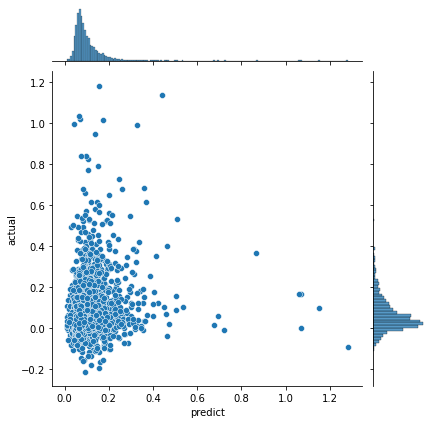

In [55]:
sns.jointplot(data=result[label], x="predict", y="actual")

Text(0.5, 0, 'Random Forest Feature Importance')

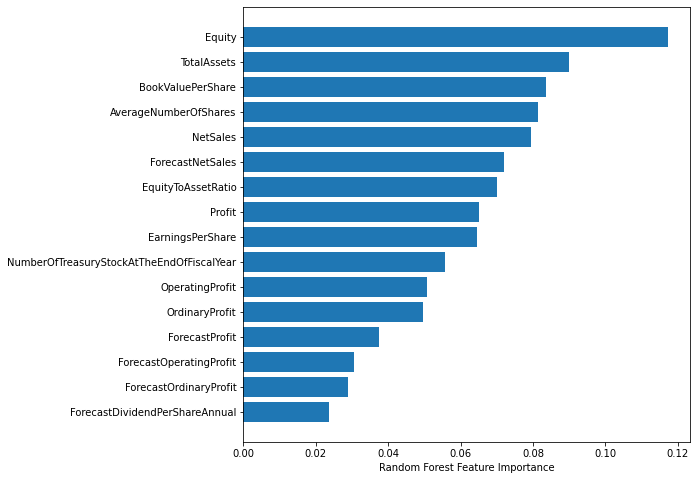

In [56]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

In [57]:
# モデルを定義します
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

model_output = "margin" has been renamed to model_output = "raw"


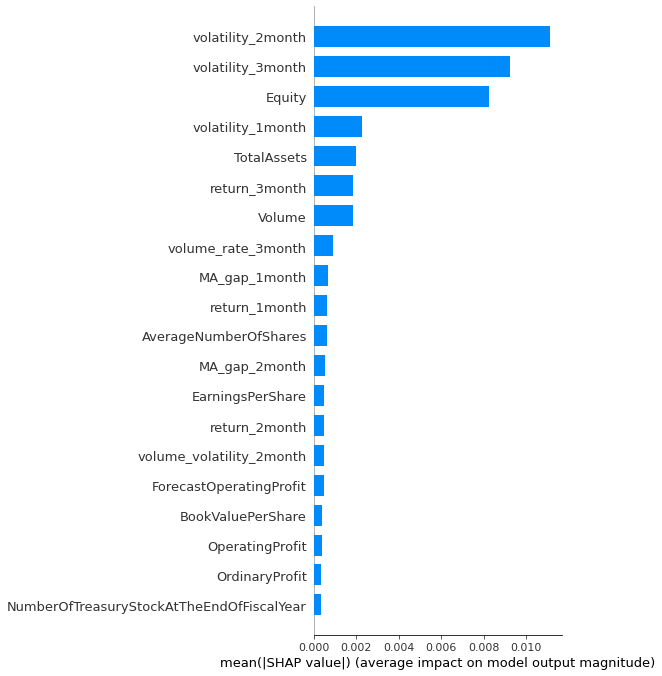

In [58]:
shap.initjs()
explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X["label_high_20"])
# プロット
shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")

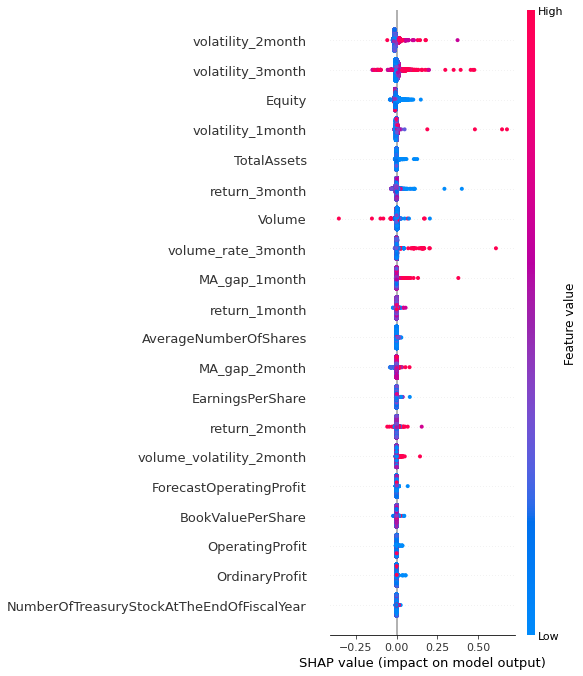

In [59]:
shap.summary_plot(shap_values, train_X["label_high_20"])

In [60]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 学習済みモデル保存用
trained_models = dict()
# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    trained_models[model] = dict()
    # データセット毎に処理
    for col in tqdm(columns.keys()):
        result = dict()
        trained_models[model][col] = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 学習済みモデル保存
                trained_models[model][col][label] = pred_model
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:28<02:24, 28.84s/it]

 33%|████████████████████████████                                                        | 2/6 [00:54<01:48, 27.22s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:13<01:09, 23.29s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:32<00:43, 21.66s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:54<00:21, 21.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:12<00:00, 22.15s/it]

 25%|████████████████████▊      

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:47<00:23, 11.97s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:00<00:12, 12.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.32s/it]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:04<00:24,  4.89s/it]

 33%|████████████████████████████                                                        | 2/6 [00:09<00:19,  4.91s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:14<00:14,  4.96s/it]

 67%|███████████████████████████

In [61]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

code   datetime   predict  predict_dir    actual  \
label_high_20 2022-07-13  1377 2022-07-13  0.065056          1.0  0.190805   
              2022-10-14  1407 2022-10-14  0.112827          1.0  0.048315   
              2022-08-10  1414 2022-08-10  0.081910          1.0  0.081667   
              2022-07-11  1419 2022-07-11  0.073613          1.0  0.069971   
              2022-06-14  1720 2022-06-14  0.098722          1.0  0.027244   

                          actual_dir model           feature          label  
label_high_20 2022-07-13         1.0    rf  fundamental_only  label_high_20  
              2022-10-14         1.0    rf  fundamental_only  label_high_20  
              2022-08-10         1.0    rf  fundamental_only  label_high_20  
              2022-07-11         1.0    rf  fundamental_only  label_high_20  
              2022-06-14         1.0    rf  fundamental_only  label_high_20

In [62]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
for feature in columns:
    matrix = dict()
    # モデル毎に処理
    for model in models:
        # 目的変数毎に処理
        for label in labels:
            # 処理対象データに絞り込み
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            # RMSE
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            # 精度
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            # 相関係数
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            # 順位相関
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            # 結果を保存
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

index      RMSE  accuracy spearman_corr      corr R^2 score  \
0   label_high_20  0.156418  0.857143      0.185542  0.145377  0.021135   
1    label_low_10  0.117164  0.645455      0.073139 -0.033399  0.001115   
2   label_high_10  0.144797  0.806818      0.183032  0.066763  0.004457   
3    label_high_5  0.120149      0.75      0.131837  0.054273  0.002946   
4     label_low_5  0.100462  0.542986      0.080656  0.041888  0.001755   
..            ...       ...       ...           ...       ...       ...   
67   label_low_10  0.139383  0.648864      0.095019  0.052012  0.002705   
68  label_high_10  0.163127  0.806818      0.221986  0.158821  0.025224   
69   label_high_5   0.14239  0.748869      0.195592  0.149205  0.022262   
70    label_low_5  0.109353   0.53733      0.072158  0.021561  0.000465   
71   label_low_20  0.152817  0.725995      0.155339  0.112504  0.012657   

                  feature model # of samples  
0        fundamental_only    rf          854  
1        fundamental_only    rf          880  
2        fundamental_only    rf          880  
3        fundamental_only    rf          884  
4        fundamental_only    rf          884  
..                    ...   ...          ...  
67  fundamental+technical   gbr          880  
68  fundamental+technical   gbr          880  
69  fundamental+technical   gbr          884  
70  fundamental+technical   gbr          884  
71  fundamental+technical   gbr          854  

[72 rows x 9 columns]

In [63]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
# indexとデータセット毎に平均を計算
agg = all_metrics.reset_index().groupby(["index","feature"]).agg("mean")
agg

RMSE  accuracy  spearman_corr  \
index         feature                                                    
label_high_10 fundamental+technical  0.156618  0.806818       0.207676   
              fundamental_only       0.140385  0.806061       0.164420   
              return_only            0.124504  0.805303       0.123353   
              technical_only         0.161624  0.806818       0.198220   
label_high_20 fundamental+technical  0.178325  0.857143       0.260880   
              fundamental_only       0.153866  0.856753       0.176920   
              return_only            0.144737  0.856362       0.153450   
              technical_only         0.188474  0.857533       0.241706   
label_high_5  fundamental+technical  0.131660  0.748869       0.206664   
              fundamental_only       0.119730  0.748492       0.139372   
              return_only            0.112666  0.745098       0.107205   
              technical_only         0.132473  0.748869       0.180095   
label_low_10  fundamental+technical  0.133394  0.643561       0.084710   
              fundamental_only       0.116534  0.640909       0.076059   
              return_only            0.109221  0.612879       0.053369   
              technical_only         0.135647  0.643182       0.038600   
label_low_20  fundamental+technical  0.149599  0.722482       0.140441   
              fundamental_only       0.131327  0.722482       0.109217   
              return_only            0.126152  0.707650       0.084082   
              technical_only         0.155612  0.724434       0.116341   
label_low_5   fundamental+technical  0.105928  0.543363       0.098343   
              fundamental_only       0.100328  0.540347       0.068639   
              return_only            0.099720  0.515083       0.048816   
              technical_only         0.107958  0.513575       0.003281   

                                         corr  R^2 score  
index         feature                                     
label_high_10 fundamental+technical  0.178761   0.032526  
              fundamental_only       0.067167   0.005619  
              return_only            0.156993   0.024795  
              technical_only         0.181556   0.033439  
label_high_20 fundamental+technical  0.249632   0.062337  
              fundamental_only       0.136060   0.019435  
              return_only            0.193256   0.038057  
              technical_only         0.240299   0.058511  
label_high_5  fundamental+technical  0.169503   0.029458  
              fundamental_only       0.054057   0.003462  
              return_only            0.138234   0.019471  
              technical_only         0.175216   0.031582  
label_low_10  fundamental+technical  0.054122   0.002956  
              fundamental_only      -0.036055   0.003285  
              return_only            0.082321   0.006816  
              technical_only         0.064463   0.004306  
label_low_20  fundamental+technical  0.124308   0.015564  
              fundamental_only       0.020975   0.003691  
              return_only            0.109243   0.012569  
              technical_only         0.113789   0.013030  
label_low_5   fundamental+technical  0.046847   0.002735  
              fundamental_only       0.015165   0.001155  
              return_only            0.066564   0.004489  
              technical_only         0.036468   0.001335